In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import json
import sys

from tqdm import tqdm

# config_file = sys.argv[1]

config_file = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/config_kdv.json'


with open(config_file, "r") as f:
    config = json.load(f)["sin"]
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]
# figures_path = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/kdv_results/figures_tau_10'



n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

forcing_type = config['data_settings']['forcing_type']


n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from koopmanlib.functions import *
from koopmanlib.target import KortewegDeVriesTarget
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3
kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

# Load data
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + ".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]


pknn_epochs = config["nn_settings"]["pknn_epochs"]


2024-07-31 11:07:05.434517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 11:07:05.568270: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 11:07:06.269935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-07-31 11:07:06.270155: W tensorflow/compiler/xla/stre

In [2]:


# Build model
## PK-NN
# from tensorflow.keras.optimizers import Adam

# from koopmanlib.dictionary import PsiNN_obs
# from koopmanlib.param_solver import KoopmanParametricDLSolver

# n_psi = 1 + 1 + 1 + n_psi_train  # constant + momentum + mean + NN

# dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# from koopmanlib.K_structure import Model_K_u_Layer_One

# model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

# solver_pk = KoopmanParametricDLSolver(
#     target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
# )

# model_pk, model_K_u_pred_pk = solver_pk.generate_model()

# model_pk.load_weights(os.path.join(weights_path, "pk_kdv_weights_" + forcing_type + ".h5"))

# def compute_pk_obs(y0, param_list, B_obs):
#     param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)

#     psi_y = dic_pk(y0)
#     obs_list = [psi_y @ B_obs]

#     tau = param_list.shape[0]

#     for i in range(tau):
#         psi_y = model_K_u_pred_pk([param[i], psi_y])
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))
# ## Linear
# from koopmanlib.param_solver import KoopmanLinearDLSolver

# dic_linear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# solver_linear = KoopmanLinearDLSolver(
#     dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
# )

# model_linear, model_K_u_pred_linear = solver_linear.build_model()

# solver_linear.model.load_weights(
#     os.path.join(weights_path, "linear_kdv_weights_" + forcing_type + ".h5")
# )
# def compute_linear_obs(y0, param_list, B_obs):
#     param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)
#     psi_y = solver_linear.dic.call(y0)
#     obs_list = [psi_y @ B_obs]

#     for param in param_list:
#         psi_y = solver_linear.model_K_u_pred_linear.get_layer("Layer_A")(psi_y) + solver_linear.model_K_u_pred_linear.get_layer(
#             "Layer_B"
#         )(param)
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))
# ## Bilinear
# from koopmanlib.param_solver import KoopmanBilinearDLSolver

# dic_bilinear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# solver_bilinear = KoopmanBilinearDLSolver(
#     dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
# )

# model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()
# solver_bilinear.model.load_weights(
#     os.path.join(weights_path, "bilinear_kdv_weights_" + forcing_type + ".h5")
# )
# def compute_bilinear_obs(y0, param_list, B_obs):
#     param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)
#     psi_y = solver_bilinear.dic.call(y0)
#     obs_list = [psi_y @ B_obs]

#     for param in param_list:
#         u_psiy = tf.einsum("ij,ik->kij", psi_y, param)
#         u_psiy_list = []
#         for curr in u_psiy:
#             u_psiy_list.append(curr)
#         u_psiy_list = tf.concat(u_psiy_list, axis=-1)

#         psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
#             psi_y
#         ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))



In [3]:

# Testing problems
# Plot setting
linear_curve = "darkorange"
linear_shadow = "navajowhite"
bilinear_curve = "forestgreen"
bilinear_shadow = "darkseagreen"
pk_curve = "darkblue"
pk_shadow = "lightsteelblue"
ref_color = "black"


exact_color = "darkred"
linear_no_penalty_color = "gold"
bilinear_no_penalty_color = "turquoise"
pk_no_penalty_color = "palevioletred"

label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"
## Prediction
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list
    
pred_traj_number = 10
np.random.seed(625)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number, 2))

y0_pred_list = []
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)


In [4]:

# for seed_IC, seed_u in seed_list:
#     # Forward prediction problem setting
#     y0_pred = kdv.generate_y0(seed_IC)

#     # Set the seed of param_list
#     np.random.seed(seed_u)

#     param_pred = (
#         np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
#     )

#     y0_pred_list.append(y0_pred)
#     param_pred_list.append(param_pred)
# error_mass_list_pk, error_momentum_list_pk = kdv.compute_obs_error(
#     dic=dic_pk,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_pk_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )

# mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(
#     error_mass_list_pk
# )
# momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = (
#     compute_stat_info(error_momentum_list_pk)
# )
# error_mass_list_linear, error_momentum_list_linear = kdv.compute_obs_error(
#     dic=dic_linear,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_linear_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )
# mass_mean_linear, mass_std_linear, mass_mean_plus_linear, mass_mean_minus_linear = (
#     compute_stat_info(error_mass_list_linear)
# )
# (
#     momentum_mean_linear,
#     momentum_std_linear,
#     momentum_mean_plus_linear,
#     momentum_mean_minus_linear,
# ) = compute_stat_info(error_momentum_list_linear)
# error_mass_list_bilinear, error_momentum_list_bilinear = kdv.compute_obs_error(
#     dic=dic_bilinear,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_bilinear_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )
# mass_mean_bilinear, mass_std_bilinear, mass_mean_plus_bilinear, mass_mean_minus_bilinear = (
#     compute_stat_info(error_mass_list_bilinear)
# )
# (
#     momentum_mean_bilinear,
#     momentum_std_bilinear,
#     momentum_mean_plus_bilinear,
#     momentum_mean_minus_bilinear,
# ) = compute_stat_info(error_momentum_list_bilinear)
# t_axis = np.arange(0, traj_len_pred + 1, 1)

# # plt.title("Mass", fontsize=28)


# plt.plot(mass_mean_pk,
#           label="Ours", 
#           color=pk_curve,
#           linestyle=pk_linestyle,
#           linewidth=3, 
#           alpha=0.5)
# plt.fill_between(
#     t_axis, np.maximum(mass_mean_minus_pk, 0), mass_mean_plus_pk, color=pk_shadow, alpha=0.5
# )

# plt.plot(mass_mean_linear, 
#          label="M2", 
#          color=linear_curve,
#          linestyle=linear_linestyle, 
#          linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(mass_mean_minus_linear, 0),
#     mass_mean_plus_linear,
#     color=linear_shadow,
#     alpha=0.5,
# )

# plt.plot(mass_mean_bilinear, 
#          label="M3", 
#          color=bilinear_curve,
#          linestyle=bilinear_linestyle,
#            linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(mass_mean_minus_bilinear, 0),
#     mass_mean_plus_bilinear,
#     color=bilinear_shadow,
#     alpha=0.5,
# )

# plt.xlabel(r"$n$", fontsize=28)
# plt.ylabel("Error", fontsize=28)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_pred.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_pred.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

# print('---Predict Mass Done---')

# t_axis = np.arange(0, traj_len_pred + 1, 1)

# # plt.title("Momentum", fontsize=28)
# plt.plot(momentum_mean_pk, 
#          label="Ours", 
#          color=pk_curve,
#          linestyle=pk_linestyle, 
#          linewidth=3, 
#          alpha=0.5)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_pk, 0),
#     momentum_mean_plus_pk,
#     color=pk_shadow,
#     alpha=0.5,
# )

# plt.plot(momentum_mean_linear,
#           label="M2", 
#           color=linear_curve,
#           linestyle=linear_linestyle,
#           linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_linear, 0),
#     momentum_mean_plus_linear,
#     color=linear_shadow,
#     alpha=0.5,
# )

# plt.plot(momentum_mean_bilinear, 
#          label="M3", 
#          color=bilinear_curve, 
#         linestyle=bilinear_linestyle,
#          linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_bilinear, 0),
#     momentum_mean_plus_bilinear,
#     color=bilinear_shadow,
#     alpha=0.5,
# )

# plt.xlabel(r"$n$", fontsize=28)
# plt.ylabel("Error", fontsize=28)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_pred.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_pred.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

# print('---Predict Momentum Done---')


## Build vanilla model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
# Set the default data type to float64
tf.keras.backend.set_floatx('float64')

# Define the input layers
input_x = layers.Input(shape=(Nx,))
input_u = layers.Input(shape=(param_dim,))

# Concatenate the inputs
concatenated = layers.Concatenate()([input_x, input_u])

# Hidden layer
hidden_layer = layers.Dense(20, activation='relu')(concatenated) 

# Output layer
output_y = layers.Dense(Nx, activation='linear')(hidden_layer)

# Create the model
model_vanilla = models.Model(inputs=[input_x, input_u], outputs=output_y)

# Print model summary to check the number of parameters
model_vanilla.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 131)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 20)           2640        ['concatenate[0][0]']        

2024-07-31 11:07:08.705735: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-31 11:07:08.705779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-07-31 11:07:08.705785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-07-31 11:07:08.705934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.171.4
2024-07-31 11:07:08.705958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.171.4
2024-07-31 11:07:08.705963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.171.4
2024-07-31 11:07:08.706301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

In [6]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model_vanilla.compile(optimizer=Adam(0.001), loss="mse")

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,
)

In [7]:
history_nonlinear = model_vanilla.fit([data_x, data_u], data_y, epochs=pknn_epochs, batch_size=200, callbacks=lr_callback)

Epoch 1/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0045 - lr: 1.0000e-03
Epoch 2/500
1000/1000 [==============================] - 2s 2ms/step - loss: 2.3406e-04 - lr: 1.0000e-03
Epoch 3/500
1000/1000 [==============================] - 2s 2ms/step - loss: 1.1495e-04 - lr: 1.0000e-03
Epoch 4/500
1000/1000 [==============================] - 2s 2ms/step - loss: 6.2080e-05 - lr: 1.0000e-03
Epoch 5/500
1000/1000 [==============================] - 2s 2ms/step - loss: 3.9241e-05 - lr: 1.0000e-03
Epoch 6/500
1000/1000 [==============================] - 2s 2ms/step - loss: 2.5094e-05 - lr: 1.0000e-03
Epoch 7/500
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7398e-05 - lr: 1.0000e-03
Epoch 8/500
1000/1000 [==============================] - 2s 2ms/step - loss: 1.4058e-05 - lr: 1.0000e-03
Epoch 9/500
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2550e-05 - lr: 1.0000e-03
Epoch 10/500
1000/1000 [==============================] - 2

In [8]:

# Tracking problem
from scipy.optimize import minimize
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))


In [9]:
def compute_mass(inputs):
    obs_mass = dx * tf.reshape(tf.math.reduce_sum(inputs, axis=-1), shape=(-1, 1))
    return obs_mass

def compute_momentum(inputs):
    obs_momentum = dx * tf.reshape(
        tf.math.reduce_sum(tf.square(inputs), axis=-1), shape=(-1, 1)
    )
    return obs_momentum

In [10]:
def mpc_loss_vanilla(param, tau, ref_list, y0, obs_func, lambda_param):
    param = tf.reshape(param, shape=(tau, 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    y_list = [y0]

    for i in range(tau):
        y_next = model_vanilla([y_list[-1], param[i]])
        obs_next = obs_func(y_next)
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [11]:

import time
def VanillaMPC(y0, tau, traj_len, soln_ref, kdv_solver, obs_func, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    results_list = []

    t_list = []

    param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        t1 = time.time()
        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                obs_func,
                lambda_param,
            ),
            bounds=bounds,
            method='L-BFGS-B'
        )

        t2 = time.time()

        results_list.append(results)

        param = results.x.reshape(tau, param_dim)[0]
        param_init = results.x.reshape((tau * param_dim,))
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

        print("*** current time ***", current_time)
        print("optimize time: ", t2-t1)

        t_list.append(t2-t1)

    print("t mean: ", np.mean(t_list))

    current_time = current_time + 1

    # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            obs_func,
            lambda_param,
        ),
        bounds=bounds,
    )
    results_list.append(results)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [12]:

### Track mass
tau = 10  # time horizon
# lambda_param = 0.005
# lambda_param = 0

vanilla_opt_control_mass_0, vanilla_kdv_opt_mass_soln_0, vanilla_results_mass_0, vanilla_t_list_mass_0 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_mass,
    loss=mpc_loss_vanilla,
    lambda_param=0,
)

vanilla_opt_control_mass_5, vanilla_kdv_opt_mass_soln_5, vanilla_results_mass_5, vanilla_t_list_mass_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_mass,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)


vanilla_kdv_opt_mass_0 = dx * tf.reduce_sum(vanilla_kdv_opt_mass_soln_0, axis=-1)
vanilla_kdv_opt_mass_5 = dx * tf.reduce_sum(vanilla_kdv_opt_mass_soln_5, axis=-1)

### Check exact control for KdV equation
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)


def v1_func(x):
    return np.exp(-25 * (x + np.pi / 2) ** 2)


def v2_func(x):
    return np.exp(-25 * (x) ** 2)


def v3_func(x):
    return np.exp(-25 * (x - np.pi / 2) ** 2)


from scipy import integrate

integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi)

integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi)

integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi)

rhs_value = integral_1 + integral_2 + integral_3

mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1, 1))

track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T)

track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

control_exact_opt = np.zeros(shape=vanilla_opt_control_mass_0.shape, dtype="float64")

control_exact_opt[:track_step_1] = 0.5
control_exact_opt[500 : 500 + track_step_2] = 0.5

kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)
kdv_opt_mass = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1, 1))


Processing time steps:   0%|          | 1/989 [00:02<38:50,  2.36s/it]

*** current time *** 0
optimize time:  2.35681414604187


Processing time steps:   0%|          | 2/989 [00:03<23:30,  1.43s/it]

*** current time *** 1
optimize time:  0.7754864692687988


Processing time steps:   0%|          | 3/989 [00:03<18:34,  1.13s/it]

*** current time *** 2
optimize time:  0.7731473445892334


Processing time steps:   0%|          | 4/989 [00:04<16:18,  1.01it/s]

*** current time *** 3
optimize time:  0.7808973789215088


Processing time steps:   1%|          | 5/989 [00:05<14:56,  1.10it/s]

*** current time *** 4
optimize time:  0.7637367248535156


Processing time steps:   1%|          | 6/989 [00:06<14:13,  1.15it/s]

*** current time *** 5
optimize time:  0.7807562351226807


Processing time steps:   1%|          | 7/989 [00:06<13:21,  1.22it/s]

*** current time *** 6
optimize time:  0.709306001663208


Processing time steps:   1%|          | 8/989 [00:07<12:50,  1.27it/s]

*** current time *** 7
optimize time:  0.716876745223999


Processing time steps:   1%|          | 9/989 [00:08<12:22,  1.32it/s]

*** current time *** 8
optimize time:  0.6944642066955566


Processing time steps:   1%|          | 10/989 [00:09<12:07,  1.35it/s]

*** current time *** 9
optimize time:  0.7086107730865479


Processing time steps:   1%|          | 11/989 [00:09<11:59,  1.36it/s]

*** current time *** 10
optimize time:  0.7162275314331055


Processing time steps:   1%|          | 12/989 [00:10<12:20,  1.32it/s]

*** current time *** 11
optimize time:  0.8073840141296387


Processing time steps:   1%|▏         | 13/989 [00:11<13:06,  1.24it/s]

*** current time *** 12
optimize time:  0.9132485389709473


Processing time steps:   1%|▏         | 14/989 [00:12<13:32,  1.20it/s]

*** current time *** 13
optimize time:  0.8936491012573242


Processing time steps:   2%|▏         | 15/989 [00:13<13:16,  1.22it/s]

*** current time *** 14
optimize time:  0.7798008918762207


Processing time steps:   2%|▏         | 16/989 [00:13<12:45,  1.27it/s]

*** current time *** 15
optimize time:  0.7117774486541748


Processing time steps:   2%|▏         | 17/989 [00:14<12:20,  1.31it/s]

*** current time *** 16
optimize time:  0.7015972137451172


Processing time steps:   2%|▏         | 18/989 [00:15<12:03,  1.34it/s]

*** current time *** 17
optimize time:  0.7019262313842773


Processing time steps:   2%|▏         | 19/989 [00:16<11:52,  1.36it/s]

*** current time *** 18
optimize time:  0.7097811698913574


Processing time steps:   2%|▏         | 20/989 [00:16<11:44,  1.38it/s]

*** current time *** 19
optimize time:  0.7047398090362549


Processing time steps:   2%|▏         | 21/989 [00:17<11:38,  1.39it/s]

*** current time *** 20
optimize time:  0.7069187164306641


Processing time steps:   2%|▏         | 22/989 [00:18<11:30,  1.40it/s]

*** current time *** 21
optimize time:  0.6956081390380859


Processing time steps:   2%|▏         | 23/989 [00:18<11:35,  1.39it/s]

*** current time *** 22
optimize time:  0.7309916019439697


Processing time steps:   2%|▏         | 24/989 [00:19<11:29,  1.40it/s]

*** current time *** 23
optimize time:  0.6985979080200195


Processing time steps:   3%|▎         | 25/989 [00:20<11:22,  1.41it/s]

*** current time *** 24
optimize time:  0.6911559104919434


Processing time steps:   3%|▎         | 26/989 [00:20<11:21,  1.41it/s]

*** current time *** 25
optimize time:  0.7058415412902832


Processing time steps:   3%|▎         | 27/989 [00:21<11:16,  1.42it/s]

*** current time *** 26
optimize time:  0.6917736530303955


Processing time steps:   3%|▎         | 28/989 [00:22<11:17,  1.42it/s]

*** current time *** 27
optimize time:  0.7050254344940186


Processing time steps:   3%|▎         | 29/989 [00:23<11:15,  1.42it/s]

*** current time *** 28
optimize time:  0.699749231338501


Processing time steps:   3%|▎         | 30/989 [00:23<11:20,  1.41it/s]

*** current time *** 29
optimize time:  0.7195260524749756


Processing time steps:   3%|▎         | 31/989 [00:24<11:17,  1.41it/s]

*** current time *** 30
optimize time:  0.7005066871643066


Processing time steps:   3%|▎         | 32/989 [00:25<11:14,  1.42it/s]

*** current time *** 31
optimize time:  0.6963820457458496


Processing time steps:   3%|▎         | 33/989 [00:25<11:15,  1.41it/s]

*** current time *** 32
optimize time:  0.7100856304168701


Processing time steps:   3%|▎         | 34/989 [00:26<11:19,  1.41it/s]

*** current time *** 33
optimize time:  0.7183949947357178


Processing time steps:   4%|▎         | 35/989 [00:27<11:15,  1.41it/s]

*** current time *** 34
optimize time:  0.6996629238128662


Processing time steps:   4%|▎         | 36/989 [00:28<11:17,  1.41it/s]

*** current time *** 35
optimize time:  0.7134640216827393


Processing time steps:   4%|▎         | 37/989 [00:28<11:13,  1.41it/s]

*** current time *** 36
optimize time:  0.6993045806884766


Processing time steps:   4%|▍         | 38/989 [00:29<11:13,  1.41it/s]

*** current time *** 37
optimize time:  0.7054634094238281


Processing time steps:   4%|▍         | 39/989 [00:30<11:14,  1.41it/s]

*** current time *** 38
optimize time:  0.7139298915863037


Processing time steps:   4%|▍         | 40/989 [00:30<11:09,  1.42it/s]

*** current time *** 39
optimize time:  0.6915555000305176


Processing time steps:   4%|▍         | 41/989 [00:31<11:06,  1.42it/s]

*** current time *** 40
optimize time:  0.6960363388061523


Processing time steps:   4%|▍         | 42/989 [00:32<11:07,  1.42it/s]

*** current time *** 41
optimize time:  0.7071981430053711


Processing time steps:   4%|▍         | 43/989 [00:33<11:08,  1.42it/s]

*** current time *** 42
optimize time:  0.7061779499053955


Processing time steps:   4%|▍         | 44/989 [00:33<11:16,  1.40it/s]

*** current time *** 43
optimize time:  0.7348659038543701


Processing time steps:   5%|▍         | 45/989 [00:34<11:07,  1.42it/s]

*** current time *** 44
optimize time:  0.6839401721954346


Processing time steps:   5%|▍         | 46/989 [00:35<11:05,  1.42it/s]

*** current time *** 45
optimize time:  0.7033288478851318


Processing time steps:   5%|▍         | 47/989 [00:35<11:10,  1.41it/s]

*** current time *** 46
optimize time:  0.7203543186187744


Processing time steps:   5%|▍         | 48/989 [00:36<11:06,  1.41it/s]

*** current time *** 47
optimize time:  0.6975553035736084


Processing time steps:   5%|▍         | 49/989 [00:37<11:06,  1.41it/s]

*** current time *** 48
optimize time:  0.708134651184082


Processing time steps:   5%|▌         | 50/989 [00:37<11:04,  1.41it/s]

*** current time *** 49
optimize time:  0.7032248973846436


Processing time steps:   5%|▌         | 51/989 [00:38<11:03,  1.41it/s]

*** current time *** 50
optimize time:  0.7039978504180908


Processing time steps:   5%|▌         | 52/989 [00:39<11:01,  1.42it/s]

*** current time *** 51
optimize time:  0.701723575592041


Processing time steps:   5%|▌         | 53/989 [00:40<11:02,  1.41it/s]

*** current time *** 52
optimize time:  0.7086775302886963


Processing time steps:   5%|▌         | 54/989 [00:40<11:06,  1.40it/s]

*** current time *** 53
optimize time:  0.7212579250335693


Processing time steps:   6%|▌         | 55/989 [00:41<11:02,  1.41it/s]

*** current time *** 54
optimize time:  0.6995940208435059


Processing time steps:   6%|▌         | 56/989 [00:42<10:59,  1.41it/s]

*** current time *** 55
optimize time:  0.6996340751647949


Processing time steps:   6%|▌         | 57/989 [00:42<10:58,  1.42it/s]

*** current time *** 56
optimize time:  0.7019565105438232


Processing time steps:   6%|▌         | 58/989 [00:43<11:02,  1.40it/s]

*** current time *** 57
optimize time:  0.7229020595550537


Processing time steps:   6%|▌         | 59/989 [00:44<10:52,  1.42it/s]

*** current time *** 58
optimize time:  0.6770057678222656


Processing time steps:   6%|▌         | 60/989 [00:44<10:34,  1.46it/s]

*** current time *** 59
optimize time:  0.6369309425354004


Processing time steps:   6%|▌         | 61/989 [00:45<10:21,  1.49it/s]

*** current time *** 60
optimize time:  0.6379165649414062


Processing time steps:   6%|▋         | 62/989 [00:46<10:12,  1.51it/s]

*** current time *** 61
optimize time:  0.6375243663787842


Processing time steps:   6%|▋         | 63/989 [00:46<10:04,  1.53it/s]

*** current time *** 62
optimize time:  0.6329014301300049


Processing time steps:   6%|▋         | 64/989 [00:47<09:59,  1.54it/s]

*** current time *** 63
optimize time:  0.6327817440032959


Processing time steps:   7%|▋         | 65/989 [00:48<09:56,  1.55it/s]

*** current time *** 64
optimize time:  0.6393887996673584


Processing time steps:   7%|▋         | 66/989 [00:48<09:53,  1.56it/s]

*** current time *** 65
optimize time:  0.6336066722869873


Processing time steps:   7%|▋         | 67/989 [00:49<09:52,  1.56it/s]

*** current time *** 66
optimize time:  0.6387875080108643


Processing time steps:   7%|▋         | 68/989 [00:50<09:50,  1.56it/s]

*** current time *** 67
optimize time:  0.6356062889099121


Processing time steps:   7%|▋         | 69/989 [00:50<09:51,  1.55it/s]

*** current time *** 68
optimize time:  0.6467177867889404


Processing time steps:   7%|▋         | 70/989 [00:51<09:52,  1.55it/s]

*** current time *** 69
optimize time:  0.6453826427459717


Processing time steps:   7%|▋         | 71/989 [00:52<09:52,  1.55it/s]

*** current time *** 70
optimize time:  0.6443593502044678


Processing time steps:   7%|▋         | 72/989 [00:52<09:51,  1.55it/s]

*** current time *** 71
optimize time:  0.6450550556182861


Processing time steps:   7%|▋         | 73/989 [00:53<09:51,  1.55it/s]

*** current time *** 72
optimize time:  0.6461493968963623


Processing time steps:   7%|▋         | 74/989 [00:53<09:51,  1.55it/s]

*** current time *** 73
optimize time:  0.64658522605896


Processing time steps:   8%|▊         | 75/989 [00:54<09:50,  1.55it/s]

*** current time *** 74
optimize time:  0.6440083980560303


Processing time steps:   8%|▊         | 76/989 [00:55<09:50,  1.55it/s]

*** current time *** 75
optimize time:  0.6466255187988281


Processing time steps:   8%|▊         | 77/989 [00:56<11:51,  1.28it/s]

*** current time *** 76
optimize time:  1.089195728302002


Processing time steps:   8%|▊         | 78/989 [00:57<12:20,  1.23it/s]

*** current time *** 77
optimize time:  0.8835937976837158


Processing time steps:   8%|▊         | 79/989 [00:58<12:38,  1.20it/s]

*** current time *** 78
optimize time:  0.880490779876709


Processing time steps:   8%|▊         | 80/989 [00:58<12:51,  1.18it/s]

*** current time *** 79
optimize time:  0.8798394203186035


Processing time steps:   8%|▊         | 81/989 [00:59<13:03,  1.16it/s]

*** current time *** 80
optimize time:  0.8922123908996582


Processing time steps:   8%|▊         | 82/989 [01:00<12:44,  1.19it/s]

*** current time *** 81
optimize time:  0.7859492301940918


Processing time steps:   8%|▊         | 83/989 [01:01<12:00,  1.26it/s]

*** current time *** 82
optimize time:  0.6824452877044678


Processing time steps:   8%|▊         | 84/989 [01:02<11:33,  1.31it/s]

*** current time *** 83
optimize time:  0.6943168640136719


Processing time steps:   9%|▊         | 85/989 [01:02<11:14,  1.34it/s]

*** current time *** 84
optimize time:  0.6961441040039062


Processing time steps:   9%|▊         | 86/989 [01:03<10:59,  1.37it/s]

*** current time *** 85
optimize time:  0.6936647891998291


Processing time steps:   9%|▉         | 87/989 [01:04<10:57,  1.37it/s]

*** current time *** 86
optimize time:  0.7233271598815918


Processing time steps:   9%|▉         | 88/989 [01:04<11:08,  1.35it/s]

*** current time *** 87
optimize time:  0.7673177719116211


Processing time steps:   9%|▉         | 89/989 [01:05<11:12,  1.34it/s]

*** current time *** 88
optimize time:  0.7589948177337646


Processing time steps:   9%|▉         | 90/989 [01:06<11:01,  1.36it/s]

*** current time *** 89
optimize time:  0.7069027423858643


Processing time steps:   9%|▉         | 91/989 [01:07<10:46,  1.39it/s]

*** current time *** 90
optimize time:  0.6814262866973877


Processing time steps:   9%|▉         | 92/989 [01:07<10:44,  1.39it/s]

*** current time *** 91
optimize time:  0.7138950824737549


Processing time steps:   9%|▉         | 93/989 [01:08<10:40,  1.40it/s]

*** current time *** 92
optimize time:  0.7018756866455078


Processing time steps:  10%|▉         | 94/989 [01:09<10:46,  1.38it/s]

*** current time *** 93
optimize time:  0.7384223937988281


Processing time steps:  10%|▉         | 95/989 [01:09<10:40,  1.40it/s]

*** current time *** 94
optimize time:  0.6986420154571533


Processing time steps:  10%|▉         | 96/989 [01:10<10:36,  1.40it/s]

*** current time *** 95
optimize time:  0.701993465423584


Processing time steps:  10%|▉         | 97/989 [01:11<10:30,  1.42it/s]

*** current time *** 96
optimize time:  0.6903204917907715


Processing time steps:  10%|▉         | 98/989 [01:12<10:30,  1.41it/s]

*** current time *** 97
optimize time:  0.7101891040802002


Processing time steps:  10%|█         | 99/989 [01:12<10:26,  1.42it/s]

*** current time *** 98
optimize time:  0.6923568248748779


Processing time steps:  10%|█         | 100/989 [01:13<10:29,  1.41it/s]

*** current time *** 99
optimize time:  0.7166736125946045


Processing time steps:  10%|█         | 101/989 [01:14<10:25,  1.42it/s]

*** current time *** 100
optimize time:  0.6925046443939209


Processing time steps:  10%|█         | 102/989 [01:14<10:29,  1.41it/s]

*** current time *** 101
optimize time:  0.7191450595855713


Processing time steps:  10%|█         | 103/989 [01:15<10:26,  1.41it/s]

*** current time *** 102
optimize time:  0.6997115612030029


Processing time steps:  11%|█         | 104/989 [01:16<10:24,  1.42it/s]

*** current time *** 103
optimize time:  0.6985957622528076


Processing time steps:  11%|█         | 105/989 [01:17<10:27,  1.41it/s]

*** current time *** 104
optimize time:  0.719280481338501


Processing time steps:  11%|█         | 106/989 [01:17<10:23,  1.42it/s]

*** current time *** 105
optimize time:  0.6942136287689209


Processing time steps:  11%|█         | 107/989 [01:18<10:31,  1.40it/s]

*** current time *** 106
optimize time:  0.7384092807769775


Processing time steps:  11%|█         | 108/989 [01:19<10:31,  1.40it/s]

*** current time *** 107
optimize time:  0.7140321731567383


Processing time steps:  11%|█         | 109/989 [01:19<10:27,  1.40it/s]

*** current time *** 108
optimize time:  0.7037522792816162


Processing time steps:  11%|█         | 110/989 [01:20<10:49,  1.35it/s]

*** current time *** 109
optimize time:  0.7979528903961182


Processing time steps:  11%|█         | 111/989 [01:21<11:07,  1.32it/s]

*** current time *** 110
optimize time:  0.8055217266082764


Processing time steps:  11%|█▏        | 112/989 [01:22<10:55,  1.34it/s]

*** current time *** 111
optimize time:  0.7172694206237793


Processing time steps:  11%|█▏        | 113/989 [01:22<10:45,  1.36it/s]

*** current time *** 112
optimize time:  0.7087597846984863


Processing time steps:  12%|█▏        | 114/989 [01:23<10:42,  1.36it/s]

*** current time *** 113
optimize time:  0.7260420322418213


Processing time steps:  12%|█▏        | 115/989 [01:24<10:47,  1.35it/s]

*** current time *** 114
optimize time:  0.7556765079498291


Processing time steps:  12%|█▏        | 116/989 [01:25<10:54,  1.33it/s]

*** current time *** 115
optimize time:  0.7663109302520752


Processing time steps:  12%|█▏        | 117/989 [01:25<10:59,  1.32it/s]

*** current time *** 116
optimize time:  0.768683671951294


Processing time steps:  12%|█▏        | 118/989 [01:26<10:59,  1.32it/s]

*** current time *** 117
optimize time:  0.7588281631469727


Processing time steps:  12%|█▏        | 119/989 [01:27<10:43,  1.35it/s]

*** current time *** 118
optimize time:  0.6959846019744873


Processing time steps:  12%|█▏        | 120/989 [01:28<11:15,  1.29it/s]

*** current time *** 119
optimize time:  0.8637924194335938


Processing time steps:  12%|█▏        | 121/989 [01:29<12:22,  1.17it/s]

*** current time *** 120
optimize time:  1.0327098369598389


Processing time steps:  12%|█▏        | 122/989 [01:30<13:07,  1.10it/s]

*** current time *** 121
optimize time:  1.028062343597412


Processing time steps:  12%|█▏        | 123/989 [01:31<12:31,  1.15it/s]

*** current time *** 122
optimize time:  0.7718777656555176


Processing time steps:  13%|█▎        | 124/989 [01:31<11:42,  1.23it/s]

*** current time *** 123
optimize time:  0.6811118125915527


Processing time steps:  13%|█▎        | 125/989 [01:32<11:13,  1.28it/s]

*** current time *** 124
optimize time:  0.7001650333404541


Processing time steps:  13%|█▎        | 126/989 [01:33<10:50,  1.33it/s]

*** current time *** 125
optimize time:  0.6919200420379639


Processing time steps:  13%|█▎        | 127/989 [01:33<10:38,  1.35it/s]

*** current time *** 126
optimize time:  0.7059519290924072


Processing time steps:  13%|█▎        | 128/989 [01:34<10:22,  1.38it/s]

*** current time *** 127
optimize time:  0.6811964511871338


Processing time steps:  13%|█▎        | 129/989 [01:35<10:19,  1.39it/s]

*** current time *** 128
optimize time:  0.7118737697601318


Processing time steps:  13%|█▎        | 130/989 [01:35<10:08,  1.41it/s]

*** current time *** 129
optimize time:  0.6800394058227539


Processing time steps:  13%|█▎        | 131/989 [01:36<10:08,  1.41it/s]

*** current time *** 130
optimize time:  0.7086892127990723


Processing time steps:  13%|█▎        | 132/989 [01:37<10:02,  1.42it/s]

*** current time *** 131
optimize time:  0.6870207786560059


Processing time steps:  13%|█▎        | 133/989 [01:38<09:52,  1.44it/s]

*** current time *** 132
optimize time:  0.664731502532959


Processing time steps:  14%|█▎        | 134/989 [01:38<09:49,  1.45it/s]

*** current time *** 133
optimize time:  0.680372953414917


Processing time steps:  14%|█▎        | 135/989 [01:39<09:49,  1.45it/s]

*** current time *** 134
optimize time:  0.6878471374511719


Processing time steps:  14%|█▍        | 136/989 [01:40<09:50,  1.44it/s]

*** current time *** 135
optimize time:  0.6956644058227539


Processing time steps:  14%|█▍        | 137/989 [01:40<09:50,  1.44it/s]

*** current time *** 136
optimize time:  0.6923837661743164


Processing time steps:  14%|█▍        | 138/989 [01:41<09:51,  1.44it/s]

*** current time *** 137
optimize time:  0.6983778476715088


Processing time steps:  14%|█▍        | 139/989 [01:42<09:50,  1.44it/s]

*** current time *** 138
optimize time:  0.6898529529571533


Processing time steps:  14%|█▍        | 140/989 [01:42<09:49,  1.44it/s]

*** current time *** 139
optimize time:  0.6918725967407227


Processing time steps:  14%|█▍        | 141/989 [01:43<09:57,  1.42it/s]

*** current time *** 140
optimize time:  0.7247815132141113


Processing time steps:  14%|█▍        | 142/989 [01:44<09:54,  1.42it/s]

*** current time *** 141
optimize time:  0.6941194534301758


Processing time steps:  14%|█▍        | 143/989 [01:45<09:46,  1.44it/s]

*** current time *** 142
optimize time:  0.6698098182678223


Processing time steps:  15%|█▍        | 144/989 [01:45<09:47,  1.44it/s]

*** current time *** 143
optimize time:  0.7000267505645752


Processing time steps:  15%|█▍        | 145/989 [01:46<09:41,  1.45it/s]

*** current time *** 144
optimize time:  0.6710729598999023


Processing time steps:  15%|█▍        | 146/989 [01:47<09:52,  1.42it/s]

*** current time *** 145
optimize time:  0.7353599071502686


Processing time steps:  15%|█▍        | 147/989 [01:47<09:44,  1.44it/s]

*** current time *** 146
optimize time:  0.6704039573669434


Processing time steps:  15%|█▍        | 148/989 [01:48<09:46,  1.43it/s]

*** current time *** 147
optimize time:  0.7028076648712158


Processing time steps:  15%|█▌        | 149/989 [01:49<09:40,  1.45it/s]

*** current time *** 148
optimize time:  0.6727573871612549


Processing time steps:  15%|█▌        | 150/989 [01:49<09:34,  1.46it/s]

*** current time *** 149
optimize time:  0.667837381362915


Processing time steps:  15%|█▌        | 151/989 [01:50<09:32,  1.46it/s]

*** current time *** 150
optimize time:  0.6797325611114502


Processing time steps:  15%|█▌        | 152/989 [01:51<09:38,  1.45it/s]

*** current time *** 151
optimize time:  0.70758056640625


Processing time steps:  15%|█▌        | 153/989 [01:51<09:40,  1.44it/s]

*** current time *** 152
optimize time:  0.7001559734344482


Processing time steps:  16%|█▌        | 154/989 [01:52<09:33,  1.46it/s]

*** current time *** 153
optimize time:  0.6662812232971191


Processing time steps:  16%|█▌        | 155/989 [01:53<09:29,  1.46it/s]

*** current time *** 154
optimize time:  0.6721677780151367


Processing time steps:  16%|█▌        | 156/989 [01:53<09:30,  1.46it/s]

*** current time *** 155
optimize time:  0.6857728958129883


Processing time steps:  16%|█▌        | 157/989 [01:54<09:32,  1.45it/s]

*** current time *** 156
optimize time:  0.6952848434448242


Processing time steps:  16%|█▌        | 158/989 [01:55<09:36,  1.44it/s]

*** current time *** 157
optimize time:  0.7022969722747803


Processing time steps:  16%|█▌        | 159/989 [01:56<09:33,  1.45it/s]

*** current time *** 158
optimize time:  0.6824958324432373


Processing time steps:  16%|█▌        | 160/989 [01:56<09:30,  1.45it/s]

*** current time *** 159
optimize time:  0.6776878833770752


Processing time steps:  16%|█▋        | 161/989 [01:57<09:41,  1.42it/s]

*** current time *** 160
optimize time:  0.7328848838806152


Processing time steps:  16%|█▋        | 162/989 [01:58<09:34,  1.44it/s]

*** current time *** 161
optimize time:  0.6747860908508301


Processing time steps:  16%|█▋        | 163/989 [01:58<09:35,  1.44it/s]

*** current time *** 162
optimize time:  0.6986937522888184


Processing time steps:  17%|█▋        | 164/989 [01:59<09:28,  1.45it/s]

*** current time *** 163
optimize time:  0.6699316501617432


Processing time steps:  17%|█▋        | 165/989 [02:00<09:23,  1.46it/s]

*** current time *** 164
optimize time:  0.6698944568634033


Processing time steps:  17%|█▋        | 166/989 [02:00<09:27,  1.45it/s]

*** current time *** 165
optimize time:  0.7020547389984131


Processing time steps:  17%|█▋        | 167/989 [02:01<09:45,  1.40it/s]

*** current time *** 166
optimize time:  0.7615101337432861


Processing time steps:  17%|█▋        | 168/989 [02:02<09:43,  1.41it/s]

*** current time *** 167
optimize time:  0.7029290199279785


Processing time steps:  17%|█▋        | 169/989 [02:03<09:39,  1.41it/s]

*** current time *** 168
optimize time:  0.6961705684661865


Processing time steps:  17%|█▋        | 170/989 [02:03<09:36,  1.42it/s]

*** current time *** 169
optimize time:  0.6946191787719727


Processing time steps:  17%|█▋        | 171/989 [02:04<09:29,  1.44it/s]

*** current time *** 170
optimize time:  0.6743166446685791


Processing time steps:  17%|█▋        | 172/989 [02:05<09:28,  1.44it/s]

*** current time *** 171
optimize time:  0.6943833827972412


Processing time steps:  17%|█▋        | 173/989 [02:05<09:29,  1.43it/s]

*** current time *** 172
optimize time:  0.6987779140472412


Processing time steps:  18%|█▊        | 174/989 [02:06<09:27,  1.44it/s]

*** current time *** 173
optimize time:  0.6923620700836182


Processing time steps:  18%|█▊        | 175/989 [02:07<09:24,  1.44it/s]

*** current time *** 174
optimize time:  0.6851108074188232


Processing time steps:  18%|█▊        | 176/989 [02:07<09:29,  1.43it/s]

*** current time *** 175
optimize time:  0.7121367454528809


Processing time steps:  18%|█▊        | 177/989 [02:08<09:25,  1.44it/s]

*** current time *** 176
optimize time:  0.6851732730865479


Processing time steps:  18%|█▊        | 178/989 [02:09<09:26,  1.43it/s]

*** current time *** 177
optimize time:  0.7006473541259766


Processing time steps:  18%|█▊        | 179/989 [02:10<09:35,  1.41it/s]

*** current time *** 178
optimize time:  0.7369587421417236


Processing time steps:  18%|█▊        | 180/989 [02:10<09:43,  1.39it/s]

*** current time *** 179
optimize time:  0.7418737411499023


Processing time steps:  18%|█▊        | 181/989 [02:11<09:35,  1.40it/s]

*** current time *** 180
optimize time:  0.6903865337371826


Processing time steps:  18%|█▊        | 182/989 [02:12<09:31,  1.41it/s]

*** current time *** 181
optimize time:  0.6949515342712402


Processing time steps:  19%|█▊        | 183/989 [02:12<09:31,  1.41it/s]

*** current time *** 182
optimize time:  0.7094161510467529


Processing time steps:  19%|█▊        | 184/989 [02:13<09:24,  1.43it/s]

*** current time *** 183
optimize time:  0.6815409660339355


Processing time steps:  19%|█▊        | 185/989 [02:14<09:16,  1.44it/s]

*** current time *** 184
optimize time:  0.6685888767242432


Processing time steps:  19%|█▉        | 186/989 [02:14<09:14,  1.45it/s]

*** current time *** 185
optimize time:  0.6856086254119873


Processing time steps:  19%|█▉        | 187/989 [02:15<09:10,  1.46it/s]

*** current time *** 186
optimize time:  0.6740021705627441


Processing time steps:  19%|█▉        | 188/989 [02:16<09:14,  1.44it/s]

*** current time *** 187
optimize time:  0.7047603130340576


Processing time steps:  19%|█▉        | 189/989 [02:17<09:10,  1.45it/s]

*** current time *** 188
optimize time:  0.6759951114654541


Processing time steps:  19%|█▉        | 190/989 [02:17<09:14,  1.44it/s]

*** current time *** 189
optimize time:  0.7062644958496094


Processing time steps:  19%|█▉        | 191/989 [02:18<09:11,  1.45it/s]

*** current time *** 190
optimize time:  0.6813406944274902


Processing time steps:  19%|█▉        | 192/989 [02:19<09:14,  1.44it/s]

*** current time *** 191
optimize time:  0.7055819034576416


Processing time steps:  20%|█▉        | 193/989 [02:19<09:09,  1.45it/s]

*** current time *** 192
optimize time:  0.6744809150695801


Processing time steps:  20%|█▉        | 194/989 [02:20<09:05,  1.46it/s]

*** current time *** 193
optimize time:  0.6749377250671387


Processing time steps:  20%|█▉        | 195/989 [02:21<09:07,  1.45it/s]

*** current time *** 194
optimize time:  0.6932559013366699


Processing time steps:  20%|█▉        | 196/989 [02:21<09:06,  1.45it/s]

*** current time *** 195
optimize time:  0.6860713958740234


Processing time steps:  20%|█▉        | 197/989 [02:22<09:05,  1.45it/s]

*** current time *** 196
optimize time:  0.6847388744354248


Processing time steps:  20%|██        | 198/989 [02:23<09:05,  1.45it/s]

*** current time *** 197
optimize time:  0.6912600994110107


Processing time steps:  20%|██        | 199/989 [02:23<09:07,  1.44it/s]

*** current time *** 198
optimize time:  0.6957535743713379


Processing time steps:  20%|██        | 200/989 [02:24<09:07,  1.44it/s]

*** current time *** 199
optimize time:  0.6935524940490723


Processing time steps:  20%|██        | 201/989 [02:25<09:05,  1.45it/s]

*** current time *** 200
optimize time:  0.6852836608886719


Processing time steps:  20%|██        | 202/989 [02:26<09:07,  1.44it/s]

*** current time *** 201
optimize time:  0.7030928134918213


Processing time steps:  21%|██        | 203/989 [02:26<09:02,  1.45it/s]

*** current time *** 202
optimize time:  0.6750903129577637


Processing time steps:  21%|██        | 204/989 [02:27<09:04,  1.44it/s]

*** current time *** 203
optimize time:  0.6981000900268555


Processing time steps:  21%|██        | 205/989 [02:28<09:02,  1.44it/s]

*** current time *** 204
optimize time:  0.6877150535583496


Processing time steps:  21%|██        | 206/989 [02:28<09:04,  1.44it/s]

*** current time *** 205
optimize time:  0.7004396915435791


Processing time steps:  21%|██        | 207/989 [02:29<09:18,  1.40it/s]

*** current time *** 206
optimize time:  0.7554526329040527


Processing time steps:  21%|██        | 208/989 [02:30<09:38,  1.35it/s]

*** current time *** 207
optimize time:  0.801288366317749


Processing time steps:  21%|██        | 209/989 [02:31<09:40,  1.34it/s]

*** current time *** 208
optimize time:  0.7477147579193115


Processing time steps:  21%|██        | 210/989 [02:31<09:46,  1.33it/s]

*** current time *** 209
optimize time:  0.7702109813690186


Processing time steps:  21%|██▏       | 211/989 [02:32<09:50,  1.32it/s]

*** current time *** 210
optimize time:  0.7738182544708252


Processing time steps:  21%|██▏       | 212/989 [02:33<09:42,  1.33it/s]

*** current time *** 211
optimize time:  0.7228271961212158


Processing time steps:  22%|██▏       | 213/989 [02:34<09:56,  1.30it/s]

*** current time *** 212
optimize time:  0.8096122741699219


Processing time steps:  22%|██▏       | 214/989 [02:35<10:57,  1.18it/s]

*** current time *** 213
optimize time:  1.0304985046386719


Processing time steps:  22%|██▏       | 215/989 [02:36<11:37,  1.11it/s]

*** current time *** 214
optimize time:  1.0240633487701416


Processing time steps:  22%|██▏       | 216/989 [02:37<12:06,  1.06it/s]

*** current time *** 215
optimize time:  1.0262963771820068


Processing time steps:  22%|██▏       | 217/989 [02:38<12:30,  1.03it/s]

*** current time *** 216
optimize time:  1.043832540512085


Processing time steps:  22%|██▏       | 218/989 [02:39<12:39,  1.01it/s]

*** current time *** 217
optimize time:  1.0148262977600098


Processing time steps:  22%|██▏       | 219/989 [02:40<12:54,  1.01s/it]

*** current time *** 218
optimize time:  1.0497827529907227


Processing time steps:  22%|██▏       | 220/989 [02:41<12:57,  1.01s/it]

*** current time *** 219
optimize time:  1.0210018157958984


Processing time steps:  22%|██▏       | 221/989 [02:42<12:57,  1.01s/it]

*** current time *** 220
optimize time:  1.0135228633880615


Processing time steps:  22%|██▏       | 222/989 [02:43<13:03,  1.02s/it]

*** current time *** 221
optimize time:  1.0388879776000977


Processing time steps:  23%|██▎       | 223/989 [02:44<13:06,  1.03s/it]

*** current time *** 222
optimize time:  1.0378079414367676


Processing time steps:  23%|██▎       | 224/989 [02:45<12:18,  1.04it/s]

*** current time *** 223
optimize time:  0.8205645084381104


Processing time steps:  23%|██▎       | 225/989 [02:46<11:33,  1.10it/s]

*** current time *** 224
optimize time:  0.7690348625183105


Processing time steps:  23%|██▎       | 226/989 [02:46<11:02,  1.15it/s]

*** current time *** 225
optimize time:  0.7733705043792725


Processing time steps:  23%|██▎       | 227/989 [02:47<10:39,  1.19it/s]

*** current time *** 226
optimize time:  0.7704010009765625


Processing time steps:  23%|██▎       | 228/989 [02:48<10:23,  1.22it/s]

*** current time *** 227
optimize time:  0.7717175483703613


Processing time steps:  23%|██▎       | 229/989 [02:49<10:13,  1.24it/s]

*** current time *** 228
optimize time:  0.7735450267791748


Processing time steps:  23%|██▎       | 230/989 [02:49<10:06,  1.25it/s]

*** current time *** 229
optimize time:  0.7783188819885254


Processing time steps:  23%|██▎       | 231/989 [02:50<10:01,  1.26it/s]

*** current time *** 230
optimize time:  0.7790517807006836


Processing time steps:  23%|██▎       | 232/989 [02:51<09:54,  1.27it/s]

*** current time *** 231
optimize time:  0.7639358043670654


Processing time steps:  24%|██▎       | 233/989 [02:52<09:54,  1.27it/s]

*** current time *** 232
optimize time:  0.7883081436157227


Processing time steps:  24%|██▎       | 234/989 [02:53<09:49,  1.28it/s]

*** current time *** 233
optimize time:  0.7653977870941162


Processing time steps:  24%|██▍       | 235/989 [02:53<09:40,  1.30it/s]

*** current time *** 234
optimize time:  0.742316722869873


Processing time steps:  24%|██▍       | 236/989 [02:54<09:41,  1.29it/s]

*** current time *** 235
optimize time:  0.7750773429870605


Processing time steps:  24%|██▍       | 237/989 [02:55<09:38,  1.30it/s]

*** current time *** 236
optimize time:  0.7604105472564697


Processing time steps:  24%|██▍       | 238/989 [02:56<09:19,  1.34it/s]

*** current time *** 237
optimize time:  0.687248706817627


Processing time steps:  24%|██▍       | 239/989 [02:56<09:05,  1.38it/s]

*** current time *** 238
optimize time:  0.6814274787902832


Processing time steps:  24%|██▍       | 240/989 [02:57<08:54,  1.40it/s]

*** current time *** 239
optimize time:  0.6806538105010986


Processing time steps:  24%|██▍       | 241/989 [02:58<08:47,  1.42it/s]

*** current time *** 240
optimize time:  0.6822335720062256


Processing time steps:  24%|██▍       | 242/989 [02:58<08:42,  1.43it/s]

*** current time *** 241
optimize time:  0.6868817806243896


Processing time steps:  25%|██▍       | 243/989 [02:59<08:38,  1.44it/s]

*** current time *** 242
optimize time:  0.6809389591217041


Processing time steps:  25%|██▍       | 244/989 [03:00<08:51,  1.40it/s]

*** current time *** 243
optimize time:  0.7534112930297852


Processing time steps:  25%|██▍       | 245/989 [03:01<09:23,  1.32it/s]

*** current time *** 244
optimize time:  0.8600113391876221


Processing time steps:  25%|██▍       | 246/989 [03:01<09:20,  1.33it/s]

*** current time *** 245
optimize time:  0.7428922653198242


Processing time steps:  25%|██▍       | 247/989 [03:02<09:07,  1.35it/s]

*** current time *** 246
optimize time:  0.6993796825408936


Processing time steps:  25%|██▌       | 248/989 [03:03<08:58,  1.38it/s]

*** current time *** 247
optimize time:  0.6993119716644287


Processing time steps:  25%|██▌       | 249/989 [03:03<08:51,  1.39it/s]

*** current time *** 248
optimize time:  0.6950984001159668


Processing time steps:  25%|██▌       | 250/989 [03:04<08:45,  1.41it/s]

*** current time *** 249
optimize time:  0.6939189434051514


Processing time steps:  25%|██▌       | 251/989 [03:05<08:41,  1.42it/s]

*** current time *** 250
optimize time:  0.6929748058319092


Processing time steps:  25%|██▌       | 252/989 [03:06<08:38,  1.42it/s]

*** current time *** 251
optimize time:  0.6923656463623047


Processing time steps:  26%|██▌       | 253/989 [03:06<08:37,  1.42it/s]

*** current time *** 252
optimize time:  0.7014575004577637


Processing time steps:  26%|██▌       | 254/989 [03:07<08:35,  1.43it/s]

*** current time *** 253
optimize time:  0.6968419551849365


Processing time steps:  26%|██▌       | 255/989 [03:08<08:31,  1.44it/s]

*** current time *** 254
optimize time:  0.6831698417663574


Processing time steps:  26%|██▌       | 256/989 [03:08<08:38,  1.41it/s]

*** current time *** 255
optimize time:  0.7306363582611084


Processing time steps:  26%|██▌       | 257/989 [03:09<08:37,  1.42it/s]

*** current time *** 256
optimize time:  0.702131986618042


Processing time steps:  26%|██▌       | 258/989 [03:10<08:31,  1.43it/s]

*** current time *** 257
optimize time:  0.6823480129241943


Processing time steps:  26%|██▌       | 259/989 [03:10<08:24,  1.45it/s]

*** current time *** 258
optimize time:  0.6704399585723877


Processing time steps:  26%|██▋       | 260/989 [03:11<08:40,  1.40it/s]

*** current time *** 259
optimize time:  0.763378381729126


Processing time steps:  26%|██▋       | 261/989 [03:12<08:53,  1.36it/s]

*** current time *** 260
optimize time:  0.7740645408630371


Processing time steps:  26%|██▋       | 262/989 [03:13<08:46,  1.38it/s]

*** current time *** 261
optimize time:  0.704139232635498


Processing time steps:  27%|██▋       | 263/989 [03:13<08:45,  1.38it/s]

*** current time *** 262
optimize time:  0.7210445404052734


Processing time steps:  27%|██▋       | 264/989 [03:14<08:40,  1.39it/s]

*** current time *** 263
optimize time:  0.7001323699951172


Processing time steps:  27%|██▋       | 265/989 [03:15<08:35,  1.41it/s]

*** current time *** 264
optimize time:  0.6948451995849609


Processing time steps:  27%|██▋       | 266/989 [03:16<08:34,  1.41it/s]

*** current time *** 265
optimize time:  0.7082273960113525


Processing time steps:  27%|██▋       | 267/989 [03:16<08:28,  1.42it/s]

*** current time *** 266
optimize time:  0.6851789951324463


Processing time steps:  27%|██▋       | 268/989 [03:17<08:42,  1.38it/s]

*** current time *** 267
optimize time:  0.7694509029388428


Processing time steps:  27%|██▋       | 269/989 [03:18<08:53,  1.35it/s]

*** current time *** 268
optimize time:  0.7758300304412842


Processing time steps:  27%|██▋       | 270/989 [03:19<08:59,  1.33it/s]

*** current time *** 269
optimize time:  0.7734529972076416


Processing time steps:  27%|██▋       | 271/989 [03:19<09:05,  1.32it/s]

*** current time *** 270
optimize time:  0.7771048545837402


Processing time steps:  28%|██▊       | 272/989 [03:20<09:08,  1.31it/s]

*** current time *** 271
optimize time:  0.7750730514526367


Processing time steps:  28%|██▊       | 273/989 [03:21<09:09,  1.30it/s]

*** current time *** 272
optimize time:  0.7701239585876465


Processing time steps:  28%|██▊       | 274/989 [03:22<08:44,  1.36it/s]

*** current time *** 273
optimize time:  0.6523888111114502


Processing time steps:  28%|██▊       | 275/989 [03:22<08:20,  1.43it/s]

*** current time *** 274
optimize time:  0.62239670753479


Processing time steps:  28%|██▊       | 276/989 [03:23<08:04,  1.47it/s]

*** current time *** 275
optimize time:  0.6283326148986816


Processing time steps:  28%|██▊       | 277/989 [03:23<07:52,  1.51it/s]

*** current time *** 276
optimize time:  0.625086784362793


Processing time steps:  28%|██▊       | 278/989 [03:24<07:44,  1.53it/s]

*** current time *** 277
optimize time:  0.6270308494567871


Processing time steps:  28%|██▊       | 279/989 [03:25<07:38,  1.55it/s]

*** current time *** 278
optimize time:  0.6271157264709473


Processing time steps:  28%|██▊       | 280/989 [03:25<07:34,  1.56it/s]

*** current time *** 279
optimize time:  0.6251106262207031


Processing time steps:  28%|██▊       | 281/989 [03:26<07:31,  1.57it/s]

*** current time *** 280
optimize time:  0.6286323070526123


Processing time steps:  29%|██▊       | 282/989 [03:27<07:28,  1.58it/s]

*** current time *** 281
optimize time:  0.6247169971466064


Processing time steps:  29%|██▊       | 283/989 [03:27<07:26,  1.58it/s]

*** current time *** 282
optimize time:  0.6272711753845215


Processing time steps:  29%|██▊       | 284/989 [03:28<07:24,  1.59it/s]

*** current time *** 283
optimize time:  0.6237597465515137


Processing time steps:  29%|██▉       | 285/989 [03:28<07:23,  1.59it/s]

*** current time *** 284
optimize time:  0.6275761127471924


Processing time steps:  29%|██▉       | 286/989 [03:29<07:23,  1.59it/s]

*** current time *** 285
optimize time:  0.6302742958068848


Processing time steps:  29%|██▉       | 287/989 [03:30<07:23,  1.58it/s]

*** current time *** 286
optimize time:  0.6307382583618164


Processing time steps:  29%|██▉       | 288/989 [03:30<07:24,  1.58it/s]

*** current time *** 287
optimize time:  0.636272668838501


Processing time steps:  29%|██▉       | 289/989 [03:31<07:23,  1.58it/s]

*** current time *** 288
optimize time:  0.6315257549285889


Processing time steps:  29%|██▉       | 290/989 [03:32<07:22,  1.58it/s]

*** current time *** 289
optimize time:  0.6324288845062256


Processing time steps:  29%|██▉       | 291/989 [03:32<07:22,  1.58it/s]

*** current time *** 290
optimize time:  0.6345698833465576


Processing time steps:  30%|██▉       | 292/989 [03:33<07:22,  1.57it/s]

*** current time *** 291
optimize time:  0.6360321044921875


Processing time steps:  30%|██▉       | 293/989 [03:33<07:22,  1.57it/s]

*** current time *** 292
optimize time:  0.6367907524108887


Processing time steps:  30%|██▉       | 294/989 [03:34<07:21,  1.57it/s]

*** current time *** 293
optimize time:  0.6328713893890381


Processing time steps:  30%|██▉       | 295/989 [03:35<07:22,  1.57it/s]

*** current time *** 294
optimize time:  0.6374185085296631


Processing time steps:  30%|██▉       | 296/989 [03:35<07:20,  1.57it/s]

*** current time *** 295
optimize time:  0.6318533420562744


Processing time steps:  30%|███       | 297/989 [03:36<07:28,  1.54it/s]

*** current time *** 296
optimize time:  0.6760914325714111


Processing time steps:  30%|███       | 298/989 [03:37<07:38,  1.51it/s]

*** current time *** 297
optimize time:  0.695263147354126


Processing time steps:  30%|███       | 299/989 [03:37<07:39,  1.50it/s]

*** current time *** 298
optimize time:  0.6675114631652832


Processing time steps:  30%|███       | 300/989 [03:38<07:39,  1.50it/s]

*** current time *** 299
optimize time:  0.668938159942627


Processing time steps:  30%|███       | 301/989 [03:39<07:41,  1.49it/s]

*** current time *** 300
optimize time:  0.6762583255767822


Processing time steps:  31%|███       | 302/989 [03:40<07:48,  1.47it/s]

*** current time *** 301
optimize time:  0.7074887752532959


Processing time steps:  31%|███       | 303/989 [03:40<07:51,  1.45it/s]

*** current time *** 302
optimize time:  0.6972589492797852


Processing time steps:  31%|███       | 304/989 [03:41<08:03,  1.42it/s]

*** current time *** 303
optimize time:  0.7457327842712402


Processing time steps:  31%|███       | 305/989 [03:42<08:12,  1.39it/s]

*** current time *** 304
optimize time:  0.7536118030548096


Processing time steps:  31%|███       | 306/989 [03:42<08:18,  1.37it/s]

*** current time *** 305
optimize time:  0.7485506534576416


Processing time steps:  31%|███       | 307/989 [03:43<08:12,  1.38it/s]

*** current time *** 306
optimize time:  0.7018887996673584


Processing time steps:  31%|███       | 308/989 [03:44<08:08,  1.40it/s]

*** current time *** 307
optimize time:  0.7019460201263428


Processing time steps:  31%|███       | 309/989 [03:45<08:27,  1.34it/s]

*** current time *** 308
optimize time:  0.8149533271789551


Processing time steps:  31%|███▏      | 310/989 [03:45<08:28,  1.34it/s]

*** current time *** 309
optimize time:  0.7509398460388184


Processing time steps:  31%|███▏      | 311/989 [03:46<08:13,  1.37it/s]

*** current time *** 310
optimize time:  0.6782996654510498


Processing time steps:  32%|███▏      | 312/989 [03:47<08:07,  1.39it/s]

*** current time *** 311
optimize time:  0.6975476741790771


Processing time steps:  32%|███▏      | 313/989 [03:48<07:59,  1.41it/s]

*** current time *** 312
optimize time:  0.6833298206329346


Processing time steps:  32%|███▏      | 314/989 [03:48<07:55,  1.42it/s]

*** current time *** 313
optimize time:  0.6903595924377441


Processing time steps:  32%|███▏      | 315/989 [03:49<07:55,  1.42it/s]

*** current time *** 314
optimize time:  0.7036221027374268


Processing time steps:  32%|███▏      | 316/989 [03:50<08:08,  1.38it/s]

*** current time *** 315
optimize time:  0.7700150012969971


Processing time steps:  32%|███▏      | 317/989 [03:50<08:15,  1.36it/s]

*** current time *** 316
optimize time:  0.7650008201599121


Processing time steps:  32%|███▏      | 318/989 [03:51<08:17,  1.35it/s]

*** current time *** 317
optimize time:  0.7488672733306885


Processing time steps:  32%|███▏      | 319/989 [03:52<08:17,  1.35it/s]

*** current time *** 318
optimize time:  0.7417287826538086


Processing time steps:  32%|███▏      | 320/989 [03:53<08:29,  1.31it/s]

*** current time *** 319
optimize time:  0.8036253452301025


Processing time steps:  32%|███▏      | 321/989 [03:54<08:28,  1.31it/s]

*** current time *** 320
optimize time:  0.7585747241973877


Processing time steps:  33%|███▎      | 322/989 [03:54<08:25,  1.32it/s]

*** current time *** 321
optimize time:  0.748692512512207


Processing time steps:  33%|███▎      | 323/989 [03:55<08:24,  1.32it/s]

*** current time *** 322
optimize time:  0.7558965682983398


Processing time steps:  33%|███▎      | 324/989 [03:56<08:22,  1.32it/s]

*** current time *** 323
optimize time:  0.7491405010223389


Processing time steps:  33%|███▎      | 325/989 [03:57<08:22,  1.32it/s]

*** current time *** 324
optimize time:  0.7558114528656006


Processing time steps:  33%|███▎      | 326/989 [03:57<08:21,  1.32it/s]

*** current time *** 325
optimize time:  0.7524120807647705


Processing time steps:  33%|███▎      | 327/989 [03:58<08:21,  1.32it/s]

*** current time *** 326
optimize time:  0.7575902938842773


Processing time steps:  33%|███▎      | 328/989 [03:59<08:20,  1.32it/s]

*** current time *** 327
optimize time:  0.7538433074951172


Processing time steps:  33%|███▎      | 329/989 [04:00<08:20,  1.32it/s]

*** current time *** 328
optimize time:  0.7614586353302002


Processing time steps:  33%|███▎      | 330/989 [04:00<08:26,  1.30it/s]

*** current time *** 329
optimize time:  0.7872543334960938


Processing time steps:  33%|███▎      | 331/989 [04:01<08:25,  1.30it/s]

*** current time *** 330
optimize time:  0.7646722793579102


Processing time steps:  34%|███▎      | 332/989 [04:02<08:22,  1.31it/s]

*** current time *** 331
optimize time:  0.7553582191467285


Processing time steps:  34%|███▎      | 333/989 [04:03<08:21,  1.31it/s]

*** current time *** 332
optimize time:  0.7623465061187744


Processing time steps:  34%|███▍      | 334/989 [04:03<08:22,  1.30it/s]

*** current time *** 333
optimize time:  0.768587589263916


Processing time steps:  34%|███▍      | 335/989 [04:04<08:21,  1.31it/s]

*** current time *** 334
optimize time:  0.7629871368408203


Processing time steps:  34%|███▍      | 336/989 [04:05<08:19,  1.31it/s]

*** current time *** 335
optimize time:  0.7573587894439697


Processing time steps:  34%|███▍      | 337/989 [04:06<08:20,  1.30it/s]

*** current time *** 336
optimize time:  0.7727978229522705


Processing time steps:  34%|███▍      | 338/989 [04:06<08:16,  1.31it/s]

*** current time *** 337
optimize time:  0.7488272190093994


Processing time steps:  34%|███▍      | 339/989 [04:07<08:15,  1.31it/s]

*** current time *** 338
optimize time:  0.7578487396240234


Processing time steps:  34%|███▍      | 340/989 [04:08<08:03,  1.34it/s]

*** current time *** 339
optimize time:  0.7053797245025635


Processing time steps:  34%|███▍      | 341/989 [04:09<07:55,  1.36it/s]

*** current time *** 340
optimize time:  0.7053375244140625


Processing time steps:  35%|███▍      | 342/989 [04:09<07:43,  1.40it/s]

*** current time *** 341
optimize time:  0.6741702556610107


Processing time steps:  35%|███▍      | 343/989 [04:10<07:40,  1.40it/s]

*** current time *** 342
optimize time:  0.7037098407745361


Processing time steps:  35%|███▍      | 344/989 [04:11<07:33,  1.42it/s]

*** current time *** 343
optimize time:  0.67915940284729


Processing time steps:  35%|███▍      | 345/989 [04:11<07:32,  1.42it/s]

*** current time *** 344
optimize time:  0.6994349956512451


Processing time steps:  35%|███▍      | 346/989 [04:12<07:29,  1.43it/s]

*** current time *** 345
optimize time:  0.6880733966827393


Processing time steps:  35%|███▌      | 347/989 [04:13<07:32,  1.42it/s]

*** current time *** 346
optimize time:  0.7144391536712646


Processing time steps:  35%|███▌      | 348/989 [04:14<07:31,  1.42it/s]

*** current time *** 347
optimize time:  0.7018465995788574


Processing time steps:  35%|███▌      | 349/989 [04:14<07:33,  1.41it/s]

*** current time *** 348
optimize time:  0.7186405658721924


Processing time steps:  35%|███▌      | 350/989 [04:15<07:29,  1.42it/s]

*** current time *** 349
optimize time:  0.6881611347198486


Processing time steps:  35%|███▌      | 351/989 [04:16<07:29,  1.42it/s]

*** current time *** 350
optimize time:  0.7061989307403564


Processing time steps:  36%|███▌      | 352/989 [04:16<07:26,  1.43it/s]

*** current time *** 351
optimize time:  0.6917707920074463


Processing time steps:  36%|███▌      | 353/989 [04:17<07:26,  1.42it/s]

*** current time *** 352
optimize time:  0.7018988132476807


Processing time steps:  36%|███▌      | 354/989 [04:18<07:24,  1.43it/s]

*** current time *** 353
optimize time:  0.6930351257324219


Processing time steps:  36%|███▌      | 355/989 [04:18<07:27,  1.42it/s]

*** current time *** 354
optimize time:  0.7159867286682129


Processing time steps:  36%|███▌      | 356/989 [04:19<07:22,  1.43it/s]

*** current time *** 355
optimize time:  0.6798436641693115


Processing time steps:  36%|███▌      | 357/989 [04:20<07:24,  1.42it/s]

*** current time *** 356
optimize time:  0.7108385562896729


Processing time steps:  36%|███▌      | 358/989 [04:21<07:24,  1.42it/s]

*** current time *** 357
optimize time:  0.7060549259185791


Processing time steps:  36%|███▋      | 359/989 [04:21<08:01,  1.31it/s]

*** current time *** 358
optimize time:  0.9012973308563232


Processing time steps:  36%|███▋      | 360/989 [04:22<08:43,  1.20it/s]

*** current time *** 359
optimize time:  0.9850506782531738


Processing time steps:  37%|███▋      | 361/989 [04:23<09:24,  1.11it/s]

*** current time *** 360
optimize time:  1.0514681339263916


Processing time steps:  37%|███▋      | 362/989 [04:24<09:07,  1.14it/s]

*** current time *** 361
optimize time:  0.8135919570922852


Processing time steps:  37%|███▋      | 363/989 [04:25<08:32,  1.22it/s]

*** current time *** 362
optimize time:  0.6868140697479248


Processing time steps:  37%|███▋      | 364/989 [04:26<08:11,  1.27it/s]

*** current time *** 363
optimize time:  0.7107515335083008


Processing time steps:  37%|███▋      | 365/989 [04:26<07:53,  1.32it/s]

*** current time *** 364
optimize time:  0.6892361640930176


Processing time steps:  37%|███▋      | 366/989 [04:27<07:45,  1.34it/s]

*** current time *** 365
optimize time:  0.7208003997802734


Processing time steps:  37%|███▋      | 367/989 [04:28<07:33,  1.37it/s]

*** current time *** 366
optimize time:  0.6862387657165527


Processing time steps:  37%|███▋      | 368/989 [04:29<07:41,  1.34it/s]

*** current time *** 367
optimize time:  0.7735452651977539


Processing time steps:  37%|███▋      | 369/989 [04:29<07:47,  1.33it/s]

*** current time *** 368
optimize time:  0.7751226425170898


Processing time steps:  37%|███▋      | 370/989 [04:30<07:46,  1.33it/s]

*** current time *** 369
optimize time:  0.7530460357666016


Processing time steps:  38%|███▊      | 371/989 [04:31<07:37,  1.35it/s]

*** current time *** 370
optimize time:  0.7069356441497803


Processing time steps:  38%|███▊      | 372/989 [04:32<07:44,  1.33it/s]

*** current time *** 371
optimize time:  0.7781622409820557


Processing time steps:  38%|███▊      | 373/989 [04:32<07:34,  1.35it/s]

*** current time *** 372
optimize time:  0.70420241355896


Processing time steps:  38%|███▊      | 374/989 [04:33<07:29,  1.37it/s]

*** current time *** 373
optimize time:  0.7129452228546143


Processing time steps:  38%|███▊      | 375/989 [04:34<07:30,  1.36it/s]

*** current time *** 374
optimize time:  0.7342970371246338


Processing time steps:  38%|███▊      | 376/989 [04:35<07:31,  1.36it/s]

*** current time *** 375
optimize time:  0.7432053089141846


Processing time steps:  38%|███▊      | 377/989 [04:35<07:25,  1.37it/s]

*** current time *** 376
optimize time:  0.7062766551971436


Processing time steps:  38%|███▊      | 378/989 [04:36<07:43,  1.32it/s]

*** current time *** 377
optimize time:  0.823305606842041


Processing time steps:  38%|███▊      | 379/989 [04:37<07:41,  1.32it/s]

*** current time *** 378
optimize time:  0.7496881484985352


Processing time steps:  38%|███▊      | 380/989 [04:38<07:30,  1.35it/s]

*** current time *** 379
optimize time:  0.7001967430114746


Processing time steps:  39%|███▊      | 381/989 [04:38<07:23,  1.37it/s]

*** current time *** 380
optimize time:  0.7013866901397705


Processing time steps:  39%|███▊      | 382/989 [04:39<07:18,  1.38it/s]

*** current time *** 381
optimize time:  0.7042407989501953


Processing time steps:  39%|███▊      | 383/989 [04:40<07:11,  1.40it/s]

*** current time *** 382
optimize time:  0.6882414817810059


Processing time steps:  39%|███▉      | 384/989 [04:40<07:11,  1.40it/s]

*** current time *** 383
optimize time:  0.714728593826294


Processing time steps:  39%|███▉      | 385/989 [04:41<07:07,  1.41it/s]

*** current time *** 384
optimize time:  0.6938278675079346


Processing time steps:  39%|███▉      | 386/989 [04:42<07:03,  1.42it/s]

*** current time *** 385
optimize time:  0.6860888004302979


Processing time steps:  39%|███▉      | 387/989 [04:42<07:14,  1.39it/s]

*** current time *** 386
optimize time:  0.7624530792236328


Processing time steps:  39%|███▉      | 388/989 [04:43<07:22,  1.36it/s]

*** current time *** 387
optimize time:  0.766899585723877


Processing time steps:  39%|███▉      | 389/989 [04:44<07:24,  1.35it/s]

*** current time *** 388
optimize time:  0.749208927154541


Processing time steps:  39%|███▉      | 390/989 [04:45<07:27,  1.34it/s]

*** current time *** 389
optimize time:  0.7618002891540527


Processing time steps:  40%|███▉      | 391/989 [04:46<07:29,  1.33it/s]

*** current time *** 390
optimize time:  0.7585134506225586


Processing time steps:  40%|███▉      | 392/989 [04:46<07:31,  1.32it/s]

*** current time *** 391
optimize time:  0.7642290592193604


Processing time steps:  40%|███▉      | 393/989 [04:47<07:32,  1.32it/s]

*** current time *** 392
optimize time:  0.7653923034667969


Processing time steps:  40%|███▉      | 394/989 [04:48<07:33,  1.31it/s]

*** current time *** 393
optimize time:  0.7655239105224609


Processing time steps:  40%|███▉      | 395/989 [04:49<07:34,  1.31it/s]

*** current time *** 394
optimize time:  0.7678425312042236


Processing time steps:  40%|████      | 396/989 [04:49<07:22,  1.34it/s]

*** current time *** 395
optimize time:  0.7036561965942383


Processing time steps:  40%|████      | 397/989 [04:50<07:15,  1.36it/s]

*** current time *** 396
optimize time:  0.704756498336792


Processing time steps:  40%|████      | 398/989 [04:51<07:05,  1.39it/s]

*** current time *** 397
optimize time:  0.6829314231872559


Processing time steps:  40%|████      | 399/989 [04:51<07:04,  1.39it/s]

*** current time *** 398
optimize time:  0.7155907154083252


Processing time steps:  40%|████      | 400/989 [04:52<06:58,  1.41it/s]

*** current time *** 399
optimize time:  0.6902685165405273


Processing time steps:  41%|████      | 401/989 [04:53<06:57,  1.41it/s]

*** current time *** 400
optimize time:  0.7065057754516602


Processing time steps:  41%|████      | 402/989 [04:53<06:52,  1.42it/s]

*** current time *** 401
optimize time:  0.6839187145233154


Processing time steps:  41%|████      | 403/989 [04:54<06:49,  1.43it/s]

*** current time *** 402
optimize time:  0.688530445098877


Processing time steps:  41%|████      | 404/989 [04:55<06:44,  1.45it/s]

*** current time *** 403
optimize time:  0.6684503555297852


Processing time steps:  41%|████      | 405/989 [04:56<06:54,  1.41it/s]

*** current time *** 404
optimize time:  0.7501728534698486


Processing time steps:  41%|████      | 406/989 [04:56<06:55,  1.40it/s]

*** current time *** 405
optimize time:  0.7165806293487549


Processing time steps:  41%|████      | 407/989 [04:57<06:49,  1.42it/s]

*** current time *** 406
optimize time:  0.6813218593597412


Processing time steps:  41%|████▏     | 408/989 [04:58<06:52,  1.41it/s]

*** current time *** 407
optimize time:  0.7232348918914795


Processing time steps:  41%|████▏     | 409/989 [04:58<06:47,  1.42it/s]

*** current time *** 408
optimize time:  0.6848912239074707


Processing time steps:  41%|████▏     | 410/989 [04:59<07:03,  1.37it/s]

*** current time *** 409
optimize time:  0.79392409324646


Processing time steps:  42%|████▏     | 411/989 [05:00<07:56,  1.21it/s]

*** current time *** 410
optimize time:  1.0369198322296143


Processing time steps:  42%|████▏     | 412/989 [05:01<07:46,  1.24it/s]

*** current time *** 411
optimize time:  0.7694451808929443


Processing time steps:  42%|████▏     | 413/989 [05:02<07:29,  1.28it/s]

*** current time *** 412
optimize time:  0.7133033275604248


Processing time steps:  42%|████▏     | 414/989 [05:02<07:11,  1.33it/s]

*** current time *** 413
optimize time:  0.675851583480835


Processing time steps:  42%|████▏     | 415/989 [05:03<06:57,  1.38it/s]

*** current time *** 414
optimize time:  0.6715805530548096


Processing time steps:  42%|████▏     | 416/989 [05:04<07:09,  1.33it/s]

*** current time *** 415
optimize time:  0.8013401031494141


Processing time steps:  42%|████▏     | 417/989 [05:05<07:13,  1.32it/s]

*** current time *** 416
optimize time:  0.774216890335083


Processing time steps:  42%|████▏     | 418/989 [05:05<07:14,  1.32it/s]

*** current time *** 417
optimize time:  0.7633330821990967


Processing time steps:  42%|████▏     | 419/989 [05:06<07:04,  1.34it/s]

*** current time *** 418
optimize time:  0.7083525657653809


Processing time steps:  42%|████▏     | 420/989 [05:07<06:57,  1.36it/s]

*** current time *** 419
optimize time:  0.7014470100402832


Processing time steps:  43%|████▎     | 421/989 [05:08<06:56,  1.36it/s]

*** current time *** 420
optimize time:  0.7340004444122314


Processing time steps:  43%|████▎     | 422/989 [05:08<06:46,  1.39it/s]

*** current time *** 421
optimize time:  0.6759443283081055


Processing time steps:  43%|████▎     | 423/989 [05:09<06:43,  1.40it/s]

*** current time *** 422
optimize time:  0.702606201171875


Processing time steps:  43%|████▎     | 424/989 [05:10<06:37,  1.42it/s]

*** current time *** 423
optimize time:  0.6794431209564209


Processing time steps:  43%|████▎     | 425/989 [05:10<06:37,  1.42it/s]

*** current time *** 424
optimize time:  0.7048873901367188


Processing time steps:  43%|████▎     | 426/989 [05:11<06:33,  1.43it/s]

*** current time *** 425
optimize time:  0.6854324340820312


Processing time steps:  43%|████▎     | 427/989 [05:12<06:34,  1.42it/s]

*** current time *** 426
optimize time:  0.7062978744506836


Processing time steps:  43%|████▎     | 428/989 [05:12<06:31,  1.43it/s]

*** current time *** 427
optimize time:  0.684941291809082


Processing time steps:  43%|████▎     | 429/989 [05:13<06:31,  1.43it/s]

*** current time *** 428
optimize time:  0.6973371505737305


Processing time steps:  43%|████▎     | 430/989 [05:14<06:28,  1.44it/s]

*** current time *** 429
optimize time:  0.6838572025299072


Processing time steps:  44%|████▎     | 431/989 [05:15<06:29,  1.43it/s]

*** current time *** 430
optimize time:  0.7056403160095215


Processing time steps:  44%|████▎     | 432/989 [05:15<06:28,  1.44it/s]

*** current time *** 431
optimize time:  0.68971848487854


Processing time steps:  44%|████▍     | 433/989 [05:16<06:29,  1.43it/s]

*** current time *** 432
optimize time:  0.7084236145019531


Processing time steps:  44%|████▍     | 434/989 [05:17<06:28,  1.43it/s]

*** current time *** 433
optimize time:  0.6969761848449707


Processing time steps:  44%|████▍     | 435/989 [05:17<06:24,  1.44it/s]

*** current time *** 434
optimize time:  0.6750795841217041


Processing time steps:  44%|████▍     | 436/989 [05:18<06:23,  1.44it/s]

*** current time *** 435
optimize time:  0.6933221817016602


Processing time steps:  44%|████▍     | 437/989 [05:19<06:21,  1.45it/s]

*** current time *** 436
optimize time:  0.6814866065979004


Processing time steps:  44%|████▍     | 438/989 [05:19<06:22,  1.44it/s]

*** current time *** 437
optimize time:  0.6994838714599609


Processing time steps:  44%|████▍     | 439/989 [05:20<06:23,  1.44it/s]

*** current time *** 438
optimize time:  0.6992175579071045


Processing time steps:  44%|████▍     | 440/989 [05:21<06:22,  1.44it/s]

*** current time *** 439
optimize time:  0.6953840255737305


Processing time steps:  45%|████▍     | 441/989 [05:21<06:20,  1.44it/s]

*** current time *** 440
optimize time:  0.6894204616546631


Processing time steps:  45%|████▍     | 442/989 [05:22<06:18,  1.44it/s]

*** current time *** 441
optimize time:  0.6847143173217773


Processing time steps:  45%|████▍     | 443/989 [05:23<06:18,  1.44it/s]

*** current time *** 442
optimize time:  0.6943173408508301


Processing time steps:  45%|████▍     | 444/989 [05:24<06:18,  1.44it/s]

*** current time *** 443
optimize time:  0.6952898502349854


Processing time steps:  45%|████▍     | 445/989 [05:24<06:18,  1.44it/s]

*** current time *** 444
optimize time:  0.6931042671203613


Processing time steps:  45%|████▌     | 446/989 [05:25<06:17,  1.44it/s]

*** current time *** 445
optimize time:  0.6955349445343018


Processing time steps:  45%|████▌     | 447/989 [05:26<06:13,  1.45it/s]

*** current time *** 446
optimize time:  0.668656587600708


Processing time steps:  45%|████▌     | 448/989 [05:27<07:18,  1.23it/s]

*** current time *** 447
optimize time:  1.0947604179382324


Processing time steps:  45%|████▌     | 449/989 [05:27<07:08,  1.26it/s]

*** current time *** 448
optimize time:  0.751967191696167


Processing time steps:  46%|████▌     | 450/989 [05:28<07:04,  1.27it/s]

*** current time *** 449
optimize time:  0.7686100006103516


Processing time steps:  46%|████▌     | 451/989 [05:29<06:49,  1.31it/s]

*** current time *** 450
optimize time:  0.6998660564422607


Processing time steps:  46%|████▌     | 452/989 [05:30<06:42,  1.33it/s]

*** current time *** 451
optimize time:  0.7185680866241455


Processing time steps:  46%|████▌     | 453/989 [05:30<06:35,  1.35it/s]

*** current time *** 452
optimize time:  0.7114953994750977


Processing time steps:  46%|████▌     | 454/989 [05:31<06:32,  1.36it/s]

*** current time *** 453
optimize time:  0.7167994976043701


Processing time steps:  46%|████▌     | 455/989 [05:32<06:28,  1.37it/s]

*** current time *** 454
optimize time:  0.7122955322265625


Processing time steps:  46%|████▌     | 456/989 [05:33<06:26,  1.38it/s]

*** current time *** 455
optimize time:  0.7172214984893799


Processing time steps:  46%|████▌     | 457/989 [05:33<06:22,  1.39it/s]

*** current time *** 456
optimize time:  0.6998031139373779


Processing time steps:  46%|████▋     | 458/989 [05:34<06:17,  1.41it/s]

*** current time *** 457
optimize time:  0.6932861804962158


Processing time steps:  46%|████▋     | 459/989 [05:35<06:15,  1.41it/s]

*** current time *** 458
optimize time:  0.7025949954986572


Processing time steps:  47%|████▋     | 460/989 [05:35<06:12,  1.42it/s]

*** current time *** 459
optimize time:  0.6893115043640137


Processing time steps:  47%|████▋     | 461/989 [05:36<06:11,  1.42it/s]

*** current time *** 460
optimize time:  0.6975090503692627


Processing time steps:  47%|████▋     | 462/989 [05:37<06:14,  1.41it/s]

*** current time *** 461
optimize time:  0.7251458168029785


Processing time steps:  47%|████▋     | 463/989 [05:37<06:11,  1.42it/s]

*** current time *** 462
optimize time:  0.6956861019134521


Processing time steps:  47%|████▋     | 464/989 [05:38<06:10,  1.42it/s]

*** current time *** 463
optimize time:  0.7007651329040527


Processing time steps:  47%|████▋     | 465/989 [05:39<06:08,  1.42it/s]

*** current time *** 464
optimize time:  0.6990423202514648


Processing time steps:  47%|████▋     | 466/989 [05:40<06:09,  1.42it/s]

*** current time *** 465
optimize time:  0.7079660892486572


Processing time steps:  47%|████▋     | 467/989 [05:40<06:11,  1.40it/s]

*** current time *** 466
optimize time:  0.7238461971282959


Processing time steps:  47%|████▋     | 468/989 [05:41<06:10,  1.41it/s]

*** current time *** 467
optimize time:  0.7083234786987305


Processing time steps:  47%|████▋     | 469/989 [05:42<06:09,  1.41it/s]

*** current time *** 468
optimize time:  0.7077264785766602


Processing time steps:  48%|████▊     | 470/989 [05:42<06:06,  1.42it/s]

*** current time *** 469
optimize time:  0.6936309337615967


Processing time steps:  48%|████▊     | 471/989 [05:43<06:10,  1.40it/s]

*** current time *** 470
optimize time:  0.7349686622619629


Processing time steps:  48%|████▊     | 472/989 [05:44<06:06,  1.41it/s]

*** current time *** 471
optimize time:  0.6882591247558594


Processing time steps:  48%|████▊     | 473/989 [05:45<06:22,  1.35it/s]

*** current time *** 472
optimize time:  0.8197124004364014


Processing time steps:  48%|████▊     | 474/989 [05:45<06:18,  1.36it/s]

*** current time *** 473
optimize time:  0.7135357856750488


Processing time steps:  48%|████▊     | 475/989 [05:46<06:11,  1.38it/s]

*** current time *** 474
optimize time:  0.6949174404144287


Processing time steps:  48%|████▊     | 476/989 [05:47<06:07,  1.40it/s]

*** current time *** 475
optimize time:  0.6979224681854248


Processing time steps:  48%|████▊     | 477/989 [05:47<06:05,  1.40it/s]

*** current time *** 476
optimize time:  0.7043750286102295


Processing time steps:  48%|████▊     | 478/989 [05:48<06:04,  1.40it/s]

*** current time *** 477
optimize time:  0.7097880840301514


Processing time steps:  48%|████▊     | 479/989 [05:49<06:04,  1.40it/s]

*** current time *** 478
optimize time:  0.7142887115478516


Processing time steps:  49%|████▊     | 480/989 [05:50<06:01,  1.41it/s]

*** current time *** 479
optimize time:  0.7018017768859863


Processing time steps:  49%|████▊     | 481/989 [05:50<05:59,  1.41it/s]

*** current time *** 480
optimize time:  0.7008504867553711


Processing time steps:  49%|████▊     | 482/989 [05:51<05:57,  1.42it/s]

*** current time *** 481
optimize time:  0.6934428215026855


Processing time steps:  49%|████▉     | 483/989 [05:52<05:58,  1.41it/s]

*** current time *** 482
optimize time:  0.7152218818664551


Processing time steps:  49%|████▉     | 484/989 [05:52<05:57,  1.41it/s]

*** current time *** 483
optimize time:  0.7011275291442871


Processing time steps:  49%|████▉     | 485/989 [05:53<05:58,  1.40it/s]

*** current time *** 484
optimize time:  0.7211284637451172


Processing time steps:  49%|████▉     | 486/989 [05:54<05:59,  1.40it/s]

*** current time *** 485
optimize time:  0.7187962532043457


Processing time steps:  49%|████▉     | 487/989 [05:55<05:56,  1.41it/s]

*** current time *** 486
optimize time:  0.6979470252990723


Processing time steps:  49%|████▉     | 488/989 [05:55<05:57,  1.40it/s]

*** current time *** 487
optimize time:  0.717322826385498


Processing time steps:  49%|████▉     | 489/989 [05:56<05:46,  1.44it/s]

*** current time *** 488
optimize time:  0.6429808139801025


Processing time steps:  50%|████▉     | 490/989 [05:57<05:37,  1.48it/s]

*** current time *** 489
optimize time:  0.6375586986541748


Processing time steps:  50%|████▉     | 491/989 [05:57<05:32,  1.50it/s]

*** current time *** 490
optimize time:  0.642031192779541


Processing time steps:  50%|████▉     | 492/989 [05:58<05:27,  1.52it/s]

*** current time *** 491
optimize time:  0.6377239227294922


Processing time steps:  50%|████▉     | 493/989 [05:59<05:24,  1.53it/s]

*** current time *** 492
optimize time:  0.6385815143585205


Processing time steps:  50%|████▉     | 494/989 [05:59<05:21,  1.54it/s]

*** current time *** 493
optimize time:  0.6377341747283936


Processing time steps:  50%|█████     | 495/989 [06:00<05:18,  1.55it/s]

*** current time *** 494
optimize time:  0.6355583667755127


Processing time steps:  50%|█████     | 496/989 [06:00<05:17,  1.55it/s]

*** current time *** 495
optimize time:  0.6397924423217773


Processing time steps:  50%|█████     | 497/989 [06:01<05:16,  1.56it/s]

*** current time *** 496
optimize time:  0.6361410617828369


Processing time steps:  50%|█████     | 498/989 [06:02<05:15,  1.56it/s]

*** current time *** 497
optimize time:  0.6394729614257812


Processing time steps:  50%|█████     | 499/989 [06:02<05:14,  1.56it/s]

*** current time *** 498
optimize time:  0.6386475563049316


Processing time steps:  51%|█████     | 500/989 [06:03<05:14,  1.56it/s]

*** current time *** 499
optimize time:  0.643665075302124


Processing time steps:  51%|█████     | 501/989 [06:04<05:13,  1.56it/s]

*** current time *** 500
optimize time:  0.6374537944793701


Processing time steps:  51%|█████     | 502/989 [06:04<05:11,  1.56it/s]

*** current time *** 501
optimize time:  0.6350288391113281


Processing time steps:  51%|█████     | 503/989 [06:05<05:11,  1.56it/s]

*** current time *** 502
optimize time:  0.6387898921966553


Processing time steps:  51%|█████     | 504/989 [06:06<05:10,  1.56it/s]

*** current time *** 503
optimize time:  0.634753942489624


Processing time steps:  51%|█████     | 505/989 [06:06<05:20,  1.51it/s]

*** current time *** 504
optimize time:  0.7105352878570557


Processing time steps:  51%|█████     | 506/989 [06:07<05:30,  1.46it/s]

*** current time *** 505
optimize time:  0.7381455898284912


Processing time steps:  51%|█████▏    | 507/989 [06:08<05:38,  1.42it/s]

*** current time *** 506
optimize time:  0.7406272888183594


Processing time steps:  51%|█████▏    | 508/989 [06:08<05:43,  1.40it/s]

*** current time *** 507
optimize time:  0.7380735874176025


Processing time steps:  51%|█████▏    | 509/989 [06:09<05:46,  1.38it/s]

*** current time *** 508
optimize time:  0.7412142753601074


Processing time steps:  52%|█████▏    | 510/989 [06:10<05:48,  1.37it/s]

*** current time *** 509
optimize time:  0.737532377243042


Processing time steps:  52%|█████▏    | 511/989 [06:11<05:49,  1.37it/s]

*** current time *** 510
optimize time:  0.7357194423675537


Processing time steps:  52%|█████▏    | 512/989 [06:11<05:51,  1.36it/s]

*** current time *** 511
optimize time:  0.7473504543304443


Processing time steps:  52%|█████▏    | 513/989 [06:12<05:52,  1.35it/s]

*** current time *** 512
optimize time:  0.7445042133331299


Processing time steps:  52%|█████▏    | 514/989 [06:13<05:54,  1.34it/s]

*** current time *** 513
optimize time:  0.7586603164672852


Processing time steps:  52%|█████▏    | 515/989 [06:14<05:55,  1.33it/s]

*** current time *** 514
optimize time:  0.7598066329956055


Processing time steps:  52%|█████▏    | 516/989 [06:14<05:50,  1.35it/s]

*** current time *** 515
optimize time:  0.7176878452301025


Processing time steps:  52%|█████▏    | 517/989 [06:15<05:52,  1.34it/s]

*** current time *** 516
optimize time:  0.7563292980194092


Processing time steps:  52%|█████▏    | 518/989 [06:16<05:53,  1.33it/s]

*** current time *** 517
optimize time:  0.7555487155914307


Processing time steps:  52%|█████▏    | 519/989 [06:17<05:52,  1.33it/s]

*** current time *** 518
optimize time:  0.74751877784729


Processing time steps:  53%|█████▎    | 520/989 [06:17<05:52,  1.33it/s]

*** current time *** 519
optimize time:  0.7494246959686279


Processing time steps:  53%|█████▎    | 521/989 [06:18<05:50,  1.33it/s]

*** current time *** 520
optimize time:  0.7434186935424805


Processing time steps:  53%|█████▎    | 522/989 [06:19<05:52,  1.33it/s]

*** current time *** 521
optimize time:  0.7619583606719971


Processing time steps:  53%|█████▎    | 523/989 [06:20<05:51,  1.33it/s]

*** current time *** 522
optimize time:  0.7505571842193604


Processing time steps:  53%|█████▎    | 524/989 [06:20<05:51,  1.32it/s]

*** current time *** 523
optimize time:  0.7560064792633057


Processing time steps:  53%|█████▎    | 525/989 [06:21<05:50,  1.33it/s]

*** current time *** 524
optimize time:  0.7521374225616455


Processing time steps:  53%|█████▎    | 526/989 [06:22<05:50,  1.32it/s]

*** current time *** 525
optimize time:  0.7616000175476074


Processing time steps:  53%|█████▎    | 527/989 [06:23<05:48,  1.33it/s]

*** current time *** 526
optimize time:  0.7458689212799072


Processing time steps:  53%|█████▎    | 528/989 [06:24<05:48,  1.32it/s]

*** current time *** 527
optimize time:  0.7549529075622559


Processing time steps:  53%|█████▎    | 529/989 [06:24<05:46,  1.33it/s]

*** current time *** 528
optimize time:  0.7481875419616699


Processing time steps:  54%|█████▎    | 530/989 [06:25<05:47,  1.32it/s]

*** current time *** 529
optimize time:  0.7627935409545898


Processing time steps:  54%|█████▎    | 531/989 [06:26<05:46,  1.32it/s]

*** current time *** 530
optimize time:  0.7493877410888672


Processing time steps:  54%|█████▍    | 532/989 [06:27<05:44,  1.33it/s]

*** current time *** 531
optimize time:  0.7500989437103271


Processing time steps:  54%|█████▍    | 533/989 [06:27<05:44,  1.32it/s]

*** current time *** 532
optimize time:  0.7553281784057617


Processing time steps:  54%|█████▍    | 534/989 [06:28<05:42,  1.33it/s]

*** current time *** 533
optimize time:  0.7458066940307617


Processing time steps:  54%|█████▍    | 535/989 [06:29<05:43,  1.32it/s]

*** current time *** 534
optimize time:  0.7625782489776611


Processing time steps:  54%|█████▍    | 536/989 [06:30<05:43,  1.32it/s]

*** current time *** 535
optimize time:  0.7603943347930908


Processing time steps:  54%|█████▍    | 537/989 [06:30<05:45,  1.31it/s]

*** current time *** 536
optimize time:  0.7745420932769775


Processing time steps:  54%|█████▍    | 538/989 [06:31<05:43,  1.31it/s]

*** current time *** 537
optimize time:  0.7529568672180176


Processing time steps:  54%|█████▍    | 539/989 [06:32<05:32,  1.35it/s]

*** current time *** 538
optimize time:  0.6869075298309326


Processing time steps:  55%|█████▍    | 540/989 [06:32<05:26,  1.38it/s]

*** current time *** 539
optimize time:  0.6956772804260254


Processing time steps:  55%|█████▍    | 541/989 [06:33<05:21,  1.39it/s]

*** current time *** 540
optimize time:  0.6966722011566162


Processing time steps:  55%|█████▍    | 542/989 [06:34<05:19,  1.40it/s]

*** current time *** 541
optimize time:  0.7015693187713623


Processing time steps:  55%|█████▍    | 543/989 [06:35<05:18,  1.40it/s]

*** current time *** 542
optimize time:  0.7083942890167236


Processing time steps:  55%|█████▌    | 544/989 [06:35<05:16,  1.41it/s]

*** current time *** 543
optimize time:  0.7018225193023682


Processing time steps:  55%|█████▌    | 545/989 [06:36<05:14,  1.41it/s]

*** current time *** 544
optimize time:  0.6998715400695801


Processing time steps:  55%|█████▌    | 546/989 [06:37<05:09,  1.43it/s]

*** current time *** 545
optimize time:  0.6759922504425049


Processing time steps:  55%|█████▌    | 547/989 [06:37<05:11,  1.42it/s]

*** current time *** 546
optimize time:  0.7143034934997559


Processing time steps:  55%|█████▌    | 548/989 [06:38<05:08,  1.43it/s]

*** current time *** 547
optimize time:  0.6888017654418945


Processing time steps:  56%|█████▌    | 549/989 [06:39<05:08,  1.43it/s]

*** current time *** 548
optimize time:  0.6996734142303467


Processing time steps:  56%|█████▌    | 550/989 [06:40<05:07,  1.43it/s]

*** current time *** 549
optimize time:  0.6991016864776611


Processing time steps:  56%|█████▌    | 551/989 [06:40<05:07,  1.42it/s]

*** current time *** 550
optimize time:  0.7014362812042236


Processing time steps:  56%|█████▌    | 552/989 [06:41<05:01,  1.45it/s]

*** current time *** 551
optimize time:  0.6629061698913574


Processing time steps:  56%|█████▌    | 553/989 [06:42<05:03,  1.44it/s]

*** current time *** 552
optimize time:  0.7061445713043213


Processing time steps:  56%|█████▌    | 554/989 [06:42<05:01,  1.44it/s]

*** current time *** 553
optimize time:  0.6836845874786377


Processing time steps:  56%|█████▌    | 555/989 [06:43<05:10,  1.40it/s]

*** current time *** 554
optimize time:  0.763763427734375


Processing time steps:  56%|█████▌    | 556/989 [06:44<05:15,  1.37it/s]

*** current time *** 555
optimize time:  0.7613096237182617


Processing time steps:  56%|█████▋    | 557/989 [06:45<05:20,  1.35it/s]

*** current time *** 556
optimize time:  0.7651534080505371


Processing time steps:  56%|█████▋    | 558/989 [06:45<05:23,  1.33it/s]

*** current time *** 557
optimize time:  0.7736363410949707


Processing time steps:  57%|█████▋    | 559/989 [06:46<05:27,  1.31it/s]

*** current time *** 558
optimize time:  0.7811577320098877


Processing time steps:  57%|█████▋    | 560/989 [06:47<05:28,  1.30it/s]

*** current time *** 559
optimize time:  0.7766013145446777


Processing time steps:  57%|█████▋    | 561/989 [06:48<05:30,  1.30it/s]

*** current time *** 560
optimize time:  0.7806270122528076


Processing time steps:  57%|█████▋    | 562/989 [06:48<05:31,  1.29it/s]

*** current time *** 561
optimize time:  0.7822458744049072


Processing time steps:  57%|█████▋    | 563/989 [06:49<05:30,  1.29it/s]

*** current time *** 562
optimize time:  0.7719690799713135


Processing time steps:  57%|█████▋    | 564/989 [06:50<05:22,  1.32it/s]

*** current time *** 563
optimize time:  0.7193174362182617


Processing time steps:  57%|█████▋    | 565/989 [06:51<05:11,  1.36it/s]

*** current time *** 564
optimize time:  0.6735415458679199


Processing time steps:  57%|█████▋    | 566/989 [06:51<05:15,  1.34it/s]

*** current time *** 565
optimize time:  0.7744734287261963


Processing time steps:  57%|█████▋    | 567/989 [06:52<05:24,  1.30it/s]

*** current time *** 566
optimize time:  0.8144686222076416


Processing time steps:  57%|█████▋    | 568/989 [06:53<05:17,  1.33it/s]

*** current time *** 567
optimize time:  0.7196798324584961


Processing time steps:  58%|█████▊    | 569/989 [06:54<05:08,  1.36it/s]

*** current time *** 568
optimize time:  0.6879990100860596


Processing time steps:  58%|█████▊    | 570/989 [06:54<05:16,  1.32it/s]

*** current time *** 569
optimize time:  0.8032855987548828


Processing time steps:  58%|█████▊    | 571/989 [06:55<05:10,  1.35it/s]

*** current time *** 570
optimize time:  0.7077336311340332


Processing time steps:  58%|█████▊    | 572/989 [06:56<05:03,  1.37it/s]

*** current time *** 571
optimize time:  0.6928327083587646


Processing time steps:  58%|█████▊    | 573/989 [06:57<04:58,  1.39it/s]

*** current time *** 572
optimize time:  0.6893923282623291


Processing time steps:  58%|█████▊    | 574/989 [06:57<05:02,  1.37it/s]

*** current time *** 573
optimize time:  0.7518796920776367


Processing time steps:  58%|█████▊    | 575/989 [06:58<05:01,  1.38it/s]

*** current time *** 574
optimize time:  0.7221865653991699


Processing time steps:  58%|█████▊    | 576/989 [06:59<04:57,  1.39it/s]

*** current time *** 575
optimize time:  0.6989803314208984


Processing time steps:  58%|█████▊    | 577/989 [06:59<04:58,  1.38it/s]

*** current time *** 576
optimize time:  0.7373673915863037


Processing time steps:  58%|█████▊    | 578/989 [07:00<04:59,  1.37it/s]

*** current time *** 577
optimize time:  0.7327053546905518


Processing time steps:  59%|█████▊    | 579/989 [07:01<04:52,  1.40it/s]

*** current time *** 578
optimize time:  0.6777529716491699


Processing time steps:  59%|█████▊    | 580/989 [07:02<04:52,  1.40it/s]

*** current time *** 579
optimize time:  0.7145204544067383


Processing time steps:  59%|█████▊    | 581/989 [07:02<04:56,  1.37it/s]

*** current time *** 580
optimize time:  0.7554233074188232


Processing time steps:  59%|█████▉    | 582/989 [07:03<05:01,  1.35it/s]

*** current time *** 581
optimize time:  0.7729122638702393


Processing time steps:  59%|█████▉    | 583/989 [07:04<04:55,  1.38it/s]

*** current time *** 582
optimize time:  0.6895380020141602


Processing time steps:  59%|█████▉    | 584/989 [07:05<04:54,  1.37it/s]

*** current time *** 583
optimize time:  0.7291326522827148


Processing time steps:  59%|█████▉    | 585/989 [07:05<04:50,  1.39it/s]

*** current time *** 584
optimize time:  0.6986279487609863


Processing time steps:  59%|█████▉    | 586/989 [07:06<04:46,  1.40it/s]

*** current time *** 585
optimize time:  0.6915774345397949


Processing time steps:  59%|█████▉    | 587/989 [07:07<05:04,  1.32it/s]

*** current time *** 586
optimize time:  0.8610904216766357


Processing time steps:  59%|█████▉    | 588/989 [07:08<05:10,  1.29it/s]

*** current time *** 587
optimize time:  0.8114120960235596


Processing time steps:  60%|█████▉    | 589/989 [07:08<05:03,  1.32it/s]

*** current time *** 588
optimize time:  0.7215979099273682


Processing time steps:  60%|█████▉    | 590/989 [07:09<04:54,  1.35it/s]

*** current time *** 589
optimize time:  0.6873843669891357


Processing time steps:  60%|█████▉    | 591/989 [07:10<04:51,  1.36it/s]

*** current time *** 590
optimize time:  0.7198543548583984


Processing time steps:  60%|█████▉    | 592/989 [07:11<05:02,  1.31it/s]

*** current time *** 591
optimize time:  0.8296513557434082


Processing time steps:  60%|█████▉    | 593/989 [07:11<05:01,  1.31it/s]

*** current time *** 592
optimize time:  0.7576825618743896


Processing time steps:  60%|██████    | 594/989 [07:12<05:00,  1.31it/s]

*** current time *** 593
optimize time:  0.7571542263031006


Processing time steps:  60%|██████    | 595/989 [07:13<04:53,  1.34it/s]

*** current time *** 594
optimize time:  0.7032763957977295


Processing time steps:  60%|██████    | 596/989 [07:13<04:44,  1.38it/s]

*** current time *** 595
optimize time:  0.676332950592041


Processing time steps:  60%|██████    | 597/989 [07:14<04:41,  1.39it/s]

*** current time *** 596
optimize time:  0.7034580707550049


Processing time steps:  60%|██████    | 598/989 [07:15<04:37,  1.41it/s]

*** current time *** 597
optimize time:  0.6877336502075195


Processing time steps:  61%|██████    | 599/989 [07:16<04:37,  1.41it/s]

*** current time *** 598
optimize time:  0.7098259925842285


Processing time steps:  61%|██████    | 600/989 [07:16<04:34,  1.42it/s]

*** current time *** 599
optimize time:  0.691152811050415


Processing time steps:  61%|██████    | 601/989 [07:17<04:33,  1.42it/s]

*** current time *** 600
optimize time:  0.699331521987915


Processing time steps:  61%|██████    | 602/989 [07:18<04:32,  1.42it/s]

*** current time *** 601
optimize time:  0.6979243755340576


Processing time steps:  61%|██████    | 603/989 [07:18<04:31,  1.42it/s]

*** current time *** 602
optimize time:  0.7015960216522217


Processing time steps:  61%|██████    | 604/989 [07:19<04:27,  1.44it/s]

*** current time *** 603
optimize time:  0.6690454483032227


Processing time steps:  61%|██████    | 605/989 [07:20<04:27,  1.43it/s]

*** current time *** 604
optimize time:  0.702089786529541


Processing time steps:  61%|██████▏   | 606/989 [07:20<04:26,  1.44it/s]

*** current time *** 605
optimize time:  0.6869285106658936


Processing time steps:  61%|██████▏   | 607/989 [07:21<04:25,  1.44it/s]

*** current time *** 606
optimize time:  0.6929309368133545


Processing time steps:  61%|██████▏   | 608/989 [07:22<04:23,  1.45it/s]

*** current time *** 607
optimize time:  0.6790714263916016


Processing time steps:  62%|██████▏   | 609/989 [07:23<04:22,  1.45it/s]

*** current time *** 608
optimize time:  0.6898806095123291


Processing time steps:  62%|██████▏   | 610/989 [07:23<04:19,  1.46it/s]

*** current time *** 609
optimize time:  0.6695940494537354


Processing time steps:  62%|██████▏   | 611/989 [07:24<04:19,  1.46it/s]

*** current time *** 610
optimize time:  0.6841928958892822


Processing time steps:  62%|██████▏   | 612/989 [07:25<04:36,  1.37it/s]

*** current time *** 611
optimize time:  0.839057445526123


Processing time steps:  62%|██████▏   | 613/989 [07:26<04:39,  1.35it/s]

*** current time *** 612
optimize time:  0.7617692947387695


Processing time steps:  62%|██████▏   | 614/989 [07:26<04:35,  1.36it/s]

*** current time *** 613
optimize time:  0.7184092998504639


Processing time steps:  62%|██████▏   | 615/989 [07:27<04:30,  1.38it/s]

*** current time *** 614
optimize time:  0.6889510154724121


Processing time steps:  62%|██████▏   | 616/989 [07:28<04:27,  1.39it/s]

*** current time *** 615
optimize time:  0.7031154632568359


Processing time steps:  62%|██████▏   | 617/989 [07:28<04:26,  1.40it/s]

*** current time *** 616
optimize time:  0.7115170955657959


Processing time steps:  62%|██████▏   | 618/989 [07:29<04:23,  1.41it/s]

*** current time *** 617
optimize time:  0.6958086490631104


Processing time steps:  63%|██████▎   | 619/989 [07:30<04:25,  1.40it/s]

*** current time *** 618
optimize time:  0.7264459133148193


Processing time steps:  63%|██████▎   | 620/989 [07:30<04:21,  1.41it/s]

*** current time *** 619
optimize time:  0.6929597854614258


Processing time steps:  63%|██████▎   | 621/989 [07:31<04:24,  1.39it/s]

*** current time *** 620
optimize time:  0.7363274097442627


Processing time steps:  63%|██████▎   | 622/989 [07:32<04:23,  1.39it/s]

*** current time *** 621
optimize time:  0.7123427391052246


Processing time steps:  63%|██████▎   | 623/989 [07:33<04:24,  1.38it/s]

*** current time *** 622
optimize time:  0.7316117286682129


Processing time steps:  63%|██████▎   | 624/989 [07:33<04:20,  1.40it/s]

*** current time *** 623
optimize time:  0.6953601837158203


Processing time steps:  63%|██████▎   | 625/989 [07:34<04:21,  1.39it/s]

*** current time *** 624
optimize time:  0.7249739170074463


Processing time steps:  63%|██████▎   | 626/989 [07:35<04:21,  1.39it/s]

*** current time *** 625
optimize time:  0.7234511375427246


Processing time steps:  63%|██████▎   | 627/989 [07:36<04:26,  1.36it/s]

*** current time *** 626
optimize time:  0.768467903137207


Processing time steps:  63%|██████▎   | 628/989 [07:36<04:23,  1.37it/s]

*** current time *** 627
optimize time:  0.7095484733581543


Processing time steps:  64%|██████▎   | 629/989 [07:37<04:17,  1.40it/s]

*** current time *** 628
optimize time:  0.683474063873291


Processing time steps:  64%|██████▎   | 630/989 [07:38<04:16,  1.40it/s]

*** current time *** 629
optimize time:  0.7063694000244141


Processing time steps:  64%|██████▍   | 631/989 [07:38<04:12,  1.42it/s]

*** current time *** 630
optimize time:  0.6866047382354736


Processing time steps:  64%|██████▍   | 632/989 [07:39<04:13,  1.41it/s]

*** current time *** 631
optimize time:  0.7137312889099121


Processing time steps:  64%|██████▍   | 633/989 [07:40<04:13,  1.40it/s]

*** current time *** 632
optimize time:  0.7208676338195801


Processing time steps:  64%|██████▍   | 634/989 [07:40<04:09,  1.42it/s]

*** current time *** 633
optimize time:  0.6795973777770996


Processing time steps:  64%|██████▍   | 635/989 [07:41<04:09,  1.42it/s]

*** current time *** 634
optimize time:  0.7070603370666504


Processing time steps:  64%|██████▍   | 636/989 [07:42<04:07,  1.43it/s]

*** current time *** 635
optimize time:  0.6881251335144043


Processing time steps:  64%|██████▍   | 637/989 [07:43<04:06,  1.43it/s]

*** current time *** 636
optimize time:  0.7009809017181396


Processing time steps:  65%|██████▍   | 638/989 [07:43<04:07,  1.42it/s]

*** current time *** 637
optimize time:  0.7137935161590576


Processing time steps:  65%|██████▍   | 639/989 [07:44<04:20,  1.34it/s]

*** current time *** 638
optimize time:  0.8290393352508545


Processing time steps:  65%|██████▍   | 640/989 [07:45<04:39,  1.25it/s]

*** current time *** 639
optimize time:  0.9341833591461182


Processing time steps:  65%|██████▍   | 641/989 [07:46<04:52,  1.19it/s]

*** current time *** 640
optimize time:  0.9257569313049316


Processing time steps:  65%|██████▍   | 642/989 [07:47<04:48,  1.20it/s]

*** current time *** 641
optimize time:  0.8083806037902832


Processing time steps:  65%|██████▌   | 643/989 [07:48<04:40,  1.23it/s]

*** current time *** 642
optimize time:  0.7626581192016602


Processing time steps:  65%|██████▌   | 644/989 [07:48<04:28,  1.28it/s]

*** current time *** 643
optimize time:  0.7016410827636719


Processing time steps:  65%|██████▌   | 645/989 [07:49<04:19,  1.32it/s]

*** current time *** 644
optimize time:  0.6970727443695068


Processing time steps:  65%|██████▌   | 646/989 [07:50<04:12,  1.36it/s]

*** current time *** 645
optimize time:  0.6867468357086182


Processing time steps:  65%|██████▌   | 647/989 [07:50<04:09,  1.37it/s]

*** current time *** 646
optimize time:  0.7147321701049805


Processing time steps:  66%|██████▌   | 648/989 [07:51<04:10,  1.36it/s]

*** current time *** 647
optimize time:  0.7427976131439209


Processing time steps:  66%|██████▌   | 649/989 [07:52<04:07,  1.38it/s]

*** current time *** 648
optimize time:  0.7082338333129883


Processing time steps:  66%|██████▌   | 650/989 [07:53<04:09,  1.36it/s]

*** current time *** 649
optimize time:  0.7590391635894775


Processing time steps:  66%|██████▌   | 651/989 [07:53<04:05,  1.38it/s]

*** current time *** 650
optimize time:  0.696354866027832


Processing time steps:  66%|██████▌   | 652/989 [07:54<04:03,  1.38it/s]

*** current time *** 651
optimize time:  0.711738109588623


Processing time steps:  66%|██████▌   | 653/989 [07:55<04:06,  1.36it/s]

*** current time *** 652
optimize time:  0.7609446048736572


Processing time steps:  66%|██████▌   | 654/989 [07:56<04:10,  1.34it/s]

*** current time *** 653
optimize time:  0.7724149227142334


Processing time steps:  66%|██████▌   | 655/989 [07:56<04:04,  1.37it/s]

*** current time *** 654
optimize time:  0.6936521530151367


Processing time steps:  66%|██████▋   | 656/989 [07:57<03:58,  1.39it/s]

*** current time *** 655
optimize time:  0.6817445755004883


Processing time steps:  66%|██████▋   | 657/989 [07:58<03:56,  1.41it/s]

*** current time *** 656
optimize time:  0.6962990760803223


Processing time steps:  67%|██████▋   | 658/989 [07:58<03:54,  1.41it/s]

*** current time *** 657
optimize time:  0.6959114074707031


Processing time steps:  67%|██████▋   | 659/989 [07:59<04:02,  1.36it/s]

*** current time *** 658
optimize time:  0.7912425994873047


Processing time steps:  67%|██████▋   | 660/989 [08:00<04:17,  1.28it/s]

*** current time *** 659
optimize time:  0.896869421005249


Processing time steps:  67%|██████▋   | 661/989 [08:01<04:07,  1.33it/s]

*** current time *** 660
optimize time:  0.6831786632537842


Processing time steps:  67%|██████▋   | 662/989 [08:01<04:01,  1.35it/s]

*** current time *** 661
optimize time:  0.7055394649505615


Processing time steps:  67%|██████▋   | 663/989 [08:02<03:57,  1.38it/s]

*** current time *** 662
optimize time:  0.6951079368591309


Processing time steps:  67%|██████▋   | 664/989 [08:03<03:52,  1.40it/s]

*** current time *** 663
optimize time:  0.6907997131347656


Processing time steps:  67%|██████▋   | 665/989 [08:04<03:58,  1.36it/s]

*** current time *** 664
optimize time:  0.7776436805725098


Processing time steps:  67%|██████▋   | 666/989 [08:04<04:00,  1.34it/s]

*** current time *** 665
optimize time:  0.7652115821838379


Processing time steps:  67%|██████▋   | 667/989 [08:05<04:01,  1.33it/s]

*** current time *** 666
optimize time:  0.7628095149993896


Processing time steps:  68%|██████▊   | 668/989 [08:06<04:04,  1.31it/s]

*** current time *** 667
optimize time:  0.7799117565155029


Processing time steps:  68%|██████▊   | 669/989 [08:07<04:06,  1.30it/s]

*** current time *** 668
optimize time:  0.7861325740814209


Processing time steps:  68%|██████▊   | 670/989 [08:07<04:06,  1.30it/s]

*** current time *** 669
optimize time:  0.7754604816436768


Processing time steps:  68%|██████▊   | 671/989 [08:08<04:05,  1.30it/s]

*** current time *** 670
optimize time:  0.7699160575866699


Processing time steps:  68%|██████▊   | 672/989 [08:09<04:03,  1.30it/s]

*** current time *** 671
optimize time:  0.7621221542358398


Processing time steps:  68%|██████▊   | 673/989 [08:10<04:02,  1.30it/s]

*** current time *** 672
optimize time:  0.7620954513549805


Processing time steps:  68%|██████▊   | 674/989 [08:11<04:01,  1.30it/s]

*** current time *** 673
optimize time:  0.7603981494903564


Processing time steps:  68%|██████▊   | 675/989 [08:11<04:00,  1.31it/s]

*** current time *** 674
optimize time:  0.7576158046722412


Processing time steps:  68%|██████▊   | 676/989 [08:12<03:59,  1.30it/s]

*** current time *** 675
optimize time:  0.7681527137756348


Processing time steps:  68%|██████▊   | 677/989 [08:13<03:59,  1.30it/s]

*** current time *** 676
optimize time:  0.7701349258422852


Processing time steps:  69%|██████▊   | 678/989 [08:14<03:53,  1.33it/s]

*** current time *** 677
optimize time:  0.7031657695770264


Processing time steps:  69%|██████▊   | 679/989 [08:14<03:47,  1.36it/s]

*** current time *** 678
optimize time:  0.6970007419586182


Processing time steps:  69%|██████▉   | 680/989 [08:15<03:43,  1.38it/s]

*** current time *** 679
optimize time:  0.6993427276611328


Processing time steps:  69%|██████▉   | 681/989 [08:16<03:41,  1.39it/s]

*** current time *** 680
optimize time:  0.69948410987854


Processing time steps:  69%|██████▉   | 682/989 [08:16<03:37,  1.41it/s]

*** current time *** 681
optimize time:  0.6878716945648193


Processing time steps:  69%|██████▉   | 683/989 [08:17<03:35,  1.42it/s]

*** current time *** 682
optimize time:  0.6866459846496582


Processing time steps:  69%|██████▉   | 684/989 [08:18<03:32,  1.43it/s]

*** current time *** 683
optimize time:  0.6840710639953613


Processing time steps:  69%|██████▉   | 685/989 [08:18<03:33,  1.42it/s]

*** current time *** 684
optimize time:  0.7132718563079834


Processing time steps:  69%|██████▉   | 686/989 [08:19<03:34,  1.42it/s]

*** current time *** 685
optimize time:  0.7126679420471191


Processing time steps:  69%|██████▉   | 687/989 [08:20<03:35,  1.40it/s]

*** current time *** 686
optimize time:  0.7236895561218262


Processing time steps:  70%|██████▉   | 688/989 [08:21<03:38,  1.38it/s]

*** current time *** 687
optimize time:  0.7570395469665527


Processing time steps:  70%|██████▉   | 689/989 [08:21<03:35,  1.39it/s]

*** current time *** 688
optimize time:  0.6992647647857666


Processing time steps:  70%|██████▉   | 690/989 [08:22<03:32,  1.40it/s]

*** current time *** 689
optimize time:  0.6952314376831055


Processing time steps:  70%|██████▉   | 691/989 [08:23<03:32,  1.40it/s]

*** current time *** 690
optimize time:  0.7079789638519287


Processing time steps:  70%|██████▉   | 692/989 [08:23<03:30,  1.41it/s]

*** current time *** 691
optimize time:  0.6994924545288086


Processing time steps:  70%|███████   | 693/989 [08:24<03:48,  1.30it/s]

*** current time *** 692
optimize time:  0.9114766120910645


Processing time steps:  70%|███████   | 694/989 [08:25<03:52,  1.27it/s]

*** current time *** 693
optimize time:  0.8277437686920166


Processing time steps:  70%|███████   | 695/989 [08:26<03:44,  1.31it/s]

*** current time *** 694
optimize time:  0.702878475189209


Processing time steps:  70%|███████   | 696/989 [08:27<03:36,  1.35it/s]

*** current time *** 695
optimize time:  0.6766829490661621


Processing time steps:  70%|███████   | 697/989 [08:27<03:27,  1.41it/s]

*** current time *** 696
optimize time:  0.6431739330291748


Processing time steps:  71%|███████   | 698/989 [08:28<03:20,  1.45it/s]

*** current time *** 697
optimize time:  0.6424803733825684


Processing time steps:  71%|███████   | 699/989 [08:29<03:16,  1.47it/s]

*** current time *** 698
optimize time:  0.6485216617584229


Processing time steps:  71%|███████   | 700/989 [08:29<03:13,  1.50it/s]

*** current time *** 699
optimize time:  0.6431775093078613


Processing time steps:  71%|███████   | 701/989 [08:30<03:22,  1.43it/s]

*** current time *** 700
optimize time:  0.7752673625946045


Processing time steps:  71%|███████   | 702/989 [08:31<03:35,  1.33it/s]

*** current time *** 701
optimize time:  0.8629846572875977


Processing time steps:  71%|███████   | 703/989 [08:32<03:44,  1.27it/s]

*** current time *** 702
optimize time:  0.8637542724609375


Processing time steps:  71%|███████   | 704/989 [08:32<03:41,  1.29it/s]

*** current time *** 703
optimize time:  0.7526957988739014


Processing time steps:  71%|███████▏  | 705/989 [08:33<03:29,  1.36it/s]

*** current time *** 704
optimize time:  0.6396946907043457


Processing time steps:  71%|███████▏  | 706/989 [08:34<03:19,  1.42it/s]

*** current time *** 705
optimize time:  0.6339313983917236


Processing time steps:  71%|███████▏  | 707/989 [08:34<03:13,  1.46it/s]

*** current time *** 706
optimize time:  0.6375129222869873


Processing time steps:  72%|███████▏  | 708/989 [08:35<03:08,  1.49it/s]

*** current time *** 707
optimize time:  0.6343343257904053


Processing time steps:  72%|███████▏  | 709/989 [08:36<03:05,  1.51it/s]

*** current time *** 708
optimize time:  0.635474443435669


Processing time steps:  72%|███████▏  | 710/989 [08:36<03:02,  1.53it/s]

*** current time *** 709
optimize time:  0.6367092132568359


Processing time steps:  72%|███████▏  | 711/989 [08:37<03:00,  1.54it/s]

*** current time *** 710
optimize time:  0.6411905288696289


Processing time steps:  72%|███████▏  | 712/989 [08:38<03:09,  1.46it/s]

*** current time *** 711
optimize time:  0.75478196144104


Processing time steps:  72%|███████▏  | 713/989 [08:38<03:14,  1.42it/s]

*** current time *** 712
optimize time:  0.7515048980712891


Processing time steps:  72%|███████▏  | 714/989 [08:39<03:18,  1.39it/s]

*** current time *** 713
optimize time:  0.7555122375488281


Processing time steps:  72%|███████▏  | 715/989 [08:40<03:20,  1.37it/s]

*** current time *** 714
optimize time:  0.7515997886657715


Processing time steps:  72%|███████▏  | 716/989 [08:41<03:21,  1.35it/s]

*** current time *** 715
optimize time:  0.7555499076843262


Processing time steps:  72%|███████▏  | 717/989 [08:41<03:22,  1.35it/s]

*** current time *** 716
optimize time:  0.7503643035888672


Processing time steps:  73%|███████▎  | 718/989 [08:42<03:19,  1.36it/s]

*** current time *** 717
optimize time:  0.714505672454834


Processing time steps:  73%|███████▎  | 719/989 [08:43<03:15,  1.38it/s]

*** current time *** 718
optimize time:  0.6983087062835693


Processing time steps:  73%|███████▎  | 720/989 [08:44<03:17,  1.36it/s]

*** current time *** 719
optimize time:  0.7488923072814941


Processing time steps:  73%|███████▎  | 721/989 [08:44<03:18,  1.35it/s]

*** current time *** 720
optimize time:  0.7568192481994629


Processing time steps:  73%|███████▎  | 722/989 [08:45<03:19,  1.34it/s]

*** current time *** 721
optimize time:  0.7540926933288574


Processing time steps:  73%|███████▎  | 723/989 [08:46<03:19,  1.33it/s]

*** current time *** 722
optimize time:  0.7555932998657227


Processing time steps:  73%|███████▎  | 724/989 [08:47<03:13,  1.37it/s]

*** current time *** 723
optimize time:  0.6844558715820312


Processing time steps:  73%|███████▎  | 725/989 [08:47<03:09,  1.39it/s]

*** current time *** 724
optimize time:  0.6888418197631836


Processing time steps:  73%|███████▎  | 726/989 [08:48<03:07,  1.40it/s]

*** current time *** 725
optimize time:  0.7022688388824463


Processing time steps:  74%|███████▎  | 727/989 [08:49<03:04,  1.42it/s]

*** current time *** 726
optimize time:  0.6783919334411621


Processing time steps:  74%|███████▎  | 728/989 [08:49<03:01,  1.44it/s]

*** current time *** 727
optimize time:  0.6701288223266602


Processing time steps:  74%|███████▎  | 729/989 [08:50<02:59,  1.45it/s]

*** current time *** 728
optimize time:  0.6816263198852539


Processing time steps:  74%|███████▍  | 730/989 [08:51<02:58,  1.45it/s]

*** current time *** 729
optimize time:  0.685713529586792


Processing time steps:  74%|███████▍  | 731/989 [08:51<02:58,  1.45it/s]

*** current time *** 730
optimize time:  0.6868774890899658


Processing time steps:  74%|███████▍  | 732/989 [08:52<02:56,  1.45it/s]

*** current time *** 731
optimize time:  0.6817386150360107


Processing time steps:  74%|███████▍  | 733/989 [08:53<02:57,  1.44it/s]

*** current time *** 732
optimize time:  0.6997056007385254


Processing time steps:  74%|███████▍  | 734/989 [08:53<02:56,  1.44it/s]

*** current time *** 733
optimize time:  0.6904311180114746


Processing time steps:  74%|███████▍  | 735/989 [08:54<02:55,  1.44it/s]

*** current time *** 734
optimize time:  0.6898765563964844


Processing time steps:  74%|███████▍  | 736/989 [08:55<02:56,  1.44it/s]

*** current time *** 735
optimize time:  0.7053427696228027


Processing time steps:  75%|███████▍  | 737/989 [08:56<02:54,  1.45it/s]

*** current time *** 736
optimize time:  0.6741831302642822


Processing time steps:  75%|███████▍  | 738/989 [08:56<02:55,  1.43it/s]

*** current time *** 737
optimize time:  0.719074010848999


Processing time steps:  75%|███████▍  | 739/989 [08:57<02:55,  1.42it/s]

*** current time *** 738
optimize time:  0.7086400985717773


Processing time steps:  75%|███████▍  | 740/989 [08:58<03:00,  1.38it/s]

*** current time *** 739
optimize time:  0.7720396518707275


Processing time steps:  75%|███████▍  | 741/989 [08:58<03:02,  1.36it/s]

*** current time *** 740
optimize time:  0.7640066146850586


Processing time steps:  75%|███████▌  | 742/989 [08:59<03:04,  1.34it/s]

*** current time *** 741
optimize time:  0.7734360694885254


Processing time steps:  75%|███████▌  | 743/989 [09:00<03:05,  1.32it/s]

*** current time *** 742
optimize time:  0.7683401107788086


Processing time steps:  75%|███████▌  | 744/989 [09:01<03:07,  1.31it/s]

*** current time *** 743
optimize time:  0.7821712493896484


Processing time steps:  75%|███████▌  | 745/989 [09:02<03:07,  1.30it/s]

*** current time *** 744
optimize time:  0.7787046432495117


Processing time steps:  75%|███████▌  | 746/989 [09:02<03:07,  1.30it/s]

*** current time *** 745
optimize time:  0.775524377822876


Processing time steps:  76%|███████▌  | 747/989 [09:03<03:07,  1.29it/s]

*** current time *** 746
optimize time:  0.783198356628418


Processing time steps:  76%|███████▌  | 748/989 [09:04<03:07,  1.29it/s]

*** current time *** 747
optimize time:  0.7740249633789062


Processing time steps:  76%|███████▌  | 749/989 [09:05<03:05,  1.29it/s]

*** current time *** 748
optimize time:  0.7667043209075928


Processing time steps:  76%|███████▌  | 750/989 [09:05<03:04,  1.29it/s]

*** current time *** 749
optimize time:  0.7712364196777344


Processing time steps:  76%|███████▌  | 751/989 [09:06<03:03,  1.29it/s]

*** current time *** 750
optimize time:  0.7684581279754639


Processing time steps:  76%|███████▌  | 752/989 [09:07<03:07,  1.27it/s]

*** current time *** 751
optimize time:  0.8258254528045654


Processing time steps:  76%|███████▌  | 753/989 [09:08<03:18,  1.19it/s]

*** current time *** 752
optimize time:  0.9651880264282227


Processing time steps:  76%|███████▌  | 754/989 [09:09<03:21,  1.17it/s]

*** current time *** 753
optimize time:  0.8893084526062012


Processing time steps:  76%|███████▋  | 755/989 [09:10<03:16,  1.19it/s]

*** current time *** 754
optimize time:  0.7952075004577637


Processing time steps:  76%|███████▋  | 756/989 [09:10<03:05,  1.25it/s]

*** current time *** 755
optimize time:  0.6981229782104492


Processing time steps:  77%|███████▋  | 757/989 [09:11<02:58,  1.30it/s]

*** current time *** 756
optimize time:  0.6962659358978271


Processing time steps:  77%|███████▋  | 758/989 [09:12<02:56,  1.31it/s]

*** current time *** 757
optimize time:  0.7564468383789062


Processing time steps:  77%|███████▋  | 759/989 [09:13<02:51,  1.34it/s]

*** current time *** 758
optimize time:  0.7038252353668213


Processing time steps:  77%|███████▋  | 760/989 [09:13<02:50,  1.34it/s]

*** current time *** 759
optimize time:  0.7398161888122559


Processing time steps:  77%|███████▋  | 761/989 [09:14<02:47,  1.36it/s]

*** current time *** 760
optimize time:  0.7042691707611084


Processing time steps:  77%|███████▋  | 762/989 [09:15<02:45,  1.37it/s]

*** current time *** 761
optimize time:  0.7127578258514404


Processing time steps:  77%|███████▋  | 763/989 [09:15<02:42,  1.39it/s]

*** current time *** 762
optimize time:  0.6912987232208252


Processing time steps:  77%|███████▋  | 764/989 [09:16<02:42,  1.39it/s]

*** current time *** 763
optimize time:  0.7226800918579102


Processing time steps:  77%|███████▋  | 765/989 [09:17<02:39,  1.41it/s]

*** current time *** 764
optimize time:  0.6889526844024658


Processing time steps:  77%|███████▋  | 766/989 [09:18<02:39,  1.40it/s]

*** current time *** 765
optimize time:  0.7161767482757568


Processing time steps:  78%|███████▊  | 767/989 [09:18<02:40,  1.38it/s]

*** current time *** 766
optimize time:  0.7486090660095215


Processing time steps:  78%|███████▊  | 768/989 [09:19<03:04,  1.20it/s]

*** current time *** 767
optimize time:  1.0822556018829346


Processing time steps:  78%|███████▊  | 769/989 [09:20<02:58,  1.23it/s]

*** current time *** 768
optimize time:  0.760718822479248


Processing time steps:  78%|███████▊  | 770/989 [09:21<02:55,  1.25it/s]

*** current time *** 769
optimize time:  0.7735953330993652


Processing time steps:  78%|███████▊  | 771/989 [09:22<02:47,  1.30it/s]

*** current time *** 770
optimize time:  0.6924986839294434


Processing time steps:  78%|███████▊  | 772/989 [09:22<02:41,  1.34it/s]

*** current time *** 771
optimize time:  0.6867771148681641


Processing time steps:  78%|███████▊  | 773/989 [09:23<02:42,  1.33it/s]

*** current time *** 772
optimize time:  0.7710564136505127


Processing time steps:  78%|███████▊  | 774/989 [09:24<02:43,  1.32it/s]

*** current time *** 773
optimize time:  0.7738313674926758


Processing time steps:  78%|███████▊  | 775/989 [09:25<02:43,  1.31it/s]

*** current time *** 774
optimize time:  0.764014482498169


Processing time steps:  78%|███████▊  | 776/989 [09:25<02:44,  1.30it/s]

*** current time *** 775
optimize time:  0.7905869483947754


Processing time steps:  79%|███████▊  | 777/989 [09:26<02:42,  1.31it/s]

*** current time *** 776
optimize time:  0.748056173324585


Processing time steps:  79%|███████▊  | 778/989 [09:27<02:42,  1.30it/s]

*** current time *** 777
optimize time:  0.7745566368103027


Processing time steps:  79%|███████▉  | 779/989 [09:28<02:41,  1.30it/s]

*** current time *** 778
optimize time:  0.7601356506347656


Processing time steps:  79%|███████▉  | 780/989 [09:29<02:40,  1.30it/s]

*** current time *** 779
optimize time:  0.7640290260314941


Processing time steps:  79%|███████▉  | 781/989 [09:29<02:38,  1.31it/s]

*** current time *** 780
optimize time:  0.7522172927856445


Processing time steps:  79%|███████▉  | 782/989 [09:30<02:35,  1.33it/s]

*** current time *** 781
optimize time:  0.7262582778930664


Processing time steps:  79%|███████▉  | 783/989 [09:31<02:33,  1.34it/s]

*** current time *** 782
optimize time:  0.7188944816589355


Processing time steps:  79%|███████▉  | 784/989 [09:31<02:29,  1.37it/s]

*** current time *** 783
optimize time:  0.6878657341003418


Processing time steps:  79%|███████▉  | 785/989 [09:32<02:25,  1.40it/s]

*** current time *** 784
optimize time:  0.6811673641204834


Processing time steps:  79%|███████▉  | 786/989 [09:33<02:25,  1.40it/s]

*** current time *** 785
optimize time:  0.7115581035614014


Processing time steps:  80%|███████▉  | 787/989 [09:34<02:23,  1.40it/s]

*** current time *** 786
optimize time:  0.7029054164886475


Processing time steps:  80%|███████▉  | 788/989 [09:34<02:22,  1.41it/s]

*** current time *** 787
optimize time:  0.6964371204376221


Processing time steps:  80%|███████▉  | 789/989 [09:35<02:28,  1.35it/s]

*** current time *** 788
optimize time:  0.8154468536376953


Processing time steps:  80%|███████▉  | 790/989 [09:36<02:31,  1.31it/s]

*** current time *** 789
optimize time:  0.8112077713012695


Processing time steps:  80%|███████▉  | 791/989 [09:37<02:31,  1.31it/s]

*** current time *** 790
optimize time:  0.7674224376678467


Processing time steps:  80%|████████  | 792/989 [09:37<02:30,  1.31it/s]

*** current time *** 791
optimize time:  0.7576866149902344


Processing time steps:  80%|████████  | 793/989 [09:38<02:29,  1.31it/s]

*** current time *** 792
optimize time:  0.7624485492706299


Processing time steps:  80%|████████  | 794/989 [09:39<02:28,  1.31it/s]

*** current time *** 793
optimize time:  0.7523999214172363


Processing time steps:  80%|████████  | 795/989 [09:40<02:27,  1.31it/s]

*** current time *** 794
optimize time:  0.7621569633483887


Processing time steps:  80%|████████  | 796/989 [09:40<02:26,  1.31it/s]

*** current time *** 795
optimize time:  0.7561855316162109


Processing time steps:  81%|████████  | 797/989 [09:41<02:24,  1.33it/s]

*** current time *** 796
optimize time:  0.7324509620666504


Processing time steps:  81%|████████  | 798/989 [09:42<02:20,  1.36it/s]

*** current time *** 797
optimize time:  0.6900215148925781


Processing time steps:  81%|████████  | 799/989 [09:43<02:18,  1.37it/s]

*** current time *** 798
optimize time:  0.7071399688720703


Processing time steps:  81%|████████  | 800/989 [09:43<02:15,  1.40it/s]

*** current time *** 799
optimize time:  0.6852962970733643


Processing time steps:  81%|████████  | 801/989 [09:44<02:14,  1.39it/s]

*** current time *** 800
optimize time:  0.7225022315979004


Processing time steps:  81%|████████  | 802/989 [09:45<02:16,  1.37it/s]

*** current time *** 801
optimize time:  0.7582075595855713


Processing time steps:  81%|████████  | 803/989 [09:45<02:17,  1.35it/s]

*** current time *** 802
optimize time:  0.7584395408630371


Processing time steps:  81%|████████▏ | 804/989 [09:46<02:15,  1.37it/s]

*** current time *** 803
optimize time:  0.7125015258789062


Processing time steps:  81%|████████▏ | 805/989 [09:47<02:14,  1.37it/s]

*** current time *** 804
optimize time:  0.7216320037841797


Processing time steps:  81%|████████▏ | 806/989 [09:48<02:10,  1.40it/s]

*** current time *** 805
optimize time:  0.6750013828277588


Processing time steps:  82%|████████▏ | 807/989 [09:48<02:09,  1.40it/s]

*** current time *** 806
optimize time:  0.7070071697235107


Processing time steps:  82%|████████▏ | 808/989 [09:49<02:12,  1.37it/s]

*** current time *** 807
optimize time:  0.7751998901367188


Processing time steps:  82%|████████▏ | 809/989 [09:50<02:13,  1.35it/s]

*** current time *** 808
optimize time:  0.7672502994537354


Processing time steps:  82%|████████▏ | 810/989 [09:51<02:14,  1.33it/s]

*** current time *** 809
optimize time:  0.7720010280609131


Processing time steps:  82%|████████▏ | 811/989 [09:51<02:14,  1.32it/s]

*** current time *** 810
optimize time:  0.7627952098846436


Processing time steps:  82%|████████▏ | 812/989 [09:52<02:14,  1.31it/s]

*** current time *** 811
optimize time:  0.7735190391540527


Processing time steps:  82%|████████▏ | 813/989 [09:53<02:14,  1.31it/s]

*** current time *** 812
optimize time:  0.7683966159820557


Processing time steps:  82%|████████▏ | 814/989 [09:54<02:11,  1.33it/s]

*** current time *** 813
optimize time:  0.7151837348937988


Processing time steps:  82%|████████▏ | 815/989 [09:54<02:08,  1.35it/s]

*** current time *** 814
optimize time:  0.7098026275634766


Processing time steps:  83%|████████▎ | 816/989 [09:55<02:04,  1.39it/s]

*** current time *** 815
optimize time:  0.6749651432037354


Processing time steps:  83%|████████▎ | 817/989 [09:56<02:03,  1.39it/s]

*** current time *** 816
optimize time:  0.7124710083007812


Processing time steps:  83%|████████▎ | 818/989 [09:56<02:01,  1.41it/s]

*** current time *** 817
optimize time:  0.6819345951080322


Processing time steps:  83%|████████▎ | 819/989 [09:57<02:00,  1.41it/s]

*** current time *** 818
optimize time:  0.7065520286560059


Processing time steps:  83%|████████▎ | 820/989 [09:58<01:59,  1.42it/s]

*** current time *** 819
optimize time:  0.6924514770507812


Processing time steps:  83%|████████▎ | 821/989 [09:59<01:59,  1.41it/s]

*** current time *** 820
optimize time:  0.7179977893829346


Processing time steps:  83%|████████▎ | 822/989 [09:59<01:57,  1.43it/s]

*** current time *** 821
optimize time:  0.6820709705352783


Processing time steps:  83%|████████▎ | 823/989 [10:00<01:57,  1.41it/s]

*** current time *** 822
optimize time:  0.7181975841522217


Processing time steps:  83%|████████▎ | 824/989 [10:01<01:55,  1.42it/s]

*** current time *** 823
optimize time:  0.6910326480865479


Processing time steps:  83%|████████▎ | 825/989 [10:01<01:56,  1.41it/s]

*** current time *** 824
optimize time:  0.7171223163604736


Processing time steps:  84%|████████▎ | 826/989 [10:02<01:54,  1.43it/s]

*** current time *** 825
optimize time:  0.6840744018554688


Processing time steps:  84%|████████▎ | 827/989 [10:03<01:54,  1.42it/s]

*** current time *** 826
optimize time:  0.7165756225585938


Processing time steps:  84%|████████▎ | 828/989 [10:03<01:52,  1.43it/s]

*** current time *** 827
optimize time:  0.6783521175384521


Processing time steps:  84%|████████▍ | 829/989 [10:04<01:52,  1.42it/s]

*** current time *** 828
optimize time:  0.7134788036346436


Processing time steps:  84%|████████▍ | 830/989 [10:05<01:51,  1.43it/s]

*** current time *** 829
optimize time:  0.6849756240844727


Processing time steps:  84%|████████▍ | 831/989 [10:06<01:50,  1.43it/s]

*** current time *** 830
optimize time:  0.6967759132385254


Processing time steps:  84%|████████▍ | 832/989 [10:06<01:49,  1.44it/s]

*** current time *** 831
optimize time:  0.681523323059082


Processing time steps:  84%|████████▍ | 833/989 [10:07<01:47,  1.45it/s]

*** current time *** 832
optimize time:  0.6749904155731201


Processing time steps:  84%|████████▍ | 834/989 [10:08<01:47,  1.45it/s]

*** current time *** 833
optimize time:  0.6908998489379883


Processing time steps:  84%|████████▍ | 835/989 [10:08<01:46,  1.45it/s]

*** current time *** 834
optimize time:  0.6836559772491455


Processing time steps:  85%|████████▍ | 836/989 [10:09<01:46,  1.43it/s]

*** current time *** 835
optimize time:  0.7161540985107422


Processing time steps:  85%|████████▍ | 837/989 [10:10<01:49,  1.39it/s]

*** current time *** 836
optimize time:  0.7603721618652344


Processing time steps:  85%|████████▍ | 838/989 [10:11<01:50,  1.37it/s]

*** current time *** 837
optimize time:  0.7614936828613281


Processing time steps:  85%|████████▍ | 839/989 [10:11<01:51,  1.35it/s]

*** current time *** 838
optimize time:  0.7611820697784424


Processing time steps:  85%|████████▍ | 840/989 [10:12<01:51,  1.33it/s]

*** current time *** 839
optimize time:  0.7727506160736084


Processing time steps:  85%|████████▌ | 841/989 [10:13<01:51,  1.32it/s]

*** current time *** 840
optimize time:  0.7607085704803467


Processing time steps:  85%|████████▌ | 842/989 [10:14<01:51,  1.32it/s]

*** current time *** 841
optimize time:  0.7623987197875977


Processing time steps:  85%|████████▌ | 843/989 [10:14<01:51,  1.31it/s]

*** current time *** 842
optimize time:  0.7655072212219238


Processing time steps:  85%|████████▌ | 844/989 [10:15<01:50,  1.32it/s]

*** current time *** 843
optimize time:  0.7558097839355469


Processing time steps:  85%|████████▌ | 845/989 [10:16<01:49,  1.31it/s]

*** current time *** 844
optimize time:  0.7669799327850342


Processing time steps:  86%|████████▌ | 846/989 [10:17<01:49,  1.31it/s]

*** current time *** 845
optimize time:  0.7640817165374756


Processing time steps:  86%|████████▌ | 847/989 [10:17<01:48,  1.31it/s]

*** current time *** 846
optimize time:  0.7583098411560059


Processing time steps:  86%|████████▌ | 848/989 [10:18<01:47,  1.31it/s]

*** current time *** 847
optimize time:  0.7638678550720215


Processing time steps:  86%|████████▌ | 849/989 [10:19<01:48,  1.30it/s]

*** current time *** 848
optimize time:  0.7867131233215332


Processing time steps:  86%|████████▌ | 850/989 [10:20<01:47,  1.30it/s]

*** current time *** 849
optimize time:  0.7687423229217529


Processing time steps:  86%|████████▌ | 851/989 [10:20<01:43,  1.33it/s]

*** current time *** 850
optimize time:  0.7103710174560547


Processing time steps:  86%|████████▌ | 852/989 [10:21<01:40,  1.36it/s]

*** current time *** 851
optimize time:  0.6824688911437988


Processing time steps:  86%|████████▌ | 853/989 [10:22<01:38,  1.38it/s]

*** current time *** 852
optimize time:  0.7042317390441895


Processing time steps:  86%|████████▋ | 854/989 [10:23<01:36,  1.40it/s]

*** current time *** 853
optimize time:  0.6857185363769531


Processing time steps:  86%|████████▋ | 855/989 [10:23<01:35,  1.40it/s]

*** current time *** 854
optimize time:  0.705237865447998


Processing time steps:  87%|████████▋ | 856/989 [10:24<01:34,  1.41it/s]

*** current time *** 855
optimize time:  0.6965222358703613


Processing time steps:  87%|████████▋ | 857/989 [10:25<01:33,  1.41it/s]

*** current time *** 856
optimize time:  0.7020606994628906


Processing time steps:  87%|████████▋ | 858/989 [10:25<01:31,  1.43it/s]

*** current time *** 857
optimize time:  0.6870336532592773


Processing time steps:  87%|████████▋ | 859/989 [10:26<01:30,  1.43it/s]

*** current time *** 858
optimize time:  0.6938784122467041


Processing time steps:  87%|████████▋ | 860/989 [10:27<01:31,  1.41it/s]

*** current time *** 859
optimize time:  0.7355351448059082


Processing time steps:  87%|████████▋ | 861/989 [10:27<01:29,  1.42it/s]

*** current time *** 860
optimize time:  0.6797225475311279


Processing time steps:  87%|████████▋ | 862/989 [10:28<01:28,  1.43it/s]

*** current time *** 861
optimize time:  0.6839900016784668


Processing time steps:  87%|████████▋ | 863/989 [10:29<01:27,  1.44it/s]

*** current time *** 862
optimize time:  0.6776747703552246


Processing time steps:  87%|████████▋ | 864/989 [10:30<01:26,  1.45it/s]

*** current time *** 863
optimize time:  0.6865594387054443


Processing time steps:  87%|████████▋ | 865/989 [10:30<01:26,  1.44it/s]

*** current time *** 864
optimize time:  0.7036709785461426


Processing time steps:  88%|████████▊ | 866/989 [10:31<01:26,  1.42it/s]

*** current time *** 865
optimize time:  0.7256350517272949


Processing time steps:  88%|████████▊ | 867/989 [10:32<01:26,  1.41it/s]

*** current time *** 866
optimize time:  0.716700553894043


Processing time steps:  88%|████████▊ | 868/989 [10:32<01:25,  1.41it/s]

*** current time *** 867
optimize time:  0.7028658390045166


Processing time steps:  88%|████████▊ | 869/989 [10:33<01:24,  1.42it/s]

*** current time *** 868
optimize time:  0.6963882446289062


Processing time steps:  88%|████████▊ | 870/989 [10:34<01:23,  1.43it/s]

*** current time *** 869
optimize time:  0.6897685527801514


Processing time steps:  88%|████████▊ | 871/989 [10:34<01:22,  1.43it/s]

*** current time *** 870
optimize time:  0.6986713409423828


Processing time steps:  88%|████████▊ | 872/989 [10:35<01:23,  1.41it/s]

*** current time *** 871
optimize time:  0.72920823097229


Processing time steps:  88%|████████▊ | 873/989 [10:36<01:22,  1.41it/s]

*** current time *** 872
optimize time:  0.7007129192352295


Processing time steps:  88%|████████▊ | 874/989 [10:37<01:21,  1.42it/s]

*** current time *** 873
optimize time:  0.6946065425872803


Processing time steps:  88%|████████▊ | 875/989 [10:37<01:20,  1.42it/s]

*** current time *** 874
optimize time:  0.7060003280639648


Processing time steps:  89%|████████▊ | 876/989 [10:38<01:19,  1.41it/s]

*** current time *** 875
optimize time:  0.7096002101898193


Processing time steps:  89%|████████▊ | 877/989 [10:39<01:19,  1.41it/s]

*** current time *** 876
optimize time:  0.70639967918396


Processing time steps:  89%|████████▉ | 878/989 [10:39<01:17,  1.43it/s]

*** current time *** 877
optimize time:  0.6847646236419678


Processing time steps:  89%|████████▉ | 879/989 [10:40<01:17,  1.42it/s]

*** current time *** 878
optimize time:  0.7036731243133545


Processing time steps:  89%|████████▉ | 880/989 [10:41<01:16,  1.42it/s]

*** current time *** 879
optimize time:  0.7106678485870361


Processing time steps:  89%|████████▉ | 881/989 [10:42<01:16,  1.42it/s]

*** current time *** 880
optimize time:  0.7058358192443848


Processing time steps:  89%|████████▉ | 882/989 [10:42<01:16,  1.40it/s]

*** current time *** 881
optimize time:  0.7368218898773193


Processing time steps:  89%|████████▉ | 883/989 [10:43<01:22,  1.29it/s]

*** current time *** 882
optimize time:  0.9152581691741943


Processing time steps:  89%|████████▉ | 884/989 [10:44<01:24,  1.24it/s]

*** current time *** 883
optimize time:  0.8768813610076904


Processing time steps:  89%|████████▉ | 885/989 [10:45<01:21,  1.28it/s]

*** current time *** 884
optimize time:  0.7171311378479004


Processing time steps:  90%|████████▉ | 886/989 [10:46<01:17,  1.33it/s]

*** current time *** 885
optimize time:  0.67684006690979


Processing time steps:  90%|████████▉ | 887/989 [10:46<01:17,  1.31it/s]

*** current time *** 886
optimize time:  0.7948458194732666


Processing time steps:  90%|████████▉ | 888/989 [10:47<01:14,  1.35it/s]

*** current time *** 887
optimize time:  0.6780731678009033


Processing time steps:  90%|████████▉ | 889/989 [10:48<01:13,  1.37it/s]

*** current time *** 888
optimize time:  0.7143678665161133


Processing time steps:  90%|████████▉ | 890/989 [10:48<01:13,  1.34it/s]

*** current time *** 889
optimize time:  0.7736506462097168


Processing time steps:  90%|█████████ | 891/989 [10:49<01:13,  1.34it/s]

*** current time *** 890
optimize time:  0.7502462863922119


Processing time steps:  90%|█████████ | 892/989 [10:50<01:09,  1.40it/s]

*** current time *** 891
optimize time:  0.6302216053009033


Processing time steps:  90%|█████████ | 893/989 [10:50<01:06,  1.45it/s]

*** current time *** 892
optimize time:  0.6321146488189697


Processing time steps:  90%|█████████ | 894/989 [10:51<01:03,  1.49it/s]

*** current time *** 893
optimize time:  0.6292855739593506


Processing time steps:  90%|█████████ | 895/989 [10:52<01:01,  1.52it/s]

*** current time *** 894
optimize time:  0.6267013549804688


Processing time steps:  91%|█████████ | 896/989 [10:52<01:00,  1.54it/s]

*** current time *** 895
optimize time:  0.6314878463745117


Processing time steps:  91%|█████████ | 897/989 [10:53<00:59,  1.55it/s]

*** current time *** 896
optimize time:  0.627830982208252


Processing time steps:  91%|█████████ | 898/989 [10:54<00:58,  1.56it/s]

*** current time *** 897
optimize time:  0.6326360702514648


Processing time steps:  91%|█████████ | 899/989 [10:54<00:57,  1.57it/s]

*** current time *** 898
optimize time:  0.6299633979797363


Processing time steps:  91%|█████████ | 900/989 [10:55<00:56,  1.57it/s]

*** current time *** 899
optimize time:  0.6286683082580566


Processing time steps:  91%|█████████ | 901/989 [10:56<00:55,  1.58it/s]

*** current time *** 900
optimize time:  0.6295769214630127


Processing time steps:  91%|█████████ | 902/989 [10:56<00:55,  1.58it/s]

*** current time *** 901
optimize time:  0.624760627746582


Processing time steps:  91%|█████████▏| 903/989 [10:57<00:54,  1.58it/s]

*** current time *** 902
optimize time:  0.6291770935058594


Processing time steps:  91%|█████████▏| 904/989 [10:57<00:53,  1.59it/s]

*** current time *** 903
optimize time:  0.6246442794799805


Processing time steps:  92%|█████████▏| 905/989 [10:58<00:52,  1.59it/s]

*** current time *** 904
optimize time:  0.626521110534668


Processing time steps:  92%|█████████▏| 906/989 [10:59<00:52,  1.59it/s]

*** current time *** 905
optimize time:  0.6270482540130615


Processing time steps:  92%|█████████▏| 907/989 [10:59<00:51,  1.59it/s]

*** current time *** 906
optimize time:  0.6261637210845947


Processing time steps:  92%|█████████▏| 908/989 [11:00<00:51,  1.59it/s]

*** current time *** 907
optimize time:  0.630805253982544


Processing time steps:  92%|█████████▏| 909/989 [11:01<00:50,  1.58it/s]

*** current time *** 908
optimize time:  0.6310808658599854


Processing time steps:  92%|█████████▏| 910/989 [11:01<00:49,  1.58it/s]

*** current time *** 909
optimize time:  0.6312062740325928


Processing time steps:  92%|█████████▏| 911/989 [11:02<00:49,  1.58it/s]

*** current time *** 910
optimize time:  0.628917932510376


Processing time steps:  92%|█████████▏| 912/989 [11:02<00:48,  1.59it/s]

*** current time *** 911
optimize time:  0.6274607181549072


Processing time steps:  92%|█████████▏| 913/989 [11:03<00:47,  1.58it/s]

*** current time *** 912
optimize time:  0.6306197643280029


Processing time steps:  92%|█████████▏| 914/989 [11:04<00:47,  1.58it/s]

*** current time *** 913
optimize time:  0.6285245418548584


Processing time steps:  93%|█████████▎| 915/989 [11:04<00:48,  1.53it/s]

*** current time *** 914
optimize time:  0.6979682445526123


Processing time steps:  93%|█████████▎| 916/989 [11:05<00:48,  1.50it/s]

*** current time *** 915
optimize time:  0.6979193687438965


Processing time steps:  93%|█████████▎| 917/989 [11:06<00:48,  1.48it/s]

*** current time *** 916
optimize time:  0.6975395679473877


Processing time steps:  93%|█████████▎| 918/989 [11:07<00:48,  1.48it/s]

*** current time *** 917
optimize time:  0.6743409633636475


Processing time steps:  93%|█████████▎| 919/989 [11:07<00:47,  1.46it/s]

*** current time *** 918
optimize time:  0.7031233310699463


Processing time steps:  93%|█████████▎| 920/989 [11:08<00:51,  1.33it/s]

*** current time *** 919
optimize time:  0.90305495262146


Processing time steps:  93%|█████████▎| 921/989 [11:09<00:51,  1.33it/s]

*** current time *** 920
optimize time:  0.7579503059387207


Processing time steps:  93%|█████████▎| 922/989 [11:10<00:50,  1.32it/s]

*** current time *** 921
optimize time:  0.7553589344024658


Processing time steps:  93%|█████████▎| 923/989 [11:10<00:50,  1.32it/s]

*** current time *** 922
optimize time:  0.7640254497528076


Processing time steps:  93%|█████████▎| 924/989 [11:11<00:49,  1.31it/s]

*** current time *** 923
optimize time:  0.7639200687408447


Processing time steps:  94%|█████████▎| 925/989 [11:12<00:48,  1.31it/s]

*** current time *** 924
optimize time:  0.7608461380004883


Processing time steps:  94%|█████████▎| 926/989 [11:13<00:47,  1.32it/s]

*** current time *** 925
optimize time:  0.7391588687896729


Processing time steps:  94%|█████████▎| 927/989 [11:13<00:46,  1.33it/s]

*** current time *** 926
optimize time:  0.749361515045166


Processing time steps:  94%|█████████▍| 928/989 [11:14<00:45,  1.35it/s]

*** current time *** 927
optimize time:  0.7077548503875732


Processing time steps:  94%|█████████▍| 929/989 [11:15<00:43,  1.38it/s]

*** current time *** 928
optimize time:  0.6906750202178955


Processing time steps:  94%|█████████▍| 930/989 [11:16<00:42,  1.40it/s]

*** current time *** 929
optimize time:  0.6861896514892578


Processing time steps:  94%|█████████▍| 931/989 [11:16<00:41,  1.41it/s]

*** current time *** 930
optimize time:  0.6979293823242188


Processing time steps:  94%|█████████▍| 932/989 [11:17<00:39,  1.43it/s]

*** current time *** 931
optimize time:  0.6773290634155273


Processing time steps:  94%|█████████▍| 933/989 [11:18<00:41,  1.34it/s]

*** current time *** 932
optimize time:  0.8528132438659668


Processing time steps:  94%|█████████▍| 934/989 [11:19<00:44,  1.23it/s]

*** current time *** 933
optimize time:  0.9519164562225342


Processing time steps:  95%|█████████▍| 935/989 [11:20<00:46,  1.17it/s]

*** current time *** 934
optimize time:  0.9648921489715576


Processing time steps:  95%|█████████▍| 936/989 [11:20<00:43,  1.23it/s]

*** current time *** 935
optimize time:  0.7168102264404297


Processing time steps:  95%|█████████▍| 937/989 [11:21<00:40,  1.28it/s]

*** current time *** 936
optimize time:  0.7054939270019531


Processing time steps:  95%|█████████▍| 938/989 [11:22<00:39,  1.30it/s]

*** current time *** 937
optimize time:  0.7252168655395508


Processing time steps:  95%|█████████▍| 939/989 [11:23<00:37,  1.34it/s]

*** current time *** 938
optimize time:  0.6995370388031006


Processing time steps:  95%|█████████▌| 940/989 [11:23<00:36,  1.35it/s]

*** current time *** 939
optimize time:  0.7294824123382568


Processing time steps:  95%|█████████▌| 941/989 [11:24<00:34,  1.38it/s]

*** current time *** 940
optimize time:  0.6866140365600586


Processing time steps:  95%|█████████▌| 942/989 [11:25<00:33,  1.40it/s]

*** current time *** 941
optimize time:  0.6902456283569336


Processing time steps:  95%|█████████▌| 943/989 [11:25<00:32,  1.40it/s]

*** current time *** 942
optimize time:  0.7096049785614014


Processing time steps:  95%|█████████▌| 944/989 [11:26<00:31,  1.41it/s]

*** current time *** 943
optimize time:  0.6916565895080566


Processing time steps:  96%|█████████▌| 945/989 [11:27<00:31,  1.41it/s]

*** current time *** 944
optimize time:  0.7050397396087646


Processing time steps:  96%|█████████▌| 946/989 [11:27<00:30,  1.43it/s]

*** current time *** 945
optimize time:  0.67940354347229


Processing time steps:  96%|█████████▌| 947/989 [11:28<00:29,  1.42it/s]

*** current time *** 946
optimize time:  0.7121269702911377


Processing time steps:  96%|█████████▌| 948/989 [11:29<00:28,  1.43it/s]

*** current time *** 947
optimize time:  0.6789731979370117


Processing time steps:  96%|█████████▌| 949/989 [11:30<00:28,  1.42it/s]

*** current time *** 948
optimize time:  0.7190022468566895


Processing time steps:  96%|█████████▌| 950/989 [11:30<00:28,  1.38it/s]

*** current time *** 949
optimize time:  0.7727746963500977


Processing time steps:  96%|█████████▌| 951/989 [11:31<00:27,  1.40it/s]

*** current time *** 950
optimize time:  0.6942036151885986


Processing time steps:  96%|█████████▋| 952/989 [11:32<00:26,  1.41it/s]

*** current time *** 951
optimize time:  0.6828393936157227


Processing time steps:  96%|█████████▋| 953/989 [11:32<00:25,  1.42it/s]

*** current time *** 952
optimize time:  0.6995656490325928


Processing time steps:  96%|█████████▋| 954/989 [11:33<00:26,  1.32it/s]

*** current time *** 953
optimize time:  0.8704051971435547


Processing time steps:  97%|█████████▋| 955/989 [11:34<00:25,  1.32it/s]

*** current time *** 954
optimize time:  0.7626893520355225


Processing time steps:  97%|█████████▋| 956/989 [11:35<00:24,  1.34it/s]

*** current time *** 955
optimize time:  0.7134861946105957


Processing time steps:  97%|█████████▋| 957/989 [11:36<00:24,  1.33it/s]

*** current time *** 956
optimize time:  0.7681171894073486


Processing time steps:  97%|█████████▋| 958/989 [11:36<00:23,  1.33it/s]

*** current time *** 957
optimize time:  0.7420141696929932


Processing time steps:  97%|█████████▋| 959/989 [11:37<00:21,  1.37it/s]

*** current time *** 958
optimize time:  0.6879420280456543


Processing time steps:  97%|█████████▋| 960/989 [11:38<00:20,  1.39it/s]

*** current time *** 959
optimize time:  0.6791160106658936


Processing time steps:  97%|█████████▋| 961/989 [11:38<00:19,  1.40it/s]

*** current time *** 960
optimize time:  0.702908992767334


Processing time steps:  97%|█████████▋| 962/989 [11:39<00:19,  1.39it/s]

*** current time *** 961
optimize time:  0.7236566543579102


Processing time steps:  97%|█████████▋| 963/989 [11:40<00:19,  1.33it/s]

*** current time *** 962
optimize time:  0.8382167816162109


Processing time steps:  97%|█████████▋| 964/989 [11:41<00:19,  1.30it/s]

*** current time *** 963
optimize time:  0.794788122177124


Processing time steps:  98%|█████████▊| 965/989 [11:42<00:19,  1.23it/s]

*** current time *** 964
optimize time:  0.9178481101989746


Processing time steps:  98%|█████████▊| 966/989 [11:43<00:19,  1.18it/s]

*** current time *** 965
optimize time:  0.920604944229126


Processing time steps:  98%|█████████▊| 967/989 [11:43<00:19,  1.15it/s]

*** current time *** 966
optimize time:  0.926180362701416


Processing time steps:  98%|█████████▊| 968/989 [11:44<00:18,  1.13it/s]

*** current time *** 967
optimize time:  0.9129724502563477


Processing time steps:  98%|█████████▊| 969/989 [11:45<00:17,  1.11it/s]

*** current time *** 968
optimize time:  0.9242203235626221


Processing time steps:  98%|█████████▊| 970/989 [11:46<00:16,  1.16it/s]

*** current time *** 969
optimize time:  0.774477481842041


Processing time steps:  98%|█████████▊| 971/989 [11:47<00:15,  1.19it/s]

*** current time *** 970
optimize time:  0.7800953388214111


Processing time steps:  98%|█████████▊| 972/989 [11:48<00:13,  1.22it/s]

*** current time *** 971
optimize time:  0.7719194889068604


Processing time steps:  98%|█████████▊| 973/989 [11:48<00:12,  1.28it/s]

*** current time *** 972
optimize time:  0.6932501792907715


Processing time steps:  98%|█████████▊| 974/989 [11:49<00:11,  1.31it/s]

*** current time *** 973
optimize time:  0.7247128486633301


Processing time steps:  99%|█████████▊| 975/989 [11:50<00:10,  1.34it/s]

*** current time *** 974
optimize time:  0.695995569229126


Processing time steps:  99%|█████████▊| 976/989 [11:51<00:09,  1.35it/s]

*** current time *** 975
optimize time:  0.7303884029388428


Processing time steps:  99%|█████████▉| 977/989 [11:51<00:09,  1.30it/s]

*** current time *** 976
optimize time:  0.8377330303192139


Processing time steps:  99%|█████████▉| 978/989 [11:52<00:08,  1.33it/s]

*** current time *** 977
optimize time:  0.7125864028930664


Processing time steps:  99%|█████████▉| 979/989 [11:53<00:07,  1.32it/s]

*** current time *** 978
optimize time:  0.7727627754211426


Processing time steps:  99%|█████████▉| 980/989 [11:54<00:06,  1.30it/s]

*** current time *** 979
optimize time:  0.7909998893737793


Processing time steps:  99%|█████████▉| 981/989 [11:54<00:05,  1.34it/s]

*** current time *** 980
optimize time:  0.6909897327423096


Processing time steps:  99%|█████████▉| 982/989 [11:55<00:05,  1.37it/s]

*** current time *** 981
optimize time:  0.6825473308563232


Processing time steps:  99%|█████████▉| 983/989 [11:56<00:04,  1.40it/s]

*** current time *** 982
optimize time:  0.6763460636138916


Processing time steps:  99%|█████████▉| 984/989 [11:56<00:03,  1.36it/s]

*** current time *** 983
optimize time:  0.7781400680541992


Processing time steps: 100%|█████████▉| 985/989 [11:57<00:02,  1.37it/s]

*** current time *** 984
optimize time:  0.7227609157562256


Processing time steps: 100%|█████████▉| 986/989 [11:58<00:02,  1.37it/s]

*** current time *** 985
optimize time:  0.7179450988769531


Processing time steps: 100%|█████████▉| 987/989 [11:59<00:01,  1.39it/s]

*** current time *** 986
optimize time:  0.7033283710479736


Processing time steps: 100%|█████████▉| 988/989 [11:59<00:00,  1.39it/s]

*** current time *** 987
optimize time:  0.7122800350189209


Processing time steps: 100%|██████████| 989/989 [12:00<00:00,  1.37it/s]

*** current time *** 988
optimize time:  0.7037923336029053
t mean:  0.7262902040452639



Processing time steps:   0%|          | 1/989 [00:03<1:01:41,  3.75s/it]

*** current time *** 0
optimize time:  3.446014165878296


Processing time steps:   0%|          | 2/989 [00:06<54:48,  3.33s/it]  

*** current time *** 1
optimize time:  2.7615153789520264


Processing time steps:   0%|          | 3/989 [00:09<52:57,  3.22s/it]

*** current time *** 2
optimize time:  2.747511625289917


Processing time steps:   0%|          | 4/989 [00:12<49:35,  3.02s/it]

*** current time *** 3
optimize time:  2.224189043045044


Processing time steps:   1%|          | 5/989 [00:15<50:27,  3.08s/it]

*** current time *** 4
optimize time:  2.859090566635132


Processing time steps:   1%|          | 6/989 [00:18<46:46,  2.85s/it]

*** current time *** 5
optimize time:  2.145817518234253


Processing time steps:   1%|          | 7/989 [00:21<49:30,  3.03s/it]

*** current time *** 6
optimize time:  3.022200107574463


Processing time steps:   1%|          | 8/989 [00:24<51:31,  3.15s/it]

*** current time *** 7
optimize time:  3.052978038787842


Processing time steps:   1%|          | 9/989 [00:27<48:55,  3.00s/it]

*** current time *** 8
optimize time:  2.2842981815338135


Processing time steps:   1%|          | 10/989 [00:31<50:53,  3.12s/it]

*** current time *** 9
optimize time:  3.0296196937561035


Processing time steps:   1%|          | 11/989 [00:34<51:23,  3.15s/it]

*** current time *** 10
optimize time:  2.8668863773345947


Processing time steps:   1%|          | 12/989 [00:37<50:57,  3.13s/it]

*** current time *** 11
optimize time:  2.7923476696014404


Processing time steps:   1%|▏         | 13/989 [00:40<51:26,  3.16s/it]

*** current time *** 12
optimize time:  2.9019887447357178


Processing time steps:   1%|▏         | 14/989 [00:42<47:31,  2.92s/it]

*** current time *** 13
optimize time:  2.1036806106567383


Processing time steps:   2%|▏         | 15/989 [00:45<44:39,  2.75s/it]

*** current time *** 14
optimize time:  2.0794529914855957


Processing time steps:   2%|▏         | 16/989 [00:47<43:18,  2.67s/it]

*** current time *** 15
optimize time:  2.173402786254883


Processing time steps:   2%|▏         | 17/989 [00:50<45:11,  2.79s/it]

*** current time *** 16
optimize time:  2.733293056488037


Processing time steps:   2%|▏         | 18/989 [00:54<48:34,  3.00s/it]

*** current time *** 17
optimize time:  3.22688889503479


Processing time steps:   2%|▏         | 19/989 [00:57<48:36,  3.01s/it]

*** current time *** 18
optimize time:  2.7278685569763184


Processing time steps:   2%|▏         | 20/989 [01:00<49:22,  3.06s/it]

*** current time *** 19
optimize time:  2.850193500518799


Processing time steps:   2%|▏         | 21/989 [01:03<47:27,  2.94s/it]

*** current time *** 20
optimize time:  2.186446189880371


Processing time steps:   2%|▏         | 22/989 [01:05<45:40,  2.83s/it]

*** current time *** 21
optimize time:  2.3074281215667725


Processing time steps:   2%|▏         | 23/989 [01:08<45:34,  2.83s/it]

*** current time *** 22
optimize time:  2.3402979373931885


Processing time steps:   2%|▏         | 24/989 [01:11<46:55,  2.92s/it]

*** current time *** 23
optimize time:  2.8441405296325684


Processing time steps:   3%|▎         | 25/989 [01:14<44:06,  2.75s/it]

*** current time *** 24
optimize time:  2.0801773071289062


Processing time steps:   3%|▎         | 26/989 [01:16<41:31,  2.59s/it]

*** current time *** 25
optimize time:  1.9545438289642334


Processing time steps:   3%|▎         | 27/989 [01:18<39:22,  2.46s/it]

*** current time *** 26
optimize time:  1.8876557350158691


Processing time steps:   3%|▎         | 28/989 [01:20<37:52,  2.36s/it]

*** current time *** 27
optimize time:  1.8873474597930908


Processing time steps:   3%|▎         | 29/989 [01:22<36:50,  2.30s/it]

*** current time *** 28
optimize time:  1.8909249305725098


Processing time steps:   3%|▎         | 30/989 [01:24<36:23,  2.28s/it]

*** current time *** 29
optimize time:  1.9454119205474854


Processing time steps:   3%|▎         | 31/989 [01:27<36:00,  2.25s/it]

*** current time *** 30
optimize time:  1.9408204555511475


Processing time steps:   3%|▎         | 32/989 [01:29<35:37,  2.23s/it]

*** current time *** 31
optimize time:  1.920027732849121


Processing time steps:   3%|▎         | 33/989 [01:31<35:47,  2.25s/it]

*** current time *** 32
optimize time:  1.9519028663635254


Processing time steps:   3%|▎         | 34/989 [01:34<37:50,  2.38s/it]

*** current time *** 33
optimize time:  2.2603819370269775


Processing time steps:   4%|▎         | 35/989 [01:37<41:03,  2.58s/it]

*** current time *** 34
optimize time:  2.693281888961792


Processing time steps:   4%|▎         | 36/989 [01:39<40:35,  2.56s/it]

*** current time *** 35
optimize time:  2.190373182296753


Processing time steps:   4%|▎         | 37/989 [01:42<39:48,  2.51s/it]

*** current time *** 36
optimize time:  2.0693564414978027


Processing time steps:   4%|▍         | 38/989 [01:44<40:25,  2.55s/it]

*** current time *** 37
optimize time:  2.2863457202911377


Processing time steps:   4%|▍         | 39/989 [01:47<40:48,  2.58s/it]

*** current time *** 38
optimize time:  2.2735562324523926


Processing time steps:   4%|▍         | 40/989 [01:50<41:05,  2.60s/it]

*** current time *** 39
optimize time:  2.279554605484009


Processing time steps:   4%|▍         | 41/989 [01:52<41:21,  2.62s/it]

*** current time *** 40
optimize time:  2.30711030960083


Processing time steps:   4%|▍         | 42/989 [01:55<40:33,  2.57s/it]

*** current time *** 41
optimize time:  2.1309497356414795


Processing time steps:   4%|▍         | 43/989 [01:57<39:37,  2.51s/it]

*** current time *** 42
optimize time:  2.111677885055542


Processing time steps:   4%|▍         | 44/989 [02:00<39:31,  2.51s/it]

*** current time *** 43
optimize time:  2.1782777309417725


Processing time steps:   5%|▍         | 45/989 [02:02<38:54,  2.47s/it]

*** current time *** 44
optimize time:  2.1146199703216553


Processing time steps:   5%|▍         | 46/989 [02:04<38:27,  2.45s/it]

*** current time *** 45
optimize time:  2.1108202934265137


Processing time steps:   5%|▍         | 47/989 [02:07<37:57,  2.42s/it]

*** current time *** 46
optimize time:  2.0852694511413574


Processing time steps:   5%|▍         | 48/989 [02:09<38:00,  2.42s/it]

*** current time *** 47
optimize time:  2.1166930198669434


Processing time steps:   5%|▍         | 49/989 [02:12<37:47,  2.41s/it]

*** current time *** 48
optimize time:  2.121002197265625


Processing time steps:   5%|▌         | 50/989 [02:14<38:29,  2.46s/it]

*** current time *** 49
optimize time:  2.2143115997314453


Processing time steps:   5%|▌         | 51/989 [02:17<37:54,  2.42s/it]

*** current time *** 50
optimize time:  2.023057222366333


Processing time steps:   5%|▌         | 52/989 [02:19<37:36,  2.41s/it]

*** current time *** 51
optimize time:  2.094048023223877


Processing time steps:   5%|▌         | 53/989 [02:21<37:26,  2.40s/it]

*** current time *** 52
optimize time:  2.0691449642181396


Processing time steps:   5%|▌         | 54/989 [02:24<37:39,  2.42s/it]

*** current time *** 53
optimize time:  2.075868606567383


Processing time steps:   6%|▌         | 55/989 [02:26<37:22,  2.40s/it]

*** current time *** 54
optimize time:  2.091008424758911


Processing time steps:   6%|▌         | 56/989 [02:29<37:18,  2.40s/it]

*** current time *** 55
optimize time:  2.089905023574829


Processing time steps:   6%|▌         | 57/989 [02:31<37:16,  2.40s/it]

*** current time *** 56
optimize time:  2.077399730682373


Processing time steps:   6%|▌         | 58/989 [02:33<37:03,  2.39s/it]

*** current time *** 57
optimize time:  2.093950033187866


Processing time steps:   6%|▌         | 59/989 [02:36<37:14,  2.40s/it]

*** current time *** 58
optimize time:  2.1050403118133545


Processing time steps:   6%|▌         | 60/989 [02:38<37:09,  2.40s/it]

*** current time *** 59
optimize time:  2.0904314517974854


Processing time steps:   6%|▌         | 61/989 [02:41<37:11,  2.41s/it]

*** current time *** 60
optimize time:  2.11936092376709


Processing time steps:   6%|▋         | 62/989 [02:43<37:15,  2.41s/it]

*** current time *** 61
optimize time:  2.1173465251922607


Processing time steps:   6%|▋         | 63/989 [02:45<37:02,  2.40s/it]

*** current time *** 62
optimize time:  2.1072635650634766


Processing time steps:   6%|▋         | 64/989 [02:48<37:05,  2.41s/it]

*** current time *** 63
optimize time:  2.086024284362793


Processing time steps:   7%|▋         | 65/989 [02:50<37:13,  2.42s/it]

*** current time *** 64
optimize time:  2.0713446140289307


Processing time steps:   7%|▋         | 66/989 [02:53<37:39,  2.45s/it]

*** current time *** 65
optimize time:  2.214279890060425


Processing time steps:   7%|▋         | 67/989 [02:55<38:18,  2.49s/it]

*** current time *** 66
optimize time:  2.338439702987671


Processing time steps:   7%|▋         | 68/989 [02:58<38:20,  2.50s/it]

*** current time *** 67
optimize time:  2.1449596881866455


Processing time steps:   7%|▋         | 69/989 [03:00<38:06,  2.49s/it]

*** current time *** 68
optimize time:  2.187617301940918


Processing time steps:   7%|▋         | 70/989 [03:03<38:14,  2.50s/it]

*** current time *** 69
optimize time:  2.250993251800537


Processing time steps:   7%|▋         | 71/989 [03:05<38:54,  2.54s/it]

*** current time *** 70
optimize time:  2.2293879985809326


Processing time steps:   7%|▋         | 72/989 [03:08<38:47,  2.54s/it]

*** current time *** 71
optimize time:  2.2310872077941895


Processing time steps:   7%|▋         | 73/989 [03:11<38:52,  2.55s/it]

*** current time *** 72
optimize time:  2.2006890773773193


Processing time steps:   7%|▋         | 74/989 [03:13<38:24,  2.52s/it]

*** current time *** 73
optimize time:  2.1795310974121094


Processing time steps:   8%|▊         | 75/989 [03:15<37:44,  2.48s/it]

*** current time *** 74
optimize time:  2.1053478717803955


Processing time steps:   8%|▊         | 76/989 [03:18<37:28,  2.46s/it]

*** current time *** 75
optimize time:  2.120922803878784


Processing time steps:   8%|▊         | 77/989 [03:20<37:04,  2.44s/it]

*** current time *** 76
optimize time:  2.1174163818359375


Processing time steps:   8%|▊         | 78/989 [03:23<36:51,  2.43s/it]

*** current time *** 77
optimize time:  2.1381261348724365


Processing time steps:   8%|▊         | 79/989 [03:25<36:47,  2.43s/it]

*** current time *** 78
optimize time:  2.149334669113159


Processing time steps:   8%|▊         | 80/989 [03:28<37:52,  2.50s/it]

*** current time *** 79
optimize time:  2.3484790325164795


Processing time steps:   8%|▊         | 81/989 [03:30<37:19,  2.47s/it]

*** current time *** 80
optimize time:  2.0853657722473145


Processing time steps:   8%|▊         | 82/989 [03:33<37:04,  2.45s/it]

*** current time *** 81
optimize time:  2.0981080532073975


Processing time steps:   8%|▊         | 83/989 [03:35<36:38,  2.43s/it]

*** current time *** 82
optimize time:  2.0513503551483154


Processing time steps:   8%|▊         | 84/989 [03:37<36:25,  2.42s/it]

*** current time *** 83
optimize time:  2.0610270500183105


Processing time steps:   9%|▊         | 85/989 [03:40<35:55,  2.38s/it]

*** current time *** 84
optimize time:  2.0494611263275146


Processing time steps:   9%|▊         | 86/989 [03:42<35:52,  2.38s/it]

*** current time *** 85
optimize time:  2.0918829441070557


Processing time steps:   9%|▉         | 87/989 [03:44<35:41,  2.37s/it]

*** current time *** 86
optimize time:  2.0775938034057617


Processing time steps:   9%|▉         | 88/989 [03:47<35:15,  2.35s/it]

*** current time *** 87
optimize time:  2.0222532749176025


Processing time steps:   9%|▉         | 89/989 [03:49<34:15,  2.28s/it]

*** current time *** 88
optimize time:  1.8710310459136963


Processing time steps:   9%|▉         | 90/989 [03:51<33:33,  2.24s/it]

*** current time *** 89
optimize time:  1.8738760948181152


Processing time steps:   9%|▉         | 91/989 [03:53<33:03,  2.21s/it]

*** current time *** 90
optimize time:  1.8717153072357178


Processing time steps:   9%|▉         | 92/989 [03:55<32:42,  2.19s/it]

*** current time *** 91
optimize time:  1.876462697982788


Processing time steps:   9%|▉         | 93/989 [03:57<32:31,  2.18s/it]

*** current time *** 92
optimize time:  1.8916184902191162


Processing time steps:  10%|▉         | 94/989 [03:59<32:19,  2.17s/it]

*** current time *** 93
optimize time:  1.8757307529449463


Processing time steps:  10%|▉         | 95/989 [04:02<32:09,  2.16s/it]

*** current time *** 94
optimize time:  1.8742434978485107


Processing time steps:  10%|▉         | 96/989 [04:04<32:51,  2.21s/it]

*** current time *** 95
optimize time:  2.0042431354522705


Processing time steps:  10%|▉         | 97/989 [04:06<33:26,  2.25s/it]

*** current time *** 96
optimize time:  2.0537304878234863


Processing time steps:  10%|▉         | 98/989 [04:09<33:47,  2.28s/it]

*** current time *** 97
optimize time:  2.0625085830688477


Processing time steps:  10%|█         | 99/989 [04:12<38:55,  2.62s/it]

*** current time *** 98
optimize time:  2.97594952583313


Processing time steps:  10%|█         | 100/989 [04:16<43:09,  2.91s/it]

*** current time *** 99
optimize time:  3.1174275875091553


Processing time steps:  10%|█         | 101/989 [04:18<41:23,  2.80s/it]

*** current time *** 100
optimize time:  2.2519960403442383


Processing time steps:  10%|█         | 102/989 [04:21<39:30,  2.67s/it]

*** current time *** 101
optimize time:  2.0514190196990967


Processing time steps:  10%|█         | 103/989 [04:23<38:04,  2.58s/it]

*** current time *** 102
optimize time:  2.051260232925415


Processing time steps:  11%|█         | 104/989 [04:25<36:58,  2.51s/it]

*** current time *** 103
optimize time:  2.021212577819824


Processing time steps:  11%|█         | 105/989 [04:28<37:38,  2.55s/it]

*** current time *** 104
optimize time:  2.307723045349121


Processing time steps:  11%|█         | 106/989 [04:30<36:52,  2.51s/it]

*** current time *** 105
optimize time:  2.077511787414551


Processing time steps:  11%|█         | 107/989 [04:33<36:14,  2.47s/it]

*** current time *** 106
optimize time:  2.0536186695098877


Processing time steps:  11%|█         | 108/989 [04:35<36:17,  2.47s/it]

*** current time *** 107
optimize time:  2.194110155105591


Processing time steps:  11%|█         | 109/989 [04:38<36:01,  2.46s/it]

*** current time *** 108
optimize time:  2.0801541805267334


Processing time steps:  11%|█         | 110/989 [04:39<29:31,  2.02s/it]

*** current time *** 109
optimize time:  0.6942791938781738


Processing time steps:  11%|█         | 111/989 [04:41<31:07,  2.13s/it]

*** current time *** 110
optimize time:  2.0978291034698486


Processing time steps:  11%|█▏        | 112/989 [04:42<26:15,  1.80s/it]

*** current time *** 111
optimize time:  0.6945722103118896


Processing time steps:  11%|█▏        | 113/989 [04:44<28:51,  1.98s/it]

*** current time *** 112
optimize time:  2.0996756553649902


Processing time steps:  12%|█▏        | 114/989 [04:45<24:44,  1.70s/it]

*** current time *** 113
optimize time:  0.6971807479858398


Processing time steps:  12%|█▏        | 115/989 [04:48<27:37,  1.90s/it]

*** current time *** 114
optimize time:  2.0295705795288086


Processing time steps:  12%|█▏        | 116/989 [04:49<26:41,  1.83s/it]

*** current time *** 115
optimize time:  1.3466835021972656


Processing time steps:  12%|█▏        | 117/989 [04:52<29:00,  2.00s/it]

*** current time *** 116
optimize time:  2.0400402545928955


Processing time steps:  12%|█▏        | 118/989 [04:54<30:38,  2.11s/it]

*** current time *** 117
optimize time:  2.0413670539855957


Processing time steps:  12%|█▏        | 119/989 [04:55<25:33,  1.76s/it]

*** current time *** 118
optimize time:  0.6818978786468506


Processing time steps:  12%|█▏        | 120/989 [04:58<28:12,  1.95s/it]

*** current time *** 119
optimize time:  2.0822553634643555


Processing time steps:  12%|█▏        | 121/989 [04:59<24:09,  1.67s/it]

*** current time *** 120
optimize time:  0.6950569152832031


Processing time steps:  12%|█▏        | 122/989 [05:01<27:02,  1.87s/it]

*** current time *** 121
optimize time:  2.0720484256744385


Processing time steps:  12%|█▏        | 123/989 [05:02<23:15,  1.61s/it]

*** current time *** 122
optimize time:  0.7103993892669678


Processing time steps:  13%|█▎        | 124/989 [05:04<26:31,  1.84s/it]

*** current time *** 123
optimize time:  2.0541675090789795


Processing time steps:  13%|█▎        | 125/989 [05:05<22:49,  1.59s/it]

*** current time *** 124
optimize time:  0.6983940601348877


Processing time steps:  13%|█▎        | 126/989 [05:08<27:17,  1.90s/it]

*** current time *** 125
optimize time:  2.276858329772949


Processing time steps:  13%|█▎        | 127/989 [05:09<23:26,  1.63s/it]

*** current time *** 126
optimize time:  0.7157876491546631


Processing time steps:  13%|█▎        | 128/989 [05:11<26:47,  1.87s/it]

*** current time *** 127
optimize time:  2.124492883682251


Processing time steps:  13%|█▎        | 129/989 [05:12<23:00,  1.60s/it]

*** current time *** 128
optimize time:  0.6902973651885986


Processing time steps:  13%|█▎        | 130/989 [05:15<26:39,  1.86s/it]

*** current time *** 129
optimize time:  2.1595287322998047


Processing time steps:  13%|█▎        | 131/989 [05:16<22:50,  1.60s/it]

*** current time *** 130
optimize time:  0.7181186676025391


Processing time steps:  13%|█▎        | 132/989 [05:18<27:22,  1.92s/it]

*** current time *** 131
optimize time:  2.2968499660491943


Processing time steps:  13%|█▎        | 133/989 [05:20<24:01,  1.68s/it]

*** current time *** 132
optimize time:  0.7696025371551514


Processing time steps:  14%|█▎        | 134/989 [05:22<28:19,  1.99s/it]

*** current time *** 133
optimize time:  2.331777572631836


Processing time steps:  14%|█▎        | 135/989 [05:23<24:40,  1.73s/it]

*** current time *** 134
optimize time:  0.773411750793457


Processing time steps:  14%|█▍        | 136/989 [05:26<28:43,  2.02s/it]

*** current time *** 135
optimize time:  2.3273138999938965


Processing time steps:  14%|█▍        | 137/989 [05:27<24:32,  1.73s/it]

*** current time *** 136
optimize time:  0.7775106430053711


Processing time steps:  14%|█▍        | 138/989 [05:30<29:01,  2.05s/it]

*** current time *** 137
optimize time:  2.4336037635803223


Processing time steps:  14%|█▍        | 139/989 [05:31<25:07,  1.77s/it]

*** current time *** 138
optimize time:  0.779456377029419


Processing time steps:  14%|█▍        | 140/989 [05:32<22:21,  1.58s/it]

*** current time *** 139
optimize time:  0.7777514457702637


Processing time steps:  14%|█▍        | 141/989 [05:35<27:00,  1.91s/it]

*** current time *** 140
optimize time:  2.328667163848877


Processing time steps:  14%|█▍        | 142/989 [05:36<23:42,  1.68s/it]

*** current time *** 141
optimize time:  0.780022382736206


Processing time steps:  14%|█▍        | 143/989 [05:37<21:23,  1.52s/it]

*** current time *** 142
optimize time:  0.7756950855255127


Processing time steps:  15%|█▍        | 144/989 [05:40<26:24,  1.87s/it]

*** current time *** 143
optimize time:  2.3414289951324463


Processing time steps:  15%|█▍        | 145/989 [05:41<23:12,  1.65s/it]

*** current time *** 144
optimize time:  0.7830898761749268


Processing time steps:  15%|█▍        | 146/989 [05:43<26:47,  1.91s/it]

*** current time *** 145
optimize time:  2.147902488708496


Processing time steps:  15%|█▍        | 147/989 [05:44<22:55,  1.63s/it]

*** current time *** 146
optimize time:  0.7347538471221924


Processing time steps:  15%|█▍        | 148/989 [05:45<20:10,  1.44s/it]

*** current time *** 147
optimize time:  0.6865332126617432


Processing time steps:  15%|█▌        | 149/989 [05:48<24:17,  1.73s/it]

*** current time *** 148
optimize time:  2.0905065536499023


Processing time steps:  15%|█▌        | 150/989 [05:49<21:12,  1.52s/it]

*** current time *** 149
optimize time:  0.7274115085601807


Processing time steps:  15%|█▌        | 151/989 [05:50<19:02,  1.36s/it]

*** current time *** 150
optimize time:  0.7062816619873047


Processing time steps:  15%|█▌        | 152/989 [05:52<23:25,  1.68s/it]

*** current time *** 151
optimize time:  2.110656261444092


Processing time steps:  15%|█▌        | 153/989 [05:53<20:45,  1.49s/it]

*** current time *** 152
optimize time:  0.7151498794555664


Processing time steps:  16%|█▌        | 154/989 [05:56<24:27,  1.76s/it]

*** current time *** 153
optimize time:  2.0945241451263428


Processing time steps:  16%|█▌        | 155/989 [05:57<21:15,  1.53s/it]

*** current time *** 154
optimize time:  0.722306489944458


Processing time steps:  16%|█▌        | 156/989 [05:58<19:37,  1.41s/it]

*** current time *** 155
optimize time:  0.6955392360687256


Processing time steps:  16%|█▌        | 157/989 [05:59<18:25,  1.33s/it]

*** current time *** 156
optimize time:  0.7717206478118896


Processing time steps:  16%|█▌        | 158/989 [06:00<17:37,  1.27s/it]

*** current time *** 157
optimize time:  0.7763042449951172


Processing time steps:  16%|█▌        | 159/989 [06:02<21:57,  1.59s/it]

*** current time *** 158
optimize time:  2.005460023880005


Processing time steps:  16%|█▌        | 160/989 [06:03<19:20,  1.40s/it]

*** current time *** 159
optimize time:  0.6977083683013916


Processing time steps:  16%|█▋        | 161/989 [06:06<24:33,  1.78s/it]

*** current time *** 160
optimize time:  2.3087823390960693


Processing time steps:  16%|█▋        | 162/989 [06:07<21:44,  1.58s/it]

*** current time *** 161
optimize time:  0.7564709186553955


Processing time steps:  16%|█▋        | 163/989 [06:08<19:46,  1.44s/it]

*** current time *** 162
optimize time:  0.7601873874664307


Processing time steps:  17%|█▋        | 164/989 [06:09<18:24,  1.34s/it]

*** current time *** 163
optimize time:  0.7590439319610596


Processing time steps:  17%|█▋        | 165/989 [06:11<17:28,  1.27s/it]

*** current time *** 164
optimize time:  0.754509449005127


Processing time steps:  17%|█▋        | 166/989 [06:13<22:28,  1.64s/it]

*** current time *** 165
optimize time:  2.2290070056915283


Processing time steps:  17%|█▋        | 167/989 [06:14<19:48,  1.45s/it]

*** current time *** 166
optimize time:  0.6862781047821045


Processing time steps:  17%|█▋        | 168/989 [06:15<17:48,  1.30s/it]

*** current time *** 167
optimize time:  0.6873493194580078


Processing time steps:  17%|█▋        | 169/989 [06:17<22:01,  1.61s/it]

*** current time *** 168
optimize time:  2.0683627128601074


Processing time steps:  17%|█▋        | 170/989 [06:18<19:24,  1.42s/it]

*** current time *** 169
optimize time:  0.6821496486663818


Processing time steps:  17%|█▋        | 171/989 [06:19<17:43,  1.30s/it]

*** current time *** 170
optimize time:  0.6790480613708496


Processing time steps:  17%|█▋        | 172/989 [06:20<16:27,  1.21s/it]

*** current time *** 171
optimize time:  0.695744514465332


Processing time steps:  17%|█▋        | 173/989 [06:21<15:29,  1.14s/it]

*** current time *** 172
optimize time:  0.7135686874389648


Processing time steps:  18%|█▊        | 174/989 [06:24<20:09,  1.48s/it]

*** current time *** 173
optimize time:  2.0302445888519287


Processing time steps:  18%|█▊        | 175/989 [06:24<17:44,  1.31s/it]

*** current time *** 174
optimize time:  0.6337528228759766


Processing time steps:  18%|█▊        | 176/989 [06:25<16:04,  1.19s/it]

*** current time *** 175
optimize time:  0.6378045082092285


Processing time steps:  18%|█▊        | 177/989 [06:26<14:53,  1.10s/it]

*** current time *** 176
optimize time:  0.6362056732177734


Processing time steps:  18%|█▊        | 178/989 [06:27<14:03,  1.04s/it]

*** current time *** 177
optimize time:  0.6366991996765137


Processing time steps:  18%|█▊        | 179/989 [06:28<14:28,  1.07s/it]

*** current time *** 178
optimize time:  0.7006900310516357


Processing time steps:  18%|█▊        | 180/989 [06:32<25:10,  1.87s/it]

*** current time *** 179
optimize time:  3.128399610519409


Processing time steps:  18%|█▊        | 181/989 [06:34<23:31,  1.75s/it]

*** current time *** 180
optimize time:  1.0054612159729004


Processing time steps:  18%|█▊        | 182/989 [06:35<23:08,  1.72s/it]

*** current time *** 181
optimize time:  1.252638339996338


Processing time steps:  19%|█▊        | 183/989 [06:36<20:38,  1.54s/it]

*** current time *** 182
optimize time:  0.7445149421691895


Processing time steps:  19%|█▊        | 184/989 [06:37<18:51,  1.41s/it]

*** current time *** 183
optimize time:  0.7417178153991699


Processing time steps:  19%|█▊        | 185/989 [06:38<17:36,  1.31s/it]

*** current time *** 184
optimize time:  0.7409765720367432


Processing time steps:  19%|█▉        | 186/989 [06:41<22:43,  1.70s/it]

*** current time *** 185
optimize time:  2.227858066558838


Processing time steps:  19%|█▉        | 187/989 [06:42<20:16,  1.52s/it]

*** current time *** 186
optimize time:  0.7418880462646484


Processing time steps:  19%|█▉        | 188/989 [06:43<18:36,  1.39s/it]

*** current time *** 187
optimize time:  0.7607347965240479


Processing time steps:  19%|█▉        | 189/989 [06:44<17:29,  1.31s/it]

*** current time *** 188
optimize time:  0.7558341026306152


Processing time steps:  19%|█▉        | 190/989 [06:47<22:36,  1.70s/it]

*** current time *** 189
optimize time:  2.2362215518951416


Processing time steps:  19%|█▉        | 191/989 [06:48<20:16,  1.52s/it]

*** current time *** 190
optimize time:  0.7523243427276611


Processing time steps:  19%|█▉        | 192/989 [06:49<18:36,  1.40s/it]

*** current time *** 191
optimize time:  0.7492048740386963


Processing time steps:  20%|█▉        | 193/989 [06:50<17:24,  1.31s/it]

*** current time *** 192
optimize time:  0.7488090991973877


Processing time steps:  20%|█▉        | 194/989 [06:51<16:27,  1.24s/it]

*** current time *** 193
optimize time:  0.7588546276092529


Processing time steps:  20%|█▉        | 195/989 [06:52<15:19,  1.16s/it]

*** current time *** 194
optimize time:  0.6764912605285645


Processing time steps:  20%|█▉        | 196/989 [06:53<14:32,  1.10s/it]

*** current time *** 195
optimize time:  0.6750502586364746


Processing time steps:  20%|█▉        | 197/989 [06:54<14:05,  1.07s/it]

*** current time *** 196
optimize time:  0.6774435043334961


Processing time steps:  20%|██        | 198/989 [06:57<18:56,  1.44s/it]

*** current time *** 197
optimize time:  2.0356497764587402


Processing time steps:  20%|██        | 199/989 [06:58<17:11,  1.31s/it]

*** current time *** 198
optimize time:  0.6755645275115967


Processing time steps:  20%|██        | 200/989 [06:59<15:56,  1.21s/it]

*** current time *** 199
optimize time:  0.6777420043945312


Processing time steps:  20%|██        | 201/989 [07:00<14:58,  1.14s/it]

*** current time *** 200
optimize time:  0.699193000793457


Processing time steps:  20%|██        | 202/989 [07:01<14:20,  1.09s/it]

*** current time *** 201
optimize time:  0.7006144523620605


Processing time steps:  21%|██        | 203/989 [07:02<14:12,  1.08s/it]

*** current time *** 202
optimize time:  0.7568240165710449


Processing time steps:  21%|██        | 204/989 [07:03<13:52,  1.06s/it]

*** current time *** 203
optimize time:  0.6747775077819824


Processing time steps:  21%|██        | 205/989 [07:04<13:27,  1.03s/it]

*** current time *** 204
optimize time:  0.6773464679718018


Processing time steps:  21%|██        | 206/989 [07:05<14:35,  1.12s/it]

*** current time *** 205
optimize time:  0.8512849807739258


Processing time steps:  21%|██        | 207/989 [07:09<24:08,  1.85s/it]

*** current time *** 206
optimize time:  3.0988335609436035


Processing time steps:  21%|██        | 208/989 [07:10<22:44,  1.75s/it]

*** current time *** 207
optimize time:  1.0373616218566895


Processing time steps:  21%|██        | 209/989 [07:11<20:18,  1.56s/it]

*** current time *** 208
optimize time:  0.8062150478363037


Processing time steps:  21%|██        | 210/989 [07:12<18:06,  1.39s/it]

*** current time *** 209
optimize time:  0.6854603290557861


Processing time steps:  21%|██▏       | 211/989 [07:13<16:25,  1.27s/it]

*** current time *** 210
optimize time:  0.7056381702423096


Processing time steps:  21%|██▏       | 212/989 [07:14<15:23,  1.19s/it]

*** current time *** 211
optimize time:  0.6854381561279297


Processing time steps:  22%|██▏       | 213/989 [07:15<14:45,  1.14s/it]

*** current time *** 212
optimize time:  0.6903159618377686


Processing time steps:  22%|██▏       | 214/989 [07:16<14:50,  1.15s/it]

*** current time *** 213
optimize time:  0.7045774459838867


Processing time steps:  22%|██▏       | 215/989 [07:18<14:59,  1.16s/it]

*** current time *** 214
optimize time:  0.8243803977966309


Processing time steps:  22%|██▏       | 216/989 [07:19<15:32,  1.21s/it]

*** current time *** 215
optimize time:  0.9478681087493896


Processing time steps:  22%|██▏       | 217/989 [07:20<15:15,  1.19s/it]

*** current time *** 216
optimize time:  0.7677698135375977


Processing time steps:  22%|██▏       | 218/989 [07:21<15:02,  1.17s/it]

*** current time *** 217
optimize time:  0.7687323093414307


Processing time steps:  22%|██▏       | 219/989 [07:22<14:15,  1.11s/it]

*** current time *** 218
optimize time:  0.7006435394287109


Processing time steps:  22%|██▏       | 220/989 [07:24<19:09,  1.50s/it]

*** current time *** 219
optimize time:  2.123535633087158


Processing time steps:  22%|██▏       | 221/989 [07:26<17:26,  1.36s/it]

*** current time *** 220
optimize time:  0.6909942626953125


Processing time steps:  22%|██▏       | 222/989 [07:26<15:57,  1.25s/it]

*** current time *** 221
optimize time:  0.6791694164276123


Processing time steps:  23%|██▎       | 223/989 [07:27<14:57,  1.17s/it]

*** current time *** 222
optimize time:  0.7249612808227539


Processing time steps:  23%|██▎       | 224/989 [07:29<14:19,  1.12s/it]

*** current time *** 223
optimize time:  0.699817419052124


Processing time steps:  23%|██▎       | 225/989 [07:30<14:29,  1.14s/it]

*** current time *** 224
optimize time:  0.8108234405517578


Processing time steps:  23%|██▎       | 226/989 [07:31<14:24,  1.13s/it]

*** current time *** 225
optimize time:  0.7650835514068604


Processing time steps:  23%|██▎       | 227/989 [07:32<14:28,  1.14s/it]

*** current time *** 226
optimize time:  0.7773714065551758


Processing time steps:  23%|██▎       | 228/989 [07:33<14:19,  1.13s/it]

*** current time *** 227
optimize time:  0.7614188194274902


Processing time steps:  23%|██▎       | 229/989 [07:34<13:37,  1.08s/it]

*** current time *** 228
optimize time:  0.6868927478790283


Processing time steps:  23%|██▎       | 230/989 [07:35<13:23,  1.06s/it]

*** current time *** 229
optimize time:  0.7553417682647705


Processing time steps:  23%|██▎       | 231/989 [07:36<13:11,  1.04s/it]

*** current time *** 230
optimize time:  0.7006690502166748


Processing time steps:  23%|██▎       | 232/989 [07:37<13:05,  1.04s/it]

*** current time *** 231
optimize time:  0.723341703414917


Processing time steps:  24%|██▎       | 233/989 [07:38<12:51,  1.02s/it]

*** current time *** 232
optimize time:  0.7155420780181885


Processing time steps:  24%|██▎       | 234/989 [07:40<17:49,  1.42s/it]

*** current time *** 233
optimize time:  2.0425119400024414


Processing time steps:  24%|██▍       | 235/989 [07:41<16:09,  1.29s/it]

*** current time *** 234
optimize time:  0.7061598300933838


Processing time steps:  24%|██▍       | 236/989 [07:42<15:12,  1.21s/it]

*** current time *** 235
optimize time:  0.6859035491943359


Processing time steps:  24%|██▍       | 237/989 [07:43<14:15,  1.14s/it]

*** current time *** 236
optimize time:  0.7019088268280029


Processing time steps:  24%|██▍       | 238/989 [07:44<13:52,  1.11s/it]

*** current time *** 237
optimize time:  0.7104299068450928


Processing time steps:  24%|██▍       | 239/989 [07:45<13:24,  1.07s/it]

*** current time *** 238
optimize time:  0.7031264305114746


Processing time steps:  24%|██▍       | 240/989 [07:46<13:17,  1.06s/it]

*** current time *** 239
optimize time:  0.6884207725524902


Processing time steps:  24%|██▍       | 241/989 [07:47<13:05,  1.05s/it]

*** current time *** 240
optimize time:  0.6931746006011963


Processing time steps:  24%|██▍       | 242/989 [07:49<13:23,  1.08s/it]

*** current time *** 241
optimize time:  0.7211399078369141


Processing time steps:  25%|██▍       | 243/989 [07:50<14:35,  1.17s/it]

*** current time *** 242
optimize time:  0.9203991889953613


Processing time steps:  25%|██▍       | 244/989 [07:52<15:56,  1.28s/it]

*** current time *** 243
optimize time:  1.1273632049560547


Processing time steps:  25%|██▍       | 245/989 [07:53<15:07,  1.22s/it]

*** current time *** 244
optimize time:  0.7666120529174805


Processing time steps:  25%|██▍       | 246/989 [07:54<14:26,  1.17s/it]

*** current time *** 245
optimize time:  0.7613799571990967


Processing time steps:  25%|██▍       | 247/989 [07:55<13:51,  1.12s/it]

*** current time *** 246
optimize time:  0.6851730346679688


Processing time steps:  25%|██▌       | 248/989 [07:56<13:23,  1.08s/it]

*** current time *** 247
optimize time:  0.7134182453155518


Processing time steps:  25%|██▌       | 249/989 [07:57<13:06,  1.06s/it]

*** current time *** 248
optimize time:  0.7159745693206787


Processing time steps:  25%|██▌       | 250/989 [07:58<12:58,  1.05s/it]

*** current time *** 249
optimize time:  0.7093572616577148


Processing time steps:  25%|██▌       | 251/989 [07:59<14:46,  1.20s/it]

*** current time *** 250
optimize time:  1.0733659267425537


Processing time steps:  25%|██▌       | 252/989 [08:00<14:37,  1.19s/it]

*** current time *** 251
optimize time:  0.9048268795013428


Processing time steps:  26%|██▌       | 253/989 [08:02<14:13,  1.16s/it]

*** current time *** 252
optimize time:  0.7256855964660645


Processing time steps:  26%|██▌       | 254/989 [08:03<13:46,  1.13s/it]

*** current time *** 253
optimize time:  0.7738862037658691


Processing time steps:  26%|██▌       | 255/989 [08:04<13:30,  1.10s/it]

*** current time *** 254
optimize time:  0.6954660415649414


Processing time steps:  26%|██▌       | 256/989 [08:05<13:04,  1.07s/it]

*** current time *** 255
optimize time:  0.6773219108581543


Processing time steps:  26%|██▌       | 257/989 [08:06<12:51,  1.05s/it]

*** current time *** 256
optimize time:  0.6831543445587158


Processing time steps:  26%|██▌       | 258/989 [08:07<12:33,  1.03s/it]

*** current time *** 257
optimize time:  0.7078845500946045


Processing time steps:  26%|██▌       | 259/989 [08:08<12:20,  1.01s/it]

*** current time *** 258
optimize time:  0.6834135055541992


Processing time steps:  26%|██▋       | 260/989 [08:09<12:20,  1.02s/it]

*** current time *** 259
optimize time:  0.6929738521575928


Processing time steps:  26%|██▋       | 261/989 [08:11<18:12,  1.50s/it]

*** current time *** 260
optimize time:  2.2759287357330322


Processing time steps:  26%|██▋       | 262/989 [08:12<16:49,  1.39s/it]

*** current time *** 261
optimize time:  0.7620012760162354


Processing time steps:  27%|██▋       | 263/989 [08:13<15:50,  1.31s/it]

*** current time *** 262
optimize time:  0.7562305927276611


Processing time steps:  27%|██▋       | 264/989 [08:15<15:04,  1.25s/it]

*** current time *** 263
optimize time:  0.7529990673065186


Processing time steps:  27%|██▋       | 265/989 [08:16<14:36,  1.21s/it]

*** current time *** 264
optimize time:  0.7570655345916748


Processing time steps:  27%|██▋       | 266/989 [08:17<14:13,  1.18s/it]

*** current time *** 265
optimize time:  0.7537293434143066


Processing time steps:  27%|██▋       | 267/989 [08:18<13:59,  1.16s/it]

*** current time *** 266
optimize time:  0.7673988342285156


Processing time steps:  27%|██▋       | 268/989 [08:19<13:48,  1.15s/it]

*** current time *** 267
optimize time:  0.7541642189025879


Processing time steps:  27%|██▋       | 269/989 [08:20<13:41,  1.14s/it]

*** current time *** 268
optimize time:  0.7598476409912109


Processing time steps:  27%|██▋       | 270/989 [08:21<13:15,  1.11s/it]

*** current time *** 269
optimize time:  0.7122132778167725


Processing time steps:  27%|██▋       | 271/989 [08:22<12:43,  1.06s/it]

*** current time *** 270
optimize time:  0.6932001113891602


Processing time steps:  28%|██▊       | 272/989 [08:23<12:22,  1.04s/it]

*** current time *** 271
optimize time:  0.706719160079956


Processing time steps:  28%|██▊       | 273/989 [08:24<12:15,  1.03s/it]

*** current time *** 272
optimize time:  0.6842062473297119


Processing time steps:  28%|██▊       | 274/989 [08:25<12:04,  1.01s/it]

*** current time *** 273
optimize time:  0.6970479488372803


Processing time steps:  28%|██▊       | 275/989 [08:26<11:56,  1.00s/it]

*** current time *** 274
optimize time:  0.7124044895172119


Processing time steps:  28%|██▊       | 276/989 [08:27<11:59,  1.01s/it]

*** current time *** 275
optimize time:  0.7145791053771973


Processing time steps:  28%|██▊       | 277/989 [08:29<13:43,  1.16s/it]

*** current time *** 276
optimize time:  1.0720503330230713


Processing time steps:  28%|██▊       | 278/989 [08:30<14:24,  1.22s/it]

*** current time *** 277
optimize time:  0.9281597137451172


Processing time steps:  28%|██▊       | 279/989 [08:31<14:53,  1.26s/it]

*** current time *** 278
optimize time:  0.9328937530517578


Processing time steps:  28%|██▊       | 280/989 [08:32<14:17,  1.21s/it]

*** current time *** 279
optimize time:  0.7544920444488525


Processing time steps:  28%|██▊       | 281/989 [08:33<13:34,  1.15s/it]

*** current time *** 280
optimize time:  0.7100188732147217


Processing time steps:  29%|██▊       | 282/989 [08:34<12:58,  1.10s/it]

*** current time *** 281
optimize time:  0.7225289344787598


Processing time steps:  29%|██▊       | 283/989 [08:35<12:44,  1.08s/it]

*** current time *** 282
optimize time:  0.709923267364502


Processing time steps:  29%|██▊       | 284/989 [08:36<12:25,  1.06s/it]

*** current time *** 283
optimize time:  0.7178938388824463


Processing time steps:  29%|██▉       | 285/989 [08:37<12:15,  1.05s/it]

*** current time *** 284
optimize time:  0.6925318241119385


Processing time steps:  29%|██▉       | 286/989 [08:39<12:10,  1.04s/it]

*** current time *** 285
optimize time:  0.6927602291107178


Processing time steps:  29%|██▉       | 287/989 [08:39<12:00,  1.03s/it]

*** current time *** 286
optimize time:  0.7207205295562744


Processing time steps:  29%|██▉       | 288/989 [08:41<12:04,  1.03s/it]

*** current time *** 287
optimize time:  0.7031683921813965


Processing time steps:  29%|██▉       | 289/989 [08:42<12:13,  1.05s/it]

*** current time *** 288
optimize time:  0.7265880107879639


Processing time steps:  29%|██▉       | 290/989 [08:43<11:59,  1.03s/it]

*** current time *** 289
optimize time:  0.7121791839599609


Processing time steps:  29%|██▉       | 291/989 [08:44<12:09,  1.04s/it]

*** current time *** 290
optimize time:  0.718944787979126


Processing time steps:  30%|██▉       | 292/989 [08:45<12:20,  1.06s/it]

*** current time *** 291
optimize time:  0.755746603012085


Processing time steps:  30%|██▉       | 293/989 [08:46<12:32,  1.08s/it]

*** current time *** 292
optimize time:  0.7658965587615967


Processing time steps:  30%|██▉       | 294/989 [08:47<12:42,  1.10s/it]

*** current time *** 293
optimize time:  0.7672882080078125


Processing time steps:  30%|██▉       | 295/989 [08:48<12:47,  1.11s/it]

*** current time *** 294
optimize time:  0.7655003070831299


Processing time steps:  30%|██▉       | 296/989 [08:49<12:51,  1.11s/it]

*** current time *** 295
optimize time:  0.7695024013519287


Processing time steps:  30%|███       | 297/989 [08:50<12:53,  1.12s/it]

*** current time *** 296
optimize time:  0.7754271030426025


Processing time steps:  30%|███       | 298/989 [08:52<12:42,  1.10s/it]

*** current time *** 297
optimize time:  0.7238521575927734


Processing time steps:  30%|███       | 299/989 [08:53<12:17,  1.07s/it]

*** current time *** 298
optimize time:  0.6956219673156738


Processing time steps:  30%|███       | 300/989 [08:54<12:06,  1.05s/it]

*** current time *** 299
optimize time:  0.7152688503265381


Processing time steps:  30%|███       | 301/989 [08:55<11:55,  1.04s/it]

*** current time *** 300
optimize time:  0.7064168453216553


Processing time steps:  31%|███       | 302/989 [08:55<11:39,  1.02s/it]

*** current time *** 301
optimize time:  0.7041268348693848


Processing time steps:  31%|███       | 303/989 [08:57<11:39,  1.02s/it]

*** current time *** 302
optimize time:  0.6970720291137695


Processing time steps:  31%|███       | 304/989 [08:58<11:59,  1.05s/it]

*** current time *** 303
optimize time:  0.760831356048584


Processing time steps:  31%|███       | 305/989 [08:59<12:14,  1.07s/it]

*** current time *** 304
optimize time:  0.7635765075683594


Processing time steps:  31%|███       | 306/989 [09:01<17:33,  1.54s/it]

*** current time *** 305
optimize time:  2.269429922103882


Processing time steps:  31%|███       | 307/989 [09:03<16:06,  1.42s/it]

*** current time *** 306
optimize time:  0.7594280242919922


Processing time steps:  31%|███       | 308/989 [09:04<15:07,  1.33s/it]

*** current time *** 307
optimize time:  0.7647387981414795


Processing time steps:  31%|███       | 309/989 [09:05<14:19,  1.26s/it]

*** current time *** 308
optimize time:  0.7497601509094238


Processing time steps:  31%|███▏      | 310/989 [09:06<13:44,  1.21s/it]

*** current time *** 309
optimize time:  0.7407238483428955


Processing time steps:  31%|███▏      | 311/989 [09:07<13:20,  1.18s/it]

*** current time *** 310
optimize time:  0.742333173751831


Processing time steps:  32%|███▏      | 312/989 [09:08<13:05,  1.16s/it]

*** current time *** 311
optimize time:  0.7455756664276123


Processing time steps:  32%|███▏      | 313/989 [09:09<12:51,  1.14s/it]

*** current time *** 312
optimize time:  0.7417125701904297


Processing time steps:  32%|███▏      | 314/989 [09:10<12:41,  1.13s/it]

*** current time *** 313
optimize time:  0.7412834167480469


Processing time steps:  32%|███▏      | 315/989 [09:11<12:33,  1.12s/it]

*** current time *** 314
optimize time:  0.7422471046447754


Processing time steps:  32%|███▏      | 316/989 [09:12<11:47,  1.05s/it]

*** current time *** 315
optimize time:  0.6344900131225586


Processing time steps:  32%|███▏      | 317/989 [09:13<11:13,  1.00s/it]

*** current time *** 316
optimize time:  0.6246850490570068


Processing time steps:  32%|███▏      | 318/989 [09:14<10:47,  1.04it/s]

*** current time *** 317
optimize time:  0.6304728984832764


Processing time steps:  32%|███▏      | 319/989 [09:15<10:33,  1.06it/s]

*** current time *** 318
optimize time:  0.632969856262207


Processing time steps:  32%|███▏      | 320/989 [09:16<10:24,  1.07it/s]

*** current time *** 319
optimize time:  0.6356768608093262


Processing time steps:  32%|███▏      | 321/989 [09:17<10:15,  1.09it/s]

*** current time *** 320
optimize time:  0.6310787200927734


Processing time steps:  33%|███▎      | 322/989 [09:18<10:08,  1.10it/s]

*** current time *** 321
optimize time:  0.6286542415618896


Processing time steps:  33%|███▎      | 323/989 [09:19<10:04,  1.10it/s]

*** current time *** 322
optimize time:  0.6325728893280029


Processing time steps:  33%|███▎      | 324/989 [09:19<10:17,  1.08it/s]

*** current time *** 323
optimize time:  0.6604559421539307


Processing time steps:  33%|███▎      | 325/989 [09:20<10:29,  1.05it/s]

*** current time *** 324
optimize time:  0.6806085109710693


Processing time steps:  33%|███▎      | 326/989 [09:22<10:49,  1.02it/s]

*** current time *** 325
optimize time:  0.7027504444122314


Processing time steps:  33%|███▎      | 327/989 [09:23<10:48,  1.02it/s]

*** current time *** 326
optimize time:  0.6891167163848877


Processing time steps:  33%|███▎      | 328/989 [09:24<10:52,  1.01it/s]

*** current time *** 327
optimize time:  0.6837823390960693


Processing time steps:  33%|███▎      | 329/989 [09:25<10:50,  1.02it/s]

*** current time *** 328
optimize time:  0.7096247673034668


Processing time steps:  33%|███▎      | 330/989 [09:26<10:54,  1.01it/s]

*** current time *** 329
optimize time:  0.7018835544586182


Processing time steps:  33%|███▎      | 331/989 [09:27<11:19,  1.03s/it]

*** current time *** 330
optimize time:  0.7626187801361084


Processing time steps:  34%|███▎      | 332/989 [09:28<11:34,  1.06s/it]

*** current time *** 331
optimize time:  0.7607822418212891


Processing time steps:  34%|███▎      | 333/989 [09:29<12:32,  1.15s/it]

*** current time *** 332
optimize time:  1.0250685214996338


Processing time steps:  34%|███▍      | 334/989 [09:30<12:02,  1.10s/it]

*** current time *** 333
optimize time:  0.6720848083496094


Processing time steps:  34%|███▍      | 335/989 [09:31<11:39,  1.07s/it]

*** current time *** 334
optimize time:  0.6732261180877686


Processing time steps:  34%|███▍      | 336/989 [09:32<11:12,  1.03s/it]

*** current time *** 335
optimize time:  0.6760513782501221


Processing time steps:  34%|███▍      | 337/989 [09:33<11:02,  1.02s/it]

*** current time *** 336
optimize time:  0.6768288612365723


Processing time steps:  34%|███▍      | 338/989 [09:34<10:49,  1.00it/s]

*** current time *** 337
optimize time:  0.6761491298675537


Processing time steps:  34%|███▍      | 339/989 [09:35<10:48,  1.00it/s]

*** current time *** 338
optimize time:  0.6928207874298096


Processing time steps:  34%|███▍      | 340/989 [09:36<10:50,  1.00s/it]

*** current time *** 339
optimize time:  0.6918091773986816


Processing time steps:  34%|███▍      | 341/989 [09:37<10:38,  1.01it/s]

*** current time *** 340
optimize time:  0.6763997077941895


Processing time steps:  35%|███▍      | 342/989 [09:38<10:35,  1.02it/s]

*** current time *** 341
optimize time:  0.7000744342803955


Processing time steps:  35%|███▍      | 343/989 [09:39<10:41,  1.01it/s]

*** current time *** 342
optimize time:  0.6946229934692383


Processing time steps:  35%|███▍      | 344/989 [09:40<10:29,  1.02it/s]

*** current time *** 343
optimize time:  0.6751711368560791


Processing time steps:  35%|███▍      | 345/989 [09:41<10:26,  1.03it/s]

*** current time *** 344
optimize time:  0.7031252384185791


Processing time steps:  35%|███▍      | 346/989 [09:42<10:31,  1.02it/s]

*** current time *** 345
optimize time:  0.6738924980163574


Processing time steps:  35%|███▌      | 347/989 [09:43<10:43,  1.00s/it]

*** current time *** 346
optimize time:  0.689150333404541


Processing time steps:  35%|███▌      | 348/989 [09:44<11:02,  1.03s/it]

*** current time *** 347
optimize time:  0.7501325607299805


Processing time steps:  35%|███▌      | 349/989 [09:45<11:13,  1.05s/it]

*** current time *** 348
optimize time:  0.7662868499755859


Processing time steps:  35%|███▌      | 350/989 [09:46<11:24,  1.07s/it]

*** current time *** 349
optimize time:  0.7565658092498779


Processing time steps:  35%|███▌      | 351/989 [09:47<11:18,  1.06s/it]

*** current time *** 350
optimize time:  0.7200262546539307


Processing time steps:  36%|███▌      | 352/989 [09:48<11:04,  1.04s/it]

*** current time *** 351
optimize time:  0.646864652633667


Processing time steps:  36%|███▌      | 353/989 [09:49<11:30,  1.09s/it]

*** current time *** 352
optimize time:  0.8166201114654541


Processing time steps:  36%|███▌      | 354/989 [09:50<11:17,  1.07s/it]

*** current time *** 353
optimize time:  0.7486298084259033


Processing time steps:  36%|███▌      | 355/989 [09:52<11:14,  1.06s/it]

*** current time *** 354
optimize time:  0.7341876029968262


Processing time steps:  36%|███▌      | 356/989 [09:53<11:19,  1.07s/it]

*** current time *** 355
optimize time:  0.7334640026092529


Processing time steps:  36%|███▌      | 357/989 [09:54<11:46,  1.12s/it]

*** current time *** 356
optimize time:  0.9253027439117432


Processing time steps:  36%|███▌      | 358/989 [09:55<12:10,  1.16s/it]

*** current time *** 357
optimize time:  0.7400107383728027


Processing time steps:  36%|███▋      | 359/989 [09:56<12:44,  1.21s/it]

*** current time *** 358
optimize time:  0.9170901775360107


Processing time steps:  36%|███▋      | 360/989 [09:58<13:03,  1.25s/it]

*** current time *** 359
optimize time:  1.0334832668304443


Processing time steps:  37%|███▋      | 361/989 [09:59<12:29,  1.19s/it]

*** current time *** 360
optimize time:  0.7141683101654053


Processing time steps:  37%|███▋      | 362/989 [10:00<11:51,  1.13s/it]

*** current time *** 361
optimize time:  0.7038748264312744


Processing time steps:  37%|███▋      | 363/989 [10:01<11:38,  1.12s/it]

*** current time *** 362
optimize time:  0.7654509544372559


Processing time steps:  37%|███▋      | 364/989 [10:02<11:21,  1.09s/it]

*** current time *** 363
optimize time:  0.7058837413787842


Processing time steps:  37%|███▋      | 365/989 [10:03<11:11,  1.08s/it]

*** current time *** 364
optimize time:  0.6961283683776855


Processing time steps:  37%|███▋      | 366/989 [10:04<10:54,  1.05s/it]

*** current time *** 365
optimize time:  0.725398063659668


Processing time steps:  37%|███▋      | 367/989 [10:05<10:50,  1.05s/it]

*** current time *** 366
optimize time:  0.7326550483703613


Processing time steps:  37%|███▋      | 368/989 [10:06<11:19,  1.09s/it]

*** current time *** 367
optimize time:  0.7955353260040283


Processing time steps:  37%|███▋      | 369/989 [10:07<11:07,  1.08s/it]

*** current time *** 368
optimize time:  0.6855125427246094


Processing time steps:  37%|███▋      | 370/989 [10:08<10:50,  1.05s/it]

*** current time *** 369
optimize time:  0.7078661918640137


Processing time steps:  38%|███▊      | 371/989 [10:09<10:38,  1.03s/it]

*** current time *** 370
optimize time:  0.7280974388122559


Processing time steps:  38%|███▊      | 372/989 [10:10<10:39,  1.04s/it]

*** current time *** 371
optimize time:  0.7103316783905029


Processing time steps:  38%|███▊      | 373/989 [10:11<10:28,  1.02s/it]

*** current time *** 372
optimize time:  0.6955907344818115


Processing time steps:  38%|███▊      | 374/989 [10:12<10:27,  1.02s/it]

*** current time *** 373
optimize time:  0.7219798564910889


Processing time steps:  38%|███▊      | 375/989 [10:13<10:25,  1.02s/it]

*** current time *** 374
optimize time:  0.7344493865966797


Processing time steps:  38%|███▊      | 376/989 [10:14<10:34,  1.04s/it]

*** current time *** 375
optimize time:  0.7811644077301025


Processing time steps:  38%|███▊      | 377/989 [10:15<10:32,  1.03s/it]

*** current time *** 376
optimize time:  0.7035722732543945


Processing time steps:  38%|███▊      | 378/989 [10:16<10:26,  1.03s/it]

*** current time *** 377
optimize time:  0.7071495056152344


Processing time steps:  38%|███▊      | 379/989 [10:17<10:19,  1.02s/it]

*** current time *** 378
optimize time:  0.696814775466919


Processing time steps:  38%|███▊      | 380/989 [10:18<10:11,  1.00s/it]

*** current time *** 379
optimize time:  0.6942765712738037


Processing time steps:  39%|███▊      | 381/989 [10:19<10:14,  1.01s/it]

*** current time *** 380
optimize time:  0.7050893306732178


Processing time steps:  39%|███▊      | 382/989 [10:20<10:17,  1.02s/it]

*** current time *** 381
optimize time:  0.6642076969146729


Processing time steps:  39%|███▊      | 383/989 [10:21<10:08,  1.00s/it]

*** current time *** 382
optimize time:  0.7043023109436035


Processing time steps:  39%|███▉      | 384/989 [10:22<10:04,  1.00it/s]

*** current time *** 383
optimize time:  0.7196660041809082


Processing time steps:  39%|███▉      | 385/989 [10:23<10:12,  1.01s/it]

*** current time *** 384
optimize time:  0.703416109085083


Processing time steps:  39%|███▉      | 386/989 [10:24<10:06,  1.01s/it]

*** current time *** 385
optimize time:  0.7246518135070801


Processing time steps:  39%|███▉      | 387/989 [10:25<10:09,  1.01s/it]

*** current time *** 386
optimize time:  0.6919577121734619


Processing time steps:  39%|███▉      | 388/989 [10:26<10:02,  1.00s/it]

*** current time *** 387
optimize time:  0.7001962661743164


Processing time steps:  39%|███▉      | 389/989 [10:27<10:07,  1.01s/it]

*** current time *** 388
optimize time:  0.6930277347564697


Processing time steps:  39%|███▉      | 390/989 [10:28<10:03,  1.01s/it]

*** current time *** 389
optimize time:  0.7108428478240967


Processing time steps:  40%|███▉      | 391/989 [10:29<10:09,  1.02s/it]

*** current time *** 390
optimize time:  0.7210066318511963


Processing time steps:  40%|███▉      | 392/989 [10:31<10:07,  1.02s/it]

*** current time *** 391
optimize time:  0.7374019622802734


Processing time steps:  40%|███▉      | 393/989 [10:32<10:30,  1.06s/it]

*** current time *** 392
optimize time:  0.8133227825164795


Processing time steps:  40%|███▉      | 394/989 [10:33<10:18,  1.04s/it]

*** current time *** 393
optimize time:  0.6946859359741211


Processing time steps:  40%|███▉      | 395/989 [10:34<10:11,  1.03s/it]

*** current time *** 394
optimize time:  0.7113730907440186


Processing time steps:  40%|████      | 396/989 [10:35<10:04,  1.02s/it]

*** current time *** 395
optimize time:  0.716463565826416


Processing time steps:  40%|████      | 397/989 [10:36<10:17,  1.04s/it]

*** current time *** 396
optimize time:  0.733966588973999


Processing time steps:  40%|████      | 398/989 [10:37<10:37,  1.08s/it]

*** current time *** 397
optimize time:  0.7993648052215576


Processing time steps:  40%|████      | 399/989 [10:38<10:44,  1.09s/it]

*** current time *** 398
optimize time:  0.7644720077514648


Processing time steps:  40%|████      | 400/989 [10:39<10:51,  1.11s/it]

*** current time *** 399
optimize time:  0.770836353302002


Processing time steps:  41%|████      | 401/989 [10:41<11:49,  1.21s/it]

*** current time *** 400
optimize time:  0.9757990837097168


Processing time steps:  41%|████      | 402/989 [10:42<11:10,  1.14s/it]

*** current time *** 401
optimize time:  0.7229146957397461


Processing time steps:  41%|████      | 403/989 [10:43<10:51,  1.11s/it]

*** current time *** 402
optimize time:  0.7129909992218018


Processing time steps:  41%|████      | 404/989 [10:44<10:46,  1.10s/it]

*** current time *** 403
optimize time:  0.7394359111785889


Processing time steps:  41%|████      | 405/989 [10:45<10:46,  1.11s/it]

*** current time *** 404
optimize time:  0.7910656929016113


Processing time steps:  41%|████      | 406/989 [10:46<10:26,  1.08s/it]

*** current time *** 405
optimize time:  0.7120704650878906


Processing time steps:  41%|████      | 407/989 [10:47<10:14,  1.06s/it]

*** current time *** 406
optimize time:  0.7223880290985107


Processing time steps:  41%|████▏     | 408/989 [10:48<10:27,  1.08s/it]

*** current time *** 407
optimize time:  0.7714378833770752


Processing time steps:  41%|████▏     | 409/989 [10:49<10:17,  1.06s/it]

*** current time *** 408
optimize time:  0.7666435241699219


Processing time steps:  41%|████▏     | 410/989 [10:50<10:09,  1.05s/it]

*** current time *** 409
optimize time:  0.7110030651092529


Processing time steps:  42%|████▏     | 411/989 [10:51<10:06,  1.05s/it]

*** current time *** 410
optimize time:  0.691075325012207


Processing time steps:  42%|████▏     | 412/989 [10:52<09:58,  1.04s/it]

*** current time *** 411
optimize time:  0.6960721015930176


Processing time steps:  42%|████▏     | 413/989 [10:53<09:46,  1.02s/it]

*** current time *** 412
optimize time:  0.7073326110839844


Processing time steps:  42%|████▏     | 414/989 [10:54<10:16,  1.07s/it]

*** current time *** 413
optimize time:  0.7973198890686035


Processing time steps:  42%|████▏     | 415/989 [10:56<11:12,  1.17s/it]

*** current time *** 414
optimize time:  0.9273293018341064


Processing time steps:  42%|████▏     | 416/989 [10:57<12:13,  1.28s/it]

*** current time *** 415
optimize time:  1.059178113937378


Processing time steps:  42%|████▏     | 417/989 [10:59<12:57,  1.36s/it]

*** current time *** 416
optimize time:  1.0759427547454834


Processing time steps:  42%|████▏     | 418/989 [11:00<12:12,  1.28s/it]

*** current time *** 417
optimize time:  0.7510499954223633


Processing time steps:  42%|████▏     | 419/989 [11:01<11:41,  1.23s/it]

*** current time *** 418
optimize time:  0.7568135261535645


Processing time steps:  42%|████▏     | 420/989 [11:02<11:03,  1.17s/it]

*** current time *** 419
optimize time:  0.7428760528564453


Processing time steps:  43%|████▎     | 421/989 [11:03<11:10,  1.18s/it]

*** current time *** 420
optimize time:  0.8002533912658691


Processing time steps:  43%|████▎     | 422/989 [11:04<10:58,  1.16s/it]

*** current time *** 421
optimize time:  0.7638874053955078


Processing time steps:  43%|████▎     | 423/989 [11:05<10:51,  1.15s/it]

*** current time *** 422
optimize time:  0.7677514553070068


Processing time steps:  43%|████▎     | 424/989 [11:07<10:47,  1.15s/it]

*** current time *** 423
optimize time:  0.7673802375793457


Processing time steps:  43%|████▎     | 425/989 [11:08<10:41,  1.14s/it]

*** current time *** 424
optimize time:  0.7834222316741943


Processing time steps:  43%|████▎     | 426/989 [11:09<10:21,  1.10s/it]

*** current time *** 425
optimize time:  0.6934058666229248


Processing time steps:  43%|████▎     | 427/989 [11:10<10:51,  1.16s/it]

*** current time *** 426
optimize time:  0.8741781711578369


Processing time steps:  43%|████▎     | 428/989 [11:11<11:20,  1.21s/it]

*** current time *** 427
optimize time:  0.9207172393798828


Processing time steps:  43%|████▎     | 429/989 [11:13<11:39,  1.25s/it]

*** current time *** 428
optimize time:  0.917046070098877


Processing time steps:  43%|████▎     | 430/989 [11:14<11:59,  1.29s/it]

*** current time *** 429
optimize time:  0.9509503841400146


Processing time steps:  44%|████▎     | 431/989 [11:15<11:37,  1.25s/it]

*** current time *** 430
optimize time:  0.8310050964355469


Processing time steps:  44%|████▎     | 432/989 [11:16<11:07,  1.20s/it]

*** current time *** 431
optimize time:  0.7882082462310791


Processing time steps:  44%|████▍     | 433/989 [11:17<10:36,  1.15s/it]

*** current time *** 432
optimize time:  0.74226975440979


Processing time steps:  44%|████▍     | 434/989 [11:18<10:15,  1.11s/it]

*** current time *** 433
optimize time:  0.6870577335357666


Processing time steps:  44%|████▍     | 435/989 [11:19<09:48,  1.06s/it]

*** current time *** 434
optimize time:  0.6905593872070312


Processing time steps:  44%|████▍     | 436/989 [11:20<09:28,  1.03s/it]

*** current time *** 435
optimize time:  0.6883223056793213


Processing time steps:  44%|████▍     | 437/989 [11:21<09:25,  1.02s/it]

*** current time *** 436
optimize time:  0.6774775981903076


Processing time steps:  44%|████▍     | 438/989 [11:22<09:12,  1.00s/it]

*** current time *** 437
optimize time:  0.678436279296875


Processing time steps:  44%|████▍     | 439/989 [11:23<09:12,  1.00s/it]

*** current time *** 438
optimize time:  0.6803929805755615


Processing time steps:  44%|████▍     | 440/989 [11:24<09:19,  1.02s/it]

*** current time *** 439
optimize time:  0.789208173751831


Processing time steps:  45%|████▍     | 441/989 [11:25<09:27,  1.04s/it]

*** current time *** 440
optimize time:  0.6815736293792725


Processing time steps:  45%|████▍     | 442/989 [11:26<09:38,  1.06s/it]

*** current time *** 441
optimize time:  0.8000698089599609


Processing time steps:  45%|████▍     | 443/989 [11:27<09:22,  1.03s/it]

*** current time *** 442
optimize time:  0.7027888298034668


Processing time steps:  45%|████▍     | 444/989 [11:28<09:27,  1.04s/it]

*** current time *** 443
optimize time:  0.7101936340332031


Processing time steps:  45%|████▍     | 445/989 [11:29<09:17,  1.02s/it]

*** current time *** 444
optimize time:  0.6946885585784912


Processing time steps:  45%|████▌     | 446/989 [11:31<09:44,  1.08s/it]

*** current time *** 445
optimize time:  0.8774552345275879


Processing time steps:  45%|████▌     | 447/989 [11:32<09:33,  1.06s/it]

*** current time *** 446
optimize time:  0.6868367195129395


Processing time steps:  45%|████▌     | 448/989 [11:33<09:16,  1.03s/it]

*** current time *** 447
optimize time:  0.6887564659118652


Processing time steps:  45%|████▌     | 449/989 [11:34<09:10,  1.02s/it]

*** current time *** 448
optimize time:  0.6993496417999268


Processing time steps:  46%|████▌     | 450/989 [11:35<09:07,  1.02s/it]

*** current time *** 449
optimize time:  0.6779851913452148


Processing time steps:  46%|████▌     | 451/989 [11:36<08:57,  1.00it/s]

*** current time *** 450
optimize time:  0.6937732696533203


Processing time steps:  46%|████▌     | 452/989 [11:37<09:03,  1.01s/it]

*** current time *** 451
optimize time:  0.6737916469573975


Processing time steps:  46%|████▌     | 453/989 [11:38<09:26,  1.06s/it]

*** current time *** 452
optimize time:  0.7967007160186768


Processing time steps:  46%|████▌     | 454/989 [11:39<09:18,  1.04s/it]

*** current time *** 453
optimize time:  0.7089803218841553


Processing time steps:  46%|████▌     | 455/989 [11:40<08:53,  1.00it/s]

*** current time *** 454
optimize time:  0.628504753112793


Processing time steps:  46%|████▌     | 456/989 [11:41<08:34,  1.04it/s]

*** current time *** 455
optimize time:  0.6227622032165527


Processing time steps:  46%|████▌     | 457/989 [11:42<08:21,  1.06it/s]

*** current time *** 456
optimize time:  0.6275262832641602


Processing time steps:  46%|████▋     | 458/989 [11:43<09:51,  1.11s/it]

*** current time *** 457
optimize time:  1.2505173683166504


Processing time steps:  46%|████▋     | 459/989 [11:44<09:14,  1.05s/it]

*** current time *** 458
optimize time:  0.6249256134033203


Processing time steps:  47%|████▋     | 460/989 [11:45<08:47,  1.00it/s]

*** current time *** 459
optimize time:  0.6249964237213135


Processing time steps:  47%|████▋     | 461/989 [11:46<08:29,  1.04it/s]

*** current time *** 460
optimize time:  0.6275861263275146


Processing time steps:  47%|████▋     | 462/989 [11:47<08:16,  1.06it/s]

*** current time *** 461
optimize time:  0.6231768131256104


Processing time steps:  47%|████▋     | 463/989 [11:47<08:08,  1.08it/s]

*** current time *** 462
optimize time:  0.6273305416107178


Processing time steps:  47%|████▋     | 464/989 [11:48<08:00,  1.09it/s]

*** current time *** 463
optimize time:  0.6228516101837158


Processing time steps:  47%|████▋     | 465/989 [11:49<07:55,  1.10it/s]

*** current time *** 464
optimize time:  0.6279201507568359


Processing time steps:  47%|████▋     | 466/989 [11:51<11:09,  1.28s/it]

*** current time *** 465
optimize time:  1.8701918125152588


Processing time steps:  47%|████▋     | 467/989 [11:52<10:08,  1.16s/it]

*** current time *** 466
optimize time:  0.6264588832855225


Processing time steps:  47%|████▋     | 468/989 [11:53<09:25,  1.08s/it]

*** current time *** 467
optimize time:  0.6253738403320312


Processing time steps:  47%|████▋     | 469/989 [11:54<08:54,  1.03s/it]

*** current time *** 468
optimize time:  0.6243777275085449


Processing time steps:  48%|████▊     | 470/989 [11:55<08:52,  1.03s/it]

*** current time *** 469
optimize time:  0.7069110870361328


Processing time steps:  48%|████▊     | 471/989 [11:56<08:45,  1.02s/it]

*** current time *** 470
optimize time:  0.680499792098999


Processing time steps:  48%|████▊     | 472/989 [11:57<08:41,  1.01s/it]

*** current time *** 471
optimize time:  0.6750264167785645


Processing time steps:  48%|████▊     | 473/989 [11:58<08:36,  1.00s/it]

*** current time *** 472
optimize time:  0.7043094635009766


Processing time steps:  48%|████▊     | 474/989 [11:59<08:29,  1.01it/s]

*** current time *** 473
optimize time:  0.7001571655273438


Processing time steps:  48%|████▊     | 475/989 [12:00<08:32,  1.00it/s]

*** current time *** 474
optimize time:  0.695594072341919


Processing time steps:  48%|████▊     | 476/989 [12:01<08:26,  1.01it/s]

*** current time *** 475
optimize time:  0.6740472316741943


Processing time steps:  48%|████▊     | 477/989 [12:02<08:26,  1.01it/s]

*** current time *** 476
optimize time:  0.6852281093597412


Processing time steps:  48%|████▊     | 478/989 [12:03<08:22,  1.02it/s]

*** current time *** 477
optimize time:  0.6924192905426025


Processing time steps:  48%|████▊     | 479/989 [12:04<08:22,  1.01it/s]

*** current time *** 478
optimize time:  0.6826226711273193


Processing time steps:  49%|████▊     | 480/989 [12:05<08:24,  1.01it/s]

*** current time *** 479
optimize time:  0.680133581161499


Processing time steps:  49%|████▊     | 481/989 [12:06<08:26,  1.00it/s]

*** current time *** 480
optimize time:  0.6923387050628662


Processing time steps:  49%|████▊     | 482/989 [12:07<08:20,  1.01it/s]

*** current time *** 481
optimize time:  0.6826519966125488


Processing time steps:  49%|████▉     | 483/989 [12:08<08:24,  1.00it/s]

*** current time *** 482
optimize time:  0.6905150413513184


Processing time steps:  49%|████▉     | 484/989 [12:09<08:22,  1.00it/s]

*** current time *** 483
optimize time:  0.6727993488311768


Processing time steps:  49%|████▉     | 485/989 [12:10<08:20,  1.01it/s]

*** current time *** 484
optimize time:  0.6741323471069336


Processing time steps:  49%|████▉     | 486/989 [12:11<08:17,  1.01it/s]

*** current time *** 485
optimize time:  0.6910538673400879


Processing time steps:  49%|████▉     | 487/989 [12:12<08:16,  1.01it/s]

*** current time *** 486
optimize time:  0.6980834007263184


Processing time steps:  49%|████▉     | 488/989 [12:13<08:15,  1.01it/s]

*** current time *** 487
optimize time:  0.6844015121459961


Processing time steps:  49%|████▉     | 489/989 [12:14<08:15,  1.01it/s]

*** current time *** 488
optimize time:  0.6804146766662598


Processing time steps:  50%|████▉     | 490/989 [12:15<08:13,  1.01it/s]

*** current time *** 489
optimize time:  0.709972620010376


Processing time steps:  50%|████▉     | 491/989 [12:16<08:16,  1.00it/s]

*** current time *** 490
optimize time:  0.7084300518035889


Processing time steps:  50%|████▉     | 492/989 [12:18<11:43,  1.42s/it]

*** current time *** 491
optimize time:  2.0672380924224854


Processing time steps:  50%|████▉     | 493/989 [12:22<16:11,  1.96s/it]

*** current time *** 492
optimize time:  2.92021107673645


Processing time steps:  50%|████▉     | 494/989 [12:25<19:52,  2.41s/it]

*** current time *** 493
optimize time:  3.1092090606689453


Processing time steps:  50%|█████     | 495/989 [12:28<21:59,  2.67s/it]

*** current time *** 494
optimize time:  2.9350194931030273


Processing time steps:  50%|█████     | 496/989 [12:31<23:19,  2.84s/it]

*** current time *** 495
optimize time:  2.9050114154815674


Processing time steps:  50%|█████     | 497/989 [12:35<23:59,  2.93s/it]

*** current time *** 496
optimize time:  2.825840711593628


Processing time steps:  50%|█████     | 498/989 [12:38<24:41,  3.02s/it]

*** current time *** 497
optimize time:  2.9231061935424805


Processing time steps:  50%|█████     | 499/989 [12:41<24:54,  3.05s/it]

*** current time *** 498
optimize time:  2.8289992809295654


Processing time steps:  51%|█████     | 500/989 [12:44<25:44,  3.16s/it]

*** current time *** 499
optimize time:  3.0631158351898193


Processing time steps:  51%|█████     | 501/989 [12:48<25:38,  3.15s/it]

*** current time *** 500
optimize time:  2.8291165828704834


Processing time steps:  51%|█████     | 502/989 [12:49<22:33,  2.78s/it]

*** current time *** 501
optimize time:  1.5464591979980469


Processing time steps:  51%|█████     | 503/989 [12:53<23:42,  2.93s/it]

*** current time *** 502
optimize time:  2.970241069793701


Processing time steps:  51%|█████     | 504/989 [12:57<25:59,  3.22s/it]

*** current time *** 503
optimize time:  3.5446395874023438


Processing time steps:  51%|█████     | 505/989 [13:00<25:42,  3.19s/it]

*** current time *** 504
optimize time:  2.7958667278289795


Processing time steps:  51%|█████     | 506/989 [13:04<28:46,  3.57s/it]

*** current time *** 505
optimize time:  4.19322657585144


Processing time steps:  51%|█████▏    | 507/989 [13:07<27:37,  3.44s/it]

*** current time *** 506
optimize time:  2.858261823654175


Processing time steps:  51%|█████▏    | 508/989 [13:11<28:42,  3.58s/it]

*** current time *** 507
optimize time:  3.602203607559204


Processing time steps:  51%|█████▏    | 509/989 [13:15<28:07,  3.52s/it]

*** current time *** 508
optimize time:  3.0001416206359863


Processing time steps:  52%|█████▏    | 510/989 [13:18<27:55,  3.50s/it]

*** current time *** 509
optimize time:  3.0932602882385254


Processing time steps:  52%|█████▏    | 511/989 [13:22<27:46,  3.49s/it]

*** current time *** 510
optimize time:  3.1182010173797607


Processing time steps:  52%|█████▏    | 512/989 [13:25<27:37,  3.48s/it]

*** current time *** 511
optimize time:  3.087843894958496


Processing time steps:  52%|█████▏    | 513/989 [13:28<26:59,  3.40s/it]

*** current time *** 512
optimize time:  2.967388153076172


Processing time steps:  52%|█████▏    | 514/989 [13:32<27:09,  3.43s/it]

*** current time *** 513
optimize time:  3.1668598651885986


Processing time steps:  52%|█████▏    | 515/989 [13:35<26:22,  3.34s/it]

*** current time *** 514
optimize time:  2.821310520172119


Processing time steps:  52%|█████▏    | 516/989 [13:38<25:43,  3.26s/it]

*** current time *** 515
optimize time:  2.80505633354187


Processing time steps:  52%|█████▏    | 517/989 [13:41<25:15,  3.21s/it]

*** current time *** 516
optimize time:  2.819127321243286


Processing time steps:  52%|█████▏    | 518/989 [13:44<25:36,  3.26s/it]

*** current time *** 517
optimize time:  3.0216758251190186


Processing time steps:  52%|█████▏    | 519/989 [13:49<27:41,  3.53s/it]

*** current time *** 518
optimize time:  3.8184261322021484


Processing time steps:  53%|█████▎    | 520/989 [13:52<26:43,  3.42s/it]

*** current time *** 519
optimize time:  2.8307528495788574


Processing time steps:  53%|█████▎    | 521/989 [13:56<29:47,  3.82s/it]

*** current time *** 520
optimize time:  4.445667266845703


Processing time steps:  53%|█████▎    | 522/989 [14:00<29:41,  3.81s/it]

*** current time *** 521
optimize time:  3.4328391551971436


Processing time steps:  53%|█████▎    | 523/989 [14:04<28:52,  3.72s/it]

*** current time *** 522
optimize time:  3.222121000289917


Processing time steps:  53%|█████▎    | 524/989 [14:07<27:18,  3.52s/it]

*** current time *** 523
optimize time:  2.774815082550049


Processing time steps:  53%|█████▎    | 525/989 [14:10<26:15,  3.40s/it]

*** current time *** 524
optimize time:  2.776200294494629


Processing time steps:  53%|█████▎    | 526/989 [14:13<25:00,  3.24s/it]

*** current time *** 525
optimize time:  2.6130030155181885


Processing time steps:  53%|█████▎    | 527/989 [14:16<23:55,  3.11s/it]

*** current time *** 526
optimize time:  2.528057813644409


Processing time steps:  53%|█████▎    | 528/989 [14:18<23:07,  3.01s/it]

*** current time *** 527
optimize time:  2.5229756832122803


Processing time steps:  53%|█████▎    | 529/989 [14:21<22:30,  2.94s/it]

*** current time *** 528
optimize time:  2.4973347187042236


Processing time steps:  54%|█████▎    | 530/989 [14:24<22:02,  2.88s/it]

*** current time *** 529
optimize time:  2.4918723106384277


Processing time steps:  54%|█████▎    | 531/989 [14:27<21:51,  2.86s/it]

*** current time *** 530
optimize time:  2.546680212020874


Processing time steps:  54%|█████▍    | 532/989 [14:30<22:12,  2.92s/it]

*** current time *** 531
optimize time:  2.713385581970215


Processing time steps:  54%|█████▍    | 533/989 [14:33<22:36,  2.97s/it]

*** current time *** 532
optimize time:  2.8474626541137695


Processing time steps:  54%|█████▍    | 534/989 [14:36<22:38,  2.99s/it]

*** current time *** 533
optimize time:  2.7303285598754883


Processing time steps:  54%|█████▍    | 535/989 [14:39<22:40,  3.00s/it]

*** current time *** 534
optimize time:  2.750192165374756


Processing time steps:  54%|█████▍    | 536/989 [14:42<22:47,  3.02s/it]

*** current time *** 535
optimize time:  2.7412936687469482


Processing time steps:  54%|█████▍    | 537/989 [14:45<22:47,  3.03s/it]

*** current time *** 536
optimize time:  2.770599126815796


Processing time steps:  54%|█████▍    | 538/989 [14:49<24:18,  3.23s/it]

*** current time *** 537
optimize time:  3.4037163257598877


Processing time steps:  54%|█████▍    | 539/989 [14:52<23:48,  3.17s/it]

*** current time *** 538
optimize time:  2.7282986640930176


Processing time steps:  55%|█████▍    | 540/989 [14:55<23:34,  3.15s/it]

*** current time *** 539
optimize time:  2.7716381549835205


Processing time steps:  55%|█████▍    | 541/989 [14:58<23:13,  3.11s/it]

*** current time *** 540
optimize time:  2.698188066482544


Processing time steps:  55%|█████▍    | 542/989 [15:01<23:06,  3.10s/it]

*** current time *** 541
optimize time:  2.7416255474090576


Processing time steps:  55%|█████▍    | 543/989 [15:04<23:02,  3.10s/it]

*** current time *** 542
optimize time:  2.7750489711761475


Processing time steps:  55%|█████▌    | 544/989 [15:07<23:07,  3.12s/it]

*** current time *** 543
optimize time:  2.8476815223693848


Processing time steps:  55%|█████▌    | 545/989 [15:10<22:48,  3.08s/it]

*** current time *** 544
optimize time:  2.73313570022583


Processing time steps:  55%|█████▌    | 546/989 [15:13<22:48,  3.09s/it]

*** current time *** 545
optimize time:  2.796566963195801


Processing time steps:  55%|█████▌    | 547/989 [15:16<22:46,  3.09s/it]

*** current time *** 546
optimize time:  2.7779762744903564


Processing time steps:  55%|█████▌    | 548/989 [15:19<22:45,  3.10s/it]

*** current time *** 547
optimize time:  2.7778522968292236


Processing time steps:  56%|█████▌    | 549/989 [15:23<22:37,  3.09s/it]

*** current time *** 548
optimize time:  2.7827372550964355


Processing time steps:  56%|█████▌    | 550/989 [15:26<22:26,  3.07s/it]

*** current time *** 549
optimize time:  2.7584266662597656


Processing time steps:  56%|█████▌    | 551/989 [15:29<22:23,  3.07s/it]

*** current time *** 550
optimize time:  2.741302013397217


Processing time steps:  56%|█████▌    | 552/989 [15:32<22:15,  3.06s/it]

*** current time *** 551
optimize time:  2.767489194869995


Processing time steps:  56%|█████▌    | 553/989 [15:35<22:16,  3.07s/it]

*** current time *** 552
optimize time:  2.7717127799987793


Processing time steps:  56%|█████▌    | 554/989 [15:38<22:06,  3.05s/it]

*** current time *** 553
optimize time:  2.7417237758636475


Processing time steps:  56%|█████▌    | 555/989 [15:41<22:03,  3.05s/it]

*** current time *** 554
optimize time:  2.762179374694824


Processing time steps:  56%|█████▌    | 556/989 [15:44<22:10,  3.07s/it]

*** current time *** 555
optimize time:  2.767080545425415


Processing time steps:  56%|█████▋    | 557/989 [15:47<22:00,  3.06s/it]

*** current time *** 556
optimize time:  2.7551357746124268


Processing time steps:  56%|█████▋    | 558/989 [15:50<22:00,  3.06s/it]

*** current time *** 557
optimize time:  2.7835659980773926


Processing time steps:  57%|█████▋    | 559/989 [15:53<21:51,  3.05s/it]

*** current time *** 558
optimize time:  2.7404372692108154


Processing time steps:  57%|█████▋    | 560/989 [15:56<21:57,  3.07s/it]

*** current time *** 559
optimize time:  2.828141450881958


Processing time steps:  57%|█████▋    | 561/989 [15:59<22:23,  3.14s/it]

*** current time *** 560
optimize time:  2.938127040863037


Processing time steps:  57%|█████▋    | 562/989 [16:03<22:32,  3.17s/it]

*** current time *** 561
optimize time:  2.9603519439697266


Processing time steps:  57%|█████▋    | 563/989 [16:06<22:33,  3.18s/it]

*** current time *** 562
optimize time:  2.836822271347046


Processing time steps:  57%|█████▋    | 564/989 [16:09<23:11,  3.27s/it]

*** current time *** 563
optimize time:  3.1570160388946533


Processing time steps:  57%|█████▋    | 565/989 [16:12<22:40,  3.21s/it]

*** current time *** 564
optimize time:  2.7609901428222656


Processing time steps:  57%|█████▋    | 566/989 [16:16<23:45,  3.37s/it]

*** current time *** 565
optimize time:  3.273125648498535


Processing time steps:  57%|█████▋    | 567/989 [16:20<23:29,  3.34s/it]

*** current time *** 566
optimize time:  2.960360288619995


Processing time steps:  57%|█████▋    | 568/989 [16:23<22:48,  3.25s/it]

*** current time *** 567
optimize time:  2.7615933418273926


Processing time steps:  58%|█████▊    | 569/989 [16:26<22:26,  3.21s/it]

*** current time *** 568
optimize time:  2.8398208618164062


Processing time steps:  58%|█████▊    | 570/989 [16:29<22:08,  3.17s/it]

*** current time *** 569
optimize time:  2.808250904083252


Processing time steps:  58%|█████▊    | 571/989 [16:32<21:54,  3.15s/it]

*** current time *** 570
optimize time:  2.8217060565948486


Processing time steps:  58%|█████▊    | 572/989 [16:35<21:46,  3.13s/it]

*** current time *** 571
optimize time:  2.8390185832977295


Processing time steps:  58%|█████▊    | 573/989 [16:38<21:37,  3.12s/it]

*** current time *** 572
optimize time:  2.776153802871704


Processing time steps:  58%|█████▊    | 574/989 [16:41<21:43,  3.14s/it]

*** current time *** 573
optimize time:  2.8278095722198486


Processing time steps:  58%|█████▊    | 575/989 [16:44<21:31,  3.12s/it]

*** current time *** 574
optimize time:  2.788353681564331


Processing time steps:  58%|█████▊    | 576/989 [16:47<21:00,  3.05s/it]

*** current time *** 575
optimize time:  2.6402482986450195


Processing time steps:  58%|█████▊    | 577/989 [16:50<20:25,  2.97s/it]

*** current time *** 576
optimize time:  2.5306813716888428


Processing time steps:  58%|█████▊    | 578/989 [16:53<19:59,  2.92s/it]

*** current time *** 577
optimize time:  2.5299482345581055


Processing time steps:  59%|█████▊    | 579/989 [16:56<19:43,  2.89s/it]

*** current time *** 578
optimize time:  2.538713216781616


Processing time steps:  59%|█████▊    | 580/989 [16:58<19:28,  2.86s/it]

*** current time *** 579
optimize time:  2.520716905593872


Processing time steps:  59%|█████▊    | 581/989 [17:01<19:31,  2.87s/it]

*** current time *** 580
optimize time:  2.5673046112060547


Processing time steps:  59%|█████▉    | 582/989 [17:04<19:51,  2.93s/it]

*** current time *** 581
optimize time:  2.770982503890991


Processing time steps:  59%|█████▉    | 583/989 [17:07<19:58,  2.95s/it]

*** current time *** 582
optimize time:  2.7378480434417725


Processing time steps:  59%|█████▉    | 584/989 [17:10<20:06,  2.98s/it]

*** current time *** 583
optimize time:  2.718714952468872


Processing time steps:  59%|█████▉    | 585/989 [17:14<20:27,  3.04s/it]

*** current time *** 584
optimize time:  2.843817949295044


Processing time steps:  59%|█████▉    | 586/989 [17:17<20:24,  3.04s/it]

*** current time *** 585
optimize time:  2.7227249145507812


Processing time steps:  59%|█████▉    | 587/989 [17:19<18:59,  2.83s/it]

*** current time *** 586
optimize time:  2.048840045928955


Processing time steps:  59%|█████▉    | 588/989 [17:22<19:18,  2.89s/it]

*** current time *** 587
optimize time:  2.721014976501465


Processing time steps:  60%|█████▉    | 589/989 [17:25<20:22,  3.06s/it]

*** current time *** 588
optimize time:  3.079385995864868


Processing time steps:  60%|█████▉    | 590/989 [17:29<20:43,  3.12s/it]

*** current time *** 589
optimize time:  2.9488213062286377


Processing time steps:  60%|█████▉    | 591/989 [17:32<21:49,  3.29s/it]

*** current time *** 590
optimize time:  3.2231459617614746


Processing time steps:  60%|█████▉    | 592/989 [17:36<22:20,  3.38s/it]

*** current time *** 591
optimize time:  3.300762414932251


Processing time steps:  60%|█████▉    | 593/989 [17:39<22:26,  3.40s/it]

*** current time *** 592
optimize time:  3.089177370071411


Processing time steps:  60%|██████    | 594/989 [17:43<22:09,  3.37s/it]

*** current time *** 593
optimize time:  2.941716432571411


Processing time steps:  60%|██████    | 595/989 [17:46<22:10,  3.38s/it]

*** current time *** 594
optimize time:  3.037421703338623


Processing time steps:  60%|██████    | 596/989 [17:49<20:26,  3.12s/it]

*** current time *** 595
optimize time:  2.196145534515381


Processing time steps:  60%|██████    | 597/989 [17:51<19:02,  2.91s/it]

*** current time *** 596
optimize time:  2.1030185222625732


Processing time steps:  60%|██████    | 598/989 [17:54<18:16,  2.80s/it]

*** current time *** 597
optimize time:  2.2562177181243896


Processing time steps:  61%|██████    | 599/989 [17:57<19:14,  2.96s/it]

*** current time *** 598
optimize time:  2.97349214553833


Processing time steps:  61%|██████    | 600/989 [17:59<18:11,  2.81s/it]

*** current time *** 599
optimize time:  2.1168158054351807


Processing time steps:  61%|██████    | 601/989 [18:02<17:27,  2.70s/it]

*** current time *** 600
optimize time:  2.1098484992980957


Processing time steps:  61%|██████    | 602/989 [18:38<1:21:35, 12.65s/it]

*** current time *** 601
optimize time:  35.55598521232605


Processing time steps:  61%|██████    | 603/989 [18:41<1:03:25,  9.86s/it]

*** current time *** 602
optimize time:  2.9864587783813477


Processing time steps:  61%|██████    | 604/989 [18:44<50:23,  7.85s/it]  

*** current time *** 603
optimize time:  2.8542287349700928


Processing time steps:  61%|██████    | 605/989 [19:14<1:33:10, 14.56s/it]

*** current time *** 604
optimize time:  29.940732955932617


Processing time steps:  61%|██████▏   | 606/989 [19:17<1:10:21, 11.02s/it]

*** current time *** 605
optimize time:  2.50679612159729


Processing time steps:  61%|██████▏   | 607/989 [19:19<53:13,  8.36s/it]  

*** current time *** 606
optimize time:  1.8864758014678955


Processing time steps:  61%|██████▏   | 608/989 [19:21<41:15,  6.50s/it]

*** current time *** 607
optimize time:  1.882037878036499


Processing time steps:  62%|██████▏   | 609/989 [19:24<32:52,  5.19s/it]

*** current time *** 608
optimize time:  1.8821322917938232


Processing time steps:  62%|██████▏   | 610/989 [19:26<28:12,  4.46s/it]

*** current time *** 609
optimize time:  2.5081377029418945


Processing time steps:  62%|██████▏   | 611/989 [19:29<24:17,  3.85s/it]

*** current time *** 610
optimize time:  2.080054759979248


Processing time steps:  62%|██████▏   | 612/989 [19:31<21:54,  3.49s/it]

*** current time *** 611
optimize time:  2.2825686931610107


Processing time steps:  62%|██████▏   | 613/989 [19:35<21:10,  3.38s/it]

*** current time *** 612
optimize time:  2.707202196121216


Processing time steps:  62%|██████▏   | 614/989 [19:38<20:38,  3.30s/it]

*** current time *** 613
optimize time:  2.808074712753296


Processing time steps:  62%|██████▏   | 615/989 [19:40<19:09,  3.07s/it]

*** current time *** 614
optimize time:  2.18296480178833


Processing time steps:  62%|██████▏   | 616/989 [19:43<17:43,  2.85s/it]

*** current time *** 615
optimize time:  2.0077807903289795


Processing time steps:  62%|██████▏   | 617/989 [19:45<16:44,  2.70s/it]

*** current time *** 616
optimize time:  2.0339066982269287


Processing time steps:  62%|██████▏   | 618/989 [19:47<15:57,  2.58s/it]

*** current time *** 617
optimize time:  2.0333569049835205


Processing time steps:  63%|██████▎   | 619/989 [19:50<15:38,  2.54s/it]

*** current time *** 618
optimize time:  2.165087938308716


Processing time steps:  63%|██████▎   | 620/989 [19:52<15:15,  2.48s/it]

*** current time *** 619
optimize time:  2.083965301513672


Processing time steps:  63%|██████▎   | 621/989 [19:55<15:28,  2.52s/it]

*** current time *** 620
optimize time:  2.3487868309020996


Processing time steps:  63%|██████▎   | 622/989 [19:57<15:12,  2.49s/it]

*** current time *** 621
optimize time:  2.092961072921753


Processing time steps:  63%|██████▎   | 623/989 [19:59<15:01,  2.46s/it]

*** current time *** 622
optimize time:  2.135842800140381


Processing time steps:  63%|██████▎   | 624/989 [20:02<15:44,  2.59s/it]

*** current time *** 623
optimize time:  2.448596715927124


Processing time steps:  63%|██████▎   | 625/989 [20:04<14:10,  2.34s/it]

*** current time *** 624
optimize time:  1.4303500652313232


Processing time steps:  63%|██████▎   | 626/989 [20:06<14:17,  2.36s/it]

*** current time *** 625
optimize time:  2.10135555267334


Processing time steps:  63%|██████▎   | 627/989 [20:08<11:53,  1.97s/it]

*** current time *** 626
optimize time:  0.7513742446899414


Processing time steps:  63%|██████▎   | 628/989 [20:43<1:13:01, 12.14s/it]

*** current time *** 627
optimize time:  35.585421323776245


Processing time steps:  64%|██████▎   | 629/989 [21:25<2:05:05, 20.85s/it]

*** current time *** 628
optimize time:  40.809964656829834


Processing time steps:  64%|██████▎   | 630/989 [21:27<1:32:04, 15.39s/it]

*** current time *** 629
optimize time:  2.2934162616729736


Processing time steps:  64%|██████▍   | 631/989 [21:28<1:06:18, 11.11s/it]

*** current time *** 630
optimize time:  0.7732324600219727


Processing time steps:  64%|██████▍   | 632/989 [21:30<49:24,  8.30s/it]  

*** current time *** 631
optimize time:  1.4391775131225586


Processing time steps:  64%|██████▍   | 633/989 [21:31<36:30,  6.15s/it]

*** current time *** 632
optimize time:  0.7740542888641357


Processing time steps:  64%|██████▍   | 634/989 [21:33<28:52,  4.88s/it]

*** current time *** 633
optimize time:  1.5548508167266846


Processing time steps:  64%|██████▍   | 635/989 [21:36<24:50,  4.21s/it]

*** current time *** 634
optimize time:  2.2754201889038086


Processing time steps:  64%|██████▍   | 636/989 [21:38<20:54,  3.55s/it]

*** current time *** 635
optimize time:  1.6177496910095215


Processing time steps:  64%|██████▍   | 637/989 [21:40<18:49,  3.21s/it]

*** current time *** 636
optimize time:  2.117014169692993


Processing time steps:  65%|██████▍   | 638/989 [21:42<16:36,  2.84s/it]

*** current time *** 637
optimize time:  1.6993498802185059


Processing time steps:  65%|██████▍   | 639/989 [21:45<15:45,  2.70s/it]

*** current time *** 638
optimize time:  2.0424866676330566


Processing time steps:  65%|██████▍   | 640/989 [21:46<13:44,  2.36s/it]

*** current time *** 639
optimize time:  1.31510591506958


Processing time steps:  65%|██████▍   | 641/989 [21:48<13:17,  2.29s/it]

*** current time *** 640
optimize time:  1.8650825023651123


Processing time steps:  65%|██████▍   | 642/989 [21:49<10:49,  1.87s/it]

*** current time *** 641
optimize time:  0.6261873245239258


Processing time steps:  65%|██████▌   | 643/989 [21:50<09:05,  1.58s/it]

*** current time *** 642
optimize time:  0.6228742599487305


Processing time steps:  65%|██████▌   | 644/989 [21:52<08:56,  1.56s/it]

*** current time *** 643
optimize time:  1.2465386390686035


Processing time steps:  65%|██████▌   | 645/989 [21:54<09:55,  1.73s/it]

*** current time *** 644
optimize time:  1.880812406539917


Processing time steps:  65%|██████▌   | 646/989 [21:56<10:35,  1.85s/it]

*** current time *** 645
optimize time:  1.875051498413086


Processing time steps:  65%|██████▌   | 647/989 [21:57<08:54,  1.56s/it]

*** current time *** 646
optimize time:  0.624946117401123


Processing time steps:  66%|██████▌   | 648/989 [21:59<09:51,  1.73s/it]

*** current time *** 647
optimize time:  1.8725805282592773


Processing time steps:  66%|██████▌   | 649/989 [22:00<08:24,  1.48s/it]

*** current time *** 648
optimize time:  0.6255402565002441


Processing time steps:  66%|██████▌   | 650/989 [22:02<09:41,  1.72s/it]

*** current time *** 649
optimize time:  1.979306936264038


Processing time steps:  66%|██████▌   | 651/989 [22:03<08:26,  1.50s/it]

*** current time *** 650
optimize time:  0.7011909484863281


Processing time steps:  66%|██████▌   | 652/989 [22:04<07:45,  1.38s/it]

*** current time *** 651
optimize time:  0.7564277648925781


Processing time steps:  66%|██████▌   | 653/989 [22:07<09:49,  1.76s/it]

*** current time *** 652
optimize time:  2.2670645713806152


Processing time steps:  66%|██████▌   | 654/989 [22:08<08:36,  1.54s/it]

*** current time *** 653
optimize time:  0.7602698802947998


Processing time steps:  66%|██████▌   | 655/989 [22:10<09:53,  1.78s/it]

*** current time *** 654
optimize time:  2.0608839988708496


Processing time steps:  66%|██████▋   | 656/989 [22:12<10:51,  1.96s/it]

*** current time *** 655
optimize time:  2.0517537593841553


Processing time steps:  66%|██████▋   | 657/989 [22:15<11:30,  2.08s/it]

*** current time *** 656
optimize time:  2.066751718521118


Processing time steps:  67%|██████▋   | 658/989 [22:16<09:54,  1.79s/it]

*** current time *** 657
optimize time:  0.767169713973999


Processing time steps:  67%|██████▋   | 659/989 [22:18<09:44,  1.77s/it]

*** current time *** 658
optimize time:  1.4254429340362549


Processing time steps:  67%|██████▋   | 660/989 [22:20<10:53,  1.99s/it]

*** current time *** 659
optimize time:  2.1663081645965576


Processing time steps:  67%|██████▋   | 661/989 [22:23<11:25,  2.09s/it]

*** current time *** 660
optimize time:  2.0670909881591797


Processing time steps:  67%|██████▋   | 662/989 [22:24<09:36,  1.76s/it]

*** current time *** 661
optimize time:  0.7054681777954102


Processing time steps:  67%|██████▋   | 663/989 [22:25<08:18,  1.53s/it]

*** current time *** 662
optimize time:  0.6821086406707764


Processing time steps:  67%|██████▋   | 664/989 [22:26<07:24,  1.37s/it]

*** current time *** 663
optimize time:  0.6859426498413086


Processing time steps:  67%|██████▋   | 665/989 [22:28<09:02,  1.67s/it]

*** current time *** 664
optimize time:  2.0643961429595947


Processing time steps:  67%|██████▋   | 666/989 [22:30<10:19,  1.92s/it]

*** current time *** 665
optimize time:  2.1844515800476074


Processing time steps:  67%|██████▋   | 667/989 [22:33<11:19,  2.11s/it]

*** current time *** 666
optimize time:  2.299797296524048


Processing time steps:  68%|██████▊   | 668/989 [22:35<10:40,  1.99s/it]

*** current time *** 667
optimize time:  1.408963918685913


Processing time steps:  68%|██████▊   | 669/989 [22:36<10:06,  1.90s/it]

*** current time *** 668
optimize time:  1.4018752574920654


Processing time steps:  68%|██████▊   | 670/989 [22:39<10:54,  2.05s/it]

*** current time *** 669
optimize time:  2.1477210521698


Processing time steps:  68%|██████▊   | 671/989 [22:40<09:15,  1.75s/it]

*** current time *** 670
optimize time:  0.7008953094482422


Processing time steps:  68%|██████▊   | 672/989 [22:42<10:14,  1.94s/it]

*** current time *** 671
optimize time:  2.0957775115966797


Processing time steps:  68%|██████▊   | 673/989 [22:43<08:41,  1.65s/it]

*** current time *** 672
optimize time:  0.714716911315918


Processing time steps:  68%|██████▊   | 674/989 [22:44<07:38,  1.46s/it]

*** current time *** 673
optimize time:  0.6933083534240723


Processing time steps:  68%|██████▊   | 675/989 [22:45<06:56,  1.33s/it]

*** current time *** 674
optimize time:  0.7016251087188721


Processing time steps:  68%|██████▊   | 676/989 [22:48<08:39,  1.66s/it]

*** current time *** 675
optimize time:  2.1322836875915527


Processing time steps:  68%|██████▊   | 677/989 [22:49<07:41,  1.48s/it]

*** current time *** 676
optimize time:  0.708254337310791


Processing time steps:  69%|██████▊   | 678/989 [22:50<07:59,  1.54s/it]

*** current time *** 677
optimize time:  1.3698761463165283


Processing time steps:  69%|██████▊   | 679/989 [22:53<09:26,  1.83s/it]

*** current time *** 678
optimize time:  2.204554319381714


Processing time steps:  69%|██████▉   | 680/989 [22:54<08:12,  1.59s/it]

*** current time *** 679
optimize time:  0.72066330909729


Processing time steps:  69%|██████▉   | 681/989 [22:56<09:40,  1.88s/it]

*** current time *** 680
optimize time:  2.2116150856018066


Processing time steps:  69%|██████▉   | 682/989 [22:59<10:32,  2.06s/it]

*** current time *** 681
optimize time:  2.2039811611175537


Processing time steps:  69%|██████▉   | 683/989 [23:01<11:05,  2.18s/it]

*** current time *** 682
optimize time:  2.1125259399414062


Processing time steps:  69%|██████▉   | 684/989 [23:02<09:15,  1.82s/it]

*** current time *** 683
optimize time:  0.7085678577423096


Processing time steps:  69%|██████▉   | 685/989 [23:03<07:58,  1.57s/it]

*** current time *** 684
optimize time:  0.7197184562683105


Processing time steps:  69%|██████▉   | 686/989 [23:06<09:17,  1.84s/it]

*** current time *** 685
optimize time:  2.1332943439483643


Processing time steps:  69%|██████▉   | 687/989 [23:08<10:23,  2.07s/it]

*** current time *** 686
optimize time:  2.258568525314331


Processing time steps:  70%|██████▉   | 688/989 [23:11<10:47,  2.15s/it]

*** current time *** 687
optimize time:  2.089974880218506


Processing time steps:  70%|██████▉   | 689/989 [23:14<11:47,  2.36s/it]

*** current time *** 688
optimize time:  2.49111008644104


Processing time steps:  70%|██████▉   | 690/989 [23:15<09:54,  1.99s/it]

*** current time *** 689
optimize time:  0.8008358478546143


Processing time steps:  70%|██████▉   | 691/989 [23:17<10:30,  2.12s/it]

*** current time *** 690
optimize time:  2.148759126663208


Processing time steps:  70%|██████▉   | 692/989 [23:19<09:54,  2.00s/it]

*** current time *** 691
optimize time:  1.4177393913269043


Processing time steps:  70%|███████   | 693/989 [23:21<09:38,  1.96s/it]

*** current time *** 692
optimize time:  1.4147701263427734


Processing time steps:  70%|███████   | 694/989 [23:22<09:18,  1.89s/it]

*** current time *** 693
optimize time:  1.420973539352417


Processing time steps:  70%|███████   | 695/989 [23:24<09:04,  1.85s/it]

*** current time *** 694
optimize time:  1.4366743564605713


Processing time steps:  70%|███████   | 696/989 [23:27<09:51,  2.02s/it]

*** current time *** 695
optimize time:  2.116236925125122


Processing time steps:  70%|███████   | 697/989 [23:29<10:04,  2.07s/it]

*** current time *** 696
optimize time:  1.7652642726898193


Processing time steps:  71%|███████   | 698/989 [23:32<10:54,  2.25s/it]

*** current time *** 697
optimize time:  2.3186264038085938


Processing time steps:  71%|███████   | 699/989 [23:32<09:01,  1.87s/it]

*** current time *** 698
optimize time:  0.7087650299072266


Processing time steps:  71%|███████   | 700/989 [23:34<07:47,  1.62s/it]

*** current time *** 699
optimize time:  0.6815464496612549


Processing time steps:  71%|███████   | 701/989 [23:35<06:59,  1.46s/it]

*** current time *** 700
optimize time:  0.7354655265808105


Processing time steps:  71%|███████   | 702/989 [23:36<06:28,  1.35s/it]

*** current time *** 701
optimize time:  0.7676000595092773


Processing time steps:  71%|███████   | 703/989 [23:37<05:56,  1.25s/it]

*** current time *** 702
optimize time:  0.6956431865692139


Processing time steps:  71%|███████   | 704/989 [23:38<05:40,  1.20s/it]

*** current time *** 703
optimize time:  0.8096230030059814


Processing time steps:  71%|███████▏  | 705/989 [23:39<05:23,  1.14s/it]

*** current time *** 704
optimize time:  0.6799542903900146


Processing time steps:  71%|███████▏  | 706/989 [23:40<06:08,  1.30s/it]

*** current time *** 705
optimize time:  1.3736498355865479


Processing time steps:  71%|███████▏  | 707/989 [23:43<07:59,  1.70s/it]

*** current time *** 706
optimize time:  2.276937484741211


Processing time steps:  72%|███████▏  | 708/989 [23:45<08:11,  1.75s/it]

*** current time *** 707
optimize time:  1.5099964141845703


Processing time steps:  72%|███████▏  | 709/989 [23:47<09:04,  1.94s/it]

*** current time *** 708
optimize time:  2.085222005844116


Processing time steps:  72%|███████▏  | 710/989 [23:48<07:44,  1.66s/it]

*** current time *** 709
optimize time:  0.7071738243103027


Processing time steps:  72%|███████▏  | 711/989 [23:49<06:47,  1.47s/it]

*** current time *** 710
optimize time:  0.7093453407287598


Processing time steps:  72%|███████▏  | 712/989 [23:50<06:09,  1.34s/it]

*** current time *** 711
optimize time:  0.6910817623138428


Processing time steps:  72%|███████▏  | 713/989 [23:52<06:40,  1.45s/it]

*** current time *** 712
optimize time:  1.406703233718872


Processing time steps:  72%|███████▏  | 714/989 [23:54<06:57,  1.52s/it]

*** current time *** 713
optimize time:  1.406306266784668


Processing time steps:  72%|███████▏  | 715/989 [23:56<08:12,  1.80s/it]

*** current time *** 714
optimize time:  2.116326332092285


Processing time steps:  72%|███████▏  | 716/989 [23:58<08:04,  1.77s/it]

*** current time *** 715
optimize time:  1.3884775638580322


Processing time steps:  72%|███████▏  | 717/989 [24:00<08:57,  1.98s/it]

*** current time *** 716
optimize time:  2.1258950233459473


Processing time steps:  73%|███████▎  | 718/989 [24:03<09:31,  2.11s/it]

*** current time *** 717
optimize time:  2.0979292392730713


Processing time steps:  73%|███████▎  | 719/989 [24:04<08:00,  1.78s/it]

*** current time *** 718
optimize time:  0.6916117668151855


Processing time steps:  73%|███████▎  | 720/989 [24:06<07:53,  1.76s/it]

*** current time *** 719
optimize time:  1.4052886962890625


Processing time steps:  73%|███████▎  | 721/989 [24:07<06:52,  1.54s/it]

*** current time *** 720
optimize time:  0.6786251068115234


Processing time steps:  73%|███████▎  | 722/989 [24:08<06:04,  1.37s/it]

*** current time *** 721
optimize time:  0.6907351016998291


Processing time steps:  73%|███████▎  | 723/989 [24:09<05:34,  1.26s/it]

*** current time *** 722
optimize time:  0.7011258602142334


Processing time steps:  73%|███████▎  | 724/989 [24:10<05:23,  1.22s/it]

*** current time *** 723
optimize time:  0.7752139568328857


Processing time steps:  73%|███████▎  | 725/989 [24:11<05:26,  1.24s/it]

*** current time *** 724
optimize time:  0.8428943157196045


Processing time steps:  73%|███████▎  | 726/989 [24:12<05:28,  1.25s/it]

*** current time *** 725
optimize time:  0.9134688377380371


Processing time steps:  74%|███████▎  | 727/989 [24:15<06:54,  1.58s/it]

*** current time *** 726
optimize time:  2.0831215381622314


Processing time steps:  74%|███████▎  | 728/989 [24:16<06:59,  1.61s/it]

*** current time *** 727
optimize time:  1.4005942344665527


Processing time steps:  74%|███████▎  | 729/989 [24:19<08:19,  1.92s/it]

*** current time *** 728
optimize time:  2.392043113708496


Processing time steps:  74%|███████▍  | 730/989 [24:20<07:05,  1.64s/it]

*** current time *** 729
optimize time:  0.6898078918457031


Processing time steps:  74%|███████▍  | 731/989 [24:21<06:10,  1.44s/it]

*** current time *** 730
optimize time:  0.6957039833068848


Processing time steps:  74%|███████▍  | 732/989 [24:22<06:17,  1.47s/it]

*** current time *** 731
optimize time:  1.2781171798706055


Processing time steps:  74%|███████▍  | 733/989 [24:23<05:32,  1.30s/it]

*** current time *** 732
optimize time:  0.6434993743896484


Processing time steps:  74%|███████▍  | 734/989 [24:25<05:49,  1.37s/it]

*** current time *** 733
optimize time:  1.2794208526611328


Processing time steps:  74%|███████▍  | 735/989 [24:26<05:14,  1.24s/it]

*** current time *** 734
optimize time:  0.6376953125


Processing time steps:  74%|███████▍  | 736/989 [24:27<05:36,  1.33s/it]

*** current time *** 735
optimize time:  1.2825403213500977


Processing time steps:  75%|███████▍  | 737/989 [24:30<07:05,  1.69s/it]

*** current time *** 736
optimize time:  2.2449004650115967


Processing time steps:  75%|███████▍  | 738/989 [24:31<06:51,  1.64s/it]

*** current time *** 737
optimize time:  1.2680697441101074


Processing time steps:  75%|███████▍  | 739/989 [24:34<07:27,  1.79s/it]

*** current time *** 738
optimize time:  1.8714137077331543


Processing time steps:  75%|███████▍  | 740/989 [24:34<06:17,  1.52s/it]

*** current time *** 739
optimize time:  0.6209006309509277


Processing time steps:  75%|███████▍  | 741/989 [24:35<05:29,  1.33s/it]

*** current time *** 740
optimize time:  0.6270999908447266


Processing time steps:  75%|███████▌  | 742/989 [24:36<04:56,  1.20s/it]

*** current time *** 741
optimize time:  0.6203241348266602


Processing time steps:  75%|███████▌  | 743/989 [24:37<04:32,  1.11s/it]

*** current time *** 742
optimize time:  0.6300210952758789


Processing time steps:  75%|███████▌  | 744/989 [24:38<04:18,  1.06s/it]

*** current time *** 743
optimize time:  0.6318926811218262


Processing time steps:  75%|███████▌  | 745/989 [24:40<05:49,  1.43s/it]

*** current time *** 744
optimize time:  2.0336849689483643


Processing time steps:  75%|███████▌  | 746/989 [24:43<06:55,  1.71s/it]

*** current time *** 745
optimize time:  2.042276382446289


Processing time steps:  76%|███████▌  | 747/989 [24:45<07:37,  1.89s/it]

*** current time *** 746
optimize time:  2.0288450717926025


Processing time steps:  76%|███████▌  | 748/989 [24:47<08:10,  2.04s/it]

*** current time *** 747
optimize time:  2.0562849044799805


Processing time steps:  76%|███████▌  | 749/989 [24:48<06:52,  1.72s/it]

*** current time *** 748
optimize time:  0.6796073913574219


Processing time steps:  76%|███████▌  | 750/989 [24:51<07:34,  1.90s/it]

*** current time *** 749
optimize time:  2.0680992603302


Processing time steps:  76%|███████▌  | 751/989 [24:52<06:36,  1.67s/it]

*** current time *** 750
optimize time:  0.7600524425506592


Processing time steps:  76%|███████▌  | 752/989 [24:54<06:54,  1.75s/it]

*** current time *** 751
optimize time:  1.6115624904632568


Processing time steps:  76%|███████▌  | 753/989 [24:56<07:56,  2.02s/it]

*** current time *** 752
optimize time:  2.294661283493042


Processing time steps:  76%|███████▌  | 754/989 [24:58<06:51,  1.75s/it]

*** current time *** 753
optimize time:  0.7704718112945557


Processing time steps:  76%|███████▋  | 755/989 [24:59<06:06,  1.56s/it]

*** current time *** 754
optimize time:  0.7710750102996826


Processing time steps:  76%|███████▋  | 756/989 [25:00<05:32,  1.43s/it]

*** current time *** 755
optimize time:  0.7661550045013428


Processing time steps:  77%|███████▋  | 757/989 [25:02<06:40,  1.73s/it]

*** current time *** 756
optimize time:  2.1077239513397217


Processing time steps:  77%|███████▋  | 758/989 [25:03<05:44,  1.49s/it]

*** current time *** 757
optimize time:  0.6802151203155518


Processing time steps:  77%|███████▋  | 759/989 [25:06<06:44,  1.76s/it]

*** current time *** 758
optimize time:  2.1058597564697266


Processing time steps:  77%|███████▋  | 760/989 [25:07<05:50,  1.53s/it]

*** current time *** 759
optimize time:  0.6817328929901123


Processing time steps:  77%|███████▋  | 761/989 [25:09<06:49,  1.80s/it]

*** current time *** 760
optimize time:  2.109227418899536


Processing time steps:  77%|███████▋  | 762/989 [25:11<07:26,  1.97s/it]

*** current time *** 761
optimize time:  2.0944032669067383


Processing time steps:  77%|███████▋  | 763/989 [25:12<06:21,  1.69s/it]

*** current time *** 762
optimize time:  0.7096335887908936


Processing time steps:  77%|███████▋  | 764/989 [25:15<07:07,  1.90s/it]

*** current time *** 763
optimize time:  2.1191108226776123


Processing time steps:  77%|███████▋  | 765/989 [25:17<07:41,  2.06s/it]

*** current time *** 764
optimize time:  2.147057294845581


Processing time steps:  77%|███████▋  | 766/989 [25:20<08:07,  2.19s/it]

*** current time *** 765
optimize time:  2.1416139602661133


Processing time steps:  78%|███████▊  | 767/989 [25:22<08:18,  2.25s/it]

*** current time *** 766
optimize time:  2.1126508712768555


Processing time steps:  78%|███████▊  | 768/989 [25:24<08:24,  2.28s/it]

*** current time *** 767
optimize time:  2.1099658012390137


Processing time steps:  78%|███████▊  | 769/989 [25:27<08:37,  2.35s/it]

*** current time *** 768
optimize time:  2.181243658065796


Processing time steps:  78%|███████▊  | 770/989 [25:30<08:51,  2.43s/it]

*** current time *** 769
optimize time:  2.188093423843384


Processing time steps:  78%|███████▊  | 771/989 [25:32<08:58,  2.47s/it]

*** current time *** 770
optimize time:  2.2402307987213135


Processing time steps:  78%|███████▊  | 772/989 [25:33<07:20,  2.03s/it]

*** current time *** 771
optimize time:  0.6943936347961426


Processing time steps:  78%|███████▊  | 773/989 [25:35<06:56,  1.93s/it]

*** current time *** 772
optimize time:  1.3833625316619873


Processing time steps:  78%|███████▊  | 774/989 [25:37<07:35,  2.12s/it]

*** current time *** 773
optimize time:  2.2595341205596924


Processing time steps:  78%|███████▊  | 775/989 [25:38<06:24,  1.80s/it]

*** current time *** 774
optimize time:  0.7463996410369873


Processing time steps:  78%|███████▊  | 776/989 [25:39<05:34,  1.57s/it]

*** current time *** 775
optimize time:  0.6958386898040771


Processing time steps:  79%|███████▊  | 777/989 [25:40<04:54,  1.39s/it]

*** current time *** 776
optimize time:  0.686509370803833


Processing time steps:  79%|███████▊  | 778/989 [25:42<05:11,  1.48s/it]

*** current time *** 777
optimize time:  1.396477222442627


Processing time steps:  79%|███████▉  | 779/989 [25:44<06:10,  1.76s/it]

*** current time *** 778
optimize time:  2.128063440322876


Processing time steps:  79%|███████▉  | 780/989 [25:46<05:21,  1.54s/it]

*** current time *** 779
optimize time:  0.7203171253204346


Processing time steps:  79%|███████▉  | 781/989 [25:48<06:42,  1.94s/it]

*** current time *** 780
optimize time:  2.3968231678009033


Processing time steps:  79%|███████▉  | 782/989 [25:51<07:21,  2.13s/it]

*** current time *** 781
optimize time:  2.2686338424682617


Processing time steps:  79%|███████▉  | 783/989 [25:52<06:10,  1.80s/it]

*** current time *** 782
optimize time:  0.6917843818664551


Processing time steps:  79%|███████▉  | 784/989 [25:53<05:18,  1.56s/it]

*** current time *** 783
optimize time:  0.7198758125305176


Processing time steps:  79%|███████▉  | 785/989 [25:56<06:45,  1.99s/it]

*** current time *** 784
optimize time:  2.575162410736084


Processing time steps:  79%|███████▉  | 786/989 [25:57<06:04,  1.80s/it]

*** current time *** 785
optimize time:  0.9340624809265137


Processing time steps:  80%|███████▉  | 787/989 [26:00<07:07,  2.12s/it]

*** current time *** 786
optimize time:  2.5879716873168945


Processing time steps:  80%|███████▉  | 788/989 [26:03<07:22,  2.20s/it]

*** current time *** 787
optimize time:  2.141753673553467


Processing time steps:  80%|███████▉  | 789/989 [26:05<07:33,  2.27s/it]

*** current time *** 788
optimize time:  2.081101417541504


Processing time steps:  80%|███████▉  | 790/989 [26:06<06:13,  1.88s/it]

*** current time *** 789
optimize time:  0.6802043914794922


Processing time steps:  80%|███████▉  | 791/989 [26:07<05:19,  1.61s/it]

*** current time *** 790
optimize time:  0.7124192714691162


Processing time steps:  80%|████████  | 792/989 [26:09<05:34,  1.70s/it]

*** current time *** 791
optimize time:  1.5396037101745605


Processing time steps:  80%|████████  | 793/989 [26:11<06:19,  1.94s/it]

*** current time *** 792
optimize time:  2.2036681175231934


Processing time steps:  80%|████████  | 794/989 [26:12<05:30,  1.69s/it]

*** current time *** 793
optimize time:  0.7611308097839355


Processing time steps:  80%|████████  | 795/989 [26:14<04:49,  1.49s/it]

*** current time *** 794
optimize time:  0.7388615608215332


Processing time steps:  80%|████████  | 796/989 [26:16<05:39,  1.76s/it]

*** current time *** 795
optimize time:  2.1179981231689453


Processing time steps:  81%|████████  | 797/989 [26:18<06:17,  1.97s/it]

*** current time *** 796
optimize time:  2.1650824546813965


Processing time steps:  81%|████████  | 798/989 [26:19<05:23,  1.69s/it]

*** current time *** 797
optimize time:  0.699836254119873


Processing time steps:  81%|████████  | 799/989 [26:20<04:41,  1.48s/it]

*** current time *** 798
optimize time:  0.6784255504608154


Processing time steps:  81%|████████  | 800/989 [26:21<04:12,  1.34s/it]

*** current time *** 799
optimize time:  0.7081968784332275


Processing time steps:  81%|████████  | 801/989 [26:24<05:25,  1.73s/it]

*** current time *** 800
optimize time:  2.296212673187256


Processing time steps:  81%|████████  | 802/989 [26:25<04:49,  1.55s/it]

*** current time *** 801
optimize time:  0.7627630233764648


Processing time steps:  81%|████████  | 803/989 [26:26<04:25,  1.43s/it]

*** current time *** 802
optimize time:  0.7804703712463379


Processing time steps:  81%|████████▏ | 804/989 [26:29<05:33,  1.80s/it]

*** current time *** 803
optimize time:  2.3513569831848145


Processing time steps:  81%|████████▏ | 805/989 [26:30<04:49,  1.57s/it]

*** current time *** 804
optimize time:  0.6974802017211914


Processing time steps:  81%|████████▏ | 806/989 [26:33<06:09,  2.02s/it]

*** current time *** 805
optimize time:  2.5614964962005615


Processing time steps:  82%|████████▏ | 807/989 [26:36<06:39,  2.19s/it]

*** current time *** 806
optimize time:  2.2200896739959717


Processing time steps:  82%|████████▏ | 808/989 [26:38<06:41,  2.22s/it]

*** current time *** 807
optimize time:  1.8377869129180908


Processing time steps:  82%|████████▏ | 809/989 [26:41<07:04,  2.36s/it]

*** current time *** 808
optimize time:  2.3295557498931885


Processing time steps:  82%|████████▏ | 810/989 [26:42<05:56,  1.99s/it]

*** current time *** 809
optimize time:  0.7742950916290283


Processing time steps:  82%|████████▏ | 811/989 [26:44<05:49,  1.96s/it]

*** current time *** 810
optimize time:  1.5350465774536133


Processing time steps:  82%|████████▏ | 812/989 [26:45<05:03,  1.71s/it]

*** current time *** 811
optimize time:  0.7740721702575684


Processing time steps:  82%|████████▏ | 813/989 [26:47<05:07,  1.75s/it]

*** current time *** 812
optimize time:  1.5586795806884766


Processing time steps:  82%|████████▏ | 814/989 [26:49<05:42,  1.96s/it]

*** current time *** 813
optimize time:  2.1286046504974365


Processing time steps:  82%|████████▏ | 815/989 [26:50<04:49,  1.66s/it]

*** current time *** 814
optimize time:  0.7085287570953369


Processing time steps:  83%|████████▎ | 816/989 [26:51<04:13,  1.47s/it]

*** current time *** 815
optimize time:  0.6959679126739502


Processing time steps:  83%|████████▎ | 817/989 [26:52<03:45,  1.31s/it]

*** current time *** 816
optimize time:  0.6948778629302979


Processing time steps:  83%|████████▎ | 818/989 [26:54<04:39,  1.64s/it]

*** current time *** 817
optimize time:  2.1102850437164307


Processing time steps:  83%|████████▎ | 819/989 [26:55<04:06,  1.45s/it]

*** current time *** 818
optimize time:  0.6762807369232178


Processing time steps:  83%|████████▎ | 820/989 [26:57<04:28,  1.59s/it]

*** current time *** 819
optimize time:  1.5420591831207275


Processing time steps:  83%|████████▎ | 821/989 [26:58<04:05,  1.46s/it]

*** current time *** 820
optimize time:  0.7705414295196533


Processing time steps:  83%|████████▎ | 822/989 [27:00<03:47,  1.36s/it]

*** current time *** 821
optimize time:  0.7538177967071533


Processing time steps:  83%|████████▎ | 823/989 [27:02<04:47,  1.73s/it]

*** current time *** 822
optimize time:  2.244382858276367


Processing time steps:  83%|████████▎ | 824/989 [27:03<04:14,  1.54s/it]

*** current time *** 823
optimize time:  0.753570556640625


Processing time steps:  83%|████████▎ | 825/989 [27:05<04:28,  1.64s/it]

*** current time *** 824
optimize time:  1.5061042308807373


Processing time steps:  84%|████████▎ | 826/989 [27:07<04:31,  1.67s/it]

*** current time *** 825
optimize time:  1.467132329940796


Processing time steps:  84%|████████▎ | 827/989 [27:08<03:52,  1.44s/it]

*** current time *** 826
optimize time:  0.6375658512115479


Processing time steps:  84%|████████▎ | 828/989 [27:10<04:27,  1.66s/it]

*** current time *** 827
optimize time:  1.9153218269348145


Processing time steps:  84%|████████▍ | 829/989 [27:12<04:19,  1.62s/it]

*** current time *** 828
optimize time:  1.2757172584533691


Processing time steps:  84%|████████▍ | 830/989 [27:26<14:32,  5.49s/it]

*** current time *** 829
optimize time:  14.231556415557861


Processing time steps:  84%|████████▍ | 831/989 [27:29<12:07,  4.61s/it]

*** current time *** 830
optimize time:  2.2366621494293213


Processing time steps:  84%|████████▍ | 832/989 [27:30<09:14,  3.53s/it]

*** current time *** 831
optimize time:  0.6949894428253174


Processing time steps:  84%|████████▍ | 833/989 [27:31<07:13,  2.78s/it]

*** current time *** 832
optimize time:  0.7315175533294678


Processing time steps:  84%|████████▍ | 834/989 [27:32<05:47,  2.24s/it]

*** current time *** 833
optimize time:  0.7125048637390137


Processing time steps:  84%|████████▍ | 835/989 [27:33<05:20,  2.08s/it]

*** current time *** 834
optimize time:  1.3983683586120605


Processing time steps:  85%|████████▍ | 836/989 [27:35<05:01,  1.97s/it]

*** current time *** 835
optimize time:  1.4046735763549805


Processing time steps:  85%|████████▍ | 837/989 [27:38<05:30,  2.18s/it]

*** current time *** 836
optimize time:  2.300391674041748


Processing time steps:  85%|████████▍ | 838/989 [27:39<04:35,  1.82s/it]

*** current time *** 837
optimize time:  0.7178869247436523


Processing time steps:  85%|████████▍ | 839/989 [27:41<05:05,  2.03s/it]

*** current time *** 838
optimize time:  2.204824447631836


Processing time steps:  85%|████████▍ | 840/989 [27:42<04:17,  1.73s/it]

*** current time *** 839
optimize time:  0.7131776809692383


Processing time steps:  85%|████████▌ | 841/989 [27:45<04:56,  2.00s/it]

*** current time *** 840
optimize time:  2.2834019660949707


Processing time steps:  85%|████████▌ | 842/989 [27:48<05:39,  2.31s/it]

*** current time *** 841
optimize time:  2.5497899055480957


Processing time steps:  85%|████████▌ | 843/989 [27:51<06:25,  2.64s/it]

*** current time *** 842
optimize time:  3.1213467121124268


Processing time steps:  85%|████████▌ | 844/989 [27:52<05:12,  2.16s/it]

*** current time *** 843
optimize time:  0.6988341808319092


Processing time steps:  85%|████████▌ | 845/989 [27:53<04:22,  1.82s/it]

*** current time *** 844
optimize time:  0.7638375759124756


Processing time steps:  86%|████████▌ | 846/989 [27:54<03:48,  1.60s/it]

*** current time *** 845
optimize time:  0.718245267868042


Processing time steps:  86%|████████▌ | 847/989 [27:57<04:28,  1.89s/it]

*** current time *** 846
optimize time:  2.235700845718384


Processing time steps:  86%|████████▌ | 848/989 [27:58<03:50,  1.63s/it]

*** current time *** 847
optimize time:  0.6851553916931152


Processing time steps:  86%|████████▌ | 849/989 [27:59<03:20,  1.43s/it]

*** current time *** 848
optimize time:  0.6943058967590332


Processing time steps:  86%|████████▌ | 850/989 [28:00<03:02,  1.32s/it]

*** current time *** 849
optimize time:  0.7124700546264648


Processing time steps:  86%|████████▌ | 851/989 [28:01<02:47,  1.22s/it]

*** current time *** 850
optimize time:  0.7187378406524658


Processing time steps:  86%|████████▌ | 852/989 [28:02<02:38,  1.16s/it]

*** current time *** 851
optimize time:  0.6719677448272705


Processing time steps:  86%|████████▌ | 853/989 [28:03<02:29,  1.10s/it]

*** current time *** 852
optimize time:  0.7019674777984619


Processing time steps:  86%|████████▋ | 854/989 [28:04<02:24,  1.07s/it]

*** current time *** 853
optimize time:  0.7122015953063965


Processing time steps:  86%|████████▋ | 855/989 [28:06<02:48,  1.26s/it]

*** current time *** 854
optimize time:  1.4026458263397217


Processing time steps:  87%|████████▋ | 856/989 [28:07<02:37,  1.18s/it]

*** current time *** 855
optimize time:  0.6928365230560303


Processing time steps:  87%|████████▋ | 857/989 [28:08<02:55,  1.33s/it]

*** current time *** 856
optimize time:  1.4088926315307617


Processing time steps:  87%|████████▋ | 858/989 [28:11<03:34,  1.64s/it]

*** current time *** 857
optimize time:  2.0884552001953125


Processing time steps:  87%|████████▋ | 859/989 [28:13<04:04,  1.88s/it]

*** current time *** 858
optimize time:  2.156543493270874


Processing time steps:  87%|████████▋ | 860/989 [28:16<04:24,  2.05s/it]

*** current time *** 859
optimize time:  2.1138241291046143


Processing time steps:  87%|████████▋ | 861/989 [28:18<04:35,  2.15s/it]

*** current time *** 860
optimize time:  2.1007912158966064


Processing time steps:  87%|████████▋ | 862/989 [28:19<03:52,  1.83s/it]

*** current time *** 861
optimize time:  0.7605664730072021


Processing time steps:  87%|████████▋ | 863/989 [28:20<03:18,  1.57s/it]

*** current time *** 862
optimize time:  0.7236475944519043


Processing time steps:  87%|████████▋ | 864/989 [28:21<02:56,  1.41s/it]

*** current time *** 863
optimize time:  0.7104177474975586


Processing time steps:  87%|████████▋ | 865/989 [28:24<03:36,  1.74s/it]

*** current time *** 864
optimize time:  2.158892869949341


Processing time steps:  88%|████████▊ | 866/989 [28:25<03:08,  1.53s/it]

*** current time *** 865
optimize time:  0.7580428123474121


Processing time steps:  88%|████████▊ | 867/989 [28:26<02:49,  1.39s/it]

*** current time *** 866
optimize time:  0.724560022354126


Processing time steps:  88%|████████▊ | 868/989 [28:27<02:33,  1.27s/it]

*** current time *** 867
optimize time:  0.7008934020996094


Processing time steps:  88%|████████▊ | 869/989 [28:28<02:23,  1.19s/it]

*** current time *** 868
optimize time:  0.6993954181671143


Processing time steps:  88%|████████▊ | 870/989 [28:29<02:15,  1.14s/it]

*** current time *** 869
optimize time:  0.7522830963134766


Processing time steps:  88%|████████▊ | 871/989 [28:30<02:11,  1.12s/it]

*** current time *** 870
optimize time:  0.7308120727539062


Processing time steps:  88%|████████▊ | 872/989 [28:31<02:06,  1.08s/it]

*** current time *** 871
optimize time:  0.7273435592651367


Processing time steps:  88%|████████▊ | 873/989 [28:32<02:04,  1.08s/it]

*** current time *** 872
optimize time:  0.7018027305603027


Processing time steps:  88%|████████▊ | 874/989 [28:33<02:05,  1.09s/it]

*** current time *** 873
optimize time:  0.8138699531555176


Processing time steps:  88%|████████▊ | 875/989 [28:35<02:25,  1.28s/it]

*** current time *** 874
optimize time:  1.412278413772583


Processing time steps:  89%|████████▊ | 876/989 [28:36<02:38,  1.40s/it]

*** current time *** 875
optimize time:  1.4142351150512695


Processing time steps:  89%|████████▊ | 877/989 [28:38<02:26,  1.31s/it]

*** current time *** 876
optimize time:  0.7052459716796875


Processing time steps:  89%|████████▉ | 878/989 [28:39<02:19,  1.26s/it]

*** current time *** 877
optimize time:  0.7779481410980225


Processing time steps:  89%|████████▉ | 879/989 [28:41<03:05,  1.69s/it]

*** current time *** 878
optimize time:  2.3157336711883545


Processing time steps:  89%|████████▉ | 880/989 [28:43<03:11,  1.75s/it]

*** current time *** 879
optimize time:  1.5524773597717285


Processing time steps:  89%|████████▉ | 881/989 [28:46<03:39,  2.03s/it]

*** current time *** 880
optimize time:  2.3186893463134766


Processing time steps:  89%|████████▉ | 882/989 [28:47<03:08,  1.76s/it]

*** current time *** 881
optimize time:  0.7779693603515625


Processing time steps:  89%|████████▉ | 883/989 [28:48<02:44,  1.55s/it]

*** current time *** 882
optimize time:  0.7623987197875977


Processing time steps:  89%|████████▉ | 884/989 [28:49<02:26,  1.39s/it]

*** current time *** 883
optimize time:  0.7377009391784668


Processing time steps:  89%|████████▉ | 885/989 [28:50<02:13,  1.28s/it]

*** current time *** 884
optimize time:  0.6816654205322266


Processing time steps:  90%|████████▉ | 886/989 [28:52<02:28,  1.44s/it]

*** current time *** 885
optimize time:  1.4277634620666504


Processing time steps:  90%|████████▉ | 887/989 [28:55<03:03,  1.80s/it]

*** current time *** 886
optimize time:  2.2837607860565186


Processing time steps:  90%|████████▉ | 888/989 [28:56<02:38,  1.57s/it]

*** current time *** 887
optimize time:  0.7525534629821777


Processing time steps:  90%|████████▉ | 889/989 [28:57<02:20,  1.40s/it]

*** current time *** 888
optimize time:  0.6904296875


Processing time steps:  90%|████████▉ | 890/989 [28:58<02:26,  1.48s/it]

*** current time *** 889
optimize time:  1.3650755882263184


Processing time steps:  90%|█████████ | 891/989 [29:01<02:55,  1.79s/it]

*** current time *** 890
optimize time:  2.175886631011963


Processing time steps:  90%|█████████ | 892/989 [29:02<02:29,  1.55s/it]

*** current time *** 891
optimize time:  0.6914536952972412


Processing time steps:  90%|█████████ | 893/989 [29:04<02:51,  1.79s/it]

*** current time *** 892
optimize time:  2.1051461696624756


Processing time steps:  90%|█████████ | 894/989 [29:07<03:07,  1.97s/it]

*** current time *** 893
optimize time:  2.0885112285614014


Processing time steps:  90%|█████████ | 895/989 [29:09<03:16,  2.09s/it]

*** current time *** 894
optimize time:  2.079134225845337


Processing time steps:  91%|█████████ | 896/989 [29:10<02:44,  1.77s/it]

*** current time *** 895
optimize time:  0.6851503849029541


Processing time steps:  91%|█████████ | 897/989 [29:11<02:20,  1.52s/it]

*** current time *** 896
optimize time:  0.696699857711792


Processing time steps:  91%|█████████ | 898/989 [29:12<02:04,  1.37s/it]

*** current time *** 897
optimize time:  0.6973142623901367


Processing time steps:  91%|█████████ | 899/989 [29:13<01:52,  1.25s/it]

*** current time *** 898
optimize time:  0.689345121383667


Processing time steps:  91%|█████████ | 900/989 [29:15<02:21,  1.59s/it]

*** current time *** 899
optimize time:  2.0417041778564453


Processing time steps:  91%|█████████ | 901/989 [29:16<02:04,  1.41s/it]

*** current time *** 900
optimize time:  0.7205860614776611


Processing time steps:  91%|█████████ | 902/989 [29:18<02:23,  1.65s/it]

*** current time *** 901
optimize time:  1.780055284500122


Processing time steps:  91%|█████████▏| 903/989 [29:21<02:37,  1.83s/it]

*** current time *** 902
optimize time:  1.870349645614624


Processing time steps:  91%|█████████▏| 904/989 [29:22<02:13,  1.58s/it]

*** current time *** 903
optimize time:  0.6908867359161377


Processing time steps:  92%|█████████▏| 905/989 [29:23<01:57,  1.39s/it]

*** current time *** 904
optimize time:  0.7078545093536377


Processing time steps:  92%|█████████▏| 906/989 [29:24<01:46,  1.28s/it]

*** current time *** 905
optimize time:  0.7049598693847656


Processing time steps:  92%|█████████▏| 907/989 [29:26<02:11,  1.61s/it]

*** current time *** 906
optimize time:  2.0987980365753174


Processing time steps:  92%|█████████▏| 908/989 [29:27<01:57,  1.45s/it]

*** current time *** 907
optimize time:  0.7191629409790039


Processing time steps:  92%|█████████▏| 909/989 [29:29<02:02,  1.54s/it]

*** current time *** 908
optimize time:  1.4152305126190186


Processing time steps:  92%|█████████▏| 910/989 [29:31<02:05,  1.59s/it]

*** current time *** 909
optimize time:  1.3943016529083252


Processing time steps:  92%|█████████▏| 911/989 [29:33<02:21,  1.82s/it]

*** current time *** 910
optimize time:  2.086857557296753


Processing time steps:  92%|█████████▏| 912/989 [29:34<02:01,  1.57s/it]

*** current time *** 911
optimize time:  0.7386093139648438


Processing time steps:  92%|█████████▏| 913/989 [29:35<01:58,  1.56s/it]

*** current time *** 912
optimize time:  1.262678861618042


Processing time steps:  92%|█████████▏| 914/989 [29:36<01:41,  1.36s/it]

*** current time *** 913
optimize time:  0.6320321559906006


Processing time steps:  93%|█████████▎| 915/989 [29:37<01:30,  1.22s/it]

*** current time *** 914
optimize time:  0.6372294425964355


Processing time steps:  93%|█████████▎| 916/989 [29:38<01:22,  1.12s/it]

*** current time *** 915
optimize time:  0.6317293643951416


Processing time steps:  93%|█████████▎| 917/989 [29:40<01:43,  1.44s/it]

*** current time *** 916
optimize time:  1.9082934856414795


Processing time steps:  93%|█████████▎| 918/989 [29:41<01:30,  1.28s/it]

*** current time *** 917
optimize time:  0.6356997489929199


Processing time steps:  93%|█████████▎| 919/989 [29:42<01:21,  1.16s/it]

*** current time *** 918
optimize time:  0.6388087272644043


Processing time steps:  93%|█████████▎| 920/989 [29:43<01:14,  1.08s/it]

*** current time *** 919
optimize time:  0.6397271156311035


Processing time steps:  93%|█████████▎| 921/989 [29:44<01:10,  1.03s/it]

*** current time *** 920
optimize time:  0.6395621299743652


Processing time steps:  93%|█████████▎| 922/989 [29:45<01:06,  1.01it/s]

*** current time *** 921
optimize time:  0.6360354423522949


Processing time steps:  93%|█████████▎| 923/989 [29:46<01:16,  1.15s/it]

*** current time *** 922
optimize time:  1.2660036087036133


Processing time steps:  93%|█████████▎| 924/989 [29:49<01:35,  1.47s/it]

*** current time *** 923
optimize time:  1.9205858707427979


Processing time steps:  94%|█████████▎| 925/989 [29:50<01:24,  1.32s/it]

*** current time *** 924
optimize time:  0.6924262046813965


Processing time steps:  94%|█████████▎| 926/989 [29:51<01:16,  1.22s/it]

*** current time *** 925
optimize time:  0.6869442462921143


Processing time steps:  94%|█████████▎| 927/989 [29:52<01:11,  1.15s/it]

*** current time *** 926
optimize time:  0.6856036186218262


Processing time steps:  94%|█████████▍| 928/989 [29:53<01:07,  1.11s/it]

*** current time *** 927
optimize time:  0.677443265914917


Processing time steps:  94%|█████████▍| 929/989 [29:55<01:33,  1.57s/it]

*** current time *** 928
optimize time:  2.2764906883239746


Processing time steps:  94%|█████████▍| 930/989 [29:56<01:24,  1.43s/it]

*** current time *** 929
optimize time:  0.7531726360321045


Processing time steps:  94%|█████████▍| 931/989 [29:57<01:17,  1.33s/it]

*** current time *** 930
optimize time:  0.7524216175079346


Processing time steps:  94%|█████████▍| 932/989 [29:59<01:24,  1.49s/it]

*** current time *** 931
optimize time:  1.4962944984436035


Processing time steps:  94%|█████████▍| 933/989 [30:02<01:42,  1.82s/it]

*** current time *** 932
optimize time:  2.245130777359009


Processing time steps:  94%|█████████▍| 934/989 [30:03<01:28,  1.61s/it]

*** current time *** 933
optimize time:  0.7501332759857178


Processing time steps:  95%|█████████▍| 935/989 [30:04<01:18,  1.46s/it]

*** current time *** 934
optimize time:  0.7519733905792236


Processing time steps:  95%|█████████▍| 936/989 [30:05<01:11,  1.36s/it]

*** current time *** 935
optimize time:  0.7480347156524658


Processing time steps:  95%|█████████▍| 937/989 [30:08<01:29,  1.73s/it]

*** current time *** 936
optimize time:  2.238880157470703


Processing time steps:  95%|█████████▍| 938/989 [30:09<01:18,  1.54s/it]

*** current time *** 937
optimize time:  0.7600576877593994


Processing time steps:  95%|█████████▍| 939/989 [30:10<01:10,  1.40s/it]

*** current time *** 938
optimize time:  0.7409927845001221


Processing time steps:  95%|█████████▌| 940/989 [30:11<01:03,  1.29s/it]

*** current time *** 939
optimize time:  0.7212927341461182


Processing time steps:  95%|█████████▌| 941/989 [30:12<00:57,  1.20s/it]

*** current time *** 940
optimize time:  0.6782934665679932


Processing time steps:  95%|█████████▌| 942/989 [30:13<00:53,  1.15s/it]

*** current time *** 941
optimize time:  0.6888055801391602


Processing time steps:  95%|█████████▌| 943/989 [30:14<00:50,  1.10s/it]

*** current time *** 942
optimize time:  0.7297601699829102


Processing time steps:  95%|█████████▌| 944/989 [30:15<00:48,  1.07s/it]

*** current time *** 943
optimize time:  0.6883840560913086


Processing time steps:  96%|█████████▌| 945/989 [30:17<01:04,  1.47s/it]

*** current time *** 944
optimize time:  2.075244426727295


Processing time steps:  96%|█████████▌| 946/989 [30:18<00:57,  1.33s/it]

*** current time *** 945
optimize time:  0.686488151550293


Processing time steps:  96%|█████████▌| 947/989 [30:21<01:09,  1.66s/it]

*** current time *** 946
optimize time:  1.9653410911560059


Processing time steps:  96%|█████████▌| 948/989 [30:22<01:02,  1.52s/it]

*** current time *** 947
optimize time:  0.9008278846740723


Processing time steps:  96%|█████████▌| 949/989 [30:23<00:55,  1.40s/it]

*** current time *** 948
optimize time:  0.7585129737854004


Processing time steps:  96%|█████████▌| 950/989 [30:24<00:49,  1.27s/it]

*** current time *** 949
optimize time:  0.692086935043335


Processing time steps:  96%|█████████▌| 951/989 [30:25<00:45,  1.19s/it]

*** current time *** 950
optimize time:  0.7175071239471436


Processing time steps:  96%|█████████▋| 952/989 [30:26<00:41,  1.13s/it]

*** current time *** 951
optimize time:  0.6878921985626221


Processing time steps:  96%|█████████▋| 953/989 [30:29<00:55,  1.54s/it]

*** current time *** 952
optimize time:  2.1659891605377197


Processing time steps:  96%|█████████▋| 954/989 [30:30<00:48,  1.37s/it]

*** current time *** 953
optimize time:  0.6973340511322021


Processing time steps:  97%|█████████▋| 955/989 [30:31<00:43,  1.27s/it]

*** current time *** 954
optimize time:  0.694934606552124


Processing time steps:  97%|█████████▋| 956/989 [30:32<00:39,  1.19s/it]

*** current time *** 955
optimize time:  0.7089447975158691


Processing time steps:  97%|█████████▋| 957/989 [30:34<00:51,  1.62s/it]

*** current time *** 956
optimize time:  2.2112910747528076


Processing time steps:  97%|█████████▋| 958/989 [30:37<01:05,  2.11s/it]

*** current time *** 957
optimize time:  2.814141035079956


Processing time steps:  97%|█████████▋| 959/989 [30:40<01:08,  2.27s/it]

*** current time *** 958
optimize time:  2.3144078254699707


Processing time steps:  97%|█████████▋| 960/989 [30:41<00:54,  1.90s/it]

*** current time *** 959
optimize time:  0.732292890548706


Processing time steps:  97%|█████████▋| 961/989 [30:44<00:57,  2.05s/it]

*** current time *** 960
optimize time:  2.0780961513519287


Processing time steps:  97%|█████████▋| 962/989 [30:45<00:46,  1.73s/it]

*** current time *** 961
optimize time:  0.7357189655303955


Processing time steps:  97%|█████████▋| 963/989 [30:47<00:50,  1.93s/it]

*** current time *** 962
optimize time:  2.062753438949585


Processing time steps:  97%|█████████▋| 964/989 [30:48<00:41,  1.65s/it]

*** current time *** 963
optimize time:  0.6826770305633545


Processing time steps:  98%|█████████▊| 965/989 [30:49<00:34,  1.45s/it]

*** current time *** 964
optimize time:  0.686248779296875


Processing time steps:  98%|█████████▊| 966/989 [30:52<00:41,  1.81s/it]

*** current time *** 965
optimize time:  2.2835512161254883


Processing time steps:  98%|█████████▊| 967/989 [30:53<00:39,  1.82s/it]

*** current time *** 966
optimize time:  1.5672564506530762


Processing time steps:  98%|█████████▊| 968/989 [30:54<00:32,  1.57s/it]

*** current time *** 967
optimize time:  0.7169234752655029


Processing time steps:  98%|█████████▊| 969/989 [30:56<00:32,  1.63s/it]

*** current time *** 968
optimize time:  1.4759464263916016


Processing time steps:  98%|█████████▊| 970/989 [30:57<00:27,  1.44s/it]

*** current time *** 969
optimize time:  0.704599142074585


Processing time steps:  98%|█████████▊| 971/989 [30:58<00:23,  1.29s/it]

*** current time *** 970
optimize time:  0.6844983100891113


Processing time steps:  98%|█████████▊| 972/989 [30:59<00:20,  1.20s/it]

*** current time *** 971
optimize time:  0.7109251022338867


Processing time steps:  98%|█████████▊| 973/989 [31:00<00:18,  1.14s/it]

*** current time *** 972
optimize time:  0.6933398246765137


Processing time steps:  98%|█████████▊| 974/989 [31:01<00:16,  1.09s/it]

*** current time *** 973
optimize time:  0.683462381362915


Processing time steps:  99%|█████████▊| 975/989 [31:02<00:15,  1.07s/it]

*** current time *** 974
optimize time:  0.6950950622558594


Processing time steps:  99%|█████████▊| 976/989 [31:04<00:16,  1.25s/it]

*** current time *** 975
optimize time:  1.387413501739502


Processing time steps:  99%|█████████▉| 977/989 [31:05<00:13,  1.16s/it]

*** current time *** 976
optimize time:  0.7102327346801758


Processing time steps:  99%|█████████▉| 978/989 [31:06<00:12,  1.12s/it]

*** current time *** 977
optimize time:  0.6913356781005859


Processing time steps:  99%|█████████▉| 979/989 [31:08<00:14,  1.50s/it]

*** current time *** 978
optimize time:  2.074002265930176


Processing time steps:  99%|█████████▉| 980/989 [31:10<00:13,  1.54s/it]

*** current time *** 979
optimize time:  1.3648297786712646


Processing time steps:  99%|█████████▉| 981/989 [31:12<00:14,  1.79s/it]

*** current time *** 980
optimize time:  2.103698492050171


Processing time steps:  99%|█████████▉| 982/989 [31:13<00:10,  1.56s/it]

*** current time *** 981
optimize time:  0.6783907413482666


Processing time steps:  99%|█████████▉| 983/989 [31:14<00:08,  1.39s/it]

*** current time *** 982
optimize time:  0.7042772769927979


Processing time steps:  99%|█████████▉| 984/989 [31:16<00:07,  1.52s/it]

*** current time *** 983
optimize time:  1.4554612636566162


Processing time steps: 100%|█████████▉| 985/989 [31:18<00:07,  1.76s/it]

*** current time *** 984
optimize time:  2.060037851333618


Processing time steps: 100%|█████████▉| 986/989 [31:19<00:04,  1.52s/it]

*** current time *** 985
optimize time:  0.7017276287078857


Processing time steps: 100%|█████████▉| 987/989 [31:20<00:02,  1.37s/it]

*** current time *** 986
optimize time:  0.6814146041870117


Processing time steps: 100%|█████████▉| 988/989 [31:22<00:01,  1.46s/it]

*** current time *** 987
optimize time:  1.4045696258544922


Processing time steps: 100%|██████████| 989/989 [31:25<00:00,  1.91s/it]

*** current time *** 988
optimize time:  2.2358238697052
t mean:  1.5890781664872435


---Track Mass Done---


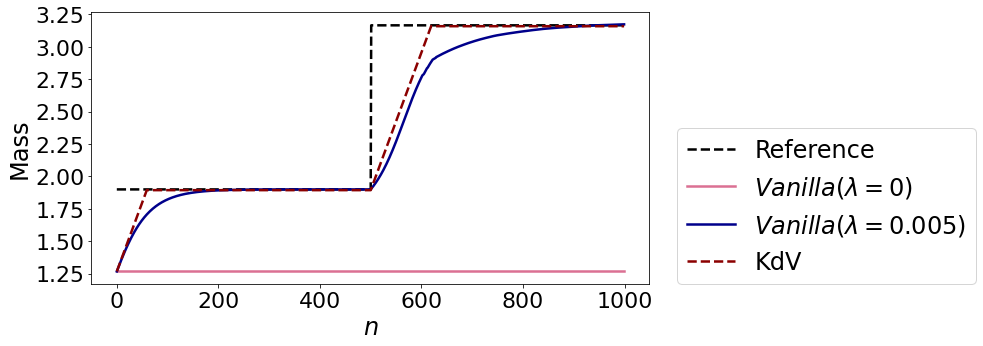

In [13]:


plt.figure(figsize=(10, 5))
plt.plot(mass_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)


plt.plot(
    vanilla_kdv_opt_mass_0,
    label=r"$Vanilla(\lambda = 0)$", 
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    vanilla_kdv_opt_mass_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)

plt.plot(kdv_opt_mass, label="KdV", linestyle="--", color=exact_color, linewidth=linewidth)

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Mass", fontsize=label_font)
# plt.yscale('log')
plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

print("---Track Mass Done---")


In [14]:

### Track momentum
vanilla_opt_control_momentum_0, vanilla_kdv_opt_momentum_soln_0, vanilla_results_momentum_0, vanilla_t_list_momentum_0 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0,
)
vanilla_opt_control_momentum_5, vanilla_kdv_opt_momentum_soln_5, vanilla_results_momentum_5, vanilla_t_list_momentum_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)




Processing time steps:   0%|          | 1/989 [01:29<24:29:41, 89.25s/it]

*** current time *** 0
optimize time:  89.25109457969666


Processing time steps:   0%|          | 2/989 [01:29<10:11:18, 37.16s/it]

*** current time *** 1
optimize time:  0.6961057186126709


Processing time steps:   0%|          | 3/989 [01:30<5:37:19, 20.53s/it] 

*** current time *** 2
optimize time:  0.7285358905792236


Processing time steps:   0%|          | 4/989 [01:31<3:28:30, 12.70s/it]

*** current time *** 3
optimize time:  0.7018866539001465


Processing time steps:   1%|          | 5/989 [01:32<2:17:23,  8.38s/it]

*** current time *** 4
optimize time:  0.7098438739776611


Processing time steps:   1%|          | 6/989 [01:32<1:34:25,  5.76s/it]

*** current time *** 5
optimize time:  0.6871283054351807


Processing time steps:   1%|          | 7/989 [01:33<1:07:17,  4.11s/it]

*** current time *** 6
optimize time:  0.7066402435302734


Processing time steps:   1%|          | 8/989 [01:34<49:32,  3.03s/it]  

*** current time *** 7
optimize time:  0.7143492698669434


Processing time steps:   1%|          | 9/989 [01:34<37:35,  2.30s/it]

*** current time *** 8
optimize time:  0.6963200569152832


Processing time steps:   1%|          | 10/989 [01:35<29:38,  1.82s/it]

*** current time *** 9
optimize time:  0.7309539318084717


Processing time steps:   1%|          | 11/989 [01:36<24:22,  1.50s/it]

*** current time *** 10
optimize time:  0.7650578022003174


Processing time steps:   1%|          | 12/989 [01:37<20:32,  1.26s/it]

*** current time *** 11
optimize time:  0.7240827083587646


Processing time steps:   1%|▏         | 13/989 [01:37<17:45,  1.09s/it]

*** current time *** 12
optimize time:  0.6977207660675049


Processing time steps:   1%|▏         | 14/989 [01:38<16:14,  1.00it/s]

*** current time *** 13
optimize time:  0.7832248210906982


Processing time steps:   2%|▏         | 15/989 [01:39<15:09,  1.07it/s]

*** current time *** 14
optimize time:  0.7790658473968506


Processing time steps:   2%|▏         | 16/989 [01:40<14:27,  1.12it/s]

*** current time *** 15
optimize time:  0.7913675308227539


Processing time steps:   2%|▏         | 17/989 [01:40<13:51,  1.17it/s]

*** current time *** 16
optimize time:  0.7676162719726562


Processing time steps:   2%|▏         | 18/989 [01:41<13:07,  1.23it/s]

*** current time *** 17
optimize time:  0.7062604427337646


Processing time steps:   2%|▏         | 19/989 [01:42<12:39,  1.28it/s]

*** current time *** 18
optimize time:  0.7142009735107422


Processing time steps:   2%|▏         | 20/989 [01:43<12:19,  1.31it/s]

*** current time *** 19
optimize time:  0.7160508632659912


Processing time steps:   2%|▏         | 21/989 [01:43<12:08,  1.33it/s]

*** current time *** 20
optimize time:  0.727046012878418


Processing time steps:   2%|▏         | 22/989 [01:44<12:14,  1.32it/s]

*** current time *** 21
optimize time:  0.7726101875305176


Processing time steps:   2%|▏         | 23/989 [01:45<12:19,  1.31it/s]

*** current time *** 22
optimize time:  0.7772994041442871


Processing time steps:   2%|▏         | 24/989 [01:46<12:27,  1.29it/s]

*** current time *** 23
optimize time:  0.7936122417449951


Processing time steps:   3%|▎         | 25/989 [01:46<12:12,  1.32it/s]

*** current time *** 24
optimize time:  0.7245776653289795


Processing time steps:   3%|▎         | 26/989 [01:47<11:54,  1.35it/s]

*** current time *** 25
optimize time:  0.6970536708831787


Processing time steps:   3%|▎         | 27/989 [01:48<11:50,  1.35it/s]

*** current time *** 26
optimize time:  0.7274067401885986


Processing time steps:   3%|▎         | 28/989 [01:49<11:40,  1.37it/s]

*** current time *** 27
optimize time:  0.7040071487426758


Processing time steps:   3%|▎         | 29/989 [01:49<11:43,  1.37it/s]

*** current time *** 28
optimize time:  0.7386972904205322


Processing time steps:   3%|▎         | 30/989 [01:50<11:47,  1.36it/s]

*** current time *** 29
optimize time:  0.7479186058044434


Processing time steps:   3%|▎         | 31/989 [01:51<12:11,  1.31it/s]

*** current time *** 30
optimize time:  0.8226654529571533


Processing time steps:   3%|▎         | 32/989 [01:52<12:17,  1.30it/s]

*** current time *** 31
optimize time:  0.7820167541503906


Processing time steps:   3%|▎         | 33/989 [01:52<12:19,  1.29it/s]

*** current time *** 32
optimize time:  0.7788448333740234


Processing time steps:   3%|▎         | 34/989 [01:53<12:21,  1.29it/s]

*** current time *** 33
optimize time:  0.7798962593078613


Processing time steps:   4%|▎         | 35/989 [01:54<12:18,  1.29it/s]

*** current time *** 34
optimize time:  0.7687270641326904


Processing time steps:   4%|▎         | 36/989 [01:55<12:11,  1.30it/s]

*** current time *** 35
optimize time:  0.7476911544799805


Processing time steps:   4%|▎         | 37/989 [01:55<11:54,  1.33it/s]

*** current time *** 36
optimize time:  0.709202766418457


Processing time steps:   4%|▍         | 38/989 [01:56<11:43,  1.35it/s]

*** current time *** 37
optimize time:  0.7130064964294434


Processing time steps:   4%|▍         | 39/989 [01:57<11:35,  1.37it/s]

*** current time *** 38
optimize time:  0.7112033367156982


Processing time steps:   4%|▍         | 40/989 [01:58<11:27,  1.38it/s]

*** current time *** 39
optimize time:  0.7029299736022949


Processing time steps:   4%|▍         | 41/989 [01:58<11:15,  1.40it/s]

*** current time *** 40
optimize time:  0.6820511817932129


Processing time steps:   4%|▍         | 42/989 [01:59<11:16,  1.40it/s]

*** current time *** 41
optimize time:  0.7182512283325195


Processing time steps:   4%|▍         | 43/989 [02:00<11:10,  1.41it/s]

*** current time *** 42
optimize time:  0.6926662921905518


Processing time steps:   4%|▍         | 44/989 [02:00<11:10,  1.41it/s]

*** current time *** 43
optimize time:  0.7109470367431641


Processing time steps:   5%|▍         | 45/989 [02:01<11:10,  1.41it/s]

*** current time *** 44
optimize time:  0.7094199657440186


Processing time steps:   5%|▍         | 46/989 [02:02<11:13,  1.40it/s]

*** current time *** 45
optimize time:  0.7216358184814453


Processing time steps:   5%|▍         | 47/989 [02:03<11:12,  1.40it/s]

*** current time *** 46
optimize time:  0.7095522880554199


Processing time steps:   5%|▍         | 48/989 [02:03<11:12,  1.40it/s]

*** current time *** 47
optimize time:  0.7148392200469971


Processing time steps:   5%|▍         | 49/989 [02:04<11:14,  1.39it/s]

*** current time *** 48
optimize time:  0.7211098670959473


Processing time steps:   5%|▌         | 50/989 [02:05<11:05,  1.41it/s]

*** current time *** 49
optimize time:  0.6870157718658447


Processing time steps:   5%|▌         | 51/989 [02:05<11:08,  1.40it/s]

*** current time *** 50
optimize time:  0.7200138568878174


Processing time steps:   5%|▌         | 52/989 [02:06<11:02,  1.41it/s]

*** current time *** 51
optimize time:  0.6921608448028564


Processing time steps:   5%|▌         | 53/989 [02:07<11:04,  1.41it/s]

*** current time *** 52
optimize time:  0.7148549556732178


Processing time steps:   5%|▌         | 54/989 [02:08<11:05,  1.41it/s]

*** current time *** 53
optimize time:  0.7126274108886719


Processing time steps:   6%|▌         | 55/989 [02:08<11:07,  1.40it/s]

*** current time *** 54
optimize time:  0.7175166606903076


Processing time steps:   6%|▌         | 56/989 [02:09<11:05,  1.40it/s]

*** current time *** 55
optimize time:  0.707672119140625


Processing time steps:   6%|▌         | 57/989 [02:10<11:04,  1.40it/s]

*** current time *** 56
optimize time:  0.7115483283996582


Processing time steps:   6%|▌         | 58/989 [02:10<11:01,  1.41it/s]

*** current time *** 57
optimize time:  0.7030470371246338


Processing time steps:   6%|▌         | 59/989 [02:11<10:58,  1.41it/s]

*** current time *** 58
optimize time:  0.700282096862793


Processing time steps:   6%|▌         | 60/989 [02:12<11:02,  1.40it/s]

*** current time *** 59
optimize time:  0.7207226753234863


Processing time steps:   6%|▌         | 61/989 [02:13<11:21,  1.36it/s]

*** current time *** 60
optimize time:  0.7813229560852051


Processing time steps:   6%|▋         | 62/989 [02:13<11:37,  1.33it/s]

*** current time *** 61
optimize time:  0.7945499420166016


Processing time steps:   6%|▋         | 63/989 [02:14<11:23,  1.35it/s]

*** current time *** 62
optimize time:  0.7010397911071777


Processing time steps:   6%|▋         | 64/989 [02:15<11:42,  1.32it/s]

*** current time *** 63
optimize time:  0.8050220012664795


Processing time steps:   7%|▋         | 65/989 [02:16<11:30,  1.34it/s]

*** current time *** 64
optimize time:  0.7152423858642578


Processing time steps:   7%|▋         | 66/989 [02:16<11:22,  1.35it/s]

*** current time *** 65
optimize time:  0.720757246017456


Processing time steps:   7%|▋         | 67/989 [02:17<11:09,  1.38it/s]

*** current time *** 66
optimize time:  0.6905598640441895


Processing time steps:   7%|▋         | 68/989 [02:18<11:40,  1.31it/s]

*** current time *** 67
optimize time:  0.8407025337219238


Processing time steps:   7%|▋         | 69/989 [02:19<11:53,  1.29it/s]

*** current time *** 68
optimize time:  0.8083300590515137


Processing time steps:   7%|▋         | 70/989 [02:19<11:36,  1.32it/s]

*** current time *** 69
optimize time:  0.7121613025665283


Processing time steps:   7%|▋         | 71/989 [02:20<11:25,  1.34it/s]

*** current time *** 70
optimize time:  0.7193832397460938


Processing time steps:   7%|▋         | 72/989 [02:21<11:14,  1.36it/s]

*** current time *** 71
optimize time:  0.7088131904602051


Processing time steps:   7%|▋         | 73/989 [02:22<11:00,  1.39it/s]

*** current time *** 72
optimize time:  0.6849067211151123


Processing time steps:   7%|▋         | 74/989 [02:22<10:55,  1.40it/s]

*** current time *** 73
optimize time:  0.7027418613433838


Processing time steps:   8%|▊         | 75/989 [02:23<10:54,  1.40it/s]

*** current time *** 74
optimize time:  0.7134294509887695


Processing time steps:   8%|▊         | 76/989 [02:24<11:08,  1.37it/s]

*** current time *** 75
optimize time:  0.7661786079406738


Processing time steps:   8%|▊         | 77/989 [02:24<10:54,  1.39it/s]

*** current time *** 76
optimize time:  0.6828374862670898


Processing time steps:   8%|▊         | 78/989 [02:25<10:49,  1.40it/s]

*** current time *** 77
optimize time:  0.6994307041168213


Processing time steps:   8%|▊         | 79/989 [02:26<10:45,  1.41it/s]

*** current time *** 78
optimize time:  0.6987807750701904


Processing time steps:   8%|▊         | 80/989 [02:26<10:42,  1.41it/s]

*** current time *** 79
optimize time:  0.6992321014404297


Processing time steps:   8%|▊         | 81/989 [02:27<10:40,  1.42it/s]

*** current time *** 80
optimize time:  0.6984455585479736


Processing time steps:   8%|▊         | 82/989 [02:28<10:46,  1.40it/s]

*** current time *** 81
optimize time:  0.726975679397583


Processing time steps:   8%|▊         | 83/989 [02:29<10:41,  1.41it/s]

*** current time *** 82
optimize time:  0.6960017681121826


Processing time steps:   8%|▊         | 84/989 [02:29<10:37,  1.42it/s]

*** current time *** 83
optimize time:  0.6924991607666016


Processing time steps:   9%|▊         | 85/989 [02:30<10:39,  1.41it/s]

*** current time *** 84
optimize time:  0.7143285274505615


Processing time steps:   9%|▊         | 86/989 [02:31<10:39,  1.41it/s]

*** current time *** 85
optimize time:  0.7082207202911377


Processing time steps:   9%|▉         | 87/989 [02:31<10:41,  1.41it/s]

*** current time *** 86
optimize time:  0.7165322303771973


Processing time steps:   9%|▉         | 88/989 [02:32<10:41,  1.40it/s]

*** current time *** 87
optimize time:  0.7121975421905518


Processing time steps:   9%|▉         | 89/989 [02:33<10:32,  1.42it/s]

*** current time *** 88
optimize time:  0.679004430770874


Processing time steps:   9%|▉         | 90/989 [02:34<10:29,  1.43it/s]

*** current time *** 89
optimize time:  0.6901874542236328


Processing time steps:   9%|▉         | 91/989 [02:34<11:25,  1.31it/s]

*** current time *** 90
optimize time:  0.9075422286987305


Processing time steps:   9%|▉         | 92/989 [02:35<11:59,  1.25it/s]

*** current time *** 91
optimize time:  0.8919901847839355


Processing time steps:   9%|▉         | 93/989 [02:36<11:58,  1.25it/s]

*** current time *** 92
optimize time:  0.7965810298919678


Processing time steps:  10%|▉         | 94/989 [02:37<11:46,  1.27it/s]

*** current time *** 93
optimize time:  0.7598035335540771


Processing time steps:  10%|▉         | 95/989 [02:38<11:21,  1.31it/s]

*** current time *** 94
optimize time:  0.6963107585906982


Processing time steps:  10%|▉         | 96/989 [02:38<11:03,  1.35it/s]

*** current time *** 95
optimize time:  0.6943955421447754


Processing time steps:  10%|▉         | 97/989 [02:39<10:53,  1.36it/s]

*** current time *** 96
optimize time:  0.7092254161834717


Processing time steps:  10%|▉         | 98/989 [02:40<10:43,  1.38it/s]

*** current time *** 97
optimize time:  0.694828987121582


Processing time steps:  10%|█         | 99/989 [02:40<10:39,  1.39it/s]

*** current time *** 98
optimize time:  0.7065982818603516


Processing time steps:  10%|█         | 100/989 [02:41<10:33,  1.40it/s]

*** current time *** 99
optimize time:  0.6997144222259521


Processing time steps:  10%|█         | 101/989 [02:42<10:31,  1.41it/s]

*** current time *** 100
optimize time:  0.7029261589050293


Processing time steps:  10%|█         | 102/989 [02:43<11:08,  1.33it/s]

*** current time *** 101
optimize time:  0.8526549339294434


Processing time steps:  10%|█         | 103/989 [02:44<12:18,  1.20it/s]

*** current time *** 102
optimize time:  1.0177206993103027


Processing time steps:  11%|█         | 104/989 [02:44<11:47,  1.25it/s]

*** current time *** 103
optimize time:  0.7175908088684082


Processing time steps:  11%|█         | 105/989 [02:45<11:23,  1.29it/s]

*** current time *** 104
optimize time:  0.7081999778747559


Processing time steps:  11%|█         | 106/989 [02:46<11:08,  1.32it/s]

*** current time *** 105
optimize time:  0.719775915145874


Processing time steps:  11%|█         | 107/989 [02:47<11:50,  1.24it/s]

*** current time *** 106
optimize time:  0.9163885116577148


Processing time steps:  11%|█         | 108/989 [02:48<11:53,  1.24it/s]

*** current time *** 107
optimize time:  0.8160800933837891


Processing time steps:  11%|█         | 109/989 [02:48<11:25,  1.28it/s]

*** current time *** 108
optimize time:  0.7046740055084229


Processing time steps:  11%|█         | 110/989 [02:49<11:05,  1.32it/s]

*** current time *** 109
optimize time:  0.7027177810668945


Processing time steps:  11%|█         | 111/989 [02:50<10:52,  1.35it/s]

*** current time *** 110
optimize time:  0.7087736129760742


Processing time steps:  11%|█▏        | 112/989 [02:50<10:41,  1.37it/s]

*** current time *** 111
optimize time:  0.7036833763122559


Processing time steps:  11%|█▏        | 113/989 [02:51<10:39,  1.37it/s]

*** current time *** 112
optimize time:  0.7233180999755859


Processing time steps:  12%|█▏        | 114/989 [02:52<10:33,  1.38it/s]

*** current time *** 113
optimize time:  0.7080621719360352


Processing time steps:  12%|█▏        | 115/989 [02:53<11:49,  1.23it/s]

*** current time *** 114
optimize time:  1.0142571926116943


Processing time steps:  12%|█▏        | 116/989 [02:54<11:22,  1.28it/s]

*** current time *** 115
optimize time:  0.7097198963165283


Processing time steps:  12%|█▏        | 117/989 [02:54<11:23,  1.28it/s]

*** current time *** 116
optimize time:  0.7871768474578857


Processing time steps:  12%|█▏        | 118/989 [02:55<11:18,  1.28it/s]

*** current time *** 117
optimize time:  0.7645010948181152


Processing time steps:  12%|█▏        | 119/989 [02:56<11:13,  1.29it/s]

*** current time *** 118
optimize time:  0.7607884407043457


Processing time steps:  12%|█▏        | 120/989 [02:57<11:10,  1.30it/s]

*** current time *** 119
optimize time:  0.7639791965484619


Processing time steps:  12%|█▏        | 121/989 [02:57<11:08,  1.30it/s]

*** current time *** 120
optimize time:  0.7627675533294678


Processing time steps:  12%|█▏        | 122/989 [02:58<11:06,  1.30it/s]

*** current time *** 121
optimize time:  0.7639906406402588


Processing time steps:  12%|█▏        | 123/989 [02:59<11:04,  1.30it/s]

*** current time *** 122
optimize time:  0.763495922088623


Processing time steps:  13%|█▎        | 124/989 [03:00<11:04,  1.30it/s]

*** current time *** 123
optimize time:  0.7661242485046387


Processing time steps:  13%|█▎        | 125/989 [03:01<11:02,  1.30it/s]

*** current time *** 124
optimize time:  0.7636551856994629


Processing time steps:  13%|█▎        | 126/989 [03:01<11:02,  1.30it/s]

*** current time *** 125
optimize time:  0.7680554389953613


Processing time steps:  13%|█▎        | 127/989 [03:02<11:01,  1.30it/s]

*** current time *** 126
optimize time:  0.7622132301330566


Processing time steps:  13%|█▎        | 128/989 [03:03<11:00,  1.30it/s]

*** current time *** 127
optimize time:  0.765167236328125


Processing time steps:  13%|█▎        | 129/989 [03:04<10:58,  1.31it/s]

*** current time *** 128
optimize time:  0.7614943981170654


Processing time steps:  13%|█▎        | 130/989 [03:04<10:58,  1.31it/s]

*** current time *** 129
optimize time:  0.764089822769165


Processing time steps:  13%|█▎        | 131/989 [03:05<10:57,  1.31it/s]

*** current time *** 130
optimize time:  0.7626047134399414


Processing time steps:  13%|█▎        | 132/989 [03:06<10:56,  1.31it/s]

*** current time *** 131
optimize time:  0.7638027667999268


Processing time steps:  13%|█▎        | 133/989 [03:07<10:45,  1.33it/s]

*** current time *** 132
optimize time:  0.7243423461914062


Processing time steps:  14%|█▎        | 134/989 [03:07<10:17,  1.39it/s]

*** current time *** 133
optimize time:  0.6445276737213135


Processing time steps:  14%|█▎        | 135/989 [03:08<09:55,  1.43it/s]

*** current time *** 134
optimize time:  0.6394789218902588


Processing time steps:  14%|█▍        | 136/989 [03:09<09:41,  1.47it/s]

*** current time *** 135
optimize time:  0.6437106132507324


Processing time steps:  14%|█▍        | 137/989 [03:09<09:31,  1.49it/s]

*** current time *** 136
optimize time:  0.6410796642303467


Processing time steps:  14%|█▍        | 138/989 [03:10<10:31,  1.35it/s]

*** current time *** 137
optimize time:  0.9079709053039551


Processing time steps:  14%|█▍        | 139/989 [03:11<11:56,  1.19it/s]

*** current time *** 138
optimize time:  1.074573278427124


Processing time steps:  14%|█▍        | 140/989 [03:12<12:59,  1.09it/s]

*** current time *** 139
optimize time:  1.0930578708648682


Processing time steps:  14%|█▍        | 141/989 [03:13<13:41,  1.03it/s]

*** current time *** 140
optimize time:  1.0824134349822998


Processing time steps:  14%|█▍        | 142/989 [03:14<12:49,  1.10it/s]

*** current time *** 141
optimize time:  0.765958309173584


Processing time steps:  14%|█▍        | 143/989 [03:15<11:57,  1.18it/s]

*** current time *** 142
optimize time:  0.7050735950469971


Processing time steps:  15%|█▍        | 144/989 [03:16<11:23,  1.24it/s]

*** current time *** 143
optimize time:  0.713738203048706


Processing time steps:  15%|█▍        | 145/989 [03:16<11:00,  1.28it/s]

*** current time *** 144
optimize time:  0.721074104309082


Processing time steps:  15%|█▍        | 146/989 [03:17<10:44,  1.31it/s]

*** current time *** 145
optimize time:  0.7209377288818359


Processing time steps:  15%|█▍        | 147/989 [03:18<10:34,  1.33it/s]

*** current time *** 146
optimize time:  0.7252888679504395


Processing time steps:  15%|█▍        | 148/989 [03:18<10:35,  1.32it/s]

*** current time *** 147
optimize time:  0.7600889205932617


Processing time steps:  15%|█▌        | 149/989 [03:19<10:22,  1.35it/s]

*** current time *** 148
optimize time:  0.702124834060669


Processing time steps:  15%|█▌        | 150/989 [03:20<10:16,  1.36it/s]

*** current time *** 149
optimize time:  0.71834397315979


Processing time steps:  15%|█▌        | 151/989 [03:21<10:10,  1.37it/s]

*** current time *** 150
optimize time:  0.7107436656951904


Processing time steps:  15%|█▌        | 152/989 [03:21<10:01,  1.39it/s]

*** current time *** 151
optimize time:  0.6929328441619873


Processing time steps:  15%|█▌        | 153/989 [03:22<09:54,  1.41it/s]

*** current time *** 152
optimize time:  0.6929059028625488


Processing time steps:  16%|█▌        | 154/989 [03:23<09:57,  1.40it/s]

*** current time *** 153
optimize time:  0.7218625545501709


Processing time steps:  16%|█▌        | 155/989 [03:23<10:12,  1.36it/s]

*** current time *** 154
optimize time:  0.7778537273406982


Processing time steps:  16%|█▌        | 156/989 [03:24<10:22,  1.34it/s]

*** current time *** 155
optimize time:  0.7747616767883301


Processing time steps:  16%|█▌        | 157/989 [03:25<10:31,  1.32it/s]

*** current time *** 156
optimize time:  0.7813591957092285


Processing time steps:  16%|█▌        | 158/989 [03:26<10:34,  1.31it/s]

*** current time *** 157
optimize time:  0.77413010597229


Processing time steps:  16%|█▌        | 159/989 [03:27<10:35,  1.31it/s]

*** current time *** 158
optimize time:  0.767573356628418


Processing time steps:  16%|█▌        | 160/989 [03:27<10:39,  1.30it/s]

*** current time *** 159
optimize time:  0.7828836441040039


Processing time steps:  16%|█▋        | 161/989 [03:28<10:38,  1.30it/s]

*** current time *** 160
optimize time:  0.7698273658752441


Processing time steps:  16%|█▋        | 162/989 [03:29<10:40,  1.29it/s]

*** current time *** 161
optimize time:  0.7767903804779053


Processing time steps:  16%|█▋        | 163/989 [03:30<10:37,  1.29it/s]

*** current time *** 162
optimize time:  0.7656311988830566


Processing time steps:  17%|█▋        | 164/989 [03:30<10:39,  1.29it/s]

*** current time *** 163
optimize time:  0.7783844470977783


Processing time steps:  17%|█▋        | 165/989 [03:31<10:46,  1.27it/s]

*** current time *** 164
optimize time:  0.8053560256958008


Processing time steps:  17%|█▋        | 166/989 [03:32<10:46,  1.27it/s]

*** current time *** 165
optimize time:  0.7834517955780029


Processing time steps:  17%|█▋        | 167/989 [03:33<10:47,  1.27it/s]

*** current time *** 166
optimize time:  0.7910420894622803


Processing time steps:  17%|█▋        | 168/989 [03:34<10:47,  1.27it/s]

*** current time *** 167
optimize time:  0.7887969017028809


Processing time steps:  17%|█▋        | 169/989 [03:34<10:47,  1.27it/s]

*** current time *** 168
optimize time:  0.7884881496429443


Processing time steps:  17%|█▋        | 170/989 [03:35<10:45,  1.27it/s]

*** current time *** 169
optimize time:  0.7829020023345947


Processing time steps:  17%|█▋        | 171/989 [03:36<10:34,  1.29it/s]

*** current time *** 170
optimize time:  0.7430877685546875


Processing time steps:  17%|█▋        | 172/989 [03:37<10:22,  1.31it/s]

*** current time *** 171
optimize time:  0.7277259826660156


Processing time steps:  17%|█▋        | 173/989 [03:38<10:42,  1.27it/s]

*** current time *** 172
optimize time:  0.8451025485992432


Processing time steps:  18%|█▊        | 174/989 [03:38<11:06,  1.22it/s]

*** current time *** 173
optimize time:  0.8876161575317383


Processing time steps:  18%|█▊        | 175/989 [03:39<11:36,  1.17it/s]

*** current time *** 174
optimize time:  0.9403705596923828


Processing time steps:  18%|█▊        | 176/989 [03:40<11:43,  1.16it/s]

*** current time *** 175
optimize time:  0.8864181041717529


Processing time steps:  18%|█▊        | 177/989 [03:41<11:22,  1.19it/s]

*** current time *** 176
optimize time:  0.7783560752868652


Processing time steps:  18%|█▊        | 178/989 [03:42<10:53,  1.24it/s]

*** current time *** 177
optimize time:  0.7216494083404541


Processing time steps:  18%|█▊        | 179/989 [03:43<10:29,  1.29it/s]

*** current time *** 178
optimize time:  0.7074315547943115


Processing time steps:  18%|█▊        | 180/989 [03:43<10:15,  1.32it/s]

*** current time *** 179
optimize time:  0.7198624610900879


Processing time steps:  18%|█▊        | 181/989 [03:44<10:11,  1.32it/s]

*** current time *** 180
optimize time:  0.7476184368133545


Processing time steps:  18%|█▊        | 182/989 [03:45<10:23,  1.29it/s]

*** current time *** 181
optimize time:  0.8059713840484619


Processing time steps:  19%|█▊        | 183/989 [03:46<10:21,  1.30it/s]

*** current time *** 182
optimize time:  0.7627983093261719


Processing time steps:  19%|█▊        | 184/989 [03:46<10:03,  1.33it/s]

*** current time *** 183
optimize time:  0.6982369422912598


Processing time steps:  19%|█▊        | 185/989 [03:47<10:05,  1.33it/s]

*** current time *** 184
optimize time:  0.7587628364562988


Processing time steps:  19%|█▉        | 186/989 [03:48<10:19,  1.30it/s]

*** current time *** 185
optimize time:  0.8109149932861328


Processing time steps:  19%|█▉        | 187/989 [03:49<10:11,  1.31it/s]

*** current time *** 186
optimize time:  0.7420215606689453


Processing time steps:  19%|█▉        | 188/989 [03:49<09:56,  1.34it/s]

*** current time *** 187
optimize time:  0.6994340419769287


Processing time steps:  19%|█▉        | 189/989 [03:50<09:50,  1.35it/s]

*** current time *** 188
optimize time:  0.7215988636016846


Processing time steps:  19%|█▉        | 190/989 [03:51<09:43,  1.37it/s]

*** current time *** 189
optimize time:  0.7091925144195557


Processing time steps:  19%|█▉        | 191/989 [03:51<09:32,  1.39it/s]

*** current time *** 190
optimize time:  0.6830089092254639


Processing time steps:  19%|█▉        | 192/989 [03:52<09:22,  1.42it/s]

*** current time *** 191
optimize time:  0.6765124797821045


Processing time steps:  20%|█▉        | 193/989 [03:53<09:22,  1.41it/s]

*** current time *** 192
optimize time:  0.7093498706817627


Processing time steps:  20%|█▉        | 194/989 [03:54<09:42,  1.36it/s]

*** current time *** 193
optimize time:  0.791698694229126


Processing time steps:  20%|█▉        | 195/989 [03:54<09:38,  1.37it/s]

*** current time *** 194
optimize time:  0.717160701751709


Processing time steps:  20%|█▉        | 196/989 [03:55<09:31,  1.39it/s]

*** current time *** 195
optimize time:  0.6982142925262451


Processing time steps:  20%|█▉        | 197/989 [03:56<09:35,  1.38it/s]

*** current time *** 196
optimize time:  0.7384107112884521


Processing time steps:  20%|██        | 198/989 [03:56<09:26,  1.40it/s]

*** current time *** 197
optimize time:  0.6891021728515625


Processing time steps:  20%|██        | 199/989 [03:57<09:28,  1.39it/s]

*** current time *** 198
optimize time:  0.7247817516326904


Processing time steps:  20%|██        | 200/989 [03:58<09:22,  1.40it/s]

*** current time *** 199
optimize time:  0.69535231590271


Processing time steps:  20%|██        | 201/989 [03:59<09:39,  1.36it/s]

*** current time *** 200
optimize time:  0.7877190113067627


Processing time steps:  20%|██        | 202/989 [03:59<09:50,  1.33it/s]

*** current time *** 201
optimize time:  0.782691240310669


Processing time steps:  21%|██        | 203/989 [04:00<09:56,  1.32it/s]

*** current time *** 202
optimize time:  0.7777740955352783


Processing time steps:  21%|██        | 204/989 [04:01<10:02,  1.30it/s]

*** current time *** 203
optimize time:  0.7823224067687988


Processing time steps:  21%|██        | 205/989 [04:02<10:00,  1.31it/s]

*** current time *** 204
optimize time:  0.761082649230957


Processing time steps:  21%|██        | 206/989 [04:03<10:07,  1.29it/s]

*** current time *** 205
optimize time:  0.7956302165985107


Processing time steps:  21%|██        | 207/989 [04:03<10:06,  1.29it/s]

*** current time *** 206
optimize time:  0.773216962814331


Processing time steps:  21%|██        | 208/989 [04:04<10:06,  1.29it/s]

*** current time *** 207
optimize time:  0.7777831554412842


Processing time steps:  21%|██        | 209/989 [04:05<09:52,  1.32it/s]

*** current time *** 208
optimize time:  0.7164256572723389


Processing time steps:  21%|██        | 210/989 [04:06<09:42,  1.34it/s]

*** current time *** 209
optimize time:  0.7169044017791748


Processing time steps:  21%|██▏       | 211/989 [04:06<09:26,  1.37it/s]

*** current time *** 210
optimize time:  0.6819708347320557


Processing time steps:  21%|██▏       | 212/989 [04:07<09:24,  1.38it/s]

*** current time *** 211
optimize time:  0.7204897403717041


Processing time steps:  22%|██▏       | 213/989 [04:08<09:14,  1.40it/s]

*** current time *** 212
optimize time:  0.6828138828277588


Processing time steps:  22%|██▏       | 214/989 [04:08<09:14,  1.40it/s]

*** current time *** 213
optimize time:  0.718602180480957


Processing time steps:  22%|██▏       | 215/989 [04:09<09:53,  1.31it/s]

*** current time *** 214
optimize time:  0.8813083171844482


Processing time steps:  22%|██▏       | 216/989 [04:10<09:54,  1.30it/s]

*** current time *** 215
optimize time:  0.7730221748352051


Processing time steps:  22%|██▏       | 217/989 [04:11<09:53,  1.30it/s]

*** current time *** 216
optimize time:  0.7655818462371826


Processing time steps:  22%|██▏       | 218/989 [04:12<09:55,  1.29it/s]

*** current time *** 217
optimize time:  0.778214693069458


Processing time steps:  22%|██▏       | 219/989 [04:12<09:52,  1.30it/s]

*** current time *** 218
optimize time:  0.7604331970214844


Processing time steps:  22%|██▏       | 220/989 [04:13<09:59,  1.28it/s]

*** current time *** 219
optimize time:  0.8001542091369629


Processing time steps:  22%|██▏       | 221/989 [04:14<10:00,  1.28it/s]

*** current time *** 220
optimize time:  0.7850878238677979


Processing time steps:  22%|██▏       | 222/989 [04:15<10:03,  1.27it/s]

*** current time *** 221
optimize time:  0.7965559959411621


Processing time steps:  23%|██▎       | 223/989 [04:15<09:54,  1.29it/s]

*** current time *** 222
optimize time:  0.7490630149841309


Processing time steps:  23%|██▎       | 224/989 [04:16<09:49,  1.30it/s]

*** current time *** 223
optimize time:  0.7556595802307129


Processing time steps:  23%|██▎       | 225/989 [04:17<10:01,  1.27it/s]

*** current time *** 224
optimize time:  0.8223574161529541


Processing time steps:  23%|██▎       | 226/989 [04:18<09:52,  1.29it/s]

*** current time *** 225
optimize time:  0.7489404678344727


Processing time steps:  23%|██▎       | 227/989 [04:19<09:40,  1.31it/s]

*** current time *** 226
optimize time:  0.727055549621582


Processing time steps:  23%|██▎       | 228/989 [04:19<09:41,  1.31it/s]

*** current time *** 227
optimize time:  0.7662081718444824


Processing time steps:  23%|██▎       | 229/989 [04:20<09:23,  1.35it/s]

*** current time *** 228
optimize time:  0.6881978511810303


Processing time steps:  23%|██▎       | 230/989 [04:21<09:14,  1.37it/s]

*** current time *** 229
optimize time:  0.6995761394500732


Processing time steps:  23%|██▎       | 231/989 [04:21<09:11,  1.37it/s]

*** current time *** 230
optimize time:  0.7195236682891846


Processing time steps:  23%|██▎       | 232/989 [04:22<09:07,  1.38it/s]

*** current time *** 231
optimize time:  0.7128589153289795


Processing time steps:  24%|██▎       | 233/989 [04:23<09:07,  1.38it/s]

*** current time *** 232
optimize time:  0.7217469215393066


Processing time steps:  24%|██▎       | 234/989 [04:24<09:04,  1.39it/s]

*** current time *** 233
optimize time:  0.7138767242431641


Processing time steps:  24%|██▍       | 235/989 [04:24<09:05,  1.38it/s]

*** current time *** 234
optimize time:  0.7243168354034424


Processing time steps:  24%|██▍       | 236/989 [04:25<09:03,  1.39it/s]

*** current time *** 235
optimize time:  0.7143001556396484


Processing time steps:  24%|██▍       | 237/989 [04:26<09:01,  1.39it/s]

*** current time *** 236
optimize time:  0.713599443435669


Processing time steps:  24%|██▍       | 238/989 [04:26<09:05,  1.38it/s]

*** current time *** 237
optimize time:  0.73758864402771


Processing time steps:  24%|██▍       | 239/989 [04:27<08:59,  1.39it/s]

*** current time *** 238
optimize time:  0.7035281658172607


Processing time steps:  24%|██▍       | 240/989 [04:28<08:58,  1.39it/s]

*** current time *** 239
optimize time:  0.7136964797973633


Processing time steps:  24%|██▍       | 241/989 [04:29<08:51,  1.41it/s]

*** current time *** 240
optimize time:  0.6876358985900879


Processing time steps:  24%|██▍       | 242/989 [04:29<08:47,  1.42it/s]

*** current time *** 241
optimize time:  0.6925661563873291


Processing time steps:  25%|██▍       | 243/989 [04:30<08:47,  1.42it/s]

*** current time *** 242
optimize time:  0.706606388092041


Processing time steps:  25%|██▍       | 244/989 [04:31<08:44,  1.42it/s]

*** current time *** 243
optimize time:  0.6969139575958252


Processing time steps:  25%|██▍       | 245/989 [04:31<08:46,  1.41it/s]

*** current time *** 244
optimize time:  0.7131640911102295


Processing time steps:  25%|██▍       | 246/989 [04:32<08:48,  1.41it/s]

*** current time *** 245
optimize time:  0.7152032852172852


Processing time steps:  25%|██▍       | 247/989 [04:33<08:50,  1.40it/s]

*** current time *** 246
optimize time:  0.7210793495178223


Processing time steps:  25%|██▌       | 248/989 [04:34<08:54,  1.39it/s]

*** current time *** 247
optimize time:  0.7325408458709717


Processing time steps:  25%|██▌       | 249/989 [04:34<08:49,  1.40it/s]

*** current time *** 248
optimize time:  0.7015035152435303


Processing time steps:  25%|██▌       | 250/989 [04:35<08:52,  1.39it/s]

*** current time *** 249
optimize time:  0.7322442531585693


Processing time steps:  25%|██▌       | 251/989 [04:36<08:49,  1.39it/s]

*** current time *** 250
optimize time:  0.7071075439453125


Processing time steps:  25%|██▌       | 252/989 [04:36<08:51,  1.39it/s]

*** current time *** 251
optimize time:  0.7281763553619385


Processing time steps:  26%|██▌       | 253/989 [04:37<08:47,  1.39it/s]

*** current time *** 252
optimize time:  0.7053475379943848


Processing time steps:  26%|██▌       | 254/989 [04:38<08:50,  1.39it/s]

*** current time *** 253
optimize time:  0.7306909561157227


Processing time steps:  26%|██▌       | 255/989 [04:39<08:45,  1.40it/s]

*** current time *** 254
optimize time:  0.6995499134063721


Processing time steps:  26%|██▌       | 256/989 [04:39<08:45,  1.40it/s]

*** current time *** 255
optimize time:  0.715540885925293


Processing time steps:  26%|██▌       | 257/989 [04:40<08:38,  1.41it/s]

*** current time *** 256
optimize time:  0.689288854598999


Processing time steps:  26%|██▌       | 258/989 [04:41<08:42,  1.40it/s]

*** current time *** 257
optimize time:  0.7268435955047607


Processing time steps:  26%|██▌       | 259/989 [04:41<08:40,  1.40it/s]

*** current time *** 258
optimize time:  0.7050085067749023


Processing time steps:  26%|██▋       | 260/989 [04:42<08:42,  1.39it/s]

*** current time *** 259
optimize time:  0.7264256477355957


Processing time steps:  26%|██▋       | 261/989 [04:43<08:38,  1.40it/s]

*** current time *** 260
optimize time:  0.697930097579956


Processing time steps:  26%|██▋       | 262/989 [04:44<08:39,  1.40it/s]

*** current time *** 261
optimize time:  0.7165756225585938


Processing time steps:  27%|██▋       | 263/989 [04:44<08:38,  1.40it/s]

*** current time *** 262
optimize time:  0.7139108180999756


Processing time steps:  27%|██▋       | 264/989 [04:45<08:41,  1.39it/s]

*** current time *** 263
optimize time:  0.7257521152496338


Processing time steps:  27%|██▋       | 265/989 [04:46<08:39,  1.39it/s]

*** current time *** 264
optimize time:  0.7113959789276123


Processing time steps:  27%|██▋       | 266/989 [04:46<08:44,  1.38it/s]

*** current time *** 265
optimize time:  0.7407567501068115


Processing time steps:  27%|██▋       | 267/989 [04:47<08:48,  1.37it/s]

*** current time *** 266
optimize time:  0.7478160858154297


Processing time steps:  27%|██▋       | 268/989 [04:48<09:03,  1.33it/s]

*** current time *** 267
optimize time:  0.7996208667755127


Processing time steps:  27%|██▋       | 269/989 [04:49<09:10,  1.31it/s]

*** current time *** 268
optimize time:  0.7892508506774902


Processing time steps:  27%|██▋       | 270/989 [04:50<09:14,  1.30it/s]

*** current time *** 269
optimize time:  0.7829992771148682


Processing time steps:  27%|██▋       | 271/989 [04:50<09:15,  1.29it/s]

*** current time *** 270
optimize time:  0.7770819664001465


Processing time steps:  28%|██▊       | 272/989 [04:51<09:12,  1.30it/s]

*** current time *** 271
optimize time:  0.7594950199127197


Processing time steps:  28%|██▊       | 273/989 [04:52<08:55,  1.34it/s]

*** current time *** 272
optimize time:  0.6953375339508057


Processing time steps:  28%|██▊       | 274/989 [04:53<08:44,  1.36it/s]

*** current time *** 273
optimize time:  0.6976809501647949


Processing time steps:  28%|██▊       | 275/989 [04:53<08:38,  1.38it/s]

*** current time *** 274
optimize time:  0.7080254554748535


Processing time steps:  28%|██▊       | 276/989 [04:54<08:38,  1.38it/s]

*** current time *** 275
optimize time:  0.7249298095703125


Processing time steps:  28%|██▊       | 277/989 [04:55<08:33,  1.39it/s]

*** current time *** 276
optimize time:  0.7077879905700684


Processing time steps:  28%|██▊       | 278/989 [04:55<08:32,  1.39it/s]

*** current time *** 277
optimize time:  0.7160763740539551


Processing time steps:  28%|██▊       | 279/989 [04:56<08:31,  1.39it/s]

*** current time *** 278
optimize time:  0.719536304473877


Processing time steps:  28%|██▊       | 280/989 [04:57<08:26,  1.40it/s]

*** current time *** 279
optimize time:  0.6994664669036865


Processing time steps:  28%|██▊       | 281/989 [04:58<08:23,  1.41it/s]

*** current time *** 280
optimize time:  0.700507640838623


Processing time steps:  29%|██▊       | 282/989 [04:58<08:28,  1.39it/s]

*** current time *** 281
optimize time:  0.7353250980377197


Processing time steps:  29%|██▊       | 283/989 [04:59<08:38,  1.36it/s]

*** current time *** 282
optimize time:  0.7667031288146973


Processing time steps:  29%|██▊       | 284/989 [05:00<08:37,  1.36it/s]

*** current time *** 283
optimize time:  0.7318429946899414


Processing time steps:  29%|██▉       | 285/989 [05:01<08:38,  1.36it/s]

*** current time *** 284
optimize time:  0.7408149242401123


Processing time steps:  29%|██▉       | 286/989 [05:01<08:36,  1.36it/s]

*** current time *** 285
optimize time:  0.7263162136077881


Processing time steps:  29%|██▉       | 287/989 [05:02<08:29,  1.38it/s]

*** current time *** 286
optimize time:  0.7051968574523926


Processing time steps:  29%|██▉       | 288/989 [05:03<08:33,  1.37it/s]

*** current time *** 287
optimize time:  0.7440156936645508


Processing time steps:  29%|██▉       | 289/989 [05:03<08:32,  1.37it/s]

*** current time *** 288
optimize time:  0.7290399074554443


Processing time steps:  29%|██▉       | 290/989 [05:04<08:39,  1.35it/s]

*** current time *** 289
optimize time:  0.7668609619140625


Processing time steps:  29%|██▉       | 291/989 [05:05<08:38,  1.35it/s]

*** current time *** 290
optimize time:  0.7390868663787842


Processing time steps:  30%|██▉       | 292/989 [05:06<08:47,  1.32it/s]

*** current time *** 291
optimize time:  0.7867894172668457


Processing time steps:  30%|██▉       | 293/989 [05:06<08:43,  1.33it/s]

*** current time *** 292
optimize time:  0.7369554042816162


Processing time steps:  30%|██▉       | 294/989 [05:07<08:37,  1.34it/s]

*** current time *** 293
optimize time:  0.7267563343048096


Processing time steps:  30%|██▉       | 295/989 [05:08<08:30,  1.36it/s]

*** current time *** 294
optimize time:  0.709744930267334


Processing time steps:  30%|██▉       | 296/989 [05:09<08:24,  1.37it/s]

*** current time *** 295
optimize time:  0.7087609767913818


Processing time steps:  30%|███       | 297/989 [05:09<08:18,  1.39it/s]

*** current time *** 296
optimize time:  0.7015154361724854


Processing time steps:  30%|███       | 298/989 [05:10<08:30,  1.35it/s]

*** current time *** 297
optimize time:  0.7808980941772461


Processing time steps:  30%|███       | 299/989 [05:11<08:31,  1.35it/s]

*** current time *** 298
optimize time:  0.7437634468078613


Processing time steps:  30%|███       | 300/989 [05:12<08:15,  1.39it/s]

*** current time *** 299
optimize time:  0.6656661033630371


Processing time steps:  30%|███       | 301/989 [05:12<08:02,  1.43it/s]

*** current time *** 300
optimize time:  0.6571474075317383


Processing time steps:  31%|███       | 302/989 [05:13<07:53,  1.45it/s]

*** current time *** 301
optimize time:  0.6569643020629883


Processing time steps:  31%|███       | 303/989 [05:14<07:46,  1.47it/s]

*** current time *** 302
optimize time:  0.6596410274505615


Processing time steps:  31%|███       | 304/989 [05:14<07:39,  1.49it/s]

*** current time *** 303
optimize time:  0.6478345394134521


Processing time steps:  31%|███       | 305/989 [05:15<07:35,  1.50it/s]

*** current time *** 304
optimize time:  0.6508619785308838


Processing time steps:  31%|███       | 306/989 [05:15<07:31,  1.51it/s]

*** current time *** 305
optimize time:  0.6493945121765137


Processing time steps:  31%|███       | 307/989 [05:16<07:29,  1.52it/s]

*** current time *** 306
optimize time:  0.6506056785583496


Processing time steps:  31%|███       | 308/989 [05:17<07:27,  1.52it/s]

*** current time *** 307
optimize time:  0.6511213779449463


Processing time steps:  31%|███       | 309/989 [05:17<07:25,  1.53it/s]

*** current time *** 308
optimize time:  0.6484344005584717


Processing time steps:  31%|███▏      | 310/989 [05:18<07:23,  1.53it/s]

*** current time *** 309
optimize time:  0.6471669673919678


Processing time steps:  31%|███▏      | 311/989 [05:19<07:22,  1.53it/s]

*** current time *** 310
optimize time:  0.6513044834136963


Processing time steps:  32%|███▏      | 312/989 [05:19<07:20,  1.54it/s]

*** current time *** 311
optimize time:  0.6449382305145264


Processing time steps:  32%|███▏      | 313/989 [05:20<07:20,  1.53it/s]

*** current time *** 312
optimize time:  0.6512501239776611


Processing time steps:  32%|███▏      | 314/989 [05:21<07:20,  1.53it/s]

*** current time *** 313
optimize time:  0.6526098251342773


Processing time steps:  32%|███▏      | 315/989 [05:21<07:18,  1.54it/s]

*** current time *** 314
optimize time:  0.6453514099121094


Processing time steps:  32%|███▏      | 316/989 [05:22<07:18,  1.54it/s]

*** current time *** 315
optimize time:  0.6503822803497314


Processing time steps:  32%|███▏      | 317/989 [05:23<07:17,  1.54it/s]

*** current time *** 316
optimize time:  0.648514986038208


Processing time steps:  32%|███▏      | 318/989 [05:23<07:16,  1.54it/s]

*** current time *** 317
optimize time:  0.6456520557403564


Processing time steps:  32%|███▏      | 319/989 [05:24<07:16,  1.54it/s]

*** current time *** 318
optimize time:  0.6524398326873779


Processing time steps:  32%|███▏      | 320/989 [05:25<07:21,  1.52it/s]

*** current time *** 319
optimize time:  0.6771590709686279


Processing time steps:  32%|███▏      | 321/989 [05:25<07:28,  1.49it/s]

*** current time *** 320
optimize time:  0.6943514347076416


Processing time steps:  33%|███▎      | 322/989 [05:26<07:39,  1.45it/s]

*** current time *** 321
optimize time:  0.7302920818328857


Processing time steps:  33%|███▎      | 323/989 [05:27<07:53,  1.41it/s]

*** current time *** 322
optimize time:  0.7584185600280762


Processing time steps:  33%|███▎      | 324/989 [05:28<08:03,  1.38it/s]

*** current time *** 323
optimize time:  0.7630751132965088


Processing time steps:  33%|███▎      | 325/989 [05:28<08:09,  1.36it/s]

*** current time *** 324
optimize time:  0.7595467567443848


Processing time steps:  33%|███▎      | 326/989 [05:29<08:16,  1.34it/s]

*** current time *** 325
optimize time:  0.7707195281982422


Processing time steps:  33%|███▎      | 327/989 [05:30<08:20,  1.32it/s]

*** current time *** 326
optimize time:  0.7690906524658203


Processing time steps:  33%|███▎      | 328/989 [05:31<08:24,  1.31it/s]

*** current time *** 327
optimize time:  0.7768568992614746


Processing time steps:  33%|███▎      | 329/989 [05:31<08:24,  1.31it/s]

*** current time *** 328
optimize time:  0.7653772830963135


Processing time steps:  33%|███▎      | 330/989 [05:32<08:27,  1.30it/s]

*** current time *** 329
optimize time:  0.7798657417297363


Processing time steps:  33%|███▎      | 331/989 [05:33<08:28,  1.29it/s]

*** current time *** 330
optimize time:  0.7767598628997803


Processing time steps:  34%|███▎      | 332/989 [05:34<08:21,  1.31it/s]

*** current time *** 331
optimize time:  0.7387874126434326


Processing time steps:  34%|███▎      | 333/989 [05:35<08:39,  1.26it/s]

*** current time *** 332
optimize time:  0.8581051826477051


Processing time steps:  34%|███▍      | 334/989 [05:35<08:17,  1.32it/s]

*** current time *** 333
optimize time:  0.6818692684173584


Processing time steps:  34%|███▍      | 335/989 [05:36<08:02,  1.36it/s]

*** current time *** 334
optimize time:  0.6842050552368164


Processing time steps:  34%|███▍      | 336/989 [05:37<07:53,  1.38it/s]

*** current time *** 335
optimize time:  0.6935627460479736


Processing time steps:  34%|███▍      | 337/989 [05:37<07:46,  1.40it/s]

*** current time *** 336
optimize time:  0.6933634281158447


Processing time steps:  34%|███▍      | 338/989 [05:38<07:39,  1.42it/s]

*** current time *** 337
optimize time:  0.6792788505554199


Processing time steps:  34%|███▍      | 339/989 [05:39<07:40,  1.41it/s]

*** current time *** 338
optimize time:  0.7106084823608398


Processing time steps:  34%|███▍      | 340/989 [05:39<07:37,  1.42it/s]

*** current time *** 339
optimize time:  0.6941637992858887


Processing time steps:  34%|███▍      | 341/989 [05:40<07:35,  1.42it/s]

*** current time *** 340
optimize time:  0.69537353515625


Processing time steps:  35%|███▍      | 342/989 [05:41<07:32,  1.43it/s]

*** current time *** 341
optimize time:  0.6894524097442627


Processing time steps:  35%|███▍      | 343/989 [05:42<07:31,  1.43it/s]

*** current time *** 342
optimize time:  0.6968958377838135


Processing time steps:  35%|███▍      | 344/989 [05:42<07:31,  1.43it/s]

*** current time *** 343
optimize time:  0.6973981857299805


Processing time steps:  35%|███▍      | 345/989 [05:43<07:47,  1.38it/s]

*** current time *** 344
optimize time:  0.785313606262207


Processing time steps:  35%|███▍      | 346/989 [05:44<07:48,  1.37it/s]

*** current time *** 345
optimize time:  0.7314226627349854


Processing time steps:  35%|███▌      | 347/989 [05:44<07:45,  1.38it/s]

*** current time *** 346
optimize time:  0.7156760692596436


Processing time steps:  35%|███▌      | 348/989 [05:45<07:47,  1.37it/s]

*** current time *** 347
optimize time:  0.7366163730621338


Processing time steps:  35%|███▌      | 349/989 [05:46<07:43,  1.38it/s]

*** current time *** 348
optimize time:  0.7094471454620361


Processing time steps:  35%|███▌      | 350/989 [05:47<07:43,  1.38it/s]

*** current time *** 349
optimize time:  0.729076623916626


Processing time steps:  35%|███▌      | 351/989 [05:47<07:38,  1.39it/s]

*** current time *** 350
optimize time:  0.7025678157806396


Processing time steps:  36%|███▌      | 352/989 [05:48<07:55,  1.34it/s]

*** current time *** 351
optimize time:  0.8058927059173584


Processing time steps:  36%|███▌      | 353/989 [05:49<07:49,  1.35it/s]

*** current time *** 352
optimize time:  0.7166738510131836


Processing time steps:  36%|███▌      | 354/989 [05:50<07:48,  1.36it/s]

*** current time *** 353
optimize time:  0.7331204414367676


Processing time steps:  36%|███▌      | 355/989 [05:50<07:43,  1.37it/s]

*** current time *** 354
optimize time:  0.7138733863830566


Processing time steps:  36%|███▌      | 356/989 [05:51<07:43,  1.37it/s]

*** current time *** 355
optimize time:  0.7323787212371826


Processing time steps:  36%|███▌      | 357/989 [05:52<07:38,  1.38it/s]

*** current time *** 356
optimize time:  0.7081093788146973


Processing time steps:  36%|███▌      | 358/989 [05:53<08:48,  1.19it/s]

*** current time *** 357
optimize time:  1.095348834991455


Processing time steps:  36%|███▋      | 359/989 [05:54<08:31,  1.23it/s]

*** current time *** 358
optimize time:  0.7499449253082275


Processing time steps:  36%|███▋      | 360/989 [05:54<08:14,  1.27it/s]

*** current time *** 359
optimize time:  0.7249526977539062


Processing time steps:  37%|███▋      | 361/989 [05:55<07:57,  1.32it/s]

*** current time *** 360
optimize time:  0.6951751708984375


Processing time steps:  37%|███▋      | 362/989 [05:56<07:49,  1.33it/s]

*** current time *** 361
optimize time:  0.7227845191955566


Processing time steps:  37%|███▋      | 363/989 [05:56<07:43,  1.35it/s]

*** current time *** 362
optimize time:  0.7175168991088867


Processing time steps:  37%|███▋      | 364/989 [05:57<07:41,  1.35it/s]

*** current time *** 363
optimize time:  0.7343466281890869


Processing time steps:  37%|███▋      | 365/989 [05:58<07:49,  1.33it/s]

*** current time *** 364
optimize time:  0.7802588939666748


Processing time steps:  37%|███▋      | 366/989 [05:59<07:55,  1.31it/s]

*** current time *** 365
optimize time:  0.787330150604248


Processing time steps:  37%|███▋      | 367/989 [06:00<07:59,  1.30it/s]

*** current time *** 366
optimize time:  0.7861373424530029


Processing time steps:  37%|███▋      | 368/989 [06:00<07:50,  1.32it/s]

*** current time *** 367
optimize time:  0.7251226902008057


Processing time steps:  37%|███▋      | 369/989 [06:01<07:39,  1.35it/s]

*** current time *** 368
optimize time:  0.6978366374969482


Processing time steps:  37%|███▋      | 370/989 [06:02<07:35,  1.36it/s]

*** current time *** 369
optimize time:  0.7246906757354736


Processing time steps:  38%|███▊      | 371/989 [06:03<08:06,  1.27it/s]

*** current time *** 370
optimize time:  0.9045515060424805


Processing time steps:  38%|███▊      | 372/989 [06:03<08:06,  1.27it/s]

*** current time *** 371
optimize time:  0.7879371643066406


Processing time steps:  38%|███▊      | 373/989 [06:04<08:01,  1.28it/s]

*** current time *** 372
optimize time:  0.7645914554595947


Processing time steps:  38%|███▊      | 374/989 [06:05<08:02,  1.27it/s]

*** current time *** 373
optimize time:  0.7866148948669434


Processing time steps:  38%|███▊      | 375/989 [06:06<07:59,  1.28it/s]

*** current time *** 374
optimize time:  0.7684862613677979


Processing time steps:  38%|███▊      | 376/989 [06:07<07:57,  1.28it/s]

*** current time *** 375
optimize time:  0.7755177021026611


Processing time steps:  38%|███▊      | 377/989 [06:07<07:53,  1.29it/s]

*** current time *** 376
optimize time:  0.757436990737915


Processing time steps:  38%|███▊      | 378/989 [06:08<07:53,  1.29it/s]

*** current time *** 377
optimize time:  0.7764003276824951


Processing time steps:  38%|███▊      | 379/989 [06:09<08:10,  1.24it/s]

*** current time *** 378
optimize time:  0.8710830211639404


Processing time steps:  38%|███▊      | 380/989 [06:10<07:51,  1.29it/s]

*** current time *** 379
optimize time:  0.7012097835540771


Processing time steps:  39%|███▊      | 381/989 [06:10<07:36,  1.33it/s]

*** current time *** 380
optimize time:  0.6933810710906982


Processing time steps:  39%|███▊      | 382/989 [06:11<07:25,  1.36it/s]

*** current time *** 381
optimize time:  0.6907634735107422


Processing time steps:  39%|███▊      | 383/989 [06:12<07:23,  1.37it/s]

*** current time *** 382
optimize time:  0.7246015071868896


Processing time steps:  39%|███▉      | 384/989 [06:13<07:20,  1.37it/s]

*** current time *** 383
optimize time:  0.7169592380523682


Processing time steps:  39%|███▉      | 385/989 [06:13<07:24,  1.36it/s]

*** current time *** 384
optimize time:  0.751244068145752


Processing time steps:  39%|███▉      | 386/989 [06:14<07:16,  1.38it/s]

*** current time *** 385
optimize time:  0.6950652599334717


Processing time steps:  39%|███▉      | 387/989 [06:15<07:08,  1.40it/s]

*** current time *** 386
optimize time:  0.6819717884063721


Processing time steps:  39%|███▉      | 388/989 [06:15<07:21,  1.36it/s]

*** current time *** 387
optimize time:  0.7855522632598877


Processing time steps:  39%|███▉      | 389/989 [06:16<07:29,  1.33it/s]

*** current time *** 388
optimize time:  0.7820644378662109


Processing time steps:  39%|███▉      | 390/989 [06:17<07:37,  1.31it/s]

*** current time *** 389
optimize time:  0.7930498123168945


Processing time steps:  40%|███▉      | 391/989 [06:18<07:31,  1.32it/s]

*** current time *** 390
optimize time:  0.7342665195465088


Processing time steps:  40%|███▉      | 392/989 [06:18<07:23,  1.35it/s]

*** current time *** 391
optimize time:  0.7113022804260254


Processing time steps:  40%|███▉      | 393/989 [06:19<07:20,  1.35it/s]

*** current time *** 392
optimize time:  0.7258303165435791


Processing time steps:  40%|███▉      | 394/989 [06:20<07:17,  1.36it/s]

*** current time *** 393
optimize time:  0.7237958908081055


Processing time steps:  40%|███▉      | 395/989 [06:21<07:16,  1.36it/s]

*** current time *** 394
optimize time:  0.7309966087341309


Processing time steps:  40%|████      | 396/989 [06:21<07:10,  1.38it/s]

*** current time *** 395
optimize time:  0.7077164649963379


Processing time steps:  40%|████      | 397/989 [06:22<07:11,  1.37it/s]

*** current time *** 396
optimize time:  0.7313487529754639


Processing time steps:  40%|████      | 398/989 [06:23<07:05,  1.39it/s]

*** current time *** 397
optimize time:  0.6964082717895508


Processing time steps:  40%|████      | 399/989 [06:24<07:05,  1.39it/s]

*** current time *** 398
optimize time:  0.7227685451507568


Processing time steps:  40%|████      | 400/989 [06:24<07:06,  1.38it/s]

*** current time *** 399
optimize time:  0.7305805683135986


Processing time steps:  41%|████      | 401/989 [06:25<07:05,  1.38it/s]

*** current time *** 400
optimize time:  0.717034101486206


Processing time steps:  41%|████      | 402/989 [06:26<07:01,  1.39it/s]

*** current time *** 401
optimize time:  0.7056221961975098


Processing time steps:  41%|████      | 403/989 [06:26<07:03,  1.38it/s]

*** current time *** 402
optimize time:  0.7292780876159668


Processing time steps:  41%|████      | 404/989 [06:27<07:05,  1.37it/s]

*** current time *** 403
optimize time:  0.7384588718414307


Processing time steps:  41%|████      | 405/989 [06:28<07:10,  1.36it/s]

*** current time *** 404
optimize time:  0.7566237449645996


Processing time steps:  41%|████      | 406/989 [06:29<07:19,  1.33it/s]

*** current time *** 405
optimize time:  0.791959285736084


Processing time steps:  41%|████      | 407/989 [06:30<07:30,  1.29it/s]

*** current time *** 406
optimize time:  0.8167831897735596


Processing time steps:  41%|████▏     | 408/989 [06:30<07:22,  1.31it/s]

*** current time *** 407
optimize time:  0.7288322448730469


Processing time steps:  41%|████▏     | 409/989 [06:31<07:10,  1.35it/s]

*** current time *** 408
optimize time:  0.6980915069580078


Processing time steps:  41%|████▏     | 410/989 [06:32<07:08,  1.35it/s]

*** current time *** 409
optimize time:  0.730299711227417


Processing time steps:  42%|████▏     | 411/989 [06:32<07:01,  1.37it/s]

*** current time *** 410
optimize time:  0.7024838924407959


Processing time steps:  42%|████▏     | 412/989 [06:33<07:01,  1.37it/s]

*** current time *** 411
optimize time:  0.7303617000579834


Processing time steps:  42%|████▏     | 413/989 [06:34<06:54,  1.39it/s]

*** current time *** 412
optimize time:  0.6950361728668213


Processing time steps:  42%|████▏     | 414/989 [06:35<06:54,  1.39it/s]

*** current time *** 413
optimize time:  0.7191863059997559


Processing time steps:  42%|████▏     | 415/989 [06:35<06:47,  1.41it/s]

*** current time *** 414
optimize time:  0.6861200332641602


Processing time steps:  42%|████▏     | 416/989 [06:36<07:04,  1.35it/s]

*** current time *** 415
optimize time:  0.808072566986084


Processing time steps:  42%|████▏     | 417/989 [06:37<07:12,  1.32it/s]

*** current time *** 416
optimize time:  0.7915103435516357


Processing time steps:  42%|████▏     | 418/989 [06:38<07:14,  1.31it/s]

*** current time *** 417
optimize time:  0.7677161693572998


Processing time steps:  42%|████▏     | 419/989 [06:38<07:18,  1.30it/s]

*** current time *** 418
optimize time:  0.787708044052124


Processing time steps:  42%|████▏     | 420/989 [06:39<07:22,  1.29it/s]

*** current time *** 419
optimize time:  0.7916278839111328


Processing time steps:  43%|████▎     | 421/989 [06:40<07:22,  1.28it/s]

*** current time *** 420
optimize time:  0.7827997207641602


Processing time steps:  43%|████▎     | 422/989 [06:41<07:23,  1.28it/s]

*** current time *** 421
optimize time:  0.783860445022583


Processing time steps:  43%|████▎     | 423/989 [06:42<07:21,  1.28it/s]

*** current time *** 422
optimize time:  0.7744011878967285


Processing time steps:  43%|████▎     | 424/989 [06:42<07:19,  1.29it/s]

*** current time *** 423
optimize time:  0.7702200412750244


Processing time steps:  43%|████▎     | 425/989 [06:43<07:18,  1.29it/s]

*** current time *** 424
optimize time:  0.7752952575683594


Processing time steps:  43%|████▎     | 426/989 [06:44<07:18,  1.29it/s]

*** current time *** 425
optimize time:  0.776421070098877


Processing time steps:  43%|████▎     | 427/989 [06:45<07:17,  1.28it/s]

*** current time *** 426
optimize time:  0.7775137424468994


Processing time steps:  43%|████▎     | 428/989 [06:45<07:16,  1.29it/s]

*** current time *** 427
optimize time:  0.7715044021606445


Processing time steps:  43%|████▎     | 429/989 [06:46<07:13,  1.29it/s]

*** current time *** 428
optimize time:  0.7656981945037842


Processing time steps:  43%|████▎     | 430/989 [06:47<07:15,  1.28it/s]

*** current time *** 429
optimize time:  0.7890915870666504


Processing time steps:  44%|████▎     | 431/989 [06:48<07:14,  1.28it/s]

*** current time *** 430
optimize time:  0.7739279270172119


Processing time steps:  44%|████▎     | 432/989 [06:49<07:13,  1.28it/s]

*** current time *** 431
optimize time:  0.777681827545166


Processing time steps:  44%|████▍     | 433/989 [06:49<07:13,  1.28it/s]

*** current time *** 432
optimize time:  0.7759842872619629


Processing time steps:  44%|████▍     | 434/989 [06:50<07:11,  1.29it/s]

*** current time *** 433
optimize time:  0.773705244064331


Processing time steps:  44%|████▍     | 435/989 [06:51<07:09,  1.29it/s]

*** current time *** 434
optimize time:  0.7684838771820068


Processing time steps:  44%|████▍     | 436/989 [06:52<06:57,  1.32it/s]

*** current time *** 435
optimize time:  0.7044949531555176


Processing time steps:  44%|████▍     | 437/989 [06:52<06:53,  1.33it/s]

*** current time *** 436
optimize time:  0.7338078022003174


Processing time steps:  44%|████▍     | 438/989 [06:53<06:51,  1.34it/s]

*** current time *** 437
optimize time:  0.7361044883728027


Processing time steps:  44%|████▍     | 439/989 [06:54<06:45,  1.36it/s]

*** current time *** 438
optimize time:  0.712282657623291


Processing time steps:  44%|████▍     | 440/989 [06:54<06:45,  1.35it/s]

*** current time *** 439
optimize time:  0.7342870235443115


Processing time steps:  45%|████▍     | 441/989 [06:55<06:36,  1.38it/s]

*** current time *** 440
optimize time:  0.6865987777709961


Processing time steps:  45%|████▍     | 442/989 [06:56<06:33,  1.39it/s]

*** current time *** 441
optimize time:  0.7045118808746338


Processing time steps:  45%|████▍     | 443/989 [06:57<06:29,  1.40it/s]

*** current time *** 442
optimize time:  0.6992175579071045


Processing time steps:  45%|████▍     | 444/989 [06:57<06:35,  1.38it/s]

*** current time *** 443
optimize time:  0.7524218559265137


Processing time steps:  45%|████▍     | 445/989 [06:58<06:30,  1.39it/s]

*** current time *** 444
optimize time:  0.6975781917572021


Processing time steps:  45%|████▌     | 446/989 [06:59<06:30,  1.39it/s]

*** current time *** 445
optimize time:  0.7218027114868164


Processing time steps:  45%|████▌     | 447/989 [06:59<06:25,  1.40it/s]

*** current time *** 446
optimize time:  0.6921341419219971


Processing time steps:  45%|████▌     | 448/989 [07:00<06:28,  1.39it/s]

*** current time *** 447
optimize time:  0.7304770946502686


Processing time steps:  45%|████▌     | 449/989 [07:01<06:27,  1.39it/s]

*** current time *** 448
optimize time:  0.7123003005981445


Processing time steps:  46%|████▌     | 450/989 [07:02<06:27,  1.39it/s]

*** current time *** 449
optimize time:  0.7216906547546387


Processing time steps:  46%|████▌     | 451/989 [07:02<06:29,  1.38it/s]

*** current time *** 450
optimize time:  0.7313120365142822


Processing time steps:  46%|████▌     | 452/989 [07:03<06:27,  1.39it/s]

*** current time *** 451
optimize time:  0.7131364345550537


Processing time steps:  46%|████▌     | 453/989 [07:04<06:26,  1.39it/s]

*** current time *** 452
optimize time:  0.72068190574646


Processing time steps:  46%|████▌     | 454/989 [07:05<06:23,  1.40it/s]

*** current time *** 453
optimize time:  0.7035181522369385


Processing time steps:  46%|████▌     | 455/989 [07:05<06:24,  1.39it/s]

*** current time *** 454
optimize time:  0.7230584621429443


Processing time steps:  46%|████▌     | 456/989 [07:06<06:22,  1.39it/s]

*** current time *** 455
optimize time:  0.710486888885498


Processing time steps:  46%|████▌     | 457/989 [07:07<06:24,  1.38it/s]

*** current time *** 456
optimize time:  0.7321593761444092


Processing time steps:  46%|████▋     | 458/989 [07:07<06:23,  1.38it/s]

*** current time *** 457
optimize time:  0.721428632736206


Processing time steps:  46%|████▋     | 459/989 [07:08<06:19,  1.39it/s]

*** current time *** 458
optimize time:  0.7010769844055176


Processing time steps:  47%|████▋     | 460/989 [07:09<06:22,  1.38it/s]

*** current time *** 459
optimize time:  0.736889123916626


Processing time steps:  47%|████▋     | 461/989 [07:10<06:18,  1.39it/s]

*** current time *** 460
optimize time:  0.7021591663360596


Processing time steps:  47%|████▋     | 462/989 [07:10<06:20,  1.38it/s]

*** current time *** 461
optimize time:  0.7299857139587402


Processing time steps:  47%|████▋     | 463/989 [07:11<06:19,  1.39it/s]

*** current time *** 462
optimize time:  0.7187795639038086


Processing time steps:  47%|████▋     | 464/989 [07:12<06:20,  1.38it/s]

*** current time *** 463
optimize time:  0.7265524864196777


Processing time steps:  47%|████▋     | 465/989 [07:12<06:18,  1.38it/s]

*** current time *** 464
optimize time:  0.7187004089355469


Processing time steps:  47%|████▋     | 466/989 [07:13<06:15,  1.39it/s]

*** current time *** 465
optimize time:  0.7017056941986084


Processing time steps:  47%|████▋     | 467/989 [07:14<06:13,  1.40it/s]

*** current time *** 466
optimize time:  0.7067070007324219


Processing time steps:  47%|████▋     | 468/989 [07:15<06:11,  1.40it/s]

*** current time *** 467
optimize time:  0.7087516784667969


Processing time steps:  47%|████▋     | 469/989 [07:15<06:10,  1.40it/s]

*** current time *** 468
optimize time:  0.7103495597839355


Processing time steps:  48%|████▊     | 470/989 [07:16<06:09,  1.41it/s]

*** current time *** 469
optimize time:  0.7049539089202881


Processing time steps:  48%|████▊     | 471/989 [07:17<06:09,  1.40it/s]

*** current time *** 470
optimize time:  0.7170529365539551


Processing time steps:  48%|████▊     | 472/989 [07:17<06:09,  1.40it/s]

*** current time *** 471
optimize time:  0.7166163921356201


Processing time steps:  48%|████▊     | 473/989 [07:18<06:11,  1.39it/s]

*** current time *** 472
optimize time:  0.7320127487182617


Processing time steps:  48%|████▊     | 474/989 [07:19<06:11,  1.39it/s]

*** current time *** 473
optimize time:  0.7180891036987305


Processing time steps:  48%|████▊     | 475/989 [07:20<06:11,  1.38it/s]

*** current time *** 474
optimize time:  0.723675012588501


Processing time steps:  48%|████▊     | 476/989 [07:20<06:09,  1.39it/s]

*** current time *** 475
optimize time:  0.7145061492919922


Processing time steps:  48%|████▊     | 477/989 [07:21<06:06,  1.40it/s]

*** current time *** 476
optimize time:  0.700282096862793


Processing time steps:  48%|████▊     | 478/989 [07:22<06:05,  1.40it/s]

*** current time *** 477
optimize time:  0.7148127555847168


Processing time steps:  48%|████▊     | 479/989 [07:22<06:04,  1.40it/s]

*** current time *** 478
optimize time:  0.7119331359863281


Processing time steps:  49%|████▊     | 480/989 [07:23<06:05,  1.39it/s]

*** current time *** 479
optimize time:  0.7208871841430664


Processing time steps:  49%|████▊     | 481/989 [07:24<06:07,  1.38it/s]

*** current time *** 480
optimize time:  0.734821081161499


Processing time steps:  49%|████▊     | 482/989 [07:25<06:04,  1.39it/s]

*** current time *** 481
optimize time:  0.705247163772583


Processing time steps:  49%|████▉     | 483/989 [07:25<06:02,  1.39it/s]

*** current time *** 482
optimize time:  0.7111403942108154


Processing time steps:  49%|████▉     | 484/989 [07:26<06:00,  1.40it/s]

*** current time *** 483
optimize time:  0.7026751041412354


Processing time steps:  49%|████▉     | 485/989 [07:27<06:00,  1.40it/s]

*** current time *** 484
optimize time:  0.7197630405426025


Processing time steps:  49%|████▉     | 486/989 [07:28<06:02,  1.39it/s]

*** current time *** 485
optimize time:  0.7276904582977295


Processing time steps:  49%|████▉     | 487/989 [07:28<05:57,  1.40it/s]

*** current time *** 486
optimize time:  0.6910593509674072


Processing time steps:  49%|████▉     | 488/989 [07:29<05:55,  1.41it/s]

*** current time *** 487
optimize time:  0.7037162780761719


Processing time steps:  49%|████▉     | 489/989 [07:30<05:58,  1.40it/s]

*** current time *** 488
optimize time:  0.7297289371490479


Processing time steps:  50%|████▉     | 490/989 [07:30<05:57,  1.39it/s]

*** current time *** 489
optimize time:  0.7159991264343262


Processing time steps:  50%|████▉     | 491/989 [07:31<05:56,  1.40it/s]

*** current time *** 490
optimize time:  0.7084298133850098


Processing time steps:  50%|████▉     | 492/989 [07:32<06:05,  1.36it/s]

*** current time *** 491
optimize time:  0.7833828926086426


Processing time steps:  50%|████▉     | 493/989 [07:33<06:12,  1.33it/s]

*** current time *** 492
optimize time:  0.7812156677246094


Processing time steps:  50%|████▉     | 494/989 [07:33<06:17,  1.31it/s]

*** current time *** 493
optimize time:  0.7917084693908691


Processing time steps:  50%|█████     | 495/989 [07:34<06:09,  1.34it/s]

*** current time *** 494
optimize time:  0.7126357555389404


Processing time steps:  50%|█████     | 496/989 [07:35<06:02,  1.36it/s]

*** current time *** 495
optimize time:  0.6994256973266602


Processing time steps:  50%|█████     | 497/989 [07:36<05:57,  1.38it/s]

*** current time *** 496
optimize time:  0.7062759399414062


Processing time steps:  50%|█████     | 498/989 [07:36<05:52,  1.39it/s]

*** current time *** 497
optimize time:  0.6958856582641602


Processing time steps:  50%|█████     | 499/989 [07:37<05:50,  1.40it/s]

*** current time *** 498
optimize time:  0.7066023349761963


Processing time steps:  51%|█████     | 500/989 [07:38<05:47,  1.41it/s]

*** current time *** 499
optimize time:  0.6969850063323975


Processing time steps:  51%|█████     | 501/989 [07:38<05:57,  1.36it/s]

*** current time *** 500
optimize time:  0.7855277061462402


Processing time steps:  51%|█████     | 502/989 [07:39<05:58,  1.36it/s]

*** current time *** 501
optimize time:  0.7384142875671387


Processing time steps:  51%|█████     | 503/989 [07:40<05:56,  1.36it/s]

*** current time *** 502
optimize time:  0.7244164943695068


Processing time steps:  51%|█████     | 504/989 [07:41<06:25,  1.26it/s]

*** current time *** 503
optimize time:  0.9331905841827393


Processing time steps:  51%|█████     | 505/989 [07:42<06:57,  1.16it/s]

*** current time *** 504
optimize time:  1.019700288772583


Processing time steps:  51%|█████     | 506/989 [07:43<07:06,  1.13it/s]

*** current time *** 505
optimize time:  0.9267103672027588


Processing time steps:  51%|█████▏    | 507/989 [07:44<06:39,  1.21it/s]

*** current time *** 506
optimize time:  0.70098876953125


Processing time steps:  51%|█████▏    | 508/989 [07:44<06:30,  1.23it/s]

*** current time *** 507
optimize time:  0.7698497772216797


Processing time steps:  51%|█████▏    | 509/989 [07:45<06:16,  1.27it/s]

*** current time *** 508
optimize time:  0.7191133499145508


Processing time steps:  52%|█████▏    | 510/989 [07:46<06:02,  1.32it/s]

*** current time *** 509
optimize time:  0.690873384475708


Processing time steps:  52%|█████▏    | 511/989 [07:46<06:05,  1.31it/s]

*** current time *** 510
optimize time:  0.7799186706542969


Processing time steps:  52%|█████▏    | 512/989 [07:47<05:58,  1.33it/s]

*** current time *** 511
optimize time:  0.7161056995391846


Processing time steps:  52%|█████▏    | 513/989 [07:48<05:42,  1.39it/s]

*** current time *** 512
optimize time:  0.6428182125091553


Processing time steps:  52%|█████▏    | 514/989 [07:48<05:29,  1.44it/s]

*** current time *** 513
optimize time:  0.6326699256896973


Processing time steps:  52%|█████▏    | 515/989 [07:49<05:21,  1.48it/s]

*** current time *** 514
optimize time:  0.6368014812469482


Processing time steps:  52%|█████▏    | 516/989 [07:50<05:15,  1.50it/s]

*** current time *** 515
optimize time:  0.6439197063446045


Processing time steps:  52%|█████▏    | 517/989 [07:50<05:10,  1.52it/s]

*** current time *** 516
optimize time:  0.6344068050384521


Processing time steps:  52%|█████▏    | 518/989 [07:51<05:07,  1.53it/s]

*** current time *** 517
optimize time:  0.6378695964813232


Processing time steps:  52%|█████▏    | 519/989 [07:52<05:04,  1.54it/s]

*** current time *** 518
optimize time:  0.6321396827697754


Processing time steps:  53%|█████▎    | 520/989 [07:52<05:02,  1.55it/s]

*** current time *** 519
optimize time:  0.6407210826873779


Processing time steps:  53%|█████▎    | 521/989 [07:53<05:01,  1.55it/s]

*** current time *** 520
optimize time:  0.6373763084411621


Processing time steps:  53%|█████▎    | 522/989 [07:54<04:59,  1.56it/s]

*** current time *** 521
optimize time:  0.6357793807983398


Processing time steps:  53%|█████▎    | 523/989 [07:54<04:58,  1.56it/s]

*** current time *** 522
optimize time:  0.6382131576538086


Processing time steps:  53%|█████▎    | 524/989 [07:55<04:57,  1.56it/s]

*** current time *** 523
optimize time:  0.6319131851196289


Processing time steps:  53%|█████▎    | 525/989 [07:55<04:56,  1.56it/s]

*** current time *** 524
optimize time:  0.6363554000854492


Processing time steps:  53%|█████▎    | 526/989 [07:56<05:06,  1.51it/s]

*** current time *** 525
optimize time:  0.7138261795043945


Processing time steps:  53%|█████▎    | 527/989 [07:57<06:30,  1.18it/s]

*** current time *** 526
optimize time:  1.2712414264678955


Processing time steps:  53%|█████▎    | 528/989 [07:58<06:00,  1.28it/s]

*** current time *** 527
optimize time:  0.6326842308044434


Processing time steps:  53%|█████▎    | 529/989 [07:59<05:40,  1.35it/s]

*** current time *** 528
optimize time:  0.6372580528259277


Processing time steps:  54%|█████▎    | 530/989 [07:59<05:24,  1.41it/s]

*** current time *** 529
optimize time:  0.6324033737182617


Processing time steps:  54%|█████▎    | 531/989 [08:00<05:15,  1.45it/s]

*** current time *** 530
optimize time:  0.6429603099822998


Processing time steps:  54%|█████▍    | 532/989 [08:01<05:07,  1.48it/s]

*** current time *** 531
optimize time:  0.6351301670074463


Processing time steps:  54%|█████▍    | 533/989 [08:01<05:02,  1.51it/s]

*** current time *** 532
optimize time:  0.6358339786529541


Processing time steps:  54%|█████▍    | 534/989 [08:02<04:58,  1.53it/s]

*** current time *** 533
optimize time:  0.6363604068756104


Processing time steps:  54%|█████▍    | 535/989 [08:03<04:56,  1.53it/s]

*** current time *** 534
optimize time:  0.6433491706848145


Processing time steps:  54%|█████▍    | 536/989 [08:03<05:01,  1.50it/s]

*** current time *** 535
optimize time:  0.6945805549621582


Processing time steps:  54%|█████▍    | 537/989 [08:04<05:27,  1.38it/s]

*** current time *** 536
optimize time:  0.8572659492492676


Processing time steps:  54%|█████▍    | 538/989 [08:05<05:32,  1.36it/s]

*** current time *** 537
optimize time:  0.7633981704711914


Processing time steps:  54%|█████▍    | 539/989 [08:06<05:28,  1.37it/s]

*** current time *** 538
optimize time:  0.7112152576446533


Processing time steps:  55%|█████▍    | 540/989 [08:06<05:34,  1.34it/s]

*** current time *** 539
optimize time:  0.7750515937805176


Processing time steps:  55%|█████▍    | 541/989 [08:07<05:37,  1.33it/s]

*** current time *** 540
optimize time:  0.770357608795166


Processing time steps:  55%|█████▍    | 542/989 [08:08<05:51,  1.27it/s]

*** current time *** 541
optimize time:  0.863422155380249


Processing time steps:  55%|█████▍    | 543/989 [08:09<05:40,  1.31it/s]

*** current time *** 542
optimize time:  0.704768180847168


Processing time steps:  55%|█████▌    | 544/989 [08:09<05:32,  1.34it/s]

*** current time *** 543
optimize time:  0.7087326049804688


Processing time steps:  55%|█████▌    | 545/989 [08:10<05:26,  1.36it/s]

*** current time *** 544
optimize time:  0.7018425464630127


Processing time steps:  55%|█████▌    | 546/989 [08:11<05:38,  1.31it/s]

*** current time *** 545
optimize time:  0.8348312377929688


Processing time steps:  55%|█████▌    | 547/989 [08:12<05:39,  1.30it/s]

*** current time *** 546
optimize time:  0.7733433246612549


Processing time steps:  55%|█████▌    | 548/989 [08:13<05:32,  1.33it/s]

*** current time *** 547
optimize time:  0.7171995639801025


Processing time steps:  56%|█████▌    | 549/989 [08:13<05:23,  1.36it/s]

*** current time *** 548
optimize time:  0.6938824653625488


Processing time steps:  56%|█████▌    | 550/989 [08:14<05:18,  1.38it/s]

*** current time *** 549
optimize time:  0.694685697555542


Processing time steps:  56%|█████▌    | 551/989 [08:15<05:22,  1.36it/s]

*** current time *** 550
optimize time:  0.7587709426879883


Processing time steps:  56%|█████▌    | 552/989 [08:15<05:24,  1.35it/s]

*** current time *** 551
optimize time:  0.7581310272216797


Processing time steps:  56%|█████▌    | 553/989 [08:16<05:27,  1.33it/s]

*** current time *** 552
optimize time:  0.7671701908111572


Processing time steps:  56%|█████▌    | 554/989 [08:17<05:28,  1.32it/s]

*** current time *** 553
optimize time:  0.7630758285522461


Processing time steps:  56%|█████▌    | 555/989 [08:18<05:28,  1.32it/s]

*** current time *** 554
optimize time:  0.7621035575866699


Processing time steps:  56%|█████▌    | 556/989 [08:19<05:30,  1.31it/s]

*** current time *** 555
optimize time:  0.7769534587860107


Processing time steps:  56%|█████▋    | 557/989 [08:19<05:31,  1.30it/s]

*** current time *** 556
optimize time:  0.7736942768096924


Processing time steps:  56%|█████▋    | 558/989 [08:20<05:30,  1.30it/s]

*** current time *** 557
optimize time:  0.7641329765319824


Processing time steps:  57%|█████▋    | 559/989 [08:21<05:29,  1.31it/s]

*** current time *** 558
optimize time:  0.7601191997528076


Processing time steps:  57%|█████▋    | 560/989 [08:22<05:19,  1.34it/s]

*** current time *** 559
optimize time:  0.6946535110473633


Processing time steps:  57%|█████▋    | 561/989 [08:22<05:13,  1.37it/s]

*** current time *** 560
optimize time:  0.6995229721069336


Processing time steps:  57%|█████▋    | 562/989 [08:23<05:12,  1.37it/s]

*** current time *** 561
optimize time:  0.7252926826477051


Processing time steps:  57%|█████▋    | 563/989 [08:24<05:08,  1.38it/s]

*** current time *** 562
optimize time:  0.7099184989929199


Processing time steps:  57%|█████▋    | 564/989 [08:24<05:08,  1.38it/s]

*** current time *** 563
optimize time:  0.7212822437286377


Processing time steps:  57%|█████▋    | 565/989 [08:25<05:06,  1.38it/s]

*** current time *** 564
optimize time:  0.7190301418304443


Processing time steps:  57%|█████▋    | 566/989 [08:26<05:04,  1.39it/s]

*** current time *** 565
optimize time:  0.710726261138916


Processing time steps:  57%|█████▋    | 567/989 [08:27<05:05,  1.38it/s]

*** current time *** 566
optimize time:  0.7255597114562988


Processing time steps:  57%|█████▋    | 568/989 [08:27<05:04,  1.38it/s]

*** current time *** 567
optimize time:  0.7214517593383789


Processing time steps:  58%|█████▊    | 569/989 [08:28<05:04,  1.38it/s]

*** current time *** 568
optimize time:  0.7292602062225342


Processing time steps:  58%|█████▊    | 570/989 [08:29<05:03,  1.38it/s]

*** current time *** 569
optimize time:  0.7179639339447021


Processing time steps:  58%|█████▊    | 571/989 [08:29<05:02,  1.38it/s]

*** current time *** 570
optimize time:  0.7185945510864258


Processing time steps:  58%|█████▊    | 572/989 [08:30<05:03,  1.37it/s]

*** current time *** 571
optimize time:  0.7374577522277832


Processing time steps:  58%|█████▊    | 573/989 [08:31<04:57,  1.40it/s]

*** current time *** 572
optimize time:  0.6820685863494873


Processing time steps:  58%|█████▊    | 574/989 [08:32<04:58,  1.39it/s]

*** current time *** 573
optimize time:  0.7297255992889404


Processing time steps:  58%|█████▊    | 575/989 [08:32<05:02,  1.37it/s]

*** current time *** 574
optimize time:  0.7513318061828613


Processing time steps:  58%|█████▊    | 576/989 [08:33<05:08,  1.34it/s]

*** current time *** 575
optimize time:  0.784928560256958


Processing time steps:  58%|█████▊    | 577/989 [08:34<05:11,  1.32it/s]

*** current time *** 576
optimize time:  0.7752499580383301


Processing time steps:  58%|█████▊    | 578/989 [08:35<05:12,  1.31it/s]

*** current time *** 577
optimize time:  0.7697792053222656


Processing time steps:  59%|█████▊    | 579/989 [08:35<05:13,  1.31it/s]

*** current time *** 578
optimize time:  0.7733347415924072


Processing time steps:  59%|█████▊    | 580/989 [08:36<05:14,  1.30it/s]

*** current time *** 579
optimize time:  0.7711095809936523


Processing time steps:  59%|█████▊    | 581/989 [08:37<05:15,  1.29it/s]

*** current time *** 580
optimize time:  0.7802083492279053


Processing time steps:  59%|█████▉    | 582/989 [08:38<05:14,  1.29it/s]

*** current time *** 581
optimize time:  0.7696065902709961


Processing time steps:  59%|█████▉    | 583/989 [08:39<05:14,  1.29it/s]

*** current time *** 582
optimize time:  0.7738590240478516


Processing time steps:  59%|█████▉    | 584/989 [08:39<05:13,  1.29it/s]

*** current time *** 583
optimize time:  0.7715404033660889


Processing time steps:  59%|█████▉    | 585/989 [08:40<05:12,  1.29it/s]

*** current time *** 584
optimize time:  0.772646427154541


Processing time steps:  59%|█████▉    | 586/989 [08:41<05:12,  1.29it/s]

*** current time *** 585
optimize time:  0.7800710201263428


Processing time steps:  59%|█████▉    | 587/989 [08:42<05:13,  1.28it/s]

*** current time *** 586
optimize time:  0.7815456390380859


Processing time steps:  59%|█████▉    | 588/989 [08:42<05:12,  1.29it/s]

*** current time *** 587
optimize time:  0.7742371559143066


Processing time steps:  60%|█████▉    | 589/989 [08:43<05:21,  1.24it/s]

*** current time *** 588
optimize time:  0.8630177974700928


Processing time steps:  60%|█████▉    | 590/989 [08:44<05:10,  1.28it/s]

*** current time *** 589
optimize time:  0.7152304649353027


Processing time steps:  60%|█████▉    | 591/989 [08:45<05:00,  1.33it/s]

*** current time *** 590
optimize time:  0.6961727142333984


Processing time steps:  60%|█████▉    | 592/989 [08:45<04:55,  1.34it/s]

*** current time *** 591
optimize time:  0.7216784954071045


Processing time steps:  60%|█████▉    | 593/989 [08:46<04:51,  1.36it/s]

*** current time *** 592
optimize time:  0.7090506553649902


Processing time steps:  60%|██████    | 594/989 [08:47<04:51,  1.36it/s]

*** current time *** 593
optimize time:  0.7390198707580566


Processing time steps:  60%|██████    | 595/989 [08:48<04:46,  1.37it/s]

*** current time *** 594
optimize time:  0.7034566402435303


Processing time steps:  60%|██████    | 596/989 [08:48<04:50,  1.35it/s]

*** current time *** 595
optimize time:  0.7631268501281738


Processing time steps:  60%|██████    | 597/989 [08:49<04:53,  1.34it/s]

*** current time *** 596
optimize time:  0.7675783634185791


Processing time steps:  60%|██████    | 598/989 [08:50<04:55,  1.32it/s]

*** current time *** 597
optimize time:  0.7696866989135742


Processing time steps:  61%|██████    | 599/989 [08:51<04:57,  1.31it/s]

*** current time *** 598
optimize time:  0.7742512226104736


Processing time steps:  61%|██████    | 600/989 [08:51<04:59,  1.30it/s]

*** current time *** 599
optimize time:  0.7865126132965088


Processing time steps:  61%|██████    | 601/989 [08:52<05:00,  1.29it/s]

*** current time *** 600
optimize time:  0.7822792530059814


Processing time steps:  61%|██████    | 602/989 [08:53<05:01,  1.28it/s]

*** current time *** 601
optimize time:  0.7843687534332275


Processing time steps:  61%|██████    | 603/989 [08:54<05:01,  1.28it/s]

*** current time *** 602
optimize time:  0.7857928276062012


Processing time steps:  61%|██████    | 604/989 [08:55<04:54,  1.31it/s]

*** current time *** 603
optimize time:  0.718634843826294


Processing time steps:  61%|██████    | 605/989 [08:55<05:00,  1.28it/s]

*** current time *** 604
optimize time:  0.8116259574890137


Processing time steps:  61%|██████▏   | 606/989 [08:56<04:50,  1.32it/s]

*** current time *** 605
optimize time:  0.7034587860107422


Processing time steps:  61%|██████▏   | 607/989 [08:57<04:45,  1.34it/s]

*** current time *** 606
optimize time:  0.7152817249298096


Processing time steps:  61%|██████▏   | 608/989 [08:58<04:38,  1.37it/s]

*** current time *** 607
optimize time:  0.6945247650146484


Processing time steps:  62%|██████▏   | 609/989 [08:58<04:38,  1.37it/s]

*** current time *** 608
optimize time:  0.7291274070739746


Processing time steps:  62%|██████▏   | 610/989 [08:59<04:40,  1.35it/s]

*** current time *** 609
optimize time:  0.7558162212371826


Processing time steps:  62%|██████▏   | 611/989 [09:00<04:44,  1.33it/s]

*** current time *** 610
optimize time:  0.7808442115783691


Processing time steps:  62%|██████▏   | 612/989 [09:01<04:46,  1.31it/s]

*** current time *** 611
optimize time:  0.7772743701934814


Processing time steps:  62%|██████▏   | 613/989 [09:01<04:39,  1.34it/s]

*** current time *** 612
optimize time:  0.7033896446228027


Processing time steps:  62%|██████▏   | 614/989 [09:02<04:38,  1.35it/s]

*** current time *** 613
optimize time:  0.7333359718322754


Processing time steps:  62%|██████▏   | 615/989 [09:03<04:33,  1.37it/s]

*** current time *** 614
optimize time:  0.7001218795776367


Processing time steps:  62%|██████▏   | 616/989 [09:03<04:26,  1.40it/s]

*** current time *** 615
optimize time:  0.6756763458251953


Processing time steps:  62%|██████▏   | 617/989 [09:04<04:23,  1.41it/s]

*** current time *** 616
optimize time:  0.6941628456115723


Processing time steps:  62%|██████▏   | 618/989 [09:05<04:23,  1.41it/s]

*** current time *** 617
optimize time:  0.7075495719909668


Processing time steps:  63%|██████▎   | 619/989 [09:06<04:23,  1.40it/s]

*** current time *** 618
optimize time:  0.7189438343048096


Processing time steps:  63%|██████▎   | 620/989 [09:06<04:23,  1.40it/s]

*** current time *** 619
optimize time:  0.7122797966003418


Processing time steps:  63%|██████▎   | 621/989 [09:07<04:22,  1.40it/s]

*** current time *** 620
optimize time:  0.7137510776519775


Processing time steps:  63%|██████▎   | 622/989 [09:08<04:22,  1.40it/s]

*** current time *** 621
optimize time:  0.7156541347503662


Processing time steps:  63%|██████▎   | 623/989 [09:08<04:22,  1.40it/s]

*** current time *** 622
optimize time:  0.715418815612793


Processing time steps:  63%|██████▎   | 624/989 [09:09<04:22,  1.39it/s]

*** current time *** 623
optimize time:  0.7265770435333252


Processing time steps:  63%|██████▎   | 625/989 [09:10<04:20,  1.40it/s]

*** current time *** 624
optimize time:  0.7017083168029785


Processing time steps:  63%|██████▎   | 626/989 [09:11<04:20,  1.39it/s]

*** current time *** 625
optimize time:  0.7206161022186279


Processing time steps:  63%|██████▎   | 627/989 [09:11<04:16,  1.41it/s]

*** current time *** 626
optimize time:  0.6890463829040527


Processing time steps:  63%|██████▎   | 628/989 [09:12<04:26,  1.36it/s]

*** current time *** 627
optimize time:  0.8024177551269531


Processing time steps:  64%|██████▎   | 629/989 [09:13<04:23,  1.37it/s]

*** current time *** 628
optimize time:  0.7151885032653809


Processing time steps:  64%|██████▎   | 630/989 [09:14<04:36,  1.30it/s]

*** current time *** 629
optimize time:  0.8564808368682861


Processing time steps:  64%|██████▍   | 631/989 [09:14<04:37,  1.29it/s]

*** current time *** 630
optimize time:  0.7805874347686768


Processing time steps:  64%|██████▍   | 632/989 [09:15<04:37,  1.29it/s]

*** current time *** 631
optimize time:  0.7794997692108154


Processing time steps:  64%|██████▍   | 633/989 [09:16<04:34,  1.30it/s]

*** current time *** 632
optimize time:  0.7514762878417969


Processing time steps:  64%|██████▍   | 634/989 [09:17<04:28,  1.32it/s]

*** current time *** 633
optimize time:  0.7204787731170654


Processing time steps:  64%|██████▍   | 635/989 [09:17<04:23,  1.34it/s]

*** current time *** 634
optimize time:  0.712946891784668


Processing time steps:  64%|██████▍   | 636/989 [09:18<04:18,  1.37it/s]

*** current time *** 635
optimize time:  0.7038192749023438


Processing time steps:  64%|██████▍   | 637/989 [09:19<04:17,  1.37it/s]

*** current time *** 636
optimize time:  0.7241744995117188


Processing time steps:  65%|██████▍   | 638/989 [09:19<04:12,  1.39it/s]

*** current time *** 637
optimize time:  0.6883795261383057


Processing time steps:  65%|██████▍   | 639/989 [09:20<04:12,  1.39it/s]

*** current time *** 638
optimize time:  0.7238593101501465


Processing time steps:  65%|██████▍   | 640/989 [09:21<04:09,  1.40it/s]

*** current time *** 639
optimize time:  0.7020719051361084


Processing time steps:  65%|██████▍   | 641/989 [09:22<04:10,  1.39it/s]

*** current time *** 640
optimize time:  0.7263603210449219


Processing time steps:  65%|██████▍   | 642/989 [09:22<04:08,  1.40it/s]

*** current time *** 641
optimize time:  0.7065198421478271


Processing time steps:  65%|██████▌   | 643/989 [09:23<04:08,  1.39it/s]

*** current time *** 642
optimize time:  0.7223207950592041


Processing time steps:  65%|██████▌   | 644/989 [09:24<04:06,  1.40it/s]

*** current time *** 643
optimize time:  0.7008540630340576


Processing time steps:  65%|██████▌   | 645/989 [09:25<04:06,  1.39it/s]

*** current time *** 644
optimize time:  0.7238221168518066


Processing time steps:  65%|██████▌   | 646/989 [09:25<04:07,  1.39it/s]

*** current time *** 645
optimize time:  0.7304837703704834


Processing time steps:  65%|██████▌   | 647/989 [09:26<04:19,  1.32it/s]

*** current time *** 646
optimize time:  0.8412613868713379


Processing time steps:  66%|██████▌   | 648/989 [09:27<04:20,  1.31it/s]

*** current time *** 647
optimize time:  0.7749471664428711


Processing time steps:  66%|██████▌   | 649/989 [09:28<04:16,  1.32it/s]

*** current time *** 648
optimize time:  0.7329142093658447


Processing time steps:  66%|██████▌   | 650/989 [09:28<04:12,  1.35it/s]

*** current time *** 649
optimize time:  0.7127583026885986


Processing time steps:  66%|██████▌   | 651/989 [09:29<04:16,  1.32it/s]

*** current time *** 650
optimize time:  0.7824747562408447


Processing time steps:  66%|██████▌   | 652/989 [09:30<04:12,  1.34it/s]

*** current time *** 651
optimize time:  0.72554612159729


Processing time steps:  66%|██████▌   | 653/989 [09:31<04:07,  1.36it/s]

*** current time *** 652
optimize time:  0.7019641399383545


Processing time steps:  66%|██████▌   | 654/989 [09:31<04:05,  1.36it/s]

*** current time *** 653
optimize time:  0.7281494140625


Processing time steps:  66%|██████▌   | 655/989 [09:32<04:02,  1.38it/s]

*** current time *** 654
optimize time:  0.7058844566345215


Processing time steps:  66%|██████▋   | 656/989 [09:33<04:10,  1.33it/s]

*** current time *** 655
optimize time:  0.8165585994720459


Processing time steps:  66%|██████▋   | 657/989 [09:34<04:18,  1.29it/s]

*** current time *** 656
optimize time:  0.8325831890106201


Processing time steps:  67%|██████▋   | 658/989 [09:34<04:18,  1.28it/s]

*** current time *** 657
optimize time:  0.7881686687469482


Processing time steps:  67%|██████▋   | 659/989 [09:35<04:17,  1.28it/s]

*** current time *** 658
optimize time:  0.7712616920471191


Processing time steps:  67%|██████▋   | 660/989 [09:36<04:18,  1.27it/s]

*** current time *** 659
optimize time:  0.7957258224487305


Processing time steps:  67%|██████▋   | 661/989 [09:37<04:17,  1.27it/s]

*** current time *** 660
optimize time:  0.7821269035339355


Processing time steps:  67%|██████▋   | 662/989 [09:38<04:17,  1.27it/s]

*** current time *** 661
optimize time:  0.7931065559387207


Processing time steps:  67%|██████▋   | 663/989 [09:38<04:16,  1.27it/s]

*** current time *** 662
optimize time:  0.7813282012939453


Processing time steps:  67%|██████▋   | 664/989 [09:39<04:16,  1.27it/s]

*** current time *** 663
optimize time:  0.7930703163146973


Processing time steps:  67%|██████▋   | 665/989 [09:40<04:14,  1.27it/s]

*** current time *** 664
optimize time:  0.7759974002838135


Processing time steps:  67%|██████▋   | 666/989 [09:41<04:15,  1.27it/s]

*** current time *** 665
optimize time:  0.7950611114501953


Processing time steps:  67%|██████▋   | 667/989 [09:42<04:14,  1.26it/s]

*** current time *** 666
optimize time:  0.7913615703582764


Processing time steps:  68%|██████▊   | 668/989 [09:42<04:11,  1.28it/s]

*** current time *** 667
optimize time:  0.7659511566162109


Processing time steps:  68%|██████▊   | 669/989 [09:43<04:12,  1.27it/s]

*** current time *** 668
optimize time:  0.8014767169952393


Processing time steps:  68%|██████▊   | 670/989 [09:44<04:02,  1.31it/s]

*** current time *** 669
optimize time:  0.6932430267333984


Processing time steps:  68%|██████▊   | 671/989 [09:44<03:54,  1.36it/s]

*** current time *** 670
optimize time:  0.6796407699584961


Processing time steps:  68%|██████▊   | 672/989 [09:45<03:52,  1.36it/s]

*** current time *** 671
optimize time:  0.7227966785430908


Processing time steps:  68%|██████▊   | 673/989 [09:46<03:50,  1.37it/s]

*** current time *** 672
optimize time:  0.7151808738708496


Processing time steps:  68%|██████▊   | 674/989 [09:47<03:48,  1.38it/s]

*** current time *** 673
optimize time:  0.7103171348571777


Processing time steps:  68%|██████▊   | 675/989 [09:47<03:44,  1.40it/s]

*** current time *** 674
optimize time:  0.6866202354431152


Processing time steps:  68%|██████▊   | 676/989 [09:48<03:43,  1.40it/s]

*** current time *** 675
optimize time:  0.7102186679840088


Processing time steps:  68%|██████▊   | 677/989 [09:49<03:40,  1.41it/s]

*** current time *** 676
optimize time:  0.693371057510376


Processing time steps:  69%|██████▊   | 678/989 [09:49<03:39,  1.42it/s]

*** current time *** 677
optimize time:  0.6991586685180664


Processing time steps:  69%|██████▊   | 679/989 [09:50<03:36,  1.43it/s]

*** current time *** 678
optimize time:  0.6766977310180664


Processing time steps:  69%|██████▉   | 680/989 [09:51<03:35,  1.44it/s]

*** current time *** 679
optimize time:  0.6911473274230957


Processing time steps:  69%|██████▉   | 681/989 [09:52<03:36,  1.42it/s]

*** current time *** 680
optimize time:  0.7140116691589355


Processing time steps:  69%|██████▉   | 682/989 [09:52<03:34,  1.43it/s]

*** current time *** 681
optimize time:  0.6928620338439941


Processing time steps:  69%|██████▉   | 683/989 [09:53<03:36,  1.41it/s]

*** current time *** 682
optimize time:  0.7223219871520996


Processing time steps:  69%|██████▉   | 684/989 [09:54<03:34,  1.42it/s]

*** current time *** 683
optimize time:  0.6932368278503418


Processing time steps:  69%|██████▉   | 685/989 [09:54<03:33,  1.43it/s]

*** current time *** 684
optimize time:  0.6913754940032959


Processing time steps:  69%|██████▉   | 686/989 [09:55<03:32,  1.43it/s]

*** current time *** 685
optimize time:  0.6980631351470947


Processing time steps:  69%|██████▉   | 687/989 [09:56<03:30,  1.43it/s]

*** current time *** 686
optimize time:  0.6870224475860596


Processing time steps:  70%|██████▉   | 688/989 [09:56<03:31,  1.42it/s]

*** current time *** 687
optimize time:  0.7127866744995117


Processing time steps:  70%|██████▉   | 689/989 [09:57<03:30,  1.43it/s]

*** current time *** 688
optimize time:  0.696751594543457


Processing time steps:  70%|██████▉   | 690/989 [09:58<03:30,  1.42it/s]

*** current time *** 689
optimize time:  0.7058305740356445


Processing time steps:  70%|██████▉   | 691/989 [09:59<03:29,  1.42it/s]

*** current time *** 690
optimize time:  0.7043583393096924


Processing time steps:  70%|██████▉   | 692/989 [09:59<03:29,  1.42it/s]

*** current time *** 691
optimize time:  0.7016022205352783


Processing time steps:  70%|███████   | 693/989 [10:00<03:27,  1.42it/s]

*** current time *** 692
optimize time:  0.6969170570373535


Processing time steps:  70%|███████   | 694/989 [10:01<03:27,  1.42it/s]

*** current time *** 693
optimize time:  0.7056922912597656


Processing time steps:  70%|███████   | 695/989 [10:01<03:26,  1.42it/s]

*** current time *** 694
optimize time:  0.6948277950286865


Processing time steps:  70%|███████   | 696/989 [10:02<03:25,  1.43it/s]

*** current time *** 695
optimize time:  0.6989128589630127


Processing time steps:  70%|███████   | 697/989 [10:03<03:23,  1.43it/s]

*** current time *** 696
optimize time:  0.6886699199676514


Processing time steps:  71%|███████   | 698/989 [10:03<03:26,  1.41it/s]

*** current time *** 697
optimize time:  0.7298405170440674


Processing time steps:  71%|███████   | 699/989 [10:04<03:29,  1.38it/s]

*** current time *** 698
optimize time:  0.7537941932678223


Processing time steps:  71%|███████   | 700/989 [10:05<03:30,  1.37it/s]

*** current time *** 699
optimize time:  0.7393040657043457


Processing time steps:  71%|███████   | 701/989 [10:06<03:46,  1.27it/s]

*** current time *** 700
optimize time:  0.9140489101409912


Processing time steps:  71%|███████   | 702/989 [10:07<03:37,  1.32it/s]

*** current time *** 701
optimize time:  0.6925630569458008


Processing time steps:  71%|███████   | 703/989 [10:07<03:33,  1.34it/s]

*** current time *** 702
optimize time:  0.717066764831543


Processing time steps:  71%|███████   | 704/989 [10:08<03:30,  1.36it/s]

*** current time *** 703
optimize time:  0.7136528491973877


Processing time steps:  71%|███████▏  | 705/989 [10:09<03:27,  1.37it/s]

*** current time *** 704
optimize time:  0.7183222770690918


Processing time steps:  71%|███████▏  | 706/989 [10:09<03:27,  1.36it/s]

*** current time *** 705
optimize time:  0.7340412139892578


Processing time steps:  71%|███████▏  | 707/989 [10:10<03:27,  1.36it/s]

*** current time *** 706
optimize time:  0.7365303039550781


Processing time steps:  72%|███████▏  | 708/989 [10:11<03:29,  1.34it/s]

*** current time *** 707
optimize time:  0.7648723125457764


Processing time steps:  72%|███████▏  | 709/989 [10:12<03:31,  1.32it/s]

*** current time *** 708
optimize time:  0.7756698131561279


Processing time steps:  72%|███████▏  | 710/989 [10:13<03:33,  1.31it/s]

*** current time *** 709
optimize time:  0.7830286026000977


Processing time steps:  72%|███████▏  | 711/989 [10:13<03:33,  1.30it/s]

*** current time *** 710
optimize time:  0.7788724899291992


Processing time steps:  72%|███████▏  | 712/989 [10:14<03:34,  1.29it/s]

*** current time *** 711
optimize time:  0.7856497764587402


Processing time steps:  72%|███████▏  | 713/989 [10:15<03:34,  1.29it/s]

*** current time *** 712
optimize time:  0.781022310256958


Processing time steps:  72%|███████▏  | 714/989 [10:16<03:33,  1.29it/s]

*** current time *** 713
optimize time:  0.7738039493560791


Processing time steps:  72%|███████▏  | 715/989 [10:16<03:27,  1.32it/s]

*** current time *** 714
optimize time:  0.708280086517334


Processing time steps:  72%|███████▏  | 716/989 [10:17<03:23,  1.34it/s]

*** current time *** 715
optimize time:  0.7181220054626465


Processing time steps:  72%|███████▏  | 717/989 [10:18<03:20,  1.36it/s]

*** current time *** 716
optimize time:  0.710329532623291


Processing time steps:  73%|███████▎  | 718/989 [10:19<03:26,  1.31it/s]

*** current time *** 717
optimize time:  0.8158209323883057


Processing time steps:  73%|███████▎  | 719/989 [10:20<03:40,  1.22it/s]

*** current time *** 718
optimize time:  0.950756311416626


Processing time steps:  73%|███████▎  | 720/989 [10:20<03:31,  1.27it/s]

*** current time *** 719
optimize time:  0.7052245140075684


Processing time steps:  73%|███████▎  | 721/989 [10:21<03:41,  1.21it/s]

*** current time *** 720
optimize time:  0.9197628498077393


Processing time steps:  73%|███████▎  | 722/989 [10:22<03:37,  1.23it/s]

*** current time *** 721
optimize time:  0.779707670211792


Processing time steps:  73%|███████▎  | 723/989 [10:23<03:29,  1.27it/s]

*** current time *** 722
optimize time:  0.728663444519043


Processing time steps:  73%|███████▎  | 724/989 [10:23<03:23,  1.30it/s]

*** current time *** 723
optimize time:  0.7182865142822266


Processing time steps:  73%|███████▎  | 725/989 [10:24<03:19,  1.32it/s]

*** current time *** 724
optimize time:  0.7284164428710938


Processing time steps:  73%|███████▎  | 726/989 [10:25<03:11,  1.38it/s]

*** current time *** 725
optimize time:  0.6542437076568604


Processing time steps:  74%|███████▎  | 727/989 [10:26<03:11,  1.37it/s]

*** current time *** 726
optimize time:  0.7409906387329102


Processing time steps:  74%|███████▎  | 728/989 [10:26<03:04,  1.42it/s]

*** current time *** 727
optimize time:  0.6435761451721191


Processing time steps:  74%|███████▎  | 729/989 [10:27<03:06,  1.39it/s]

*** current time *** 728
optimize time:  0.7437078952789307


Processing time steps:  74%|███████▍  | 730/989 [10:28<03:06,  1.39it/s]

*** current time *** 729
optimize time:  0.7239322662353516


Processing time steps:  74%|███████▍  | 731/989 [10:28<02:59,  1.44it/s]

*** current time *** 730
optimize time:  0.6342763900756836


Processing time steps:  74%|███████▍  | 732/989 [10:29<02:54,  1.48it/s]

*** current time *** 731
optimize time:  0.6352300643920898


Processing time steps:  74%|███████▍  | 733/989 [10:30<02:50,  1.50it/s]

*** current time *** 732
optimize time:  0.6383795738220215


Processing time steps:  74%|███████▍  | 734/989 [10:30<02:47,  1.52it/s]

*** current time *** 733
optimize time:  0.6333067417144775


Processing time steps:  74%|███████▍  | 735/989 [10:31<02:45,  1.53it/s]

*** current time *** 734
optimize time:  0.6371445655822754


Processing time steps:  74%|███████▍  | 736/989 [10:32<02:43,  1.55it/s]

*** current time *** 735
optimize time:  0.6350631713867188


Processing time steps:  75%|███████▍  | 737/989 [10:32<02:42,  1.55it/s]

*** current time *** 736
optimize time:  0.6365842819213867


Processing time steps:  75%|███████▍  | 738/989 [10:33<02:41,  1.55it/s]

*** current time *** 737
optimize time:  0.6382675170898438


Processing time steps:  75%|███████▍  | 739/989 [10:33<02:40,  1.56it/s]

*** current time *** 738
optimize time:  0.636878490447998


Processing time steps:  75%|███████▍  | 740/989 [10:34<02:40,  1.55it/s]

*** current time *** 739
optimize time:  0.6448707580566406


Processing time steps:  75%|███████▍  | 741/989 [10:35<02:39,  1.56it/s]

*** current time *** 740
optimize time:  0.6345658302307129


Processing time steps:  75%|███████▌  | 742/989 [10:35<02:38,  1.56it/s]

*** current time *** 741
optimize time:  0.638413667678833


Processing time steps:  75%|███████▌  | 743/989 [10:36<02:37,  1.56it/s]

*** current time *** 742
optimize time:  0.6369757652282715


Processing time steps:  75%|███████▌  | 744/989 [10:37<02:36,  1.56it/s]

*** current time *** 743
optimize time:  0.6364831924438477


Processing time steps:  75%|███████▌  | 745/989 [10:37<02:36,  1.56it/s]

*** current time *** 744
optimize time:  0.6399333477020264


Processing time steps:  75%|███████▌  | 746/989 [10:38<02:35,  1.57it/s]

*** current time *** 745
optimize time:  0.6331732273101807


Processing time steps:  76%|███████▌  | 747/989 [10:39<02:34,  1.56it/s]

*** current time *** 746
optimize time:  0.6383628845214844


Processing time steps:  76%|███████▌  | 748/989 [10:39<02:33,  1.57it/s]

*** current time *** 747
optimize time:  0.6352512836456299


Processing time steps:  76%|███████▌  | 749/989 [10:40<02:36,  1.54it/s]

*** current time *** 748
optimize time:  0.674579381942749


Processing time steps:  76%|███████▌  | 750/989 [10:41<02:45,  1.44it/s]

*** current time *** 749
optimize time:  0.7947702407836914


Processing time steps:  76%|███████▌  | 751/989 [10:41<02:47,  1.42it/s]

*** current time *** 750
optimize time:  0.7198014259338379


Processing time steps:  76%|███████▌  | 752/989 [10:42<02:52,  1.38it/s]

*** current time *** 751
optimize time:  0.7810544967651367


Processing time steps:  76%|███████▌  | 753/989 [10:43<02:50,  1.39it/s]

*** current time *** 752
optimize time:  0.7076864242553711


Processing time steps:  76%|███████▌  | 754/989 [10:44<02:48,  1.39it/s]

*** current time *** 753
optimize time:  0.7042207717895508


Processing time steps:  76%|███████▋  | 755/989 [10:44<02:46,  1.41it/s]

*** current time *** 754
optimize time:  0.6948580741882324


Processing time steps:  76%|███████▋  | 756/989 [10:45<02:45,  1.41it/s]

*** current time *** 755
optimize time:  0.7084987163543701


Processing time steps:  77%|███████▋  | 757/989 [10:46<02:44,  1.41it/s]

*** current time *** 756
optimize time:  0.7004244327545166


Processing time steps:  77%|███████▋  | 758/989 [10:46<02:43,  1.41it/s]

*** current time *** 757
optimize time:  0.7030086517333984


Processing time steps:  77%|███████▋  | 759/989 [10:47<02:41,  1.42it/s]

*** current time *** 758
optimize time:  0.6917600631713867


Processing time steps:  77%|███████▋  | 760/989 [10:48<02:41,  1.42it/s]

*** current time *** 759
optimize time:  0.7060320377349854


Processing time steps:  77%|███████▋  | 761/989 [10:49<02:40,  1.42it/s]

*** current time *** 760
optimize time:  0.7061183452606201


Processing time steps:  77%|███████▋  | 762/989 [10:49<02:40,  1.42it/s]

*** current time *** 761
optimize time:  0.7028930187225342


Processing time steps:  77%|███████▋  | 763/989 [10:50<02:40,  1.41it/s]

*** current time *** 762
optimize time:  0.7124381065368652


Processing time steps:  77%|███████▋  | 764/989 [10:51<02:39,  1.41it/s]

*** current time *** 763
optimize time:  0.7047266960144043


Processing time steps:  77%|███████▋  | 765/989 [10:51<02:46,  1.34it/s]

*** current time *** 764
optimize time:  0.8272325992584229


Processing time steps:  77%|███████▋  | 766/989 [10:52<02:45,  1.35it/s]

*** current time *** 765
optimize time:  0.7258524894714355


Processing time steps:  78%|███████▊  | 767/989 [10:53<02:49,  1.31it/s]

*** current time *** 766
optimize time:  0.8145759105682373


Processing time steps:  78%|███████▊  | 768/989 [10:54<02:49,  1.31it/s]

*** current time *** 767
optimize time:  0.7676243782043457


Processing time steps:  78%|███████▊  | 769/989 [10:55<02:47,  1.31it/s]

*** current time *** 768
optimize time:  0.7526917457580566


Processing time steps:  78%|███████▊  | 770/989 [10:55<02:44,  1.33it/s]

*** current time *** 769
optimize time:  0.7231769561767578


Processing time steps:  78%|███████▊  | 771/989 [10:56<02:40,  1.36it/s]

*** current time *** 770
optimize time:  0.7019171714782715


Processing time steps:  78%|███████▊  | 772/989 [10:57<02:40,  1.35it/s]

*** current time *** 771
optimize time:  0.7497959136962891


Processing time steps:  78%|███████▊  | 773/989 [10:57<02:38,  1.36it/s]

*** current time *** 772
optimize time:  0.7171435356140137


Processing time steps:  78%|███████▊  | 774/989 [10:58<02:35,  1.38it/s]

*** current time *** 773
optimize time:  0.6997771263122559


Processing time steps:  78%|███████▊  | 775/989 [10:59<02:33,  1.40it/s]

*** current time *** 774
optimize time:  0.6937432289123535


Processing time steps:  78%|███████▊  | 776/989 [11:00<02:31,  1.40it/s]

*** current time *** 775
optimize time:  0.7044799327850342


Processing time steps:  79%|███████▊  | 777/989 [11:00<02:32,  1.39it/s]

*** current time *** 776
optimize time:  0.7358105182647705


Processing time steps:  79%|███████▊  | 778/989 [11:01<02:31,  1.39it/s]

*** current time *** 777
optimize time:  0.7101931571960449


Processing time steps:  79%|███████▉  | 779/989 [11:02<02:35,  1.35it/s]

*** current time *** 778
optimize time:  0.7927017211914062


Processing time steps:  79%|███████▉  | 780/989 [11:03<02:32,  1.37it/s]

*** current time *** 779
optimize time:  0.7076222896575928


Processing time steps:  79%|███████▉  | 781/989 [11:03<02:30,  1.38it/s]

*** current time *** 780
optimize time:  0.7074117660522461


Processing time steps:  79%|███████▉  | 782/989 [11:04<02:28,  1.40it/s]

*** current time *** 781
optimize time:  0.6927962303161621


Processing time steps:  79%|███████▉  | 783/989 [11:05<02:26,  1.40it/s]

*** current time *** 782
optimize time:  0.7047240734100342


Processing time steps:  79%|███████▉  | 784/989 [11:05<02:27,  1.39it/s]

*** current time *** 783
optimize time:  0.7242109775543213


Processing time steps:  79%|███████▉  | 785/989 [11:06<02:25,  1.40it/s]

*** current time *** 784
optimize time:  0.7056994438171387


Processing time steps:  79%|███████▉  | 786/989 [11:07<02:45,  1.22it/s]

*** current time *** 785
optimize time:  1.0539135932922363


Processing time steps:  80%|███████▉  | 787/989 [11:08<03:01,  1.11it/s]

*** current time *** 786
optimize time:  1.0853893756866455


Processing time steps:  80%|███████▉  | 788/989 [11:09<03:12,  1.04it/s]

*** current time *** 787
optimize time:  1.0993809700012207


Processing time steps:  80%|███████▉  | 789/989 [11:10<03:20,  1.00s/it]

*** current time *** 788
optimize time:  1.0914051532745361


Processing time steps:  80%|███████▉  | 790/989 [11:11<03:14,  1.02it/s]

*** current time *** 789
optimize time:  0.9294614791870117


Processing time steps:  80%|███████▉  | 791/989 [11:12<03:11,  1.03it/s]

*** current time *** 790
optimize time:  0.9373471736907959


Processing time steps:  80%|████████  | 792/989 [11:13<03:07,  1.05it/s]

*** current time *** 791
optimize time:  0.911848783493042


Processing time steps:  80%|████████  | 793/989 [11:14<02:53,  1.13it/s]

*** current time *** 792
optimize time:  0.7222371101379395


Processing time steps:  80%|████████  | 794/989 [11:15<02:51,  1.13it/s]

*** current time *** 793
optimize time:  0.8733999729156494


Processing time steps:  80%|████████  | 795/989 [11:16<02:54,  1.11it/s]

*** current time *** 794
optimize time:  0.933079719543457


Processing time steps:  80%|████████  | 796/989 [11:17<02:55,  1.10it/s]

*** current time *** 795
optimize time:  0.9280109405517578


Processing time steps:  81%|████████  | 797/989 [11:18<02:55,  1.09it/s]

*** current time *** 796
optimize time:  0.9320657253265381


Processing time steps:  81%|████████  | 798/989 [11:18<02:44,  1.16it/s]

*** current time *** 797
optimize time:  0.7245845794677734


Processing time steps:  81%|████████  | 799/989 [11:19<02:35,  1.22it/s]

*** current time *** 798
optimize time:  0.7226927280426025


Processing time steps:  81%|████████  | 800/989 [11:20<02:28,  1.27it/s]

*** current time *** 799
optimize time:  0.7045955657958984


Processing time steps:  81%|████████  | 801/989 [11:20<02:23,  1.31it/s]

*** current time *** 800
optimize time:  0.7098126411437988


Processing time steps:  81%|████████  | 802/989 [11:21<02:20,  1.33it/s]

*** current time *** 801
optimize time:  0.7282106876373291


Processing time steps:  81%|████████  | 803/989 [11:22<02:17,  1.35it/s]

*** current time *** 802
optimize time:  0.7086586952209473


Processing time steps:  81%|████████▏ | 804/989 [11:23<02:15,  1.36it/s]

*** current time *** 803
optimize time:  0.7133996486663818


Processing time steps:  81%|████████▏ | 805/989 [11:23<02:14,  1.37it/s]

*** current time *** 804
optimize time:  0.7202072143554688


Processing time steps:  81%|████████▏ | 806/989 [11:24<02:13,  1.37it/s]

*** current time *** 805
optimize time:  0.7345890998840332


Processing time steps:  82%|████████▏ | 807/989 [11:25<02:12,  1.37it/s]

*** current time *** 806
optimize time:  0.7222785949707031


Processing time steps:  82%|████████▏ | 808/989 [11:26<02:12,  1.37it/s]

*** current time *** 807
optimize time:  0.7369134426116943


Processing time steps:  82%|████████▏ | 809/989 [11:26<02:10,  1.37it/s]

*** current time *** 808
optimize time:  0.7136199474334717


Processing time steps:  82%|████████▏ | 810/989 [11:27<02:10,  1.37it/s]

*** current time *** 809
optimize time:  0.7326517105102539


Processing time steps:  82%|████████▏ | 811/989 [11:28<02:08,  1.38it/s]

*** current time *** 810
optimize time:  0.7087404727935791


Processing time steps:  82%|████████▏ | 812/989 [11:28<02:08,  1.38it/s]

*** current time *** 811
optimize time:  0.7323360443115234


Processing time steps:  82%|████████▏ | 813/989 [11:29<02:07,  1.38it/s]

*** current time *** 812
optimize time:  0.7085616588592529


Processing time steps:  82%|████████▏ | 814/989 [11:30<02:07,  1.38it/s]

*** current time *** 813
optimize time:  0.7328543663024902


Processing time steps:  82%|████████▏ | 815/989 [11:31<02:04,  1.39it/s]

*** current time *** 814
optimize time:  0.6979198455810547


Processing time steps:  83%|████████▎ | 816/989 [11:31<02:05,  1.37it/s]

*** current time *** 815
optimize time:  0.7485651969909668


Processing time steps:  83%|████████▎ | 817/989 [11:32<02:05,  1.37it/s]

*** current time *** 816
optimize time:  0.7259621620178223


Processing time steps:  83%|████████▎ | 818/989 [11:33<02:04,  1.38it/s]

*** current time *** 817
optimize time:  0.7212660312652588


Processing time steps:  83%|████████▎ | 819/989 [11:34<02:03,  1.37it/s]

*** current time *** 818
optimize time:  0.729595422744751


Processing time steps:  83%|████████▎ | 820/989 [11:34<02:03,  1.37it/s]

*** current time *** 819
optimize time:  0.7371337413787842


Processing time steps:  83%|████████▎ | 821/989 [11:35<02:01,  1.38it/s]

*** current time *** 820
optimize time:  0.7084951400756836


Processing time steps:  83%|████████▎ | 822/989 [11:36<02:02,  1.37it/s]

*** current time *** 821
optimize time:  0.7435300350189209


Processing time steps:  83%|████████▎ | 823/989 [11:36<01:59,  1.38it/s]

*** current time *** 822
optimize time:  0.7001950740814209


Processing time steps:  83%|████████▎ | 824/989 [11:37<02:02,  1.34it/s]

*** current time *** 823
optimize time:  0.7954299449920654


Processing time steps:  83%|████████▎ | 825/989 [11:38<02:01,  1.35it/s]

*** current time *** 824
optimize time:  0.7353777885437012


Processing time steps:  84%|████████▎ | 826/989 [11:39<02:00,  1.35it/s]

*** current time *** 825
optimize time:  0.7273073196411133


Processing time steps:  84%|████████▎ | 827/989 [11:39<01:56,  1.39it/s]

*** current time *** 826
optimize time:  0.6674041748046875


Processing time steps:  84%|████████▎ | 828/989 [11:40<01:54,  1.40it/s]

*** current time *** 827
optimize time:  0.697519063949585


Processing time steps:  84%|████████▍ | 829/989 [11:41<01:54,  1.40it/s]

*** current time *** 828
optimize time:  0.7105686664581299


Processing time steps:  84%|████████▍ | 830/989 [11:41<01:53,  1.40it/s]

*** current time *** 829
optimize time:  0.7073795795440674


Processing time steps:  84%|████████▍ | 831/989 [11:42<01:52,  1.40it/s]

*** current time *** 830
optimize time:  0.7198078632354736


Processing time steps:  84%|████████▍ | 832/989 [11:43<01:51,  1.40it/s]

*** current time *** 831
optimize time:  0.706904411315918


Processing time steps:  84%|████████▍ | 833/989 [11:44<01:51,  1.39it/s]

*** current time *** 832
optimize time:  0.7234787940979004


Processing time steps:  84%|████████▍ | 834/989 [11:44<01:51,  1.39it/s]

*** current time *** 833
optimize time:  0.7150895595550537


Processing time steps:  84%|████████▍ | 835/989 [11:45<01:50,  1.40it/s]

*** current time *** 834
optimize time:  0.7084574699401855


Processing time steps:  85%|████████▍ | 836/989 [11:46<01:50,  1.38it/s]

*** current time *** 835
optimize time:  0.739800214767456


Processing time steps:  85%|████████▍ | 837/989 [11:47<01:50,  1.38it/s]

*** current time *** 836
optimize time:  0.7234346866607666


Processing time steps:  85%|████████▍ | 838/989 [11:47<01:49,  1.38it/s]

*** current time *** 837
optimize time:  0.7293186187744141


Processing time steps:  85%|████████▍ | 839/989 [11:48<01:49,  1.37it/s]

*** current time *** 838
optimize time:  0.736966609954834


Processing time steps:  85%|████████▍ | 840/989 [11:49<01:51,  1.34it/s]

*** current time *** 839
optimize time:  0.7778477668762207


Processing time steps:  85%|████████▌ | 841/989 [11:50<01:51,  1.33it/s]

*** current time *** 840
optimize time:  0.7696716785430908


Processing time steps:  85%|████████▌ | 842/989 [11:50<01:49,  1.35it/s]

*** current time *** 841
optimize time:  0.7176227569580078


Processing time steps:  85%|████████▌ | 843/989 [11:51<01:47,  1.36it/s]

*** current time *** 842
optimize time:  0.7125508785247803


Processing time steps:  85%|████████▌ | 844/989 [11:52<01:44,  1.38it/s]

*** current time *** 843
optimize time:  0.6902182102203369


Processing time steps:  85%|████████▌ | 845/989 [11:52<01:46,  1.35it/s]

*** current time *** 844
optimize time:  0.777456521987915


Processing time steps:  86%|████████▌ | 846/989 [11:53<01:48,  1.32it/s]

*** current time *** 845
optimize time:  0.791456937789917


Processing time steps:  86%|████████▌ | 847/989 [11:54<01:48,  1.31it/s]

*** current time *** 846
optimize time:  0.7847580909729004


Processing time steps:  86%|████████▌ | 848/989 [11:55<01:49,  1.29it/s]

*** current time *** 847
optimize time:  0.7890124320983887


Processing time steps:  86%|████████▌ | 849/989 [11:56<01:49,  1.28it/s]

*** current time *** 848
optimize time:  0.7985975742340088


Processing time steps:  86%|████████▌ | 850/989 [11:56<01:46,  1.31it/s]

*** current time *** 849
optimize time:  0.7171995639801025


Processing time steps:  86%|████████▌ | 851/989 [11:57<01:44,  1.32it/s]

*** current time *** 850
optimize time:  0.7359068393707275


Processing time steps:  86%|████████▌ | 852/989 [11:58<01:41,  1.35it/s]

*** current time *** 851
optimize time:  0.697350263595581


Processing time steps:  86%|████████▌ | 853/989 [11:59<01:39,  1.36it/s]

*** current time *** 852
optimize time:  0.7192320823669434


Processing time steps:  86%|████████▋ | 854/989 [11:59<01:37,  1.38it/s]

*** current time *** 853
optimize time:  0.6965537071228027


Processing time steps:  86%|████████▋ | 855/989 [12:00<01:36,  1.39it/s]

*** current time *** 854
optimize time:  0.7085297107696533


Processing time steps:  87%|████████▋ | 856/989 [12:01<01:35,  1.39it/s]

*** current time *** 855
optimize time:  0.7219157218933105


Processing time steps:  87%|████████▋ | 857/989 [12:01<01:35,  1.38it/s]

*** current time *** 856
optimize time:  0.7240030765533447


Processing time steps:  87%|████████▋ | 858/989 [12:02<01:34,  1.39it/s]

*** current time *** 857
optimize time:  0.7117674350738525


Processing time steps:  87%|████████▋ | 859/989 [12:03<01:34,  1.38it/s]

*** current time *** 858
optimize time:  0.7346220016479492


Processing time steps:  87%|████████▋ | 860/989 [12:04<01:32,  1.39it/s]

*** current time *** 859
optimize time:  0.7031459808349609


Processing time steps:  87%|████████▋ | 861/989 [12:04<01:32,  1.38it/s]

*** current time *** 860
optimize time:  0.7291438579559326


Processing time steps:  87%|████████▋ | 862/989 [12:05<01:31,  1.39it/s]

*** current time *** 861
optimize time:  0.7055737972259521


Processing time steps:  87%|████████▋ | 863/989 [12:06<01:31,  1.38it/s]

*** current time *** 862
optimize time:  0.7334179878234863


Processing time steps:  87%|████████▋ | 864/989 [12:06<01:30,  1.38it/s]

*** current time *** 863
optimize time:  0.7175121307373047


Processing time steps:  87%|████████▋ | 865/989 [12:07<01:30,  1.38it/s]

*** current time *** 864
optimize time:  0.7343094348907471


Processing time steps:  88%|████████▊ | 866/989 [12:08<01:34,  1.30it/s]

*** current time *** 865
optimize time:  0.8756065368652344


Processing time steps:  88%|████████▊ | 867/989 [12:09<01:36,  1.27it/s]

*** current time *** 866
optimize time:  0.8229711055755615


Processing time steps:  88%|████████▊ | 868/989 [12:10<01:34,  1.28it/s]

*** current time *** 867
optimize time:  0.7579843997955322


Processing time steps:  88%|████████▊ | 869/989 [12:10<01:32,  1.30it/s]

*** current time *** 868
optimize time:  0.7367246150970459


Processing time steps:  88%|████████▊ | 870/989 [12:11<01:30,  1.32it/s]

*** current time *** 869
optimize time:  0.7293035984039307


Processing time steps:  88%|████████▊ | 871/989 [12:12<01:29,  1.32it/s]

*** current time *** 870
optimize time:  0.7617537975311279


Processing time steps:  88%|████████▊ | 872/989 [12:13<01:29,  1.31it/s]

*** current time *** 871
optimize time:  0.775240421295166


Processing time steps:  88%|████████▊ | 873/989 [12:14<01:32,  1.25it/s]

*** current time *** 872
optimize time:  0.8713467121124268


Processing time steps:  88%|████████▊ | 874/989 [12:14<01:36,  1.20it/s]

*** current time *** 873
optimize time:  0.9224631786346436


Processing time steps:  88%|████████▊ | 875/989 [12:15<01:35,  1.19it/s]

*** current time *** 874
optimize time:  0.8538417816162109


Processing time steps:  89%|████████▊ | 876/989 [12:16<01:31,  1.23it/s]

*** current time *** 875
optimize time:  0.7430319786071777


Processing time steps:  89%|████████▊ | 877/989 [12:17<01:27,  1.28it/s]

*** current time *** 876
optimize time:  0.705935001373291


Processing time steps:  89%|████████▉ | 878/989 [12:17<01:24,  1.31it/s]

*** current time *** 877
optimize time:  0.7222878932952881


Processing time steps:  89%|████████▉ | 879/989 [12:18<01:24,  1.30it/s]

*** current time *** 878
optimize time:  0.7853245735168457


Processing time steps:  89%|████████▉ | 880/989 [12:19<01:22,  1.32it/s]

*** current time *** 879
optimize time:  0.7280013561248779


Processing time steps:  89%|████████▉ | 881/989 [12:20<01:20,  1.34it/s]

*** current time *** 880
optimize time:  0.7168059349060059


Processing time steps:  89%|████████▉ | 882/989 [12:20<01:20,  1.34it/s]

*** current time *** 881
optimize time:  0.7478866577148438


Processing time steps:  89%|████████▉ | 883/989 [12:21<01:22,  1.28it/s]

*** current time *** 882
optimize time:  0.8490254878997803


Processing time steps:  89%|████████▉ | 884/989 [12:22<01:22,  1.27it/s]

*** current time *** 883
optimize time:  0.8130426406860352


Processing time steps:  89%|████████▉ | 885/989 [12:23<01:20,  1.29it/s]

*** current time *** 884
optimize time:  0.7327010631561279


Processing time steps:  90%|████████▉ | 886/989 [12:24<01:18,  1.32it/s]

*** current time *** 885
optimize time:  0.7192959785461426


Processing time steps:  90%|████████▉ | 887/989 [12:24<01:15,  1.35it/s]

*** current time *** 886
optimize time:  0.7080831527709961


Processing time steps:  90%|████████▉ | 888/989 [12:25<01:14,  1.35it/s]

*** current time *** 887
optimize time:  0.7353355884552002


Processing time steps:  90%|████████▉ | 889/989 [12:26<01:13,  1.35it/s]

*** current time *** 888
optimize time:  0.7287817001342773


Processing time steps:  90%|████████▉ | 890/989 [12:27<01:15,  1.31it/s]

*** current time *** 889
optimize time:  0.8193230628967285


Processing time steps:  90%|█████████ | 891/989 [12:27<01:18,  1.24it/s]

*** current time *** 890
optimize time:  0.9007446765899658


Processing time steps:  90%|█████████ | 892/989 [12:28<01:15,  1.29it/s]

*** current time *** 891
optimize time:  0.6990125179290771


Processing time steps:  90%|█████████ | 893/989 [12:29<01:12,  1.32it/s]

*** current time *** 892
optimize time:  0.7134454250335693


Processing time steps:  90%|█████████ | 894/989 [12:30<01:12,  1.32it/s]

*** current time *** 893
optimize time:  0.7634224891662598


Processing time steps:  90%|█████████ | 895/989 [12:30<01:11,  1.31it/s]

*** current time *** 894
optimize time:  0.7640464305877686


Processing time steps:  91%|█████████ | 896/989 [12:31<01:10,  1.31it/s]

*** current time *** 895
optimize time:  0.7615299224853516


Processing time steps:  91%|█████████ | 897/989 [12:32<01:10,  1.30it/s]

*** current time *** 896
optimize time:  0.7744150161743164


Processing time steps:  91%|█████████ | 898/989 [12:33<01:09,  1.30it/s]

*** current time *** 897
optimize time:  0.7674343585968018


Processing time steps:  91%|█████████ | 899/989 [12:34<01:09,  1.30it/s]

*** current time *** 898
optimize time:  0.7713983058929443


Processing time steps:  91%|█████████ | 900/989 [12:34<01:08,  1.31it/s]

*** current time *** 899
optimize time:  0.7550797462463379


Processing time steps:  91%|█████████ | 901/989 [12:35<01:07,  1.30it/s]

*** current time *** 900
optimize time:  0.7657320499420166


Processing time steps:  91%|█████████ | 902/989 [12:36<01:06,  1.30it/s]

*** current time *** 901
optimize time:  0.7758288383483887


Processing time steps:  91%|█████████▏| 903/989 [12:37<01:06,  1.28it/s]

*** current time *** 902
optimize time:  0.7958378791809082


Processing time steps:  91%|█████████▏| 904/989 [12:37<01:06,  1.28it/s]

*** current time *** 903
optimize time:  0.7927141189575195


Processing time steps:  92%|█████████▏| 905/989 [12:38<01:06,  1.26it/s]

*** current time *** 904
optimize time:  0.8199942111968994


Processing time steps:  92%|█████████▏| 906/989 [12:39<01:03,  1.30it/s]

*** current time *** 905
optimize time:  0.7023978233337402


Processing time steps:  92%|█████████▏| 907/989 [12:40<01:01,  1.33it/s]

*** current time *** 906
optimize time:  0.7114136219024658


Processing time steps:  92%|█████████▏| 908/989 [12:41<01:03,  1.28it/s]

*** current time *** 907
optimize time:  0.8553848266601562


Processing time steps:  92%|█████████▏| 909/989 [12:42<01:09,  1.15it/s]

*** current time *** 908
optimize time:  1.0621542930603027


Processing time steps:  92%|█████████▏| 910/989 [12:43<01:13,  1.08it/s]

*** current time *** 909
optimize time:  1.0707616806030273


Processing time steps:  92%|█████████▏| 911/989 [12:43<01:10,  1.11it/s]

*** current time *** 910
optimize time:  0.8284859657287598


Processing time steps:  92%|█████████▏| 912/989 [12:44<01:05,  1.18it/s]

*** current time *** 911
optimize time:  0.7176752090454102


Processing time steps:  92%|█████████▏| 913/989 [12:45<01:01,  1.23it/s]

*** current time *** 912
optimize time:  0.7306904792785645


Processing time steps:  92%|█████████▏| 914/989 [12:46<00:58,  1.28it/s]

*** current time *** 913
optimize time:  0.7088518142700195


Processing time steps:  93%|█████████▎| 915/989 [12:46<00:56,  1.31it/s]

*** current time *** 914
optimize time:  0.7177159786224365


Processing time steps:  93%|█████████▎| 916/989 [12:47<00:54,  1.34it/s]

*** current time *** 915
optimize time:  0.7065808773040771


Processing time steps:  93%|█████████▎| 917/989 [12:48<00:53,  1.36it/s]

*** current time *** 916
optimize time:  0.7122759819030762


Processing time steps:  93%|█████████▎| 918/989 [12:48<00:51,  1.39it/s]

*** current time *** 917
optimize time:  0.6724977493286133


Processing time steps:  93%|█████████▎| 919/989 [12:49<00:51,  1.36it/s]

*** current time *** 918
optimize time:  0.766880989074707


Processing time steps:  93%|█████████▎| 920/989 [12:50<00:50,  1.37it/s]

*** current time *** 919
optimize time:  0.715238094329834


Processing time steps:  93%|█████████▎| 921/989 [12:51<00:51,  1.33it/s]

*** current time *** 920
optimize time:  0.8003888130187988


Processing time steps:  93%|█████████▎| 922/989 [12:51<00:49,  1.35it/s]

*** current time *** 921
optimize time:  0.7191998958587646


Processing time steps:  93%|█████████▎| 923/989 [12:52<00:48,  1.37it/s]

*** current time *** 922
optimize time:  0.7060120105743408


Processing time steps:  93%|█████████▎| 924/989 [12:53<00:47,  1.37it/s]

*** current time *** 923
optimize time:  0.7208964824676514


Processing time steps:  94%|█████████▎| 925/989 [12:54<00:46,  1.38it/s]

*** current time *** 924
optimize time:  0.711467981338501


Processing time steps:  94%|█████████▎| 926/989 [12:54<00:45,  1.39it/s]

*** current time *** 925
optimize time:  0.7129650115966797


Processing time steps:  94%|█████████▎| 927/989 [12:55<00:44,  1.39it/s]

*** current time *** 926
optimize time:  0.7050876617431641


Processing time steps:  94%|█████████▍| 928/989 [12:56<00:43,  1.39it/s]

*** current time *** 927
optimize time:  0.7247345447540283


Processing time steps:  94%|█████████▍| 929/989 [12:56<00:43,  1.39it/s]

*** current time *** 928
optimize time:  0.7156553268432617


Processing time steps:  94%|█████████▍| 930/989 [12:57<00:42,  1.39it/s]

*** current time *** 929
optimize time:  0.7122230529785156


Processing time steps:  94%|█████████▍| 931/989 [12:58<00:41,  1.41it/s]

*** current time *** 930
optimize time:  0.6948814392089844


Processing time steps:  94%|█████████▍| 932/989 [12:59<00:40,  1.41it/s]

*** current time *** 931
optimize time:  0.7037146091461182


Processing time steps:  94%|█████████▍| 933/989 [12:59<00:39,  1.41it/s]

*** current time *** 932
optimize time:  0.6992356777191162


Processing time steps:  94%|█████████▍| 934/989 [13:00<00:38,  1.41it/s]

*** current time *** 933
optimize time:  0.703603982925415


Processing time steps:  95%|█████████▍| 935/989 [13:01<00:39,  1.38it/s]

*** current time *** 934
optimize time:  0.7604050636291504


Processing time steps:  95%|█████████▍| 936/989 [13:02<00:39,  1.36it/s]

*** current time *** 935
optimize time:  0.7689371109008789


Processing time steps:  95%|█████████▍| 937/989 [13:02<00:36,  1.41it/s]

*** current time *** 936
optimize time:  0.6449899673461914


Processing time steps:  95%|█████████▍| 938/989 [13:03<00:35,  1.43it/s]

*** current time *** 937
optimize time:  0.6764407157897949


Processing time steps:  95%|█████████▍| 939/989 [13:04<00:34,  1.46it/s]

*** current time *** 938
optimize time:  0.6442761421203613


Processing time steps:  95%|█████████▌| 940/989 [13:04<00:32,  1.49it/s]

*** current time *** 939
optimize time:  0.6428449153900146


Processing time steps:  95%|█████████▌| 941/989 [13:05<00:31,  1.50it/s]

*** current time *** 940
optimize time:  0.645740270614624


Processing time steps:  95%|█████████▌| 942/989 [13:05<00:30,  1.52it/s]

*** current time *** 941
optimize time:  0.6406550407409668


Processing time steps:  95%|█████████▌| 943/989 [13:06<00:30,  1.53it/s]

*** current time *** 942
optimize time:  0.646737813949585


Processing time steps:  95%|█████████▌| 944/989 [13:07<00:29,  1.53it/s]

*** current time *** 943
optimize time:  0.643925666809082


Processing time steps:  96%|█████████▌| 945/989 [13:07<00:28,  1.53it/s]

*** current time *** 944
optimize time:  0.6473398208618164


Processing time steps:  96%|█████████▌| 946/989 [13:08<00:27,  1.54it/s]

*** current time *** 945
optimize time:  0.6454236507415771


Processing time steps:  96%|█████████▌| 947/989 [13:09<00:27,  1.54it/s]

*** current time *** 946
optimize time:  0.6406660079956055


Processing time steps:  96%|█████████▌| 948/989 [13:09<00:26,  1.54it/s]

*** current time *** 947
optimize time:  0.6443121433258057


Processing time steps:  96%|█████████▌| 949/989 [13:10<00:25,  1.55it/s]

*** current time *** 948
optimize time:  0.6425909996032715


Processing time steps:  96%|█████████▌| 950/989 [13:11<00:25,  1.55it/s]

*** current time *** 949
optimize time:  0.6465108394622803


Processing time steps:  96%|█████████▌| 951/989 [13:11<00:24,  1.54it/s]

*** current time *** 950
optimize time:  0.6575288772583008


Processing time steps:  96%|█████████▋| 952/989 [13:12<00:24,  1.54it/s]

*** current time *** 951
optimize time:  0.6487994194030762


Processing time steps:  96%|█████████▋| 953/989 [13:13<00:23,  1.53it/s]

*** current time *** 952
optimize time:  0.6514017581939697


Processing time steps:  96%|█████████▋| 954/989 [13:13<00:22,  1.54it/s]

*** current time *** 953
optimize time:  0.6461379528045654


Processing time steps:  97%|█████████▋| 955/989 [13:14<00:22,  1.53it/s]

*** current time *** 954
optimize time:  0.6521673202514648


Processing time steps:  97%|█████████▋| 956/989 [13:15<00:21,  1.54it/s]

*** current time *** 955
optimize time:  0.646336555480957


Processing time steps:  97%|█████████▋| 957/989 [13:15<00:20,  1.54it/s]

*** current time *** 956
optimize time:  0.6494021415710449


Processing time steps:  97%|█████████▋| 958/989 [13:16<00:20,  1.54it/s]

*** current time *** 957
optimize time:  0.6486446857452393


Processing time steps:  97%|█████████▋| 959/989 [13:17<00:19,  1.51it/s]

*** current time *** 958
optimize time:  0.6804227828979492


Processing time steps:  97%|█████████▋| 960/989 [13:17<00:19,  1.46it/s]

*** current time *** 959
optimize time:  0.7471826076507568


Processing time steps:  97%|█████████▋| 961/989 [13:18<00:21,  1.32it/s]

*** current time *** 960
optimize time:  0.9226162433624268


Processing time steps:  97%|█████████▋| 962/989 [13:19<00:20,  1.29it/s]

*** current time *** 961
optimize time:  0.8049161434173584


Processing time steps:  97%|█████████▋| 963/989 [13:20<00:19,  1.33it/s]

*** current time *** 962
optimize time:  0.6947488784790039


Processing time steps:  97%|█████████▋| 964/989 [13:20<00:18,  1.36it/s]

*** current time *** 963
optimize time:  0.691462516784668


Processing time steps:  98%|█████████▊| 965/989 [13:21<00:17,  1.39it/s]

*** current time *** 964
optimize time:  0.6893396377563477


Processing time steps:  98%|█████████▊| 966/989 [13:22<00:17,  1.34it/s]

*** current time *** 965
optimize time:  0.8065435886383057


Processing time steps:  98%|█████████▊| 967/989 [13:23<00:15,  1.38it/s]

*** current time *** 966
optimize time:  0.6753299236297607


Processing time steps:  98%|█████████▊| 968/989 [13:23<00:15,  1.36it/s]

*** current time *** 967
optimize time:  0.747638463973999


Processing time steps:  98%|█████████▊| 969/989 [13:24<00:14,  1.34it/s]

*** current time *** 968
optimize time:  0.771735668182373


Processing time steps:  98%|█████████▊| 970/989 [13:25<00:13,  1.37it/s]

*** current time *** 969
optimize time:  0.6859657764434814


Processing time steps:  98%|█████████▊| 971/989 [13:25<00:12,  1.40it/s]

*** current time *** 970
optimize time:  0.6793463230133057


Processing time steps:  98%|█████████▊| 972/989 [13:26<00:12,  1.40it/s]

*** current time *** 971
optimize time:  0.7053654193878174


Processing time steps:  98%|█████████▊| 973/989 [13:27<00:11,  1.42it/s]

*** current time *** 972
optimize time:  0.6843857765197754


Processing time steps:  98%|█████████▊| 974/989 [13:28<00:10,  1.44it/s]

*** current time *** 973
optimize time:  0.6707420349121094


Processing time steps:  99%|█████████▊| 975/989 [13:28<00:09,  1.45it/s]

*** current time *** 974
optimize time:  0.6821000576019287


Processing time steps:  99%|█████████▊| 976/989 [13:29<00:08,  1.45it/s]

*** current time *** 975
optimize time:  0.6836106777191162


Processing time steps:  99%|█████████▉| 977/989 [13:30<00:08,  1.44it/s]

*** current time *** 976
optimize time:  0.7049410343170166


Processing time steps:  99%|█████████▉| 978/989 [13:30<00:07,  1.43it/s]

*** current time *** 977
optimize time:  0.7076809406280518


Processing time steps:  99%|█████████▉| 979/989 [13:31<00:07,  1.43it/s]

*** current time *** 978
optimize time:  0.7032747268676758


Processing time steps:  99%|█████████▉| 980/989 [13:32<00:06,  1.44it/s]

*** current time *** 979
optimize time:  0.6834518909454346


Processing time steps:  99%|█████████▉| 981/989 [13:32<00:05,  1.43it/s]

*** current time *** 980
optimize time:  0.7070510387420654


Processing time steps:  99%|█████████▉| 982/989 [13:33<00:04,  1.44it/s]

*** current time *** 981
optimize time:  0.684922456741333


Processing time steps:  99%|█████████▉| 983/989 [13:34<00:04,  1.43it/s]

*** current time *** 982
optimize time:  0.7049403190612793


Processing time steps:  99%|█████████▉| 984/989 [13:34<00:03,  1.44it/s]

*** current time *** 983
optimize time:  0.6854801177978516


Processing time steps: 100%|█████████▉| 985/989 [13:35<00:02,  1.43it/s]

*** current time *** 984
optimize time:  0.7094845771789551


Processing time steps: 100%|█████████▉| 986/989 [13:36<00:02,  1.43it/s]

*** current time *** 985
optimize time:  0.6941416263580322


Processing time steps: 100%|█████████▉| 987/989 [13:37<00:01,  1.43it/s]

*** current time *** 986
optimize time:  0.6982002258300781


Processing time steps: 100%|█████████▉| 988/989 [13:37<00:00,  1.44it/s]

*** current time *** 987
optimize time:  0.6847424507141113


Processing time steps: 100%|██████████| 989/989 [13:38<00:00,  1.21it/s]

*** current time *** 988
optimize time:  0.6851027011871338
t mean:  0.8252880209256472



Processing time steps:   0%|          | 1/989 [00:02<39:51,  2.42s/it]

*** current time *** 0
optimize time:  2.1500930786132812


Processing time steps:   0%|          | 2/989 [00:03<26:18,  1.60s/it]

*** current time *** 1
optimize time:  0.7602534294128418


Processing time steps:   0%|          | 3/989 [00:04<21:45,  1.32s/it]

*** current time *** 2
optimize time:  0.7294974327087402


Processing time steps:   0%|          | 4/989 [00:05<19:43,  1.20s/it]

*** current time *** 3
optimize time:  0.6925129890441895


Processing time steps:   1%|          | 5/989 [00:06<18:44,  1.14s/it]

*** current time *** 4
optimize time:  0.711604118347168


Processing time steps:   1%|          | 6/989 [00:08<21:51,  1.33s/it]

*** current time *** 5
optimize time:  1.4019665718078613


Processing time steps:   1%|          | 7/989 [00:09<23:44,  1.45s/it]

*** current time *** 6
optimize time:  1.4162616729736328


Processing time steps:   1%|          | 8/989 [00:11<25:01,  1.53s/it]

*** current time *** 7
optimize time:  1.4353704452514648


Processing time steps:   1%|          | 9/989 [00:14<30:40,  1.88s/it]

*** current time *** 8
optimize time:  2.222353219985962


Processing time steps:   1%|          | 10/989 [00:15<26:58,  1.65s/it]

*** current time *** 9
optimize time:  0.8264853954315186


Processing time steps:   1%|          | 11/989 [00:16<23:32,  1.44s/it]

*** current time *** 10
optimize time:  0.7057864665985107


Processing time steps:   1%|          | 12/989 [00:17<21:27,  1.32s/it]

*** current time *** 11
optimize time:  0.7530472278594971


Processing time steps:   1%|▏         | 13/989 [00:18<20:35,  1.27s/it]

*** current time *** 12
optimize time:  0.7847709655761719


Processing time steps:   1%|▏         | 14/989 [00:19<19:58,  1.23s/it]

*** current time *** 13
optimize time:  0.7824134826660156


Processing time steps:   2%|▏         | 15/989 [00:20<19:02,  1.17s/it]

*** current time *** 14
optimize time:  0.7371377944946289


Processing time steps:   2%|▏         | 16/989 [00:22<21:46,  1.34s/it]

*** current time *** 15
optimize time:  1.435671091079712


Processing time steps:   2%|▏         | 17/989 [00:24<27:13,  1.68s/it]

*** current time *** 16
optimize time:  2.1511659622192383


Processing time steps:   2%|▏         | 18/989 [00:25<23:58,  1.48s/it]

*** current time *** 17
optimize time:  0.7128880023956299


Processing time steps:   2%|▏         | 19/989 [00:26<21:32,  1.33s/it]

*** current time *** 18
optimize time:  0.7142703533172607


Processing time steps:   2%|▏         | 20/989 [00:27<19:52,  1.23s/it]

*** current time *** 19
optimize time:  0.7051174640655518


Processing time steps:   2%|▏         | 21/989 [00:28<18:46,  1.16s/it]

*** current time *** 20
optimize time:  0.7126836776733398


Processing time steps:   2%|▏         | 22/989 [00:29<18:01,  1.12s/it]

*** current time *** 21
optimize time:  0.6992180347442627


Processing time steps:   2%|▏         | 23/989 [00:30<17:17,  1.07s/it]

*** current time *** 22
optimize time:  0.7094578742980957


Processing time steps:   2%|▏         | 24/989 [00:32<20:14,  1.26s/it]

*** current time *** 23
optimize time:  1.4147906303405762


Processing time steps:   3%|▎         | 25/989 [00:34<25:43,  1.60s/it]

*** current time *** 24
optimize time:  2.138977527618408


Processing time steps:   3%|▎         | 26/989 [00:36<23:06,  1.44s/it]

*** current time *** 25
optimize time:  0.7252991199493408


Processing time steps:   3%|▎         | 27/989 [00:37<20:52,  1.30s/it]

*** current time *** 26
optimize time:  0.7170987129211426


Processing time steps:   3%|▎         | 28/989 [00:38<23:14,  1.45s/it]

*** current time *** 27
optimize time:  1.4626731872558594


Processing time steps:   3%|▎         | 29/989 [00:41<27:55,  1.75s/it]

*** current time *** 28
optimize time:  2.1349313259124756


Processing time steps:   3%|▎         | 30/989 [00:42<24:16,  1.52s/it]

*** current time *** 29
optimize time:  0.724783182144165


Processing time steps:   3%|▎         | 31/989 [00:44<25:44,  1.61s/it]

*** current time *** 30
optimize time:  1.4664216041564941


Processing time steps:   3%|▎         | 32/989 [00:45<27:05,  1.70s/it]

*** current time *** 31
optimize time:  1.5487406253814697


Processing time steps:   3%|▎         | 33/989 [00:47<27:17,  1.71s/it]

*** current time *** 32
optimize time:  1.4341537952423096


Processing time steps:   3%|▎         | 34/989 [00:48<23:39,  1.49s/it]

*** current time *** 33
optimize time:  0.6935405731201172


Processing time steps:   4%|▎         | 35/989 [00:51<27:59,  1.76s/it]

*** current time *** 34
optimize time:  2.136720657348633


Processing time steps:   4%|▎         | 36/989 [00:52<24:22,  1.54s/it]

*** current time *** 35
optimize time:  0.6935360431671143


Processing time steps:   4%|▎         | 37/989 [00:54<28:31,  1.80s/it]

*** current time *** 36
optimize time:  2.1041276454925537


Processing time steps:   4%|▍         | 38/989 [00:55<24:37,  1.55s/it]

*** current time *** 37
optimize time:  0.7254164218902588


Processing time steps:   4%|▍         | 39/989 [00:56<21:56,  1.39s/it]

*** current time *** 38
optimize time:  0.692054271697998


Processing time steps:   4%|▍         | 40/989 [00:57<20:12,  1.28s/it]

*** current time *** 39
optimize time:  0.7025811672210693


Processing time steps:   4%|▍         | 41/989 [00:59<22:07,  1.40s/it]

*** current time *** 40
optimize time:  1.4139342308044434


Processing time steps:   4%|▍         | 42/989 [01:00<23:57,  1.52s/it]

*** current time *** 41
optimize time:  1.432244062423706


Processing time steps:   4%|▍         | 43/989 [01:03<29:43,  1.89s/it]

*** current time *** 42
optimize time:  2.3166003227233887


Processing time steps:   4%|▍         | 44/989 [01:04<26:35,  1.69s/it]

*** current time *** 43
optimize time:  0.8176062107086182


Processing time steps:   5%|▍         | 45/989 [01:07<29:29,  1.87s/it]

*** current time *** 44
optimize time:  1.8911137580871582


Processing time steps:   5%|▍         | 46/989 [01:10<34:35,  2.20s/it]

*** current time *** 45
optimize time:  2.6497421264648438


Processing time steps:   5%|▍         | 47/989 [01:11<29:29,  1.88s/it]

*** current time *** 46
optimize time:  0.7833166122436523


Processing time steps:   5%|▍         | 48/989 [01:12<25:52,  1.65s/it]

*** current time *** 47
optimize time:  0.7722129821777344


Processing time steps:   5%|▍         | 49/989 [01:14<27:10,  1.73s/it]

*** current time *** 48
optimize time:  1.56744384765625


Processing time steps:   5%|▌         | 50/989 [01:16<27:53,  1.78s/it]

*** current time *** 49
optimize time:  1.561262845993042


Processing time steps:   5%|▌         | 51/989 [01:18<32:07,  2.05s/it]

*** current time *** 50
optimize time:  2.3267223834991455


Processing time steps:   5%|▌         | 52/989 [01:20<29:41,  1.90s/it]

*** current time *** 51
optimize time:  1.0777993202209473


Processing time steps:   5%|▌         | 53/989 [01:22<28:04,  1.80s/it]

*** current time *** 52
optimize time:  1.095733880996704


Processing time steps:   5%|▌         | 54/989 [01:23<24:47,  1.59s/it]

*** current time *** 53
optimize time:  0.7927994728088379


Processing time steps:   6%|▌         | 55/989 [01:25<28:37,  1.84s/it]

*** current time *** 54
optimize time:  2.112854242324829


Processing time steps:   6%|▌         | 56/989 [01:26<24:38,  1.58s/it]

*** current time *** 55
optimize time:  0.7270565032958984


Processing time steps:   6%|▌         | 57/989 [01:29<28:38,  1.84s/it]

*** current time *** 56
optimize time:  2.16660213470459


Processing time steps:   6%|▌         | 58/989 [01:30<24:51,  1.60s/it]

*** current time *** 57
optimize time:  0.7086427211761475


Processing time steps:   6%|▌         | 59/989 [01:31<21:57,  1.42s/it]

*** current time *** 58
optimize time:  0.7201058864593506


Processing time steps:   6%|▌         | 60/989 [01:32<20:06,  1.30s/it]

*** current time *** 59
optimize time:  0.7236876487731934


Processing time steps:   6%|▌         | 61/989 [01:33<19:12,  1.24s/it]

*** current time *** 60
optimize time:  0.7588968276977539


Processing time steps:   6%|▋         | 62/989 [01:34<18:36,  1.20s/it]

*** current time *** 61
optimize time:  0.771862268447876


Processing time steps:   6%|▋         | 63/989 [01:36<21:31,  1.40s/it]

*** current time *** 62
optimize time:  1.5648272037506104


Processing time steps:   6%|▋         | 64/989 [01:39<28:21,  1.84s/it]

*** current time *** 63
optimize time:  2.530177354812622


Processing time steps:   7%|▋         | 65/989 [01:40<24:36,  1.60s/it]

*** current time *** 64
optimize time:  0.7058780193328857


Processing time steps:   7%|▋         | 66/989 [01:41<25:05,  1.63s/it]

*** current time *** 65
optimize time:  1.4160330295562744


Processing time steps:   7%|▋         | 67/989 [01:44<29:27,  1.92s/it]

*** current time *** 66
optimize time:  2.2284977436065674


Processing time steps:   7%|▋         | 68/989 [01:45<25:54,  1.69s/it]

*** current time *** 67
optimize time:  0.7982525825500488


Processing time steps:   7%|▋         | 69/989 [01:46<23:24,  1.53s/it]

*** current time *** 68
optimize time:  0.7901360988616943


Processing time steps:   7%|▋         | 70/989 [01:47<21:48,  1.42s/it]

*** current time *** 69
optimize time:  0.856346607208252


Processing time steps:   7%|▋         | 71/989 [01:48<19:39,  1.28s/it]

*** current time *** 70
optimize time:  0.6963388919830322


Processing time steps:   7%|▋         | 72/989 [01:49<18:19,  1.20s/it]

*** current time *** 71
optimize time:  0.6988627910614014


Processing time steps:   7%|▋         | 73/989 [01:51<20:36,  1.35s/it]

*** current time *** 72
optimize time:  1.3797872066497803


Processing time steps:   7%|▋         | 74/989 [01:54<26:11,  1.72s/it]

*** current time *** 73
optimize time:  2.269287109375


Processing time steps:   8%|▊         | 75/989 [01:55<22:57,  1.51s/it]

*** current time *** 74
optimize time:  0.7073054313659668


Processing time steps:   8%|▊         | 76/989 [01:57<27:14,  1.79s/it]

*** current time *** 75
optimize time:  2.1187500953674316


Processing time steps:   8%|▊         | 77/989 [01:58<23:38,  1.56s/it]

*** current time *** 76
optimize time:  0.7016599178314209


Processing time steps:   8%|▊         | 78/989 [01:59<21:01,  1.38s/it]

*** current time *** 77
optimize time:  0.7195665836334229


Processing time steps:   8%|▊         | 79/989 [02:01<22:18,  1.47s/it]

*** current time *** 78
optimize time:  1.4039785861968994


Processing time steps:   8%|▊         | 80/989 [02:03<25:22,  1.67s/it]

*** current time *** 79
optimize time:  1.881077766418457


Processing time steps:   8%|▊         | 81/989 [02:04<24:56,  1.65s/it]

*** current time *** 80
optimize time:  1.317610263824463


Processing time steps:   8%|▊         | 82/989 [02:07<27:36,  1.83s/it]

*** current time *** 81
optimize time:  1.9753267765045166


Processing time steps:   8%|▊         | 83/989 [02:08<23:31,  1.56s/it]

*** current time *** 82
optimize time:  0.663179874420166


Processing time steps:   8%|▊         | 84/989 [02:09<20:38,  1.37s/it]

*** current time *** 83
optimize time:  0.6582698822021484


Processing time steps:   9%|▊         | 85/989 [02:11<24:35,  1.63s/it]

*** current time *** 84
optimize time:  1.9785709381103516


Processing time steps:   9%|▊         | 86/989 [02:12<21:24,  1.42s/it]

*** current time *** 85
optimize time:  0.6645689010620117


Processing time steps:   9%|▉         | 87/989 [02:14<25:10,  1.67s/it]

*** current time *** 86
optimize time:  1.992192268371582


Processing time steps:   9%|▉         | 88/989 [02:15<21:48,  1.45s/it]

*** current time *** 87
optimize time:  0.6668038368225098


Processing time steps:   9%|▉         | 89/989 [02:16<19:54,  1.33s/it]

*** current time *** 88
optimize time:  0.6625032424926758


Processing time steps:   9%|▉         | 90/989 [02:17<18:49,  1.26s/it]

*** current time *** 89
optimize time:  0.7161729335784912


Processing time steps:   9%|▉         | 91/989 [02:18<18:00,  1.20s/it]

*** current time *** 90
optimize time:  0.798370361328125


Processing time steps:   9%|▉         | 92/989 [02:20<21:13,  1.42s/it]

*** current time *** 91
optimize time:  1.5084187984466553


Processing time steps:   9%|▉         | 93/989 [02:23<25:51,  1.73s/it]

*** current time *** 92
optimize time:  2.1682419776916504


Processing time steps:  10%|▉         | 94/989 [02:24<22:40,  1.52s/it]

*** current time *** 93
optimize time:  0.7064023017883301


Processing time steps:  10%|▉         | 95/989 [02:25<23:20,  1.57s/it]

*** current time *** 94
optimize time:  1.3793118000030518


Processing time steps:  10%|▉         | 96/989 [02:28<26:43,  1.80s/it]

*** current time *** 95
optimize time:  2.0702502727508545


Processing time steps:  10%|▉         | 97/989 [02:29<23:06,  1.55s/it]

*** current time *** 96
optimize time:  0.7083373069763184


Processing time steps:  10%|▉         | 98/989 [02:30<20:49,  1.40s/it]

*** current time *** 97
optimize time:  0.6968154907226562


Processing time steps:  10%|█         | 99/989 [02:33<27:41,  1.87s/it]

*** current time *** 98
optimize time:  2.63615083694458


Processing time steps:  10%|█         | 100/989 [02:34<24:29,  1.65s/it]

*** current time *** 99
optimize time:  0.7936625480651855


Processing time steps:  10%|█         | 101/989 [02:35<22:06,  1.49s/it]

*** current time *** 100
optimize time:  0.7594776153564453


Processing time steps:  10%|█         | 102/989 [02:36<20:16,  1.37s/it]

*** current time *** 101
optimize time:  0.794126033782959


Processing time steps:  10%|█         | 103/989 [02:37<18:55,  1.28s/it]

*** current time *** 102
optimize time:  0.7746233940124512


Processing time steps:  11%|█         | 104/989 [02:39<23:53,  1.62s/it]

*** current time *** 103
optimize time:  2.1142590045928955


Processing time steps:  11%|█         | 105/989 [02:41<21:52,  1.48s/it]

*** current time *** 104
optimize time:  0.7563540935516357


Processing time steps:  11%|█         | 106/989 [02:43<27:11,  1.85s/it]

*** current time *** 105
optimize time:  2.3855371475219727


Processing time steps:  11%|█         | 107/989 [02:44<23:33,  1.60s/it]

*** current time *** 106
optimize time:  0.7145125865936279


Processing time steps:  11%|█         | 108/989 [02:45<20:50,  1.42s/it]

*** current time *** 107
optimize time:  0.7296085357666016


Processing time steps:  11%|█         | 109/989 [02:48<26:11,  1.79s/it]

*** current time *** 108
optimize time:  2.29052472114563


Processing time steps:  11%|█         | 110/989 [02:49<23:20,  1.59s/it]

*** current time *** 109
optimize time:  0.7846710681915283


Processing time steps:  11%|█         | 111/989 [02:50<20:45,  1.42s/it]

*** current time *** 110
optimize time:  0.7411324977874756


Processing time steps:  11%|█▏        | 112/989 [02:51<19:06,  1.31s/it]

*** current time *** 111
optimize time:  0.726555347442627


Processing time steps:  11%|█▏        | 113/989 [02:54<24:09,  1.65s/it]

*** current time *** 112
optimize time:  2.114678144454956


Processing time steps:  12%|█▏        | 114/989 [02:55<21:17,  1.46s/it]

*** current time *** 113
optimize time:  0.7064127922058105


Processing time steps:  12%|█▏        | 115/989 [02:57<25:46,  1.77s/it]

*** current time *** 114
optimize time:  2.1908199787139893


Processing time steps:  12%|█▏        | 116/989 [02:58<22:27,  1.54s/it]

*** current time *** 115
optimize time:  0.7292273044586182


Processing time steps:  12%|█▏        | 117/989 [03:00<23:35,  1.62s/it]

*** current time *** 116
optimize time:  1.4861400127410889


Processing time steps:  12%|█▏        | 118/989 [03:03<28:49,  1.99s/it]

*** current time *** 117
optimize time:  2.2913947105407715


Processing time steps:  12%|█▏        | 119/989 [03:04<24:31,  1.69s/it]

*** current time *** 118
optimize time:  0.7399613857269287


Processing time steps:  12%|█▏        | 120/989 [03:05<21:32,  1.49s/it]

*** current time *** 119
optimize time:  0.6931614875793457


Processing time steps:  12%|█▏        | 121/989 [03:06<19:30,  1.35s/it]

*** current time *** 120
optimize time:  0.740469217300415


Processing time steps:  12%|█▏        | 122/989 [03:08<21:01,  1.46s/it]

*** current time *** 121
optimize time:  1.4423301219940186


Processing time steps:  12%|█▏        | 123/989 [03:10<25:35,  1.77s/it]

*** current time *** 122
optimize time:  2.1829452514648438


Processing time steps:  13%|█▎        | 124/989 [03:11<22:49,  1.58s/it]

*** current time *** 123
optimize time:  0.7767226696014404


Processing time steps:  13%|█▎        | 125/989 [03:12<20:53,  1.45s/it]

*** current time *** 124
optimize time:  0.7815895080566406


Processing time steps:  13%|█▎        | 126/989 [03:15<25:16,  1.76s/it]

*** current time *** 125
optimize time:  2.2108283042907715


Processing time steps:  13%|█▎        | 127/989 [03:16<22:04,  1.54s/it]

*** current time *** 126
optimize time:  0.7299048900604248


Processing time steps:  13%|█▎        | 128/989 [03:18<22:50,  1.59s/it]

*** current time *** 127
optimize time:  1.4093258380889893


Processing time steps:  13%|█▎        | 129/989 [03:20<27:24,  1.91s/it]

*** current time *** 128
optimize time:  2.302151918411255


Processing time steps:  13%|█▎        | 130/989 [03:21<24:06,  1.68s/it]

*** current time *** 129
optimize time:  0.7931008338928223


Processing time steps:  13%|█▎        | 131/989 [03:22<21:49,  1.53s/it]

*** current time *** 130
optimize time:  0.7910146713256836


Processing time steps:  13%|█▎        | 132/989 [03:24<20:11,  1.41s/it]

*** current time *** 131
optimize time:  0.783604621887207


Processing time steps:  13%|█▎        | 133/989 [03:26<25:16,  1.77s/it]

*** current time *** 132
optimize time:  2.3123693466186523


Processing time steps:  14%|█▎        | 134/989 [03:27<22:49,  1.60s/it]

*** current time *** 133
optimize time:  0.8598027229309082


Processing time steps:  14%|█▎        | 135/989 [03:30<26:36,  1.87s/it]

*** current time *** 134
optimize time:  2.1541342735290527


Processing time steps:  14%|█▍        | 136/989 [03:31<23:10,  1.63s/it]

*** current time *** 135
optimize time:  0.7545719146728516


Processing time steps:  14%|█▍        | 137/989 [03:33<23:30,  1.66s/it]

*** current time *** 136
optimize time:  1.4113092422485352


Processing time steps:  14%|█▍        | 138/989 [03:35<26:50,  1.89s/it]

*** current time *** 137
optimize time:  2.1263537406921387


Processing time steps:  14%|█▍        | 139/989 [03:36<23:02,  1.63s/it]

*** current time *** 138
optimize time:  0.7193291187286377


Processing time steps:  14%|█▍        | 140/989 [03:37<20:32,  1.45s/it]

*** current time *** 139
optimize time:  0.7702300548553467


Processing time steps:  14%|█▍        | 141/989 [03:38<18:53,  1.34s/it]

*** current time *** 140
optimize time:  0.7178428173065186


Processing time steps:  14%|█▍        | 142/989 [03:40<20:18,  1.44s/it]

*** current time *** 141
optimize time:  1.4136557579040527


Processing time steps:  14%|█▍        | 143/989 [03:42<24:27,  1.73s/it]

*** current time *** 142
optimize time:  2.0738794803619385


Processing time steps:  15%|█▍        | 144/989 [03:43<21:09,  1.50s/it]

*** current time *** 143
optimize time:  0.6874179840087891


Processing time steps:  15%|█▍        | 145/989 [03:44<18:55,  1.34s/it]

*** current time *** 144
optimize time:  0.7148971557617188


Processing time steps:  15%|█▍        | 146/989 [03:47<23:30,  1.67s/it]

*** current time *** 145
optimize time:  2.118220567703247


Processing time steps:  15%|█▍        | 147/989 [03:48<20:49,  1.48s/it]

*** current time *** 146
optimize time:  0.6935164928436279


Processing time steps:  15%|█▍        | 148/989 [03:49<18:52,  1.35s/it]

*** current time *** 147
optimize time:  0.6991066932678223


Processing time steps:  15%|█▌        | 149/989 [03:51<23:37,  1.69s/it]

*** current time *** 148
optimize time:  2.1491496562957764


Processing time steps:  15%|█▌        | 150/989 [03:53<21:58,  1.57s/it]

*** current time *** 149
optimize time:  0.8826253414154053


Processing time steps:  15%|█▌        | 151/989 [03:54<20:39,  1.48s/it]

*** current time *** 150
optimize time:  0.9205200672149658


Processing time steps:  15%|█▌        | 152/989 [03:55<18:33,  1.33s/it]

*** current time *** 151
optimize time:  0.6989078521728516


Processing time steps:  15%|█▌        | 153/989 [03:57<20:12,  1.45s/it]

*** current time *** 152
optimize time:  1.4308700561523438


Processing time steps:  16%|█▌        | 154/989 [03:59<24:00,  1.73s/it]

*** current time *** 153
optimize time:  2.10128116607666


Processing time steps:  16%|█▌        | 155/989 [04:00<21:06,  1.52s/it]

*** current time *** 154
optimize time:  0.7091653347015381


Processing time steps:  16%|█▌        | 156/989 [04:01<18:53,  1.36s/it]

*** current time *** 155
optimize time:  0.7299628257751465


Processing time steps:  16%|█▌        | 157/989 [04:03<23:14,  1.68s/it]

*** current time *** 156
optimize time:  2.088766098022461


Processing time steps:  16%|█▌        | 158/989 [04:04<20:28,  1.48s/it]

*** current time *** 157
optimize time:  0.6922640800476074


Processing time steps:  16%|█▌        | 159/989 [04:05<18:22,  1.33s/it]

*** current time *** 158
optimize time:  0.7092552185058594


Processing time steps:  16%|█▌        | 160/989 [04:07<19:55,  1.44s/it]

*** current time *** 159
optimize time:  1.4117262363433838


Processing time steps:  16%|█▋        | 161/989 [04:10<24:01,  1.74s/it]

*** current time *** 160
optimize time:  2.110346555709839


Processing time steps:  16%|█▋        | 162/989 [04:11<20:56,  1.52s/it]

*** current time *** 161
optimize time:  0.7055068016052246


Processing time steps:  16%|█▋        | 163/989 [04:12<18:47,  1.36s/it]

*** current time *** 162
optimize time:  0.740229606628418


Processing time steps:  17%|█▋        | 164/989 [04:13<17:18,  1.26s/it]

*** current time *** 163
optimize time:  0.721045970916748


Processing time steps:  17%|█▋        | 165/989 [04:15<22:18,  1.62s/it]

*** current time *** 164
optimize time:  2.187675714492798


Processing time steps:  17%|█▋        | 166/989 [04:16<19:49,  1.45s/it]

*** current time *** 165
optimize time:  0.70159912109375


Processing time steps:  17%|█▋        | 167/989 [04:18<20:53,  1.52s/it]

*** current time *** 166
optimize time:  1.4115307331085205


Processing time steps:  17%|█▋        | 168/989 [04:20<24:29,  1.79s/it]

*** current time *** 167
optimize time:  2.069902181625366


Processing time steps:  17%|█▋        | 169/989 [04:21<21:08,  1.55s/it]

*** current time *** 168
optimize time:  0.7179718017578125


Processing time steps:  17%|█▋        | 170/989 [04:22<18:28,  1.35s/it]

*** current time *** 169
optimize time:  0.6385724544525146


Processing time steps:  17%|█▋        | 171/989 [04:23<16:37,  1.22s/it]

*** current time *** 170
optimize time:  0.645270586013794


Processing time steps:  17%|█▋        | 172/989 [04:25<17:55,  1.32s/it]

*** current time *** 171
optimize time:  1.279294729232788


Processing time steps:  17%|█▋        | 173/989 [04:27<21:27,  1.58s/it]

*** current time *** 172
optimize time:  1.9238231182098389


Processing time steps:  18%|█▊        | 174/989 [04:28<18:40,  1.38s/it]

*** current time *** 173
optimize time:  0.6396965980529785


Processing time steps:  18%|█▊        | 175/989 [04:29<16:44,  1.23s/it]

*** current time *** 174
optimize time:  0.6445038318634033


Processing time steps:  18%|█▊        | 176/989 [04:31<20:34,  1.52s/it]

*** current time *** 175
optimize time:  1.917309284210205


Processing time steps:  18%|█▊        | 177/989 [04:32<18:01,  1.33s/it]

*** current time *** 176
optimize time:  0.6362686157226562


Processing time steps:  18%|█▊        | 178/989 [04:33<18:51,  1.39s/it]

*** current time *** 177
optimize time:  1.2807729244232178


Processing time steps:  18%|█▊        | 179/989 [04:35<22:00,  1.63s/it]

*** current time *** 178
optimize time:  1.9195661544799805


Processing time steps:  18%|█▊        | 180/989 [04:36<19:03,  1.41s/it]

*** current time *** 179
optimize time:  0.6464536190032959


Processing time steps:  18%|█▊        | 181/989 [04:37<16:57,  1.26s/it]

*** current time *** 180
optimize time:  0.638035774230957


Processing time steps:  18%|█▊        | 182/989 [04:38<15:30,  1.15s/it]

*** current time *** 181
optimize time:  0.6436309814453125


Processing time steps:  19%|█▊        | 183/989 [04:39<14:28,  1.08s/it]

*** current time *** 182
optimize time:  0.6404826641082764


Processing time steps:  19%|█▊        | 184/989 [04:41<19:36,  1.46s/it]

*** current time *** 183
optimize time:  2.0681843757629395


Processing time steps:  19%|█▊        | 185/989 [04:42<17:43,  1.32s/it]

*** current time *** 184
optimize time:  0.695925235748291


Processing time steps:  19%|█▉        | 186/989 [04:45<22:50,  1.71s/it]

*** current time *** 185
optimize time:  2.2443864345550537


Processing time steps:  19%|█▉        | 187/989 [04:46<20:30,  1.53s/it]

*** current time *** 186
optimize time:  0.7763779163360596


Processing time steps:  19%|█▉        | 188/989 [04:47<18:52,  1.41s/it]

*** current time *** 187
optimize time:  0.7753965854644775


Processing time steps:  19%|█▉        | 189/989 [04:48<17:38,  1.32s/it]

*** current time *** 188
optimize time:  0.7683086395263672


Processing time steps:  19%|█▉        | 190/989 [04:50<19:38,  1.48s/it]

*** current time *** 189
optimize time:  1.5298194885253906


Processing time steps:  19%|█▉        | 191/989 [04:52<23:19,  1.75s/it]

*** current time *** 190
optimize time:  2.1090378761291504


Processing time steps:  19%|█▉        | 192/989 [04:53<20:15,  1.52s/it]

*** current time *** 191
optimize time:  0.6851134300231934


Processing time steps:  20%|█▉        | 193/989 [04:54<18:05,  1.36s/it]

*** current time *** 192
optimize time:  0.7010655403137207


Processing time steps:  20%|█▉        | 194/989 [04:57<22:12,  1.68s/it]

*** current time *** 193
optimize time:  2.0934057235717773


Processing time steps:  20%|█▉        | 195/989 [04:58<19:21,  1.46s/it]

*** current time *** 194
optimize time:  0.7037835121154785


Processing time steps:  20%|█▉        | 196/989 [04:59<17:25,  1.32s/it]

*** current time *** 195
optimize time:  0.7192094326019287


Processing time steps:  20%|█▉        | 197/989 [05:01<21:36,  1.64s/it]

*** current time *** 196
optimize time:  2.1082589626312256


Processing time steps:  20%|██        | 198/989 [05:02<19:04,  1.45s/it]

*** current time *** 197
optimize time:  0.7145440578460693


Processing time steps:  20%|██        | 199/989 [05:03<17:33,  1.33s/it]

*** current time *** 198
optimize time:  0.7404975891113281


Processing time steps:  20%|██        | 200/989 [05:04<16:00,  1.22s/it]

*** current time *** 199
optimize time:  0.6849055290222168


Processing time steps:  20%|██        | 201/989 [05:07<20:47,  1.58s/it]

*** current time *** 200
optimize time:  2.1037914752960205


Processing time steps:  20%|██        | 202/989 [05:08<18:28,  1.41s/it]

*** current time *** 201
optimize time:  0.6974668502807617


Processing time steps:  21%|██        | 203/989 [05:09<16:52,  1.29s/it]

*** current time *** 202
optimize time:  0.6975047588348389


Processing time steps:  21%|██        | 204/989 [05:10<18:18,  1.40s/it]

*** current time *** 203
optimize time:  1.3743538856506348


Processing time steps:  21%|██        | 205/989 [05:13<22:11,  1.70s/it]

*** current time *** 204
optimize time:  2.085974931716919


Processing time steps:  21%|██        | 206/989 [05:14<19:57,  1.53s/it]

*** current time *** 205
optimize time:  0.783757209777832


Processing time steps:  21%|██        | 207/989 [05:15<18:28,  1.42s/it]

*** current time *** 206
optimize time:  0.7960450649261475


Processing time steps:  21%|██        | 208/989 [05:18<23:01,  1.77s/it]

*** current time *** 207
optimize time:  2.3214406967163086


Processing time steps:  21%|██        | 209/989 [05:19<20:27,  1.57s/it]

*** current time *** 208
optimize time:  0.7133517265319824


Processing time steps:  21%|██        | 210/989 [05:20<18:51,  1.45s/it]

*** current time *** 209
optimize time:  0.8154091835021973


Processing time steps:  21%|██▏       | 211/989 [05:21<16:56,  1.31s/it]

*** current time *** 210
optimize time:  0.7030203342437744


Processing time steps:  21%|██▏       | 212/989 [05:22<15:53,  1.23s/it]

*** current time *** 211
optimize time:  0.7176318168640137


Processing time steps:  22%|██▏       | 213/989 [05:24<20:23,  1.58s/it]

*** current time *** 212
optimize time:  2.128322124481201


Processing time steps:  22%|██▏       | 214/989 [05:25<18:17,  1.42s/it]

*** current time *** 213
optimize time:  0.705026388168335


Processing time steps:  22%|██▏       | 215/989 [05:26<16:34,  1.28s/it]

*** current time *** 214
optimize time:  0.7151987552642822


Processing time steps:  22%|██▏       | 216/989 [05:29<20:52,  1.62s/it]

*** current time *** 215
optimize time:  2.134192943572998


Processing time steps:  22%|██▏       | 217/989 [05:30<18:29,  1.44s/it]

*** current time *** 216
optimize time:  0.7053871154785156


Processing time steps:  22%|██▏       | 218/989 [05:31<16:38,  1.30s/it]

*** current time *** 217
optimize time:  0.6780285835266113


Processing time steps:  22%|██▏       | 219/989 [05:32<15:23,  1.20s/it]

*** current time *** 218
optimize time:  0.692816972732544


Processing time steps:  22%|██▏       | 220/989 [05:33<14:44,  1.15s/it]

*** current time *** 219
optimize time:  0.7283868789672852


Processing time steps:  22%|██▏       | 221/989 [05:35<19:47,  1.55s/it]

*** current time *** 220
optimize time:  2.1282830238342285


Processing time steps:  22%|██▏       | 222/989 [05:36<17:46,  1.39s/it]

*** current time *** 221
optimize time:  0.7352337837219238


Processing time steps:  23%|██▎       | 223/989 [05:37<16:31,  1.29s/it]

*** current time *** 222
optimize time:  0.7781405448913574


Processing time steps:  23%|██▎       | 224/989 [05:39<18:21,  1.44s/it]

*** current time *** 223
optimize time:  1.45149827003479


Processing time steps:  23%|██▎       | 225/989 [05:42<24:38,  1.93s/it]

*** current time *** 224
optimize time:  2.738482713699341


Processing time steps:  23%|██▎       | 226/989 [05:43<20:53,  1.64s/it]

*** current time *** 225
optimize time:  0.6983609199523926


Processing time steps:  23%|██▎       | 227/989 [05:44<18:32,  1.46s/it]

*** current time *** 226
optimize time:  0.7260591983795166


Processing time steps:  23%|██▎       | 228/989 [05:47<22:21,  1.76s/it]

*** current time *** 227
optimize time:  2.149153232574463


Processing time steps:  23%|██▎       | 229/989 [05:48<19:31,  1.54s/it]

*** current time *** 228
optimize time:  0.697075366973877


Processing time steps:  23%|██▎       | 230/989 [05:49<17:25,  1.38s/it]

*** current time *** 229
optimize time:  0.728924036026001


Processing time steps:  23%|██▎       | 231/989 [05:50<16:06,  1.27s/it]

*** current time *** 230
optimize time:  0.7280042171478271


Processing time steps:  23%|██▎       | 232/989 [05:51<15:07,  1.20s/it]

*** current time *** 231
optimize time:  0.6982567310333252


Processing time steps:  24%|██▎       | 233/989 [05:52<14:13,  1.13s/it]

*** current time *** 232
optimize time:  0.7046618461608887


Processing time steps:  24%|██▎       | 234/989 [05:54<19:19,  1.54s/it]

*** current time *** 233
optimize time:  2.159273386001587


Processing time steps:  24%|██▍       | 235/989 [05:55<17:17,  1.38s/it]

*** current time *** 234
optimize time:  0.6853907108306885


Processing time steps:  24%|██▍       | 236/989 [05:56<15:42,  1.25s/it]

*** current time *** 235
optimize time:  0.6997363567352295


Processing time steps:  24%|██▍       | 237/989 [05:59<20:20,  1.62s/it]

*** current time *** 236
optimize time:  2.1708953380584717


Processing time steps:  24%|██▍       | 238/989 [06:00<17:57,  1.43s/it]

*** current time *** 237
optimize time:  0.733863353729248


Processing time steps:  24%|██▍       | 239/989 [06:01<16:32,  1.32s/it]

*** current time *** 238
optimize time:  0.7046279907226562


Processing time steps:  24%|██▍       | 240/989 [06:02<15:15,  1.22s/it]

*** current time *** 239
optimize time:  0.7125108242034912


Processing time steps:  24%|██▍       | 241/989 [06:03<14:37,  1.17s/it]

*** current time *** 240
optimize time:  0.7285959720611572


Processing time steps:  24%|██▍       | 242/989 [06:04<13:55,  1.12s/it]

*** current time *** 241
optimize time:  0.7195653915405273


Processing time steps:  25%|██▍       | 243/989 [06:06<19:24,  1.56s/it]

*** current time *** 242
optimize time:  2.328461170196533


Processing time steps:  25%|██▍       | 244/989 [06:07<17:23,  1.40s/it]

*** current time *** 243
optimize time:  0.7216622829437256


Processing time steps:  25%|██▍       | 245/989 [06:08<15:57,  1.29s/it]

*** current time *** 244
optimize time:  0.6974236965179443


Processing time steps:  25%|██▍       | 246/989 [06:09<14:48,  1.20s/it]

*** current time *** 245
optimize time:  0.6692867279052734


Processing time steps:  25%|██▍       | 247/989 [06:12<19:22,  1.57s/it]

*** current time *** 246
optimize time:  2.1077721118927


Processing time steps:  25%|██▌       | 248/989 [06:13<17:44,  1.44s/it]

*** current time *** 247
optimize time:  0.7789781093597412


Processing time steps:  25%|██▌       | 249/989 [06:14<16:40,  1.35s/it]

*** current time *** 248
optimize time:  0.7936446666717529


Processing time steps:  25%|██▌       | 250/989 [06:15<15:53,  1.29s/it]

*** current time *** 249
optimize time:  0.7865369319915771


Processing time steps:  25%|██▌       | 251/989 [06:17<17:29,  1.42s/it]

*** current time *** 250
optimize time:  1.4216806888580322


Processing time steps:  25%|██▌       | 252/989 [06:19<21:05,  1.72s/it]

*** current time *** 251
optimize time:  2.1226863861083984


Processing time steps:  26%|██▌       | 253/989 [06:20<18:36,  1.52s/it]

*** current time *** 252
optimize time:  0.70440673828125


Processing time steps:  26%|██▌       | 254/989 [06:21<16:35,  1.35s/it]

*** current time *** 253
optimize time:  0.7061276435852051


Processing time steps:  26%|██▌       | 255/989 [06:23<17:55,  1.47s/it]

*** current time *** 254
optimize time:  1.4585449695587158


Processing time steps:  26%|██▌       | 256/989 [06:25<21:25,  1.75s/it]

*** current time *** 255
optimize time:  2.1636900901794434


Processing time steps:  26%|██▌       | 257/989 [06:27<18:45,  1.54s/it]

*** current time *** 256
optimize time:  0.6979696750640869


Processing time steps:  26%|██▌       | 258/989 [06:27<16:39,  1.37s/it]

*** current time *** 257
optimize time:  0.6981818675994873


Processing time steps:  26%|██▌       | 259/989 [06:29<15:32,  1.28s/it]

*** current time *** 258
optimize time:  0.7280678749084473


Processing time steps:  26%|██▋       | 260/989 [06:30<14:59,  1.23s/it]

*** current time *** 259
optimize time:  0.7846693992614746


Processing time steps:  26%|██▋       | 261/989 [06:31<14:02,  1.16s/it]

*** current time *** 260
optimize time:  0.7154145240783691


Processing time steps:  26%|██▋       | 262/989 [06:33<18:51,  1.56s/it]

*** current time *** 261
optimize time:  2.206845998764038


Processing time steps:  27%|██▋       | 263/989 [06:34<16:49,  1.39s/it]

*** current time *** 262
optimize time:  0.7001206874847412


Processing time steps:  27%|██▋       | 264/989 [06:35<15:25,  1.28s/it]

*** current time *** 263
optimize time:  0.6998763084411621


Processing time steps:  27%|██▋       | 265/989 [06:36<14:23,  1.19s/it]

*** current time *** 264
optimize time:  0.7091398239135742


Processing time steps:  27%|██▋       | 266/989 [06:37<13:42,  1.14s/it]

*** current time *** 265
optimize time:  0.7218499183654785


Processing time steps:  27%|██▋       | 267/989 [06:40<18:25,  1.53s/it]

*** current time *** 266
optimize time:  2.1510720252990723


Processing time steps:  27%|██▋       | 268/989 [06:41<16:26,  1.37s/it]

*** current time *** 267
optimize time:  0.7063591480255127


Processing time steps:  27%|██▋       | 269/989 [06:42<15:06,  1.26s/it]

*** current time *** 268
optimize time:  0.709176778793335


Processing time steps:  27%|██▋       | 270/989 [06:43<14:17,  1.19s/it]

*** current time *** 269
optimize time:  0.7194709777832031


Processing time steps:  27%|██▋       | 271/989 [06:44<13:35,  1.14s/it]

*** current time *** 270
optimize time:  0.696915864944458


Processing time steps:  28%|██▊       | 272/989 [06:45<13:02,  1.09s/it]

*** current time *** 271
optimize time:  0.7218213081359863


Processing time steps:  28%|██▊       | 273/989 [06:47<17:38,  1.48s/it]

*** current time *** 272
optimize time:  2.1163251399993896


Processing time steps:  28%|██▊       | 274/989 [06:48<15:47,  1.33s/it]

*** current time *** 273
optimize time:  0.7064509391784668


Processing time steps:  28%|██▊       | 275/989 [06:49<14:41,  1.23s/it]

*** current time *** 274
optimize time:  0.6956589221954346


Processing time steps:  28%|██▊       | 276/989 [06:52<20:23,  1.72s/it]

*** current time *** 275
optimize time:  2.5554890632629395


Processing time steps:  28%|██▊       | 277/989 [06:53<18:28,  1.56s/it]

*** current time *** 276
optimize time:  0.7222051620483398


Processing time steps:  28%|██▊       | 278/989 [06:54<17:56,  1.51s/it]

*** current time *** 277
optimize time:  1.0815348625183105


Processing time steps:  28%|██▊       | 279/989 [06:56<16:34,  1.40s/it]

*** current time *** 278
optimize time:  0.7204577922821045


Processing time steps:  28%|██▊       | 280/989 [06:57<16:33,  1.40s/it]

*** current time *** 279
optimize time:  0.9381742477416992


Processing time steps:  28%|██▊       | 281/989 [06:58<15:45,  1.34s/it]

*** current time *** 280
optimize time:  0.8346521854400635


Processing time steps:  29%|██▊       | 282/989 [07:00<16:55,  1.44s/it]

*** current time *** 281
optimize time:  1.398259162902832


Processing time steps:  29%|██▊       | 283/989 [07:02<20:07,  1.71s/it]

*** current time *** 282
optimize time:  2.0845754146575928


Processing time steps:  29%|██▊       | 284/989 [07:03<17:14,  1.47s/it]

*** current time *** 283
optimize time:  0.6365044116973877


Processing time steps:  29%|██▉       | 285/989 [07:04<15:12,  1.30s/it]

*** current time *** 284
optimize time:  0.6368715763092041


Processing time steps:  29%|██▉       | 286/989 [07:05<13:47,  1.18s/it]

*** current time *** 285
optimize time:  0.6341409683227539


Processing time steps:  29%|██▉       | 287/989 [07:06<12:45,  1.09s/it]

*** current time *** 286
optimize time:  0.6334033012390137


Processing time steps:  29%|██▉       | 288/989 [07:08<16:32,  1.42s/it]

*** current time *** 287
optimize time:  1.909557819366455


Processing time steps:  29%|██▉       | 289/989 [07:09<14:46,  1.27s/it]

*** current time *** 288
optimize time:  0.6473793983459473


Processing time steps:  29%|██▉       | 290/989 [07:10<13:29,  1.16s/it]

*** current time *** 289
optimize time:  0.6433813571929932


Processing time steps:  29%|██▉       | 291/989 [07:11<12:35,  1.08s/it]

*** current time *** 290
optimize time:  0.6447184085845947


Processing time steps:  30%|██▉       | 292/989 [07:12<11:58,  1.03s/it]

*** current time *** 291
optimize time:  0.6458315849304199


Processing time steps:  30%|██▉       | 293/989 [07:12<11:31,  1.01it/s]

*** current time *** 292
optimize time:  0.6414628028869629


Processing time steps:  30%|██▉       | 294/989 [07:14<13:25,  1.16s/it]

*** current time *** 293
optimize time:  1.2847435474395752


Processing time steps:  30%|██▉       | 295/989 [07:16<17:00,  1.47s/it]

*** current time *** 294
optimize time:  1.9319570064544678


Processing time steps:  30%|██▉       | 296/989 [07:17<15:10,  1.31s/it]

*** current time *** 295
optimize time:  0.6432583332061768


Processing time steps:  30%|███       | 297/989 [07:18<14:04,  1.22s/it]

*** current time *** 296
optimize time:  0.6872310638427734


Processing time steps:  30%|███       | 298/989 [07:19<13:17,  1.15s/it]

*** current time *** 297
optimize time:  0.6878163814544678


Processing time steps:  30%|███       | 299/989 [07:20<12:41,  1.10s/it]

*** current time *** 298
optimize time:  0.7067418098449707


Processing time steps:  30%|███       | 300/989 [07:21<12:19,  1.07s/it]

*** current time *** 299
optimize time:  0.6899509429931641


Processing time steps:  30%|███       | 301/989 [07:23<14:26,  1.26s/it]

*** current time *** 300
optimize time:  1.3756234645843506


Processing time steps:  31%|███       | 302/989 [07:25<18:20,  1.60s/it]

*** current time *** 301
optimize time:  2.0680360794067383


Processing time steps:  31%|███       | 303/989 [07:26<16:12,  1.42s/it]

*** current time *** 302
optimize time:  0.6854102611541748


Processing time steps:  31%|███       | 304/989 [07:27<14:41,  1.29s/it]

*** current time *** 303
optimize time:  0.6780853271484375


Processing time steps:  31%|███       | 305/989 [07:28<13:38,  1.20s/it]

*** current time *** 304
optimize time:  0.68064284324646


Processing time steps:  31%|███       | 306/989 [07:29<12:57,  1.14s/it]

*** current time *** 305
optimize time:  0.6889939308166504


Processing time steps:  31%|███       | 307/989 [07:30<12:26,  1.09s/it]

*** current time *** 306
optimize time:  0.712186336517334


Processing time steps:  31%|███       | 308/989 [07:33<17:05,  1.51s/it]

*** current time *** 307
optimize time:  2.1892950534820557


Processing time steps:  31%|███       | 309/989 [07:34<15:34,  1.37s/it]

*** current time *** 308
optimize time:  0.7141678333282471


Processing time steps:  31%|███▏      | 310/989 [07:35<14:44,  1.30s/it]

*** current time *** 309
optimize time:  0.7744367122650146


Processing time steps:  31%|███▏      | 311/989 [07:36<14:08,  1.25s/it]

*** current time *** 310
optimize time:  0.768864631652832


Processing time steps:  32%|███▏      | 312/989 [07:37<13:45,  1.22s/it]

*** current time *** 311
optimize time:  0.784691572189331


Processing time steps:  32%|███▏      | 313/989 [07:38<13:27,  1.19s/it]

*** current time *** 312
optimize time:  0.7838916778564453


Processing time steps:  32%|███▏      | 314/989 [07:39<13:13,  1.17s/it]

*** current time *** 313
optimize time:  0.7691748142242432


Processing time steps:  32%|███▏      | 315/989 [07:42<18:16,  1.63s/it]

*** current time *** 314
optimize time:  2.3264594078063965


Processing time steps:  32%|███▏      | 316/989 [07:43<16:35,  1.48s/it]

*** current time *** 315
optimize time:  0.7834937572479248


Processing time steps:  32%|███▏      | 317/989 [07:44<15:22,  1.37s/it]

*** current time *** 316
optimize time:  0.7775852680206299


Processing time steps:  32%|███▏      | 318/989 [07:45<14:30,  1.30s/it]

*** current time *** 317
optimize time:  0.7744758129119873


Processing time steps:  32%|███▏      | 319/989 [07:47<13:55,  1.25s/it]

*** current time *** 318
optimize time:  0.7691025733947754


Processing time steps:  32%|███▏      | 320/989 [07:48<13:31,  1.21s/it]

*** current time *** 319
optimize time:  0.7741222381591797


Processing time steps:  32%|███▏      | 321/989 [07:49<13:17,  1.19s/it]

*** current time *** 320
optimize time:  0.7896180152893066


Processing time steps:  33%|███▎      | 322/989 [07:51<15:43,  1.41s/it]

*** current time *** 321
optimize time:  1.5756065845489502


Processing time steps:  33%|███▎      | 323/989 [07:54<19:57,  1.80s/it]

*** current time *** 322
optimize time:  2.346039056777954


Processing time steps:  33%|███▎      | 324/989 [07:55<17:42,  1.60s/it]

*** current time *** 323
optimize time:  0.7852737903594971


Processing time steps:  33%|███▎      | 325/989 [07:56<16:07,  1.46s/it]

*** current time *** 324
optimize time:  0.7854115962982178


Processing time steps:  33%|███▎      | 326/989 [07:57<14:59,  1.36s/it]

*** current time *** 325
optimize time:  0.7776684761047363


Processing time steps:  33%|███▎      | 327/989 [07:59<16:49,  1.53s/it]

*** current time *** 326
optimize time:  1.5675594806671143


Processing time steps:  33%|███▎      | 328/989 [08:01<18:05,  1.64s/it]

*** current time *** 327
optimize time:  1.5611801147460938


Processing time steps:  33%|███▎      | 329/989 [08:03<19:00,  1.73s/it]

*** current time *** 328
optimize time:  1.570751667022705


Processing time steps:  33%|███▎      | 330/989 [08:05<22:13,  2.02s/it]

*** current time *** 329
optimize time:  2.3576364517211914


Processing time steps:  33%|███▎      | 331/989 [08:07<19:19,  1.76s/it]

*** current time *** 330
optimize time:  0.791780948638916


Processing time steps:  34%|███▎      | 332/989 [08:08<17:16,  1.58s/it]

*** current time *** 331
optimize time:  0.7881684303283691


Processing time steps:  34%|███▎      | 333/989 [08:09<15:32,  1.42s/it]

*** current time *** 332
optimize time:  0.7320699691772461


Processing time steps:  34%|███▍      | 334/989 [08:10<14:19,  1.31s/it]

*** current time *** 333
optimize time:  0.7798256874084473


Processing time steps:  34%|███▍      | 335/989 [08:11<13:19,  1.22s/it]

*** current time *** 334
optimize time:  0.7267699241638184


Processing time steps:  34%|███▍      | 336/989 [08:12<14:05,  1.30s/it]

*** current time *** 335
optimize time:  0.9949629306793213


Processing time steps:  34%|███▍      | 337/989 [08:15<18:36,  1.71s/it]

*** current time *** 336
optimize time:  2.193700075149536


Processing time steps:  34%|███▍      | 338/989 [08:18<21:19,  1.97s/it]

*** current time *** 337
optimize time:  2.2954227924346924


Processing time steps:  34%|███▍      | 339/989 [08:19<18:27,  1.70s/it]

*** current time *** 338
optimize time:  0.7461938858032227


Processing time steps:  34%|███▍      | 340/989 [08:20<16:34,  1.53s/it]

*** current time *** 339
optimize time:  0.7813761234283447


Processing time steps:  34%|███▍      | 341/989 [08:21<15:15,  1.41s/it]

*** current time *** 340
optimize time:  0.7877752780914307


Processing time steps:  35%|███▍      | 342/989 [08:22<14:21,  1.33s/it]

*** current time *** 341
optimize time:  0.7978270053863525


Processing time steps:  35%|███▍      | 343/989 [08:23<13:23,  1.24s/it]

*** current time *** 342
optimize time:  0.7735288143157959


Processing time steps:  35%|███▍      | 344/989 [08:24<12:37,  1.17s/it]

*** current time *** 343
optimize time:  0.7025249004364014


Processing time steps:  35%|███▍      | 345/989 [08:25<12:07,  1.13s/it]

*** current time *** 344
optimize time:  0.7271051406860352


Processing time steps:  35%|███▍      | 346/989 [08:28<16:22,  1.53s/it]

*** current time *** 345
optimize time:  2.1658666133880615


Processing time steps:  35%|███▌      | 347/989 [08:29<15:02,  1.41s/it]

*** current time *** 346
optimize time:  0.7253129482269287


Processing time steps:  35%|███▌      | 348/989 [08:30<14:09,  1.32s/it]

*** current time *** 347
optimize time:  0.7866058349609375


Processing time steps:  35%|███▌      | 349/989 [08:31<13:14,  1.24s/it]

*** current time *** 348
optimize time:  0.7229924201965332


Processing time steps:  35%|███▌      | 350/989 [08:32<12:40,  1.19s/it]

*** current time *** 349
optimize time:  0.7158522605895996


Processing time steps:  35%|███▌      | 351/989 [08:33<12:30,  1.18s/it]

*** current time *** 350
optimize time:  0.7873497009277344


Processing time steps:  36%|███▌      | 352/989 [08:34<12:23,  1.17s/it]

*** current time *** 351
optimize time:  0.7843790054321289


Processing time steps:  36%|███▌      | 353/989 [08:35<12:04,  1.14s/it]

*** current time *** 352
optimize time:  0.7856943607330322


Processing time steps:  36%|███▌      | 354/989 [08:37<14:08,  1.34s/it]

*** current time *** 353
optimize time:  1.4579870700836182


Processing time steps:  36%|███▌      | 355/989 [08:40<18:55,  1.79s/it]

*** current time *** 354
optimize time:  2.43110990524292


Processing time steps:  36%|███▌      | 356/989 [08:41<16:40,  1.58s/it]

*** current time *** 355
optimize time:  0.817786693572998


Processing time steps:  36%|███▌      | 357/989 [08:42<14:53,  1.41s/it]

*** current time *** 356
optimize time:  0.7256288528442383


Processing time steps:  36%|███▌      | 358/989 [08:43<13:34,  1.29s/it]

*** current time *** 357
optimize time:  0.7046563625335693


Processing time steps:  36%|███▋      | 359/989 [08:44<12:36,  1.20s/it]

*** current time *** 358
optimize time:  0.6969819068908691


Processing time steps:  36%|███▋      | 360/989 [08:45<11:52,  1.13s/it]

*** current time *** 359
optimize time:  0.7003817558288574


Processing time steps:  37%|███▋      | 361/989 [08:46<11:29,  1.10s/it]

*** current time *** 360
optimize time:  0.7056310176849365


Processing time steps:  37%|███▋      | 362/989 [08:47<11:32,  1.10s/it]

*** current time *** 361
optimize time:  0.767322301864624


Processing time steps:  37%|███▋      | 363/989 [08:48<11:27,  1.10s/it]

*** current time *** 362
optimize time:  0.7770252227783203


Processing time steps:  37%|███▋      | 364/989 [08:49<11:10,  1.07s/it]

*** current time *** 363
optimize time:  0.7223913669586182


Processing time steps:  37%|███▋      | 365/989 [08:52<16:28,  1.58s/it]

*** current time *** 364
optimize time:  2.4791510105133057


Processing time steps:  37%|███▋      | 366/989 [08:53<15:07,  1.46s/it]

*** current time *** 365
optimize time:  0.7456603050231934


Processing time steps:  37%|███▋      | 367/989 [08:54<14:16,  1.38s/it]

*** current time *** 366
optimize time:  0.9103286266326904


Processing time steps:  37%|███▋      | 368/989 [08:55<13:00,  1.26s/it]

*** current time *** 367
optimize time:  0.7082042694091797


Processing time steps:  37%|███▋      | 369/989 [08:56<12:26,  1.20s/it]

*** current time *** 368
optimize time:  0.7438311576843262


Processing time steps:  37%|███▋      | 370/989 [08:58<12:08,  1.18s/it]

*** current time *** 369
optimize time:  0.8499863147735596


Processing time steps:  38%|███▊      | 371/989 [08:59<11:41,  1.14s/it]

*** current time *** 370
optimize time:  0.694887638092041


Processing time steps:  38%|███▊      | 372/989 [09:00<11:09,  1.09s/it]

*** current time *** 371
optimize time:  0.7054684162139893


Processing time steps:  38%|███▊      | 373/989 [09:01<13:11,  1.28s/it]

*** current time *** 372
optimize time:  1.406043529510498


Processing time steps:  38%|███▊      | 374/989 [09:04<16:31,  1.61s/it]

*** current time *** 373
optimize time:  2.0770413875579834


Processing time steps:  38%|███▊      | 375/989 [09:05<14:38,  1.43s/it]

*** current time *** 374
optimize time:  0.690748929977417


Processing time steps:  38%|███▊      | 376/989 [09:06<13:11,  1.29s/it]

*** current time *** 375
optimize time:  0.6975417137145996


Processing time steps:  38%|███▊      | 377/989 [09:07<12:22,  1.21s/it]

*** current time *** 376
optimize time:  0.7044095993041992


Processing time steps:  38%|███▊      | 378/989 [09:08<11:40,  1.15s/it]

*** current time *** 377
optimize time:  0.6968681812286377


Processing time steps:  38%|███▊      | 379/989 [09:09<11:15,  1.11s/it]

*** current time *** 378
optimize time:  0.7092437744140625


Processing time steps:  38%|███▊      | 380/989 [09:10<10:54,  1.07s/it]

*** current time *** 379
optimize time:  0.7115178108215332


Processing time steps:  39%|███▊      | 381/989 [09:11<10:39,  1.05s/it]

*** current time *** 380
optimize time:  0.7120752334594727


Processing time steps:  39%|███▊      | 382/989 [09:12<10:34,  1.04s/it]

*** current time *** 381
optimize time:  0.6919441223144531


Processing time steps:  39%|███▊      | 383/989 [09:13<10:21,  1.03s/it]

*** current time *** 382
optimize time:  0.7150781154632568


Processing time steps:  39%|███▉      | 384/989 [09:14<10:31,  1.04s/it]

*** current time *** 383
optimize time:  0.792893648147583


Processing time steps:  39%|███▉      | 385/989 [09:16<14:37,  1.45s/it]

*** current time *** 384
optimize time:  2.144896984100342


Processing time steps:  39%|███▉      | 386/989 [09:17<13:17,  1.32s/it]

*** current time *** 385
optimize time:  0.6970133781433105


Processing time steps:  39%|███▉      | 387/989 [09:18<12:13,  1.22s/it]

*** current time *** 386
optimize time:  0.7080807685852051


Processing time steps:  39%|███▉      | 388/989 [09:19<11:29,  1.15s/it]

*** current time *** 387
optimize time:  0.6827085018157959


Processing time steps:  39%|███▉      | 389/989 [09:20<10:57,  1.10s/it]

*** current time *** 388
optimize time:  0.7118532657623291


Processing time steps:  39%|███▉      | 390/989 [09:21<10:59,  1.10s/it]

*** current time *** 389
optimize time:  0.8187665939331055


Processing time steps:  40%|███▉      | 391/989 [09:22<10:45,  1.08s/it]

*** current time *** 390
optimize time:  0.702765941619873


Processing time steps:  40%|███▉      | 392/989 [09:23<10:24,  1.05s/it]

*** current time *** 391
optimize time:  0.7075455188751221


Processing time steps:  40%|███▉      | 393/989 [09:24<10:15,  1.03s/it]

*** current time *** 392
optimize time:  0.6887736320495605


Processing time steps:  40%|███▉      | 394/989 [09:26<12:07,  1.22s/it]

*** current time *** 393
optimize time:  1.3731930255889893


Processing time steps:  40%|███▉      | 395/989 [09:28<13:40,  1.38s/it]

*** current time *** 394
optimize time:  1.3851697444915771


Processing time steps:  40%|████      | 396/989 [09:29<14:35,  1.48s/it]

*** current time *** 395
optimize time:  1.4317452907562256


Processing time steps:  40%|████      | 397/989 [09:31<15:28,  1.57s/it]

*** current time *** 396
optimize time:  1.453752040863037


Processing time steps:  40%|████      | 398/989 [09:34<17:50,  1.81s/it]

*** current time *** 397
optimize time:  2.1127161979675293


Processing time steps:  40%|████      | 399/989 [09:35<15:26,  1.57s/it]

*** current time *** 398
optimize time:  0.7084610462188721


Processing time steps:  40%|████      | 400/989 [09:36<14:44,  1.50s/it]

*** current time *** 399
optimize time:  0.9251024723052979


Processing time steps:  41%|████      | 401/989 [09:37<14:15,  1.46s/it]

*** current time *** 400
optimize time:  0.976250410079956


Processing time steps:  41%|████      | 402/989 [09:38<13:17,  1.36s/it]

*** current time *** 401
optimize time:  0.7767882347106934


Processing time steps:  41%|████      | 403/989 [09:40<12:40,  1.30s/it]

*** current time *** 402
optimize time:  0.7903399467468262


Processing time steps:  41%|████      | 404/989 [09:41<12:11,  1.25s/it]

*** current time *** 403
optimize time:  0.7790415287017822


Processing time steps:  41%|████      | 405/989 [09:42<11:46,  1.21s/it]

*** current time *** 404
optimize time:  0.7591264247894287


Processing time steps:  41%|████      | 406/989 [09:43<11:28,  1.18s/it]

*** current time *** 405
optimize time:  0.7618350982666016


Processing time steps:  41%|████      | 407/989 [09:44<11:17,  1.16s/it]

*** current time *** 406
optimize time:  0.7634525299072266


Processing time steps:  41%|████▏     | 408/989 [09:45<11:04,  1.14s/it]

*** current time *** 407
optimize time:  0.7581205368041992


Processing time steps:  41%|████▏     | 409/989 [09:46<10:55,  1.13s/it]

*** current time *** 408
optimize time:  0.7580056190490723


Processing time steps:  41%|████▏     | 410/989 [09:47<10:18,  1.07s/it]

*** current time *** 409
optimize time:  0.660252571105957


Processing time steps:  42%|████▏     | 411/989 [09:48<09:48,  1.02s/it]

*** current time *** 410
optimize time:  0.6411025524139404


Processing time steps:  42%|████▏     | 412/989 [09:49<09:28,  1.02it/s]

*** current time *** 411
optimize time:  0.6437275409698486


Processing time steps:  42%|████▏     | 413/989 [09:51<12:54,  1.34s/it]

*** current time *** 412
optimize time:  1.9245238304138184


Processing time steps:  42%|████▏     | 414/989 [09:52<11:37,  1.21s/it]

*** current time *** 413
optimize time:  0.6453146934509277


Processing time steps:  42%|████▏     | 415/989 [09:53<10:44,  1.12s/it]

*** current time *** 414
optimize time:  0.644568681716919


Processing time steps:  42%|████▏     | 416/989 [09:54<10:06,  1.06s/it]

*** current time *** 415
optimize time:  0.6454982757568359


Processing time steps:  42%|████▏     | 417/989 [09:55<09:38,  1.01s/it]

*** current time *** 416
optimize time:  0.6451447010040283


Processing time steps:  42%|████▏     | 418/989 [09:56<09:27,  1.01it/s]

*** current time *** 417
optimize time:  0.6585617065429688


Processing time steps:  42%|████▏     | 419/989 [09:57<09:25,  1.01it/s]

*** current time *** 418
optimize time:  0.729053258895874


Processing time steps:  42%|████▏     | 420/989 [09:58<09:52,  1.04s/it]

*** current time *** 419
optimize time:  0.7194325923919678


Processing time steps:  43%|████▎     | 421/989 [09:59<09:44,  1.03s/it]

*** current time *** 420
optimize time:  0.7098543643951416


Processing time steps:  43%|████▎     | 422/989 [10:00<09:44,  1.03s/it]

*** current time *** 421
optimize time:  0.7146496772766113


Processing time steps:  43%|████▎     | 423/989 [10:01<09:32,  1.01s/it]

*** current time *** 422
optimize time:  0.7032475471496582


Processing time steps:  43%|████▎     | 424/989 [10:02<09:48,  1.04s/it]

*** current time *** 423
optimize time:  0.7595024108886719


Processing time steps:  43%|████▎     | 425/989 [10:03<09:43,  1.03s/it]

*** current time *** 424
optimize time:  0.7004947662353516


Processing time steps:  43%|████▎     | 426/989 [10:04<09:33,  1.02s/it]

*** current time *** 425
optimize time:  0.7158284187316895


Processing time steps:  43%|████▎     | 427/989 [10:06<12:14,  1.31s/it]

*** current time *** 426
optimize time:  1.5629827976226807


Processing time steps:  43%|████▎     | 428/989 [10:09<16:07,  1.72s/it]

*** current time *** 427
optimize time:  2.4160587787628174


Processing time steps:  43%|████▎     | 429/989 [10:10<14:08,  1.52s/it]

*** current time *** 428
optimize time:  0.7277016639709473


Processing time steps:  43%|████▎     | 430/989 [10:11<12:38,  1.36s/it]

*** current time *** 429
optimize time:  0.6920857429504395


Processing time steps:  44%|████▎     | 431/989 [10:12<11:39,  1.25s/it]

*** current time *** 430
optimize time:  0.6976296901702881


Processing time steps:  44%|████▎     | 432/989 [10:13<12:00,  1.29s/it]

*** current time *** 431
optimize time:  0.9198479652404785


Processing time steps:  44%|████▍     | 433/989 [10:14<12:16,  1.32s/it]

*** current time *** 432
optimize time:  1.036790132522583


Processing time steps:  44%|████▍     | 434/989 [10:16<11:43,  1.27s/it]

*** current time *** 433
optimize time:  0.778663158416748


Processing time steps:  44%|████▍     | 435/989 [10:17<11:21,  1.23s/it]

*** current time *** 434
optimize time:  0.7772483825683594


Processing time steps:  44%|████▍     | 436/989 [10:18<11:05,  1.20s/it]

*** current time *** 435
optimize time:  0.7845072746276855


Processing time steps:  44%|████▍     | 437/989 [10:19<10:49,  1.18s/it]

*** current time *** 436
optimize time:  0.7727718353271484


Processing time steps:  44%|████▍     | 438/989 [10:20<10:25,  1.13s/it]

*** current time *** 437
optimize time:  0.7060976028442383


Processing time steps:  44%|████▍     | 439/989 [10:21<10:07,  1.10s/it]

*** current time *** 438
optimize time:  0.7382092475891113


Processing time steps:  44%|████▍     | 440/989 [10:22<09:54,  1.08s/it]

*** current time *** 439
optimize time:  0.7191510200500488


Processing time steps:  45%|████▍     | 441/989 [10:23<09:38,  1.06s/it]

*** current time *** 440
optimize time:  0.7111377716064453


Processing time steps:  45%|████▍     | 442/989 [10:24<09:31,  1.05s/it]

*** current time *** 441
optimize time:  0.7036325931549072


Processing time steps:  45%|████▍     | 443/989 [10:26<11:26,  1.26s/it]

*** current time *** 442
optimize time:  1.4362916946411133


Processing time steps:  45%|████▍     | 444/989 [10:28<14:38,  1.61s/it]

*** current time *** 443
optimize time:  2.1345582008361816


Processing time steps:  45%|████▍     | 445/989 [10:29<12:56,  1.43s/it]

*** current time *** 444
optimize time:  0.7013258934020996


Processing time steps:  45%|████▌     | 446/989 [10:30<12:17,  1.36s/it]

*** current time *** 445
optimize time:  0.7891621589660645


Processing time steps:  45%|████▌     | 447/989 [10:32<12:17,  1.36s/it]

*** current time *** 446
optimize time:  0.9383342266082764


Processing time steps:  45%|████▌     | 448/989 [10:33<12:06,  1.34s/it]

*** current time *** 447
optimize time:  0.9202516078948975


Processing time steps:  45%|████▌     | 449/989 [10:34<11:12,  1.24s/it]

*** current time *** 448
optimize time:  0.6963882446289062


Processing time steps:  46%|████▌     | 450/989 [10:35<10:31,  1.17s/it]

*** current time *** 449
optimize time:  0.7397196292877197


Processing time steps:  46%|████▌     | 451/989 [10:36<10:06,  1.13s/it]

*** current time *** 450
optimize time:  0.7237186431884766


Processing time steps:  46%|████▌     | 452/989 [10:37<09:46,  1.09s/it]

*** current time *** 451
optimize time:  0.6982786655426025


Processing time steps:  46%|████▌     | 453/989 [10:38<09:31,  1.07s/it]

*** current time *** 452
optimize time:  0.6997315883636475


Processing time steps:  46%|████▌     | 454/989 [10:39<09:21,  1.05s/it]

*** current time *** 453
optimize time:  0.710160493850708


Processing time steps:  46%|████▌     | 455/989 [10:40<09:09,  1.03s/it]

*** current time *** 454
optimize time:  0.7216458320617676


Processing time steps:  46%|████▌     | 456/989 [10:41<09:09,  1.03s/it]

*** current time *** 455
optimize time:  0.7001137733459473


Processing time steps:  46%|████▌     | 457/989 [10:42<08:59,  1.01s/it]

*** current time *** 456
optimize time:  0.7139387130737305


Processing time steps:  46%|████▋     | 458/989 [10:43<08:55,  1.01s/it]

*** current time *** 457
optimize time:  0.7207319736480713


Processing time steps:  46%|████▋     | 459/989 [10:44<08:58,  1.02s/it]

*** current time *** 458
optimize time:  0.7010989189147949


Processing time steps:  47%|████▋     | 460/989 [10:45<08:51,  1.00s/it]

*** current time *** 459
optimize time:  0.7003264427185059


Processing time steps:  47%|████▋     | 461/989 [10:46<08:52,  1.01s/it]

*** current time *** 460
optimize time:  0.709810733795166


Processing time steps:  47%|████▋     | 462/989 [10:47<08:48,  1.00s/it]

*** current time *** 461
optimize time:  0.7021269798278809


Processing time steps:  47%|████▋     | 463/989 [10:49<10:33,  1.20s/it]

*** current time *** 462
optimize time:  1.4156272411346436


Processing time steps:  47%|████▋     | 464/989 [10:51<13:34,  1.55s/it]

*** current time *** 463
optimize time:  2.1034297943115234


Processing time steps:  47%|████▋     | 465/989 [10:52<12:11,  1.40s/it]

*** current time *** 464
optimize time:  0.7172718048095703


Processing time steps:  47%|████▋     | 466/989 [10:53<11:05,  1.27s/it]

*** current time *** 465
optimize time:  0.7249593734741211


Processing time steps:  47%|████▋     | 467/989 [10:54<10:27,  1.20s/it]

*** current time *** 466
optimize time:  0.7144482135772705


Processing time steps:  47%|████▋     | 468/989 [10:55<09:56,  1.15s/it]

*** current time *** 467
optimize time:  0.6992490291595459


Processing time steps:  47%|████▋     | 469/989 [10:56<09:33,  1.10s/it]

*** current time *** 468
optimize time:  0.724431037902832


Processing time steps:  48%|████▊     | 470/989 [10:57<09:25,  1.09s/it]

*** current time *** 469
optimize time:  0.7348430156707764


Processing time steps:  48%|████▊     | 471/989 [10:58<09:08,  1.06s/it]

*** current time *** 470
optimize time:  0.7217869758605957


Processing time steps:  48%|████▊     | 472/989 [10:59<09:06,  1.06s/it]

*** current time *** 471
optimize time:  0.6974272727966309


Processing time steps:  48%|████▊     | 473/989 [11:00<08:53,  1.03s/it]

*** current time *** 472
optimize time:  0.7085051536560059


Processing time steps:  48%|████▊     | 474/989 [11:01<08:45,  1.02s/it]

*** current time *** 473
optimize time:  0.7219092845916748


Processing time steps:  48%|████▊     | 475/989 [11:02<08:44,  1.02s/it]

*** current time *** 474
optimize time:  0.7278153896331787


Processing time steps:  48%|████▊     | 476/989 [11:04<09:03,  1.06s/it]

*** current time *** 475
optimize time:  0.806434154510498


Processing time steps:  48%|████▊     | 477/989 [11:05<08:53,  1.04s/it]

*** current time *** 476
optimize time:  0.7440493106842041


Processing time steps:  48%|████▊     | 478/989 [11:06<08:51,  1.04s/it]

*** current time *** 477
optimize time:  0.736790657043457


Processing time steps:  48%|████▊     | 479/989 [11:07<08:46,  1.03s/it]

*** current time *** 478
optimize time:  0.7305238246917725


Processing time steps:  49%|████▊     | 480/989 [11:08<08:54,  1.05s/it]

*** current time *** 479
optimize time:  0.7538630962371826


Processing time steps:  49%|████▊     | 481/989 [11:09<08:39,  1.02s/it]

*** current time *** 480
optimize time:  0.6916699409484863


Processing time steps:  49%|████▊     | 482/989 [11:10<08:49,  1.04s/it]

*** current time *** 481
optimize time:  0.7781119346618652


Processing time steps:  49%|████▉     | 483/989 [11:11<08:40,  1.03s/it]

*** current time *** 482
optimize time:  0.7217671871185303


Processing time steps:  49%|████▉     | 484/989 [11:12<08:46,  1.04s/it]

*** current time *** 483
optimize time:  0.7080838680267334


Processing time steps:  49%|████▉     | 485/989 [11:13<08:37,  1.03s/it]

*** current time *** 484
optimize time:  0.7073657512664795


Processing time steps:  49%|████▉     | 486/989 [11:14<08:41,  1.04s/it]

*** current time *** 485
optimize time:  0.7169413566589355


Processing time steps:  49%|████▉     | 487/989 [11:15<08:40,  1.04s/it]

*** current time *** 486
optimize time:  0.7201089859008789


Processing time steps:  49%|████▉     | 488/989 [11:17<10:19,  1.24s/it]

*** current time *** 487
optimize time:  1.4397053718566895


Processing time steps:  49%|████▉     | 489/989 [11:19<13:19,  1.60s/it]

*** current time *** 488
optimize time:  2.1318881511688232


Processing time steps:  50%|████▉     | 490/989 [11:20<11:48,  1.42s/it]

*** current time *** 489
optimize time:  0.7227401733398438


Processing time steps:  50%|████▉     | 491/989 [11:21<10:42,  1.29s/it]

*** current time *** 490
optimize time:  0.730940580368042


Processing time steps:  50%|████▉     | 492/989 [11:24<15:21,  1.85s/it]

*** current time *** 491
optimize time:  2.874202251434326


Processing time steps:  50%|████▉     | 493/989 [11:27<18:40,  2.26s/it]

*** current time *** 492
optimize time:  2.8927669525146484


Processing time steps:  50%|████▉     | 494/989 [11:31<21:01,  2.55s/it]

*** current time *** 493
optimize time:  2.853013277053833


Processing time steps:  50%|█████     | 495/989 [11:34<22:31,  2.74s/it]

*** current time *** 494
optimize time:  2.849212884902954


Processing time steps:  50%|█████     | 496/989 [11:37<23:35,  2.87s/it]

*** current time *** 495
optimize time:  2.8392436504364014


Processing time steps:  50%|█████     | 497/989 [11:40<24:15,  2.96s/it]

*** current time *** 496
optimize time:  2.834549903869629


Processing time steps:  50%|█████     | 498/989 [11:43<24:38,  3.01s/it]

*** current time *** 497
optimize time:  2.8476016521453857


Processing time steps:  50%|█████     | 499/989 [11:46<24:57,  3.06s/it]

*** current time *** 498
optimize time:  2.9017550945281982


Processing time steps:  51%|█████     | 500/989 [11:50<25:25,  3.12s/it]

*** current time *** 499
optimize time:  2.9184441566467285


Processing time steps:  51%|█████     | 501/989 [11:53<26:17,  3.23s/it]

*** current time *** 500
optimize time:  3.1416139602661133


Processing time steps:  51%|█████     | 502/989 [11:57<26:50,  3.31s/it]

*** current time *** 501
optimize time:  3.1447908878326416


Processing time steps:  51%|█████     | 503/989 [11:59<23:23,  2.89s/it]

*** current time *** 502
optimize time:  1.5709679126739502


Processing time steps:  51%|█████     | 504/989 [12:02<24:21,  3.01s/it]

*** current time *** 503
optimize time:  3.004192590713501


Processing time steps:  51%|█████     | 505/989 [12:05<24:33,  3.04s/it]

*** current time *** 504
optimize time:  2.8226490020751953


Processing time steps:  51%|█████     | 506/989 [12:08<24:37,  3.06s/it]

*** current time *** 505
optimize time:  2.7721786499023438


Processing time steps:  51%|█████▏    | 507/989 [12:10<21:19,  2.65s/it]

*** current time *** 506
optimize time:  1.3836233615875244


Processing time steps:  51%|█████▏    | 508/989 [12:13<21:53,  2.73s/it]

*** current time *** 507
optimize time:  2.6447598934173584


Processing time steps:  51%|█████▏    | 509/989 [12:16<22:04,  2.76s/it]

*** current time *** 508
optimize time:  2.5688185691833496


Processing time steps:  52%|█████▏    | 510/989 [12:19<23:39,  2.96s/it]

*** current time *** 509
optimize time:  3.1807873249053955


Processing time steps:  52%|█████▏    | 511/989 [12:22<23:14,  2.92s/it]

*** current time *** 510
optimize time:  2.544259786605835


Processing time steps:  52%|█████▏    | 512/989 [12:25<22:53,  2.88s/it]

*** current time *** 511
optimize time:  2.535909414291382


Processing time steps:  52%|█████▏    | 513/989 [12:26<19:46,  2.49s/it]

*** current time *** 512
optimize time:  1.2735142707824707


Processing time steps:  52%|█████▏    | 514/989 [12:29<21:32,  2.72s/it]

*** current time *** 513
optimize time:  2.968073844909668


Processing time steps:  52%|█████▏    | 515/989 [12:33<22:22,  2.83s/it]

*** current time *** 514
optimize time:  2.782809257507324


Processing time steps:  52%|█████▏    | 516/989 [12:36<24:29,  3.11s/it]

*** current time *** 515
optimize time:  3.4707772731781006


Processing time steps:  52%|█████▏    | 517/989 [12:39<24:23,  3.10s/it]

*** current time *** 516
optimize time:  2.7849719524383545


Processing time steps:  52%|█████▏    | 518/989 [12:41<21:06,  2.69s/it]

*** current time *** 517
optimize time:  1.4685428142547607


Processing time steps:  52%|█████▏    | 519/989 [12:44<22:01,  2.81s/it]

*** current time *** 518
optimize time:  2.822456121444702


Processing time steps:  53%|█████▎    | 520/989 [12:46<19:27,  2.49s/it]

*** current time *** 519
optimize time:  1.4167358875274658


Processing time steps:  53%|█████▎    | 521/989 [12:49<20:54,  2.68s/it]

*** current time *** 520
optimize time:  2.8513519763946533


Processing time steps:  53%|█████▎    | 522/989 [12:52<22:11,  2.85s/it]

*** current time *** 521
optimize time:  2.8976175785064697


Processing time steps:  53%|█████▎    | 523/989 [12:54<19:50,  2.55s/it]

*** current time *** 522
optimize time:  1.566885232925415


Processing time steps:  53%|█████▎    | 524/989 [12:58<21:56,  2.83s/it]

*** current time *** 523
optimize time:  3.13103985786438


Processing time steps:  53%|█████▎    | 525/989 [13:01<22:45,  2.94s/it]

*** current time *** 524
optimize time:  2.921903610229492


Processing time steps:  53%|█████▎    | 526/989 [13:04<23:17,  3.02s/it]

*** current time *** 525
optimize time:  2.877894401550293


Processing time steps:  53%|█████▎    | 527/989 [13:07<23:44,  3.08s/it]

*** current time *** 526
optimize time:  2.9412457942962646


Processing time steps:  53%|█████▎    | 528/989 [13:09<20:39,  2.69s/it]

*** current time *** 527
optimize time:  1.4497575759887695


Processing time steps:  53%|█████▎    | 529/989 [13:12<21:39,  2.82s/it]

*** current time *** 528
optimize time:  2.8803141117095947


Processing time steps:  54%|█████▎    | 530/989 [13:16<22:46,  2.98s/it]

*** current time *** 529
optimize time:  3.074246883392334


Processing time steps:  54%|█████▎    | 531/989 [13:19<23:47,  3.12s/it]

*** current time *** 530
optimize time:  3.112074613571167


Processing time steps:  54%|█████▍    | 532/989 [13:22<24:32,  3.22s/it]

*** current time *** 531
optimize time:  3.128812551498413


Processing time steps:  54%|█████▍    | 533/989 [13:24<21:09,  2.78s/it]

*** current time *** 532
optimize time:  1.4471395015716553


Processing time steps:  54%|█████▍    | 534/989 [13:27<22:04,  2.91s/it]

*** current time *** 533
optimize time:  2.9273595809936523


Processing time steps:  54%|█████▍    | 535/989 [13:31<22:52,  3.02s/it]

*** current time *** 534
optimize time:  2.944981575012207


Processing time steps:  54%|█████▍    | 536/989 [13:34<23:02,  3.05s/it]

*** current time *** 535
optimize time:  2.832634925842285


Processing time steps:  54%|█████▍    | 537/989 [13:37<23:01,  3.06s/it]

*** current time *** 536
optimize time:  2.799769639968872


Processing time steps:  54%|█████▍    | 538/989 [13:40<23:07,  3.08s/it]

*** current time *** 537
optimize time:  2.810997724533081


Processing time steps:  54%|█████▍    | 539/989 [13:42<20:00,  2.67s/it]

*** current time *** 538
optimize time:  1.4116079807281494


Processing time steps:  55%|█████▍    | 540/989 [13:45<21:03,  2.81s/it]

*** current time *** 539
optimize time:  2.812032461166382


Processing time steps:  55%|█████▍    | 541/989 [13:48<21:40,  2.90s/it]

*** current time *** 540
optimize time:  2.771284818649292


Processing time steps:  55%|█████▍    | 542/989 [13:50<18:54,  2.54s/it]

*** current time *** 541
optimize time:  1.4036190509796143


Processing time steps:  55%|█████▍    | 543/989 [13:53<20:06,  2.71s/it]

*** current time *** 542
optimize time:  2.807514190673828


Processing time steps:  55%|█████▌    | 544/989 [13:56<21:00,  2.83s/it]

*** current time *** 543
optimize time:  2.8056178092956543


Processing time steps:  55%|█████▌    | 545/989 [13:59<22:02,  2.98s/it]

*** current time *** 544
optimize time:  3.060504913330078


Processing time steps:  55%|█████▌    | 546/989 [14:02<22:21,  3.03s/it]

*** current time *** 545
optimize time:  2.8656678199768066


Processing time steps:  55%|█████▌    | 547/989 [14:06<22:33,  3.06s/it]

*** current time *** 546
optimize time:  2.842944860458374


Processing time steps:  55%|█████▌    | 548/989 [14:09<22:55,  3.12s/it]

*** current time *** 547
optimize time:  2.934114456176758


Processing time steps:  56%|█████▌    | 549/989 [14:12<23:26,  3.20s/it]

*** current time *** 548
optimize time:  3.0585403442382812


Processing time steps:  56%|█████▌    | 550/989 [14:15<23:25,  3.20s/it]

*** current time *** 549
optimize time:  2.900752067565918


Processing time steps:  56%|█████▌    | 551/989 [14:19<25:05,  3.44s/it]

*** current time *** 550
optimize time:  3.5735855102539062


Processing time steps:  56%|█████▌    | 552/989 [14:23<26:27,  3.63s/it]

*** current time *** 551
optimize time:  3.6730401515960693


Processing time steps:  56%|█████▌    | 553/989 [14:27<25:54,  3.56s/it]

*** current time *** 552
optimize time:  3.1142730712890625


Processing time steps:  56%|█████▌    | 554/989 [14:30<24:50,  3.43s/it]

*** current time *** 553
optimize time:  2.8102304935455322


Processing time steps:  56%|█████▌    | 555/989 [14:33<24:23,  3.37s/it]

*** current time *** 554
optimize time:  2.935122013092041


Processing time steps:  56%|█████▌    | 556/989 [14:37<25:42,  3.56s/it]

*** current time *** 555
optimize time:  3.547315835952759


Processing time steps:  56%|█████▋    | 557/989 [14:41<25:24,  3.53s/it]

*** current time *** 556
optimize time:  3.0960283279418945


Processing time steps:  56%|█████▋    | 558/989 [14:43<23:20,  3.25s/it]

*** current time *** 557
optimize time:  2.3069465160369873


Processing time steps:  57%|█████▋    | 559/989 [14:47<25:06,  3.50s/it]

*** current time *** 558
optimize time:  3.7467241287231445


Processing time steps:  57%|█████▋    | 560/989 [14:49<21:00,  2.94s/it]

*** current time *** 559
optimize time:  1.3534071445465088


Processing time steps:  57%|█████▋    | 561/989 [14:52<20:46,  2.91s/it]

*** current time *** 560
optimize time:  2.584202289581299


Processing time steps:  57%|█████▋    | 562/989 [14:53<17:49,  2.50s/it]

*** current time *** 561
optimize time:  1.289811134338379


Processing time steps:  57%|█████▋    | 563/989 [14:56<18:35,  2.62s/it]

*** current time *** 562
optimize time:  2.622511863708496


Processing time steps:  57%|█████▋    | 564/989 [14:59<19:02,  2.69s/it]

*** current time *** 563
optimize time:  2.5913257598876953


Processing time steps:  57%|█████▋    | 565/989 [15:02<19:26,  2.75s/it]

*** current time *** 564
optimize time:  2.6017704010009766


Processing time steps:  57%|█████▋    | 566/989 [15:05<20:13,  2.87s/it]

*** current time *** 565
optimize time:  2.8318283557891846


Processing time steps:  57%|█████▋    | 567/989 [15:08<21:03,  2.99s/it]

*** current time *** 566
optimize time:  2.9837162494659424


Processing time steps:  57%|█████▋    | 568/989 [15:11<19:42,  2.81s/it]

*** current time *** 567
optimize time:  2.114841938018799


Processing time steps:  58%|█████▊    | 569/989 [15:13<18:50,  2.69s/it]

*** current time *** 568
optimize time:  2.13260555267334


Processing time steps:  58%|█████▊    | 570/989 [15:15<16:42,  2.39s/it]

*** current time *** 569
optimize time:  1.4131481647491455


Processing time steps:  58%|█████▊    | 571/989 [15:17<15:14,  2.19s/it]

*** current time *** 570
optimize time:  1.4070875644683838


Processing time steps:  58%|█████▊    | 572/989 [15:18<14:29,  2.08s/it]

*** current time *** 571
optimize time:  1.510976791381836


Processing time steps:  58%|█████▊    | 573/989 [15:21<15:40,  2.26s/it]

*** current time *** 572
optimize time:  2.3191537857055664


Processing time steps:  58%|█████▊    | 574/989 [15:24<16:38,  2.41s/it]

*** current time *** 573
optimize time:  2.482426166534424


Processing time steps:  58%|█████▊    | 575/989 [15:27<18:06,  2.62s/it]

*** current time *** 574
optimize time:  2.8720993995666504


Processing time steps:  58%|█████▊    | 576/989 [15:30<19:14,  2.80s/it]

*** current time *** 575
optimize time:  2.878685235977173


Processing time steps:  58%|█████▊    | 577/989 [15:33<20:10,  2.94s/it]

*** current time *** 576
optimize time:  2.9896559715270996


Processing time steps:  58%|█████▊    | 578/989 [15:37<20:52,  3.05s/it]

*** current time *** 577
optimize time:  2.945953130722046


Processing time steps:  59%|█████▊    | 579/989 [15:39<19:40,  2.88s/it]

*** current time *** 578
optimize time:  2.1457152366638184


Processing time steps:  59%|█████▊    | 580/989 [15:41<17:16,  2.53s/it]

*** current time *** 579
optimize time:  1.44960355758667


Processing time steps:  59%|█████▊    | 581/989 [15:43<17:02,  2.51s/it]

*** current time *** 580
optimize time:  2.1010758876800537


Processing time steps:  59%|█████▉    | 582/989 [15:45<15:23,  2.27s/it]

*** current time *** 581
optimize time:  1.4001739025115967


Processing time steps:  59%|█████▉    | 583/989 [15:49<17:38,  2.61s/it]

*** current time *** 582
optimize time:  3.0409929752349854


Processing time steps:  59%|█████▉    | 584/989 [15:52<18:45,  2.78s/it]

*** current time *** 583
optimize time:  2.856646776199341


Processing time steps:  59%|█████▉    | 585/989 [15:54<18:00,  2.67s/it]

*** current time *** 584
optimize time:  2.0743236541748047


Processing time steps:  59%|█████▉    | 586/989 [15:57<18:00,  2.68s/it]

*** current time *** 585
optimize time:  2.331660270690918


Processing time steps:  59%|█████▉    | 587/989 [16:00<17:58,  2.68s/it]

*** current time *** 586
optimize time:  2.3446738719940186


Processing time steps:  59%|█████▉    | 588/989 [16:02<17:54,  2.68s/it]

*** current time *** 587
optimize time:  2.332010507583618


Processing time steps:  60%|█████▉    | 589/989 [16:05<17:33,  2.63s/it]

*** current time *** 588
optimize time:  2.248652696609497


Processing time steps:  60%|█████▉    | 590/989 [16:07<17:10,  2.58s/it]

*** current time *** 589
optimize time:  2.109977960586548


Processing time steps:  60%|█████▉    | 591/989 [16:10<16:40,  2.51s/it]

*** current time *** 590
optimize time:  2.093165636062622


Processing time steps:  60%|█████▉    | 592/989 [16:12<16:22,  2.47s/it]

*** current time *** 591
optimize time:  2.119605541229248


Processing time steps:  60%|█████▉    | 593/989 [16:14<16:19,  2.47s/it]

*** current time *** 592
optimize time:  2.134233236312866


Processing time steps:  60%|██████    | 594/989 [16:17<16:17,  2.47s/it]

*** current time *** 593
optimize time:  2.1500368118286133


Processing time steps:  60%|██████    | 595/989 [16:19<16:00,  2.44s/it]

*** current time *** 594
optimize time:  2.094677209854126


Processing time steps:  60%|██████    | 596/989 [16:22<15:53,  2.43s/it]

*** current time *** 595
optimize time:  2.094360828399658


Processing time steps:  60%|██████    | 597/989 [16:24<15:49,  2.42s/it]

*** current time *** 596
optimize time:  2.139286756515503


Processing time steps:  60%|██████    | 598/989 [16:27<15:50,  2.43s/it]

*** current time *** 597
optimize time:  2.1235454082489014


Processing time steps:  61%|██████    | 599/989 [16:29<15:48,  2.43s/it]

*** current time *** 598
optimize time:  2.1656742095947266


Processing time steps:  61%|██████    | 600/989 [16:31<15:56,  2.46s/it]

*** current time *** 599
optimize time:  2.201032876968384


Processing time steps:  61%|██████    | 601/989 [16:34<15:48,  2.45s/it]

*** current time *** 600
optimize time:  2.1169593334198


Processing time steps:  61%|██████    | 602/989 [17:11<1:22:57, 12.86s/it]

*** current time *** 601
optimize time:  36.89698266983032


Processing time steps:  61%|██████    | 603/989 [17:13<1:02:35,  9.73s/it]

*** current time *** 602
optimize time:  2.1551427841186523


Processing time steps:  61%|██████    | 604/989 [17:16<48:32,  7.57s/it]  

*** current time *** 603
optimize time:  2.2467575073242188


Processing time steps:  61%|██████    | 605/989 [17:19<39:04,  6.10s/it]

*** current time *** 604
optimize time:  2.341517686843872


Processing time steps:  61%|██████▏   | 606/989 [17:21<32:25,  5.08s/it]

*** current time *** 605
optimize time:  2.337984561920166


Processing time steps:  61%|██████▏   | 607/989 [17:24<27:29,  4.32s/it]

*** current time *** 606
optimize time:  2.1858627796173096


Processing time steps:  61%|██████▏   | 608/989 [17:26<23:23,  3.68s/it]

*** current time *** 607
optimize time:  1.9414045810699463


Processing time steps:  62%|██████▏   | 609/989 [17:28<20:31,  3.24s/it]

*** current time *** 608
optimize time:  1.9470369815826416


Processing time steps:  62%|██████▏   | 610/989 [17:31<18:54,  2.99s/it]

*** current time *** 609
optimize time:  2.08149790763855


Processing time steps:  62%|██████▏   | 611/989 [17:33<18:07,  2.88s/it]

*** current time *** 610
optimize time:  2.253080368041992


Processing time steps:  62%|██████▏   | 612/989 [17:36<17:34,  2.80s/it]

*** current time *** 611
optimize time:  2.248159408569336


Processing time steps:  62%|██████▏   | 613/989 [17:39<17:09,  2.74s/it]

*** current time *** 612
optimize time:  2.2350447177886963


Processing time steps:  62%|██████▏   | 614/989 [17:41<16:53,  2.70s/it]

*** current time *** 613
optimize time:  2.268882989883423


Processing time steps:  62%|██████▏   | 615/989 [17:44<16:46,  2.69s/it]

*** current time *** 614
optimize time:  2.3093159198760986


Processing time steps:  62%|██████▏   | 616/989 [17:47<16:49,  2.71s/it]

*** current time *** 615
optimize time:  2.483799934387207


Processing time steps:  62%|██████▏   | 617/989 [17:49<16:17,  2.63s/it]

*** current time *** 616
optimize time:  2.186142921447754


Processing time steps:  62%|██████▏   | 618/989 [17:51<15:51,  2.56s/it]

*** current time *** 617
optimize time:  2.1548757553100586


Processing time steps:  63%|██████▎   | 619/989 [17:54<15:27,  2.51s/it]

*** current time *** 618
optimize time:  2.101548671722412


Processing time steps:  63%|██████▎   | 620/989 [17:56<15:06,  2.46s/it]

*** current time *** 619
optimize time:  2.0776660442352295


Processing time steps:  63%|██████▎   | 621/989 [17:59<14:54,  2.43s/it]

*** current time *** 620
optimize time:  2.089970350265503


Processing time steps:  63%|██████▎   | 622/989 [18:28<1:05:01, 10.63s/it]

*** current time *** 621
optimize time:  29.495659828186035


Processing time steps:  63%|██████▎   | 623/989 [18:31<50:36,  8.30s/it]  

*** current time *** 622
optimize time:  2.3810949325561523


Processing time steps:  63%|██████▎   | 624/989 [18:34<39:55,  6.56s/it]

*** current time *** 623
optimize time:  2.257021903991699


Processing time steps:  63%|██████▎   | 625/989 [18:36<32:15,  5.32s/it]

*** current time *** 624
optimize time:  2.148474931716919


Processing time steps:  63%|██████▎   | 626/989 [18:38<26:53,  4.45s/it]

*** current time *** 625
optimize time:  2.138068914413452


Processing time steps:  63%|██████▎   | 627/989 [18:41<23:19,  3.87s/it]

*** current time *** 626
optimize time:  2.179136276245117


Processing time steps:  63%|██████▎   | 628/989 [18:43<20:42,  3.44s/it]

*** current time *** 627
optimize time:  2.161068916320801


Processing time steps:  64%|██████▎   | 629/989 [18:46<19:24,  3.23s/it]

*** current time *** 628
optimize time:  2.328251838684082


Processing time steps:  64%|██████▎   | 630/989 [18:49<18:10,  3.04s/it]

*** current time *** 629
optimize time:  2.2554666996002197


Processing time steps:  64%|██████▍   | 631/989 [18:50<14:41,  2.46s/it]

*** current time *** 630
optimize time:  0.7681598663330078


Processing time steps:  64%|██████▍   | 632/989 [18:53<15:02,  2.53s/it]

*** current time *** 631
optimize time:  2.3333323001861572


Processing time steps:  64%|██████▍   | 633/989 [18:54<12:29,  2.11s/it]

*** current time *** 632
optimize time:  0.7660675048828125


Processing time steps:  64%|██████▍   | 634/989 [18:56<13:26,  2.27s/it]

*** current time *** 633
optimize time:  2.3168399333953857


Processing time steps:  64%|██████▍   | 635/989 [18:59<14:00,  2.37s/it]

*** current time *** 634
optimize time:  2.2677247524261475


Processing time steps:  64%|██████▍   | 636/989 [19:01<14:05,  2.40s/it]

*** current time *** 635
optimize time:  2.1837172508239746


Processing time steps:  64%|██████▍   | 637/989 [19:04<14:06,  2.40s/it]

*** current time *** 636
optimize time:  2.1462044715881348


Processing time steps:  65%|██████▍   | 638/989 [19:06<14:10,  2.42s/it]

*** current time *** 637
optimize time:  2.1483237743377686


Processing time steps:  65%|██████▍   | 639/989 [19:09<14:18,  2.45s/it]

*** current time *** 638
optimize time:  2.1603379249572754


Processing time steps:  65%|██████▍   | 640/989 [20:05<1:47:12, 18.43s/it]

*** current time *** 639
optimize time:  55.37337398529053


Processing time steps:  65%|██████▍   | 641/989 [20:07<1:19:00, 13.62s/it]

*** current time *** 640
optimize time:  2.1399085521698


Processing time steps:  65%|██████▍   | 642/989 [20:08<57:04,  9.87s/it]  

*** current time *** 641
optimize time:  0.7581911087036133


Processing time steps:  65%|██████▌   | 643/989 [20:10<43:04,  7.47s/it]

*** current time *** 642
optimize time:  1.5149519443511963


Processing time steps:  65%|██████▌   | 644/989 [20:12<33:58,  5.91s/it]

*** current time *** 643
optimize time:  2.0067226886749268


Processing time steps:  65%|██████▌   | 645/989 [20:13<25:16,  4.41s/it]

*** current time *** 644
optimize time:  0.6487550735473633


Processing time steps:  65%|██████▌   | 646/989 [20:15<21:29,  3.76s/it]

*** current time *** 645
optimize time:  1.9834096431732178


Processing time steps:  65%|██████▌   | 647/989 [20:17<17:40,  3.10s/it]

*** current time *** 646
optimize time:  1.3010752201080322


Processing time steps:  66%|██████▌   | 648/989 [20:19<16:07,  2.84s/it]

*** current time *** 647
optimize time:  1.9581871032714844


Processing time steps:  66%|██████▌   | 649/989 [20:20<12:56,  2.28s/it]

*** current time *** 648
optimize time:  0.6827144622802734


Processing time steps:  66%|██████▌   | 650/989 [20:22<12:00,  2.13s/it]

*** current time *** 649
optimize time:  1.416825771331787


Processing time steps:  66%|██████▌   | 651/989 [20:24<12:37,  2.24s/it]

*** current time *** 650
optimize time:  2.246006965637207


Processing time steps:  66%|██████▌   | 652/989 [20:26<10:42,  1.91s/it]

*** current time *** 651
optimize time:  0.7769680023193359


Processing time steps:  66%|██████▌   | 653/989 [20:27<09:21,  1.67s/it]

*** current time *** 652
optimize time:  0.7641513347625732


Processing time steps:  66%|██████▌   | 654/989 [20:28<08:23,  1.50s/it]

*** current time *** 653
optimize time:  0.7565746307373047


Processing time steps:  66%|██████▌   | 655/989 [20:30<08:47,  1.58s/it]

*** current time *** 654
optimize time:  1.445138692855835


Processing time steps:  66%|██████▋   | 656/989 [20:33<11:14,  2.03s/it]

*** current time *** 655
optimize time:  2.6539318561553955


Processing time steps:  66%|██████▋   | 657/989 [20:35<12:09,  2.20s/it]

*** current time *** 656
optimize time:  2.2907826900482178


Processing time steps:  67%|██████▋   | 658/989 [20:36<10:05,  1.83s/it]

*** current time *** 657
optimize time:  0.7023372650146484


Processing time steps:  67%|██████▋   | 659/989 [20:39<11:01,  2.00s/it]

*** current time *** 658
optimize time:  2.1290526390075684


Processing time steps:  67%|██████▋   | 660/989 [20:40<09:22,  1.71s/it]

*** current time *** 659
optimize time:  0.7177994251251221


Processing time steps:  67%|██████▋   | 661/989 [20:41<08:08,  1.49s/it]

*** current time *** 660
optimize time:  0.6924448013305664


Processing time steps:  67%|██████▋   | 662/989 [20:42<08:34,  1.57s/it]

*** current time *** 661
optimize time:  1.433316946029663


Processing time steps:  67%|██████▋   | 663/989 [20:45<09:53,  1.82s/it]

*** current time *** 662
optimize time:  2.138429641723633


Processing time steps:  67%|██████▋   | 664/989 [20:46<08:41,  1.61s/it]

*** current time *** 663
optimize time:  0.8217809200286865


Processing time steps:  67%|██████▋   | 665/989 [20:48<08:52,  1.64s/it]

*** current time *** 664
optimize time:  1.428452491760254


Processing time steps:  67%|██████▋   | 666/989 [20:50<10:07,  1.88s/it]

*** current time *** 665
optimize time:  2.175373077392578


Processing time steps:  67%|██████▋   | 667/989 [20:52<10:04,  1.88s/it]

*** current time *** 666
optimize time:  1.4351441860198975


Processing time steps:  68%|██████▊   | 668/989 [20:54<11:12,  2.09s/it]

*** current time *** 667
optimize time:  2.2741076946258545


Processing time steps:  68%|██████▊   | 669/989 [20:56<09:52,  1.85s/it]

*** current time *** 668
optimize time:  0.8604471683502197


Processing time steps:  68%|██████▊   | 670/989 [20:57<08:32,  1.61s/it]

*** current time *** 669
optimize time:  0.7238917350769043


Processing time steps:  68%|██████▊   | 671/989 [20:59<09:50,  1.86s/it]

*** current time *** 670
optimize time:  2.1316895484924316


Processing time steps:  68%|██████▊   | 672/989 [21:00<08:30,  1.61s/it]

*** current time *** 671
optimize time:  0.7092559337615967


Processing time steps:  68%|██████▊   | 673/989 [21:02<08:37,  1.64s/it]

*** current time *** 672
optimize time:  1.3974120616912842


Processing time steps:  68%|██████▊   | 674/989 [21:05<10:14,  1.95s/it]

*** current time *** 673
optimize time:  2.3360862731933594


Processing time steps:  68%|██████▊   | 675/989 [21:06<09:06,  1.74s/it]

*** current time *** 674
optimize time:  0.8979635238647461


Processing time steps:  68%|██████▊   | 676/989 [21:08<09:18,  1.78s/it]

*** current time *** 675
optimize time:  1.5624127388000488


Processing time steps:  68%|██████▊   | 677/989 [21:10<10:31,  2.02s/it]

*** current time *** 676
optimize time:  2.318469524383545


Processing time steps:  69%|██████▊   | 678/989 [21:11<08:57,  1.73s/it]

*** current time *** 677
optimize time:  0.7233226299285889


Processing time steps:  69%|██████▊   | 679/989 [21:13<09:03,  1.75s/it]

*** current time *** 678
optimize time:  1.4524247646331787


Processing time steps:  69%|██████▉   | 680/989 [21:15<09:15,  1.80s/it]

*** current time *** 679
optimize time:  1.5584032535552979


Processing time steps:  69%|██████▉   | 681/989 [21:18<10:35,  2.06s/it]

*** current time *** 680
optimize time:  2.3552613258361816


Processing time steps:  69%|██████▉   | 682/989 [21:19<09:07,  1.78s/it]

*** current time *** 681
optimize time:  0.7768604755401611


Processing time steps:  69%|██████▉   | 683/989 [21:21<10:05,  1.98s/it]

*** current time *** 682
optimize time:  2.116851329803467


Processing time steps:  69%|██████▉   | 684/989 [21:22<08:34,  1.69s/it]

*** current time *** 683
optimize time:  0.691002368927002


Processing time steps:  69%|██████▉   | 685/989 [21:25<09:40,  1.91s/it]

*** current time *** 684
optimize time:  2.1018083095550537


Processing time steps:  69%|██████▉   | 686/989 [21:26<08:17,  1.64s/it]

*** current time *** 685
optimize time:  0.7042698860168457


Processing time steps:  69%|██████▉   | 687/989 [21:28<08:25,  1.67s/it]

*** current time *** 686
optimize time:  1.4093101024627686


Processing time steps:  70%|██████▉   | 688/989 [21:30<09:50,  1.96s/it]

*** current time *** 687
optimize time:  2.2796802520751953


Processing time steps:  70%|██████▉   | 689/989 [21:32<09:47,  1.96s/it]

*** current time *** 688
optimize time:  1.5854642391204834


Processing time steps:  70%|██████▉   | 690/989 [21:35<10:53,  2.18s/it]

*** current time *** 689
optimize time:  2.3602139949798584


Processing time steps:  70%|██████▉   | 691/989 [21:36<09:25,  1.90s/it]

*** current time *** 690
optimize time:  0.8142213821411133


Processing time steps:  70%|██████▉   | 692/989 [21:37<08:24,  1.70s/it]

*** current time *** 691
optimize time:  0.8847379684448242


Processing time steps:  70%|███████   | 693/989 [21:38<07:31,  1.53s/it]

*** current time *** 692
optimize time:  0.7796401977539062


Processing time steps:  70%|███████   | 694/989 [21:41<09:18,  1.89s/it]

*** current time *** 693
optimize time:  2.4058735370635986


Processing time steps:  70%|███████   | 695/989 [21:42<08:09,  1.67s/it]

*** current time *** 694
optimize time:  0.7747299671173096


Processing time steps:  70%|███████   | 696/989 [21:43<07:19,  1.50s/it]

*** current time *** 695
optimize time:  0.7698132991790771


Processing time steps:  70%|███████   | 697/989 [21:45<06:46,  1.39s/it]

*** current time *** 696
optimize time:  0.7797954082489014


Processing time steps:  71%|███████   | 698/989 [21:47<07:29,  1.55s/it]

*** current time *** 697
optimize time:  1.5591375827789307


Processing time steps:  71%|███████   | 699/989 [21:49<09:04,  1.88s/it]

*** current time *** 698
optimize time:  2.3083198070526123


Processing time steps:  71%|███████   | 700/989 [21:51<08:23,  1.74s/it]

*** current time *** 699
optimize time:  0.960169792175293


Processing time steps:  71%|███████   | 701/989 [21:52<08:02,  1.67s/it]

*** current time *** 700
optimize time:  1.0394141674041748


Processing time steps:  71%|███████   | 702/989 [21:54<07:45,  1.62s/it]

*** current time *** 701
optimize time:  1.0486111640930176


Processing time steps:  71%|███████   | 703/989 [21:55<07:48,  1.64s/it]

*** current time *** 702
optimize time:  1.40891432762146


Processing time steps:  71%|███████   | 704/989 [21:58<08:51,  1.87s/it]

*** current time *** 703
optimize time:  2.0874686241149902


Processing time steps:  71%|███████▏  | 705/989 [22:00<09:42,  2.05s/it]

*** current time *** 704
optimize time:  2.1280808448791504


Processing time steps:  71%|███████▏  | 706/989 [22:01<08:22,  1.78s/it]

*** current time *** 705
optimize time:  0.7761995792388916


Processing time steps:  71%|███████▏  | 707/989 [22:03<08:31,  1.81s/it]

*** current time *** 706
optimize time:  1.5547916889190674


Processing time steps:  72%|███████▏  | 708/989 [22:06<09:44,  2.08s/it]

*** current time *** 707
optimize time:  2.338402032852173


Processing time steps:  72%|███████▏  | 709/989 [22:09<10:34,  2.27s/it]

*** current time *** 708
optimize time:  2.3568265438079834


Processing time steps:  72%|███████▏  | 710/989 [22:11<11:08,  2.39s/it]

*** current time *** 709
optimize time:  2.3501956462860107


Processing time steps:  72%|███████▏  | 711/989 [22:12<09:21,  2.02s/it]

*** current time *** 710
optimize time:  0.7875065803527832


Processing time steps:  72%|███████▏  | 712/989 [22:14<08:07,  1.76s/it]

*** current time *** 711
optimize time:  0.7880744934082031


Processing time steps:  72%|███████▏  | 713/989 [22:16<08:20,  1.81s/it]

*** current time *** 712
optimize time:  1.5877752304077148


Processing time steps:  72%|███████▏  | 714/989 [22:18<09:24,  2.05s/it]

*** current time *** 713
optimize time:  2.3354132175445557


Processing time steps:  72%|███████▏  | 715/989 [22:20<08:54,  1.95s/it]

*** current time *** 714
optimize time:  1.399123191833496


Processing time steps:  72%|███████▏  | 716/989 [22:22<09:30,  2.09s/it]

*** current time *** 715
optimize time:  2.15079402923584


Processing time steps:  72%|███████▏  | 717/989 [22:23<08:11,  1.81s/it]

*** current time *** 716
optimize time:  0.779402494430542


Processing time steps:  73%|███████▎  | 718/989 [22:25<07:12,  1.60s/it]

*** current time *** 717
optimize time:  0.7782642841339111


Processing time steps:  73%|███████▎  | 719/989 [22:26<07:21,  1.64s/it]

*** current time *** 718
optimize time:  1.4311096668243408


Processing time steps:  73%|███████▎  | 720/989 [22:29<08:22,  1.87s/it]

*** current time *** 719
optimize time:  2.147219657897949


Processing time steps:  73%|███████▎  | 721/989 [22:30<07:10,  1.61s/it]

*** current time *** 720
optimize time:  0.6855051517486572


Processing time steps:  73%|███████▎  | 722/989 [22:31<06:17,  1.42s/it]

*** current time *** 721
optimize time:  0.6949186325073242


Processing time steps:  73%|███████▎  | 723/989 [22:32<05:44,  1.30s/it]

*** current time *** 722
optimize time:  0.6893296241760254


Processing time steps:  73%|███████▎  | 724/989 [22:33<05:17,  1.20s/it]

*** current time *** 723
optimize time:  0.6891722679138184


Processing time steps:  73%|███████▎  | 725/989 [22:35<06:50,  1.56s/it]

*** current time *** 724
optimize time:  2.0904016494750977


Processing time steps:  73%|███████▎  | 726/989 [22:36<06:07,  1.40s/it]

*** current time *** 725
optimize time:  0.7250370979309082


Processing time steps:  74%|███████▎  | 727/989 [22:38<07:24,  1.70s/it]

*** current time *** 726
optimize time:  2.1318814754486084


Processing time steps:  74%|███████▎  | 728/989 [22:39<06:20,  1.46s/it]

*** current time *** 727
optimize time:  0.6398158073425293


Processing time steps:  74%|███████▎  | 729/989 [22:41<06:24,  1.48s/it]

*** current time *** 728
optimize time:  1.2673885822296143


Processing time steps:  74%|███████▍  | 730/989 [22:43<07:15,  1.68s/it]

*** current time *** 729
optimize time:  1.899204969406128


Processing time steps:  74%|███████▍  | 731/989 [22:45<07:02,  1.64s/it]

*** current time *** 730
optimize time:  1.2686567306518555


Processing time steps:  74%|███████▍  | 732/989 [22:45<06:03,  1.42s/it]

*** current time *** 731
optimize time:  0.6352405548095703


Processing time steps:  74%|███████▍  | 733/989 [22:46<05:22,  1.26s/it]

*** current time *** 732
optimize time:  0.6364941596984863


Processing time steps:  74%|███████▍  | 734/989 [22:47<04:53,  1.15s/it]

*** current time *** 733
optimize time:  0.6401412487030029


Processing time steps:  74%|███████▍  | 735/989 [22:49<06:09,  1.45s/it]

*** current time *** 734
optimize time:  1.898927927017212


Processing time steps:  74%|███████▍  | 736/989 [22:52<07:01,  1.67s/it]

*** current time *** 735
optimize time:  1.901902437210083


Processing time steps:  75%|███████▍  | 737/989 [22:52<06:01,  1.44s/it]

*** current time *** 736
optimize time:  0.6380190849304199


Processing time steps:  75%|███████▍  | 738/989 [22:53<05:19,  1.27s/it]

*** current time *** 737
optimize time:  0.6384623050689697


Processing time steps:  75%|███████▍  | 739/989 [22:54<04:53,  1.18s/it]

*** current time *** 738
optimize time:  0.634080171585083


Processing time steps:  75%|███████▍  | 740/989 [22:57<06:21,  1.53s/it]

*** current time *** 739
optimize time:  2.0746123790740967


Processing time steps:  75%|███████▍  | 741/989 [22:58<05:40,  1.37s/it]

*** current time *** 740
optimize time:  0.7004165649414062


Processing time steps:  75%|███████▌  | 742/989 [22:59<05:12,  1.27s/it]

*** current time *** 741
optimize time:  0.6899549961090088


Processing time steps:  75%|███████▌  | 743/989 [23:00<05:02,  1.23s/it]

*** current time *** 742
optimize time:  0.7861378192901611


Processing time steps:  75%|███████▌  | 744/989 [23:02<06:44,  1.65s/it]

*** current time *** 743
optimize time:  2.361180067062378


Processing time steps:  75%|███████▌  | 745/989 [23:04<05:57,  1.47s/it]

*** current time *** 744
optimize time:  0.7179226875305176


Processing time steps:  75%|███████▌  | 746/989 [23:06<07:03,  1.74s/it]

*** current time *** 745
optimize time:  2.100553035736084


Processing time steps:  76%|███████▌  | 747/989 [23:07<06:06,  1.52s/it]

*** current time *** 746
optimize time:  0.7200503349304199


Processing time steps:  76%|███████▌  | 748/989 [23:08<05:37,  1.40s/it]

*** current time *** 747
optimize time:  0.7817933559417725


Processing time steps:  76%|███████▌  | 749/989 [23:09<05:13,  1.31s/it]

*** current time *** 748
optimize time:  0.7901976108551025


Processing time steps:  76%|███████▌  | 750/989 [23:10<04:47,  1.20s/it]

*** current time *** 749
optimize time:  0.6958255767822266


Processing time steps:  76%|███████▌  | 751/989 [23:11<04:33,  1.15s/it]

*** current time *** 750
optimize time:  0.6895120143890381


Processing time steps:  76%|███████▌  | 752/989 [23:12<04:20,  1.10s/it]

*** current time *** 751
optimize time:  0.7102108001708984


Processing time steps:  76%|███████▌  | 753/989 [23:13<04:10,  1.06s/it]

*** current time *** 752
optimize time:  0.7104091644287109


Processing time steps:  76%|███████▌  | 754/989 [23:14<04:03,  1.04s/it]

*** current time *** 753
optimize time:  0.6925961971282959


Processing time steps:  76%|███████▋  | 755/989 [23:16<04:53,  1.26s/it]

*** current time *** 754
optimize time:  1.399043083190918


Processing time steps:  76%|███████▋  | 756/989 [23:18<06:34,  1.69s/it]

*** current time *** 755
optimize time:  2.359496593475342


Processing time steps:  77%|███████▋  | 757/989 [23:21<07:23,  1.91s/it]

*** current time *** 756
optimize time:  2.1294503211975098


Processing time steps:  77%|███████▋  | 758/989 [23:22<06:19,  1.64s/it]

*** current time *** 757
optimize time:  0.6970665454864502


Processing time steps:  77%|███████▋  | 759/989 [23:23<05:30,  1.44s/it]

*** current time *** 758
optimize time:  0.6970164775848389


Processing time steps:  77%|███████▋  | 760/989 [23:24<05:03,  1.32s/it]

*** current time *** 759
optimize time:  0.7330358028411865


Processing time steps:  77%|███████▋  | 761/989 [23:26<06:18,  1.66s/it]

*** current time *** 760
optimize time:  2.159139394760132


Processing time steps:  77%|███████▋  | 762/989 [23:27<05:31,  1.46s/it]

*** current time *** 761
optimize time:  0.7081074714660645


Processing time steps:  77%|███████▋  | 763/989 [23:28<05:03,  1.34s/it]

*** current time *** 762
optimize time:  0.746396541595459


Processing time steps:  77%|███████▋  | 764/989 [23:29<04:38,  1.24s/it]

*** current time *** 763
optimize time:  0.7093570232391357


Processing time steps:  77%|███████▋  | 765/989 [23:32<05:57,  1.59s/it]

*** current time *** 764
optimize time:  2.126932144165039


Processing time steps:  77%|███████▋  | 766/989 [23:34<06:11,  1.67s/it]

*** current time *** 765
optimize time:  1.517976999282837


Processing time steps:  78%|███████▊  | 767/989 [23:36<07:00,  1.90s/it]

*** current time *** 766
optimize time:  2.176163673400879


Processing time steps:  78%|███████▊  | 768/989 [23:37<06:02,  1.64s/it]

*** current time *** 767
optimize time:  0.7279253005981445


Processing time steps:  78%|███████▊  | 769/989 [23:38<05:18,  1.45s/it]

*** current time *** 768
optimize time:  0.6999177932739258


Processing time steps:  78%|███████▊  | 770/989 [23:40<05:38,  1.55s/it]

*** current time *** 769
optimize time:  1.434751033782959


Processing time steps:  78%|███████▊  | 771/989 [23:41<05:02,  1.39s/it]

*** current time *** 770
optimize time:  0.7020254135131836


Processing time steps:  78%|███████▊  | 772/989 [23:43<06:11,  1.71s/it]

*** current time *** 771
optimize time:  2.155660390853882


Processing time steps:  78%|███████▊  | 773/989 [23:44<05:23,  1.50s/it]

*** current time *** 772
optimize time:  0.743873119354248


Processing time steps:  78%|███████▊  | 774/989 [23:45<04:53,  1.36s/it]

*** current time *** 773
optimize time:  0.7254528999328613


Processing time steps:  78%|███████▊  | 775/989 [23:48<06:19,  1.77s/it]

*** current time *** 774
optimize time:  2.4310028553009033


Processing time steps:  78%|███████▊  | 776/989 [23:49<05:27,  1.54s/it]

*** current time *** 775
optimize time:  0.7261474132537842


Processing time steps:  79%|███████▊  | 777/989 [23:52<06:24,  1.81s/it]

*** current time *** 776
optimize time:  2.1214489936828613


Processing time steps:  79%|███████▊  | 778/989 [23:53<05:38,  1.61s/it]

*** current time *** 777
optimize time:  0.7707815170288086


Processing time steps:  79%|███████▉  | 779/989 [23:54<04:58,  1.42s/it]

*** current time *** 778
optimize time:  0.6873602867126465


Processing time steps:  79%|███████▉  | 780/989 [23:55<04:33,  1.31s/it]

*** current time *** 779
optimize time:  0.7162446975708008


Processing time steps:  79%|███████▉  | 781/989 [23:57<05:43,  1.65s/it]

*** current time *** 780
optimize time:  2.09295916557312


Processing time steps:  79%|███████▉  | 782/989 [23:59<05:43,  1.66s/it]

*** current time *** 781
optimize time:  1.4172916412353516


Processing time steps:  79%|███████▉  | 783/989 [24:02<06:40,  1.94s/it]

*** current time *** 782
optimize time:  2.192450761795044


Processing time steps:  79%|███████▉  | 784/989 [24:03<05:50,  1.71s/it]

*** current time *** 783
optimize time:  0.8243536949157715


Processing time steps:  79%|███████▉  | 785/989 [24:04<05:08,  1.51s/it]

*** current time *** 784
optimize time:  0.7929651737213135


Processing time steps:  79%|███████▉  | 786/989 [24:05<04:37,  1.37s/it]

*** current time *** 785
optimize time:  0.7343287467956543


Processing time steps:  80%|███████▉  | 787/989 [24:07<05:41,  1.69s/it]

*** current time *** 786
optimize time:  2.122223138809204


Processing time steps:  80%|███████▉  | 788/989 [24:10<06:24,  1.91s/it]

*** current time *** 787
optimize time:  2.153198719024658


Processing time steps:  80%|███████▉  | 789/989 [24:11<05:29,  1.65s/it]

*** current time *** 788
optimize time:  0.7093226909637451


Processing time steps:  80%|███████▉  | 790/989 [24:12<04:49,  1.45s/it]

*** current time *** 789
optimize time:  0.7343552112579346


Processing time steps:  80%|███████▉  | 791/989 [24:13<04:25,  1.34s/it]

*** current time *** 790
optimize time:  0.7148227691650391


Processing time steps:  80%|████████  | 792/989 [24:14<04:05,  1.25s/it]

*** current time *** 791
optimize time:  0.7247700691223145


Processing time steps:  80%|████████  | 793/989 [24:15<03:53,  1.19s/it]

*** current time *** 792
optimize time:  0.7780237197875977


Processing time steps:  80%|████████  | 794/989 [24:16<03:42,  1.14s/it]

*** current time *** 793
optimize time:  0.7104723453521729


Processing time steps:  80%|████████  | 795/989 [24:17<03:30,  1.09s/it]

*** current time *** 794
optimize time:  0.6992087364196777


Processing time steps:  80%|████████  | 796/989 [24:18<03:27,  1.07s/it]

*** current time *** 795
optimize time:  0.7260873317718506


Processing time steps:  81%|████████  | 797/989 [24:19<03:21,  1.05s/it]

*** current time *** 796
optimize time:  0.7427632808685303


Processing time steps:  81%|████████  | 798/989 [24:21<04:01,  1.26s/it]

*** current time *** 797
optimize time:  1.4314677715301514


Processing time steps:  81%|████████  | 799/989 [24:23<05:21,  1.69s/it]

*** current time *** 798
optimize time:  2.353062152862549


Processing time steps:  81%|████████  | 800/989 [24:24<04:48,  1.53s/it]

*** current time *** 799
optimize time:  0.7692825794219971


Processing time steps:  81%|████████  | 801/989 [24:26<04:25,  1.41s/it]

*** current time *** 800
optimize time:  0.7851996421813965


Processing time steps:  81%|████████  | 802/989 [24:27<04:09,  1.33s/it]

*** current time *** 801
optimize time:  0.7947633266448975


Processing time steps:  81%|████████  | 803/989 [24:29<04:40,  1.51s/it]

*** current time *** 802
optimize time:  1.581942081451416


Processing time steps:  81%|████████▏ | 804/989 [24:31<05:44,  1.86s/it]

*** current time *** 803
optimize time:  2.345214366912842


Processing time steps:  81%|████████▏ | 805/989 [24:32<04:57,  1.62s/it]

*** current time *** 804
optimize time:  0.7799117565155029


Processing time steps:  81%|████████▏ | 806/989 [24:33<04:22,  1.44s/it]

*** current time *** 805
optimize time:  0.6954925060272217


Processing time steps:  82%|████████▏ | 807/989 [24:34<03:57,  1.31s/it]

*** current time *** 806
optimize time:  0.7364959716796875


Processing time steps:  82%|████████▏ | 808/989 [24:37<05:07,  1.70s/it]

*** current time *** 807
optimize time:  2.276475191116333


Processing time steps:  82%|████████▏ | 809/989 [24:40<05:57,  1.99s/it]

*** current time *** 808
optimize time:  2.3260064125061035


Processing time steps:  82%|████████▏ | 810/989 [24:41<05:07,  1.72s/it]

*** current time *** 809
optimize time:  0.7769603729248047


Processing time steps:  82%|████████▏ | 811/989 [24:42<04:29,  1.51s/it]

*** current time *** 810
optimize time:  0.7218613624572754


Processing time steps:  82%|████████▏ | 812/989 [24:43<04:06,  1.39s/it]

*** current time *** 811
optimize time:  0.7454206943511963


Processing time steps:  82%|████████▏ | 813/989 [24:44<03:55,  1.34s/it]

*** current time *** 812
optimize time:  0.9275791645050049


Processing time steps:  82%|████████▏ | 814/989 [24:47<04:49,  1.65s/it]

*** current time *** 813
optimize time:  2.044945240020752


Processing time steps:  82%|████████▏ | 815/989 [24:48<04:19,  1.49s/it]

*** current time *** 814
optimize time:  0.7738931179046631


Processing time steps:  83%|████████▎ | 816/989 [24:49<03:51,  1.34s/it]

*** current time *** 815
optimize time:  0.714942216873169


Processing time steps:  83%|████████▎ | 817/989 [24:50<03:34,  1.25s/it]

*** current time *** 816
optimize time:  0.7120163440704346


Processing time steps:  83%|████████▎ | 818/989 [24:51<03:22,  1.18s/it]

*** current time *** 817
optimize time:  0.6923656463623047


Processing time steps:  83%|████████▎ | 819/989 [24:53<04:22,  1.55s/it]

*** current time *** 818
optimize time:  2.1090469360351562


Processing time steps:  83%|████████▎ | 820/989 [24:54<03:53,  1.38s/it]

*** current time *** 819
optimize time:  0.7346882820129395


Processing time steps:  83%|████████▎ | 821/989 [24:55<03:34,  1.28s/it]

*** current time *** 820
optimize time:  0.7102241516113281


Processing time steps:  83%|████████▎ | 822/989 [24:58<04:40,  1.68s/it]

*** current time *** 821
optimize time:  2.2662405967712402


Processing time steps:  83%|████████▎ | 823/989 [24:59<04:11,  1.51s/it]

*** current time *** 822
optimize time:  0.7729842662811279


Processing time steps:  83%|████████▎ | 824/989 [25:01<04:54,  1.79s/it]

*** current time *** 823
optimize time:  2.1118972301483154


Processing time steps:  83%|████████▎ | 825/989 [25:02<04:11,  1.54s/it]

*** current time *** 824
optimize time:  0.6927077770233154


Processing time steps:  84%|████████▎ | 826/989 [25:03<03:44,  1.38s/it]

*** current time *** 825
optimize time:  0.6906929016113281


Processing time steps:  84%|████████▎ | 827/989 [25:06<04:31,  1.68s/it]

*** current time *** 826
optimize time:  2.114161729812622


Processing time steps:  84%|████████▎ | 828/989 [25:07<03:58,  1.48s/it]

*** current time *** 827
optimize time:  0.713024377822876


Processing time steps:  84%|████████▍ | 829/989 [25:09<04:54,  1.84s/it]

*** current time *** 828
optimize time:  2.2143962383270264


Processing time steps:  84%|████████▍ | 830/989 [25:11<04:34,  1.73s/it]

*** current time *** 829
optimize time:  1.0438172817230225


Processing time steps:  84%|████████▍ | 831/989 [25:12<04:07,  1.57s/it]

*** current time *** 830
optimize time:  0.9130439758300781


Processing time steps:  84%|████████▍ | 832/989 [25:13<03:39,  1.40s/it]

*** current time *** 831
optimize time:  0.7411191463470459


Processing time steps:  84%|████████▍ | 833/989 [25:14<03:21,  1.29s/it]

*** current time *** 832
optimize time:  0.7751097679138184


Processing time steps:  84%|████████▍ | 834/989 [25:17<04:38,  1.80s/it]

*** current time *** 833
optimize time:  2.5673742294311523


Processing time steps:  84%|████████▍ | 835/989 [25:20<05:09,  2.01s/it]

*** current time *** 834
optimize time:  2.239353895187378


Processing time steps:  85%|████████▍ | 836/989 [25:20<04:16,  1.68s/it]

*** current time *** 835
optimize time:  0.6429746150970459


Processing time steps:  85%|████████▍ | 837/989 [25:21<03:40,  1.45s/it]

*** current time *** 836
optimize time:  0.6446516513824463


Processing time steps:  85%|████████▍ | 838/989 [25:22<03:14,  1.29s/it]

*** current time *** 837
optimize time:  0.6433296203613281


Processing time steps:  85%|████████▍ | 839/989 [25:23<03:04,  1.23s/it]

*** current time *** 838
optimize time:  0.7560849189758301


Processing time steps:  85%|████████▍ | 840/989 [25:24<02:57,  1.19s/it]

*** current time *** 839
optimize time:  0.7531614303588867


Processing time steps:  85%|████████▌ | 841/989 [25:26<02:53,  1.17s/it]

*** current time *** 840
optimize time:  0.7561767101287842


Processing time steps:  85%|████████▌ | 842/989 [25:27<02:49,  1.15s/it]

*** current time *** 841
optimize time:  0.7584569454193115


Processing time steps:  85%|████████▌ | 843/989 [25:29<03:52,  1.59s/it]

*** current time *** 842
optimize time:  2.262347459793091


Processing time steps:  85%|████████▌ | 844/989 [25:30<03:29,  1.44s/it]

*** current time *** 843
optimize time:  0.7537531852722168


Processing time steps:  85%|████████▌ | 845/989 [25:32<03:13,  1.35s/it]

*** current time *** 844
optimize time:  0.7798452377319336


Processing time steps:  86%|████████▌ | 846/989 [25:33<03:02,  1.28s/it]

*** current time *** 845
optimize time:  0.7710602283477783


Processing time steps:  86%|████████▌ | 847/989 [25:34<03:20,  1.41s/it]

*** current time *** 846
optimize time:  1.4279260635375977


Processing time steps:  86%|████████▌ | 848/989 [25:37<04:00,  1.71s/it]

*** current time *** 847
optimize time:  2.0940303802490234


Processing time steps:  86%|████████▌ | 849/989 [25:38<03:28,  1.49s/it]

*** current time *** 848
optimize time:  0.6793606281280518


Processing time steps:  86%|████████▌ | 850/989 [25:39<03:07,  1.35s/it]

*** current time *** 849
optimize time:  0.7203607559204102


Processing time steps:  86%|████████▌ | 851/989 [25:41<03:50,  1.67s/it]

*** current time *** 850
optimize time:  2.1085026264190674


Processing time steps:  86%|████████▌ | 852/989 [25:42<03:20,  1.47s/it]

*** current time *** 851
optimize time:  0.6858646869659424


Processing time steps:  86%|████████▌ | 853/989 [25:43<03:00,  1.33s/it]

*** current time *** 852
optimize time:  0.6910521984100342


Processing time steps:  86%|████████▋ | 854/989 [25:44<02:46,  1.23s/it]

*** current time *** 853
optimize time:  0.6958866119384766


Processing time steps:  86%|████████▋ | 855/989 [25:45<02:35,  1.16s/it]

*** current time *** 854
optimize time:  0.7054040431976318


Processing time steps:  87%|████████▋ | 856/989 [25:46<02:32,  1.14s/it]

*** current time *** 855
optimize time:  0.7584850788116455


Processing time steps:  87%|████████▋ | 857/989 [25:47<02:30,  1.14s/it]

*** current time *** 856
optimize time:  0.7928564548492432


Processing time steps:  87%|████████▋ | 858/989 [25:49<02:59,  1.37s/it]

*** current time *** 857
optimize time:  1.5702016353607178


Processing time steps:  87%|████████▋ | 859/989 [25:52<03:41,  1.70s/it]

*** current time *** 858
optimize time:  2.1634926795959473


Processing time steps:  87%|████████▋ | 860/989 [25:53<03:11,  1.49s/it]

*** current time *** 859
optimize time:  0.7016611099243164


Processing time steps:  87%|████████▋ | 861/989 [25:55<03:19,  1.56s/it]

*** current time *** 860
optimize time:  1.4161033630371094


Processing time steps:  87%|████████▋ | 862/989 [25:56<02:57,  1.40s/it]

*** current time *** 861
optimize time:  0.7022490501403809


Processing time steps:  87%|████████▋ | 863/989 [25:57<02:40,  1.28s/it]

*** current time *** 862
optimize time:  0.6906046867370605


Processing time steps:  87%|████████▋ | 864/989 [25:57<02:27,  1.18s/it]

*** current time *** 863
optimize time:  0.7044403553009033


Processing time steps:  87%|████████▋ | 865/989 [25:59<02:20,  1.13s/it]

*** current time *** 864
optimize time:  0.7222671508789062


Processing time steps:  88%|████████▊ | 866/989 [26:00<02:18,  1.13s/it]

*** current time *** 865
optimize time:  0.7709391117095947


Processing time steps:  88%|████████▊ | 867/989 [26:01<02:29,  1.22s/it]

*** current time *** 866
optimize time:  0.9838504791259766


Processing time steps:  88%|████████▊ | 868/989 [26:03<02:52,  1.43s/it]

*** current time *** 867
optimize time:  1.5570764541625977


Processing time steps:  88%|████████▊ | 869/989 [26:05<03:30,  1.75s/it]

*** current time *** 868
optimize time:  2.195493221282959


Processing time steps:  88%|████████▊ | 870/989 [26:07<03:05,  1.56s/it]

*** current time *** 869
optimize time:  0.7516353130340576


Processing time steps:  88%|████████▊ | 871/989 [26:09<03:19,  1.69s/it]

*** current time *** 870
optimize time:  1.6448519229888916


Processing time steps:  88%|████████▊ | 872/989 [26:10<03:18,  1.70s/it]

*** current time *** 871
optimize time:  1.4294939041137695


Processing time steps:  88%|████████▊ | 873/989 [26:11<02:54,  1.50s/it]

*** current time *** 872
optimize time:  0.7263860702514648


Processing time steps:  88%|████████▊ | 874/989 [26:12<02:35,  1.35s/it]

*** current time *** 873
optimize time:  0.6956026554107666


Processing time steps:  88%|████████▊ | 875/989 [26:14<02:29,  1.31s/it]

*** current time *** 874
optimize time:  0.8156659603118896


Processing time steps:  89%|████████▊ | 876/989 [26:15<02:29,  1.33s/it]

*** current time *** 875
optimize time:  0.9424271583557129


Processing time steps:  89%|████████▊ | 877/989 [26:18<03:32,  1.90s/it]

*** current time *** 876
optimize time:  2.9206531047821045


Processing time steps:  89%|████████▉ | 878/989 [26:19<03:00,  1.63s/it]

*** current time *** 877
optimize time:  0.7160801887512207


Processing time steps:  89%|████████▉ | 879/989 [26:22<03:26,  1.87s/it]

*** current time *** 878
optimize time:  2.1863341331481934


Processing time steps:  89%|████████▉ | 880/989 [26:23<02:57,  1.63s/it]

*** current time *** 879
optimize time:  0.7133948802947998


Processing time steps:  89%|████████▉ | 881/989 [26:25<03:26,  1.92s/it]

*** current time *** 880
optimize time:  2.2257325649261475


Processing time steps:  89%|████████▉ | 882/989 [26:26<03:00,  1.68s/it]

*** current time *** 881
optimize time:  0.7785768508911133


Processing time steps:  89%|████████▉ | 883/989 [26:28<02:41,  1.53s/it]

*** current time *** 882
optimize time:  0.7919881343841553


Processing time steps:  89%|████████▉ | 884/989 [26:29<02:28,  1.41s/it]

*** current time *** 883
optimize time:  0.7807583808898926


Processing time steps:  89%|████████▉ | 885/989 [26:30<02:17,  1.33s/it]

*** current time *** 884
optimize time:  0.7858848571777344


Processing time steps:  90%|████████▉ | 886/989 [26:31<02:07,  1.23s/it]

*** current time *** 885
optimize time:  0.7455921173095703


Processing time steps:  90%|████████▉ | 887/989 [26:33<02:42,  1.59s/it]

*** current time *** 886
optimize time:  2.1510093212127686


Processing time steps:  90%|████████▉ | 888/989 [26:34<02:25,  1.44s/it]

*** current time *** 887
optimize time:  0.7577042579650879


Processing time steps:  90%|████████▉ | 889/989 [26:35<02:10,  1.31s/it]

*** current time *** 888
optimize time:  0.7045590877532959


Processing time steps:  90%|████████▉ | 890/989 [26:36<02:02,  1.24s/it]

*** current time *** 889
optimize time:  0.7808396816253662


Processing time steps:  90%|█████████ | 891/989 [26:37<01:54,  1.17s/it]

*** current time *** 890
optimize time:  0.6972286701202393


Processing time steps:  90%|█████████ | 892/989 [26:38<01:49,  1.13s/it]

*** current time *** 891
optimize time:  0.7133877277374268


Processing time steps:  90%|█████████ | 893/989 [26:39<01:45,  1.09s/it]

*** current time *** 892
optimize time:  0.7135746479034424


Processing time steps:  90%|█████████ | 894/989 [26:40<01:41,  1.06s/it]

*** current time *** 893
optimize time:  0.7325942516326904


Processing time steps:  90%|█████████ | 895/989 [26:43<02:19,  1.49s/it]

*** current time *** 894
optimize time:  2.1476187705993652


Processing time steps:  91%|█████████ | 896/989 [26:44<02:05,  1.34s/it]

*** current time *** 895
optimize time:  0.7039222717285156


Processing time steps:  91%|█████████ | 897/989 [26:45<01:54,  1.25s/it]

*** current time *** 896
optimize time:  0.7267849445343018


Processing time steps:  91%|█████████ | 898/989 [26:46<01:46,  1.17s/it]

*** current time *** 897
optimize time:  0.7314462661743164


Processing time steps:  91%|█████████ | 899/989 [26:47<01:42,  1.14s/it]

*** current time *** 898
optimize time:  0.7186923027038574


Processing time steps:  91%|█████████ | 900/989 [26:48<01:37,  1.09s/it]

*** current time *** 899
optimize time:  0.6976752281188965


Processing time steps:  91%|█████████ | 901/989 [26:51<02:16,  1.55s/it]

*** current time *** 900
optimize time:  2.370955228805542


Processing time steps:  91%|█████████ | 902/989 [26:52<02:04,  1.43s/it]

*** current time *** 901
optimize time:  0.7829082012176514


Processing time steps:  91%|█████████▏| 903/989 [26:54<02:33,  1.79s/it]

*** current time *** 902
optimize time:  2.3622915744781494


Processing time steps:  91%|█████████▏| 904/989 [26:57<02:52,  2.03s/it]

*** current time *** 903
optimize time:  2.2486534118652344


Processing time steps:  92%|█████████▏| 905/989 [27:00<03:07,  2.23s/it]

*** current time *** 904
optimize time:  2.3543994426727295


Processing time steps:  92%|█████████▏| 906/989 [27:01<02:37,  1.90s/it]

*** current time *** 905
optimize time:  0.7919340133666992


Processing time steps:  92%|█████████▏| 907/989 [27:02<02:16,  1.67s/it]

*** current time *** 906
optimize time:  0.7857909202575684


Processing time steps:  92%|█████████▏| 908/989 [27:05<02:36,  1.93s/it]

*** current time *** 907
optimize time:  2.189946413040161


Processing time steps:  92%|█████████▏| 909/989 [27:06<02:15,  1.69s/it]

*** current time *** 908
optimize time:  0.7716987133026123


Processing time steps:  92%|█████████▏| 910/989 [27:07<02:00,  1.52s/it]

*** current time *** 909
optimize time:  0.7757349014282227


Processing time steps:  92%|█████████▏| 911/989 [27:08<01:49,  1.41s/it]

*** current time *** 910
optimize time:  0.7780141830444336


Processing time steps:  92%|█████████▏| 912/989 [27:09<01:43,  1.34s/it]

*** current time *** 911
optimize time:  0.82763671875


Processing time steps:  92%|█████████▏| 913/989 [27:10<01:36,  1.27s/it]

*** current time *** 912
optimize time:  0.7785360813140869


Processing time steps:  92%|█████████▏| 914/989 [27:11<01:32,  1.23s/it]

*** current time *** 913
optimize time:  0.7901980876922607


Processing time steps:  93%|█████████▎| 915/989 [27:12<01:28,  1.20s/it]

*** current time *** 914
optimize time:  0.787970781326294


Processing time steps:  93%|█████████▎| 916/989 [27:15<02:00,  1.65s/it]

*** current time *** 915
optimize time:  2.3534348011016846


Processing time steps:  93%|█████████▎| 917/989 [27:16<01:47,  1.49s/it]

*** current time *** 916
optimize time:  0.7854008674621582


Processing time steps:  93%|█████████▎| 918/989 [27:17<01:38,  1.39s/it]

*** current time *** 917
optimize time:  0.7946527004241943


Processing time steps:  93%|█████████▎| 919/989 [27:19<01:31,  1.31s/it]

*** current time *** 918
optimize time:  0.7831516265869141


Processing time steps:  93%|█████████▎| 920/989 [27:20<01:25,  1.24s/it]

*** current time *** 919
optimize time:  0.732384443283081


Processing time steps:  93%|█████████▎| 921/989 [27:21<01:22,  1.21s/it]

*** current time *** 920
optimize time:  0.7881240844726562


Processing time steps:  93%|█████████▎| 922/989 [27:22<01:19,  1.19s/it]

*** current time *** 921
optimize time:  0.7889397144317627


Processing time steps:  93%|█████████▎| 923/989 [27:23<01:15,  1.14s/it]

*** current time *** 922
optimize time:  0.7625749111175537


Processing time steps:  93%|█████████▎| 924/989 [27:24<01:12,  1.11s/it]

*** current time *** 923
optimize time:  0.7516388893127441


Processing time steps:  94%|█████████▎| 925/989 [27:25<01:09,  1.09s/it]

*** current time *** 924
optimize time:  0.7158663272857666


Processing time steps:  94%|█████████▎| 926/989 [27:26<01:12,  1.14s/it]

*** current time *** 925
optimize time:  0.9189846515655518


Processing time steps:  94%|█████████▎| 927/989 [27:27<01:10,  1.14s/it]

*** current time *** 926
optimize time:  0.7837979793548584


Processing time steps:  94%|█████████▍| 928/989 [27:28<01:08,  1.12s/it]

*** current time *** 927
optimize time:  0.7331719398498535


Processing time steps:  94%|█████████▍| 929/989 [27:30<01:05,  1.09s/it]

*** current time *** 928
optimize time:  0.7511858940124512


Processing time steps:  94%|█████████▍| 930/989 [27:31<01:03,  1.07s/it]

*** current time *** 929
optimize time:  0.7027261257171631


Processing time steps:  94%|█████████▍| 931/989 [27:32<01:00,  1.04s/it]

*** current time *** 930
optimize time:  0.7033112049102783


Processing time steps:  94%|█████████▍| 932/989 [27:33<00:59,  1.05s/it]

*** current time *** 931
optimize time:  0.746342658996582


Processing time steps:  94%|█████████▍| 933/989 [27:34<01:10,  1.27s/it]

*** current time *** 932
optimize time:  1.4133057594299316


Processing time steps:  94%|█████████▍| 934/989 [27:37<01:28,  1.61s/it]

*** current time *** 933
optimize time:  2.075542688369751


Processing time steps:  95%|█████████▍| 935/989 [27:38<01:16,  1.43s/it]

*** current time *** 934
optimize time:  0.7060089111328125


Processing time steps:  95%|█████████▍| 936/989 [27:39<01:08,  1.30s/it]

*** current time *** 935
optimize time:  0.6883728504180908


Processing time steps:  95%|█████████▍| 937/989 [27:41<01:25,  1.64s/it]

*** current time *** 936
optimize time:  2.0932517051696777


Processing time steps:  95%|█████████▍| 938/989 [27:42<01:15,  1.49s/it]

*** current time *** 937
optimize time:  0.7816407680511475


Processing time steps:  95%|█████████▍| 939/989 [27:43<01:09,  1.39s/it]

*** current time *** 938
optimize time:  0.8014943599700928


Processing time steps:  95%|█████████▌| 940/989 [27:44<01:02,  1.27s/it]

*** current time *** 939
optimize time:  0.6822795867919922


Processing time steps:  95%|█████████▌| 941/989 [27:45<00:56,  1.19s/it]

*** current time *** 940
optimize time:  0.7146883010864258


Processing time steps:  95%|█████████▌| 942/989 [27:47<00:53,  1.14s/it]

*** current time *** 941
optimize time:  0.7376611232757568


Processing time steps:  95%|█████████▌| 943/989 [27:48<00:58,  1.28s/it]

*** current time *** 942
optimize time:  1.350510597229004


Processing time steps:  95%|█████████▌| 944/989 [27:49<00:52,  1.17s/it]

*** current time *** 943
optimize time:  0.6387054920196533


Processing time steps:  96%|█████████▌| 945/989 [27:51<00:56,  1.28s/it]

*** current time *** 944
optimize time:  1.2871301174163818


Processing time steps:  96%|█████████▌| 946/989 [27:53<01:06,  1.55s/it]

*** current time *** 945
optimize time:  1.92582368850708


Processing time steps:  96%|█████████▌| 947/989 [27:54<00:57,  1.36s/it]

*** current time *** 946
optimize time:  0.640528678894043


Processing time steps:  96%|█████████▌| 948/989 [27:55<00:50,  1.22s/it]

*** current time *** 947
optimize time:  0.6449592113494873


Processing time steps:  96%|█████████▌| 949/989 [27:56<00:47,  1.19s/it]

*** current time *** 948
optimize time:  0.7633559703826904


Processing time steps:  96%|█████████▌| 950/989 [27:57<00:45,  1.17s/it]

*** current time *** 949
optimize time:  0.7598898410797119


Processing time steps:  96%|█████████▌| 951/989 [27:58<00:43,  1.15s/it]

*** current time *** 950
optimize time:  0.7634334564208984


Processing time steps:  96%|█████████▋| 952/989 [27:59<00:41,  1.11s/it]

*** current time *** 951
optimize time:  0.7469112873077393


Processing time steps:  96%|█████████▋| 953/989 [28:02<00:58,  1.62s/it]

*** current time *** 952
optimize time:  2.4041593074798584


Processing time steps:  96%|█████████▋| 954/989 [28:03<00:51,  1.47s/it]

*** current time *** 953
optimize time:  0.7628467082977295


Processing time steps:  97%|█████████▋| 955/989 [28:04<00:46,  1.36s/it]

*** current time *** 954
optimize time:  0.7786521911621094


Processing time steps:  97%|█████████▋| 956/989 [28:05<00:41,  1.25s/it]

*** current time *** 955
optimize time:  0.7291772365570068


Processing time steps:  97%|█████████▋| 957/989 [28:06<00:38,  1.21s/it]

*** current time *** 956
optimize time:  0.7427120208740234


Processing time steps:  97%|█████████▋| 958/989 [28:07<00:35,  1.16s/it]

*** current time *** 957
optimize time:  0.7267758846282959


Processing time steps:  97%|█████████▋| 959/989 [28:09<00:45,  1.52s/it]

*** current time *** 958
optimize time:  2.071873188018799


Processing time steps:  97%|█████████▋| 960/989 [28:11<00:40,  1.39s/it]

*** current time *** 959
optimize time:  0.7336359024047852


Processing time steps:  97%|█████████▋| 961/989 [28:12<00:35,  1.28s/it]

*** current time *** 960
optimize time:  0.7663626670837402


Processing time steps:  97%|█████████▋| 962/989 [28:13<00:32,  1.20s/it]

*** current time *** 961
optimize time:  0.7111179828643799


Processing time steps:  97%|█████████▋| 963/989 [28:14<00:29,  1.14s/it]

*** current time *** 962
optimize time:  0.6986434459686279


Processing time steps:  97%|█████████▋| 964/989 [28:15<00:27,  1.10s/it]

*** current time *** 963
optimize time:  0.6963908672332764


Processing time steps:  98%|█████████▊| 965/989 [28:16<00:25,  1.06s/it]

*** current time *** 964
optimize time:  0.6973867416381836


Processing time steps:  98%|█████████▊| 966/989 [28:17<00:23,  1.04s/it]

*** current time *** 965
optimize time:  0.7112958431243896


Processing time steps:  98%|█████████▊| 967/989 [28:19<00:30,  1.37s/it]

*** current time *** 966
optimize time:  1.7763590812683105


Processing time steps:  98%|█████████▊| 968/989 [28:21<00:36,  1.73s/it]

*** current time *** 967
optimize time:  2.249119997024536


Processing time steps:  98%|█████████▊| 969/989 [28:22<00:30,  1.53s/it]

*** current time *** 968
optimize time:  0.7888228893280029


Processing time steps:  98%|█████████▊| 970/989 [28:23<00:26,  1.38s/it]

*** current time *** 969
optimize time:  0.7098591327667236


Processing time steps:  98%|█████████▊| 971/989 [28:24<00:22,  1.26s/it]

*** current time *** 970
optimize time:  0.6999189853668213


Processing time steps:  98%|█████████▊| 972/989 [28:25<00:20,  1.23s/it]

*** current time *** 971
optimize time:  0.7459912300109863


Processing time steps:  98%|█████████▊| 973/989 [28:26<00:18,  1.16s/it]

*** current time *** 972
optimize time:  0.7290542125701904


Processing time steps:  98%|█████████▊| 974/989 [28:28<00:16,  1.12s/it]

*** current time *** 973
optimize time:  0.7182495594024658


Processing time steps:  99%|█████████▊| 975/989 [28:30<00:21,  1.52s/it]

*** current time *** 974
optimize time:  2.1083977222442627


Processing time steps:  99%|█████████▊| 976/989 [28:31<00:17,  1.37s/it]

*** current time *** 975
optimize time:  0.7167117595672607


Processing time steps:  99%|█████████▉| 977/989 [28:32<00:15,  1.26s/it]

*** current time *** 976
optimize time:  0.7299354076385498


Processing time steps:  99%|█████████▉| 978/989 [28:33<00:13,  1.23s/it]

*** current time *** 977
optimize time:  0.8300223350524902


Processing time steps:  99%|█████████▉| 979/989 [28:34<00:11,  1.16s/it]

*** current time *** 978
optimize time:  0.7113535404205322


Processing time steps:  99%|█████████▉| 980/989 [28:37<00:13,  1.53s/it]

*** current time *** 979
optimize time:  2.1039655208587646


Processing time steps:  99%|█████████▉| 981/989 [28:38<00:11,  1.41s/it]

*** current time *** 980
optimize time:  0.7824075222015381


Processing time steps:  99%|█████████▉| 982/989 [28:39<00:09,  1.33s/it]

*** current time *** 981
optimize time:  0.7877242565155029


Processing time steps:  99%|█████████▉| 983/989 [28:40<00:07,  1.27s/it]

*** current time *** 982
optimize time:  0.7872328758239746


Processing time steps:  99%|█████████▉| 984/989 [28:41<00:06,  1.21s/it]

*** current time *** 983
optimize time:  0.7302472591400146


Processing time steps: 100%|█████████▉| 985/989 [28:42<00:04,  1.18s/it]

*** current time *** 984
optimize time:  0.7884604930877686


Processing time steps: 100%|█████████▉| 986/989 [28:43<00:03,  1.14s/it]

*** current time *** 985
optimize time:  0.7198212146759033


Processing time steps: 100%|█████████▉| 987/989 [28:44<00:02,  1.12s/it]

*** current time *** 986
optimize time:  0.7324063777923584


Processing time steps: 100%|█████████▉| 988/989 [28:45<00:01,  1.08s/it]

*** current time *** 987
optimize time:  0.6893444061279297


Processing time steps: 100%|██████████| 989/989 [28:46<00:00,  1.75s/it]

*** current time *** 988
optimize time:  0.7360527515411377
t mean:  1.4323001744412074


---Track Momentum Done---


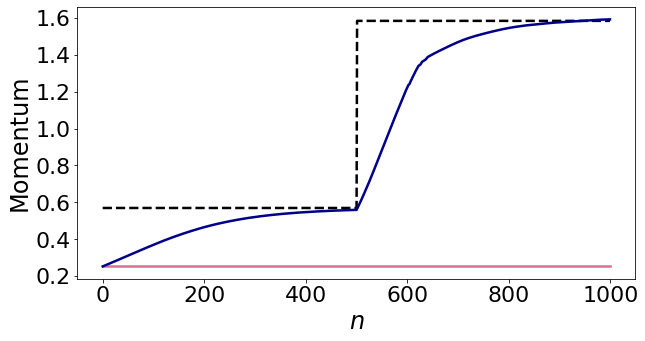

In [15]:

vanilla_kdv_opt_momentum_0 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_0), axis=-1)

vanilla_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_5), axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)


plt.plot(
    vanilla_kdv_opt_momentum_0,
    label=r"$Vanilla(\lambda = 0)$",
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    vanilla_kdv_opt_momentum_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Momentum", fontsize=label_font)
# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

print("---Track Momentum Done---")


In [16]:



# Save data
results_dict = {'vanilla_kdv_opt_momentum_0': vanilla_kdv_opt_momentum_0,
            'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
            'vanilla_kdv_opt_mass_0': vanilla_kdv_opt_mass_0,
            'vanilla_kdv_opt_mass_5': vanilla_kdv_opt_mass_5,
            'mass_ref':mass_ref,
            'momentum_ref':momentum_ref,
            'vanilla_t_list_momentum_0': vanilla_t_list_momentum_0,
            'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5,
}

np.save(os.path.join(data_path,'vanilla_'+forcing_type+'_tau_'+str(tau)+'_tracking_results.npy'), results_dict)

In [17]:
vanilla_results_momentum_5[-1]

      fun: 0.0038442857731552696
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.94740664e-06, -6.13606388e-06, -4.72742505e-06, -3.80854202e-06,
       -5.85464836e-06, -4.66237292e-06, -4.02286711e-06, -5.91883313e-06,
       -4.86273348e-06, -3.94692959e-06, -5.99412013e-06, -4.87526686e-06,
       -3.87138238e-06, -5.77862411e-06, -4.72959345e-06, -3.95477921e-06,
       -5.99208183e-06, -4.65526055e-06, -3.94575865e-06, -5.92763685e-06,
       -4.79824513e-06, -4.02533909e-06, -6.00053861e-06, -4.79880892e-06,
       -3.80359806e-06, -5.85781423e-06, -4.86949890e-06, -3.95035567e-06,
       -6.06520043e-06, -4.80396972e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 31
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.00362835, 0.00086357, 0.00466261, 0.00364223, 0.00089179,
       0.0046691 , 0.0036209 , 0.00088538, 0.00464908, 0.00362832,
       0.00087785, 0.00464783, 0.00363604, 0.00089949, 

In [18]:
results_dict_list_vanilla_momentum_5 = [dict(result) for result in vanilla_results_momentum_5]
results_dict_list_vanilla_momentum_5_df = pd.DataFrame(results_dict_list_vanilla_momentum_5)
results_dict_list_vanilla_momentum_5_df.to_csv(os.path.join(data_path,"results_dict_list_vanilla_momentum_5.csv"), index=False)

